In [1]:
# -*- coding: Paper1 -*-
"""
This code belongs to the paper:
-- An Iterative Gradient Descent-Based Reinforcement Learning Policy 
   for Active Control of Structural Vibrations, Computers & Structures.
-- Jagajyoti Panda, Mudit Chopra, Vasant Matsagar, Souvik Chakraborty, IIT Delhi.
   
This code is to present RL-based control algorithm in proportional-integral (PI) to state-output feedback.
-- Case study II: 8-story benchmark building
   State-space representation, Policy parameter update, Efficacy of trained RL-controller
"""
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import os 
from numpy import abs as Abs
from numpy import sign as sign
from numpy import sqrt,pi,array
from scipy import signal
 
 
import matplotlib
import matplotlib.pyplot as plt

from control.matlab import *  # MATLAB-like functions
import control as ct
 
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# System dynamics (8-story benchmark building)

# System parameters
nod = 1  
amp = 3  # amplification factor
n = 8    # Number of storey
r = 3    # no of MR dampers
theta = np.zeros((n,r))
theta[0,0]=1 
theta[3,1]=1
theta[5,2]=1

dampmax = 1000000*nod*amp    # Max MR Damper force
m = 345600   # Lumped mass in KG
M = np.diag(np.full(n,m))   
# print(M)    # Mass matrix
del m

kk = 3444*10**5
K = 2*np.diag(np.full(n,kk))
K[n-1,n-1] = kk
for x in range(n-1):
  K[x,x+1] = -kk
  K[x+1,x] = -kk
# print(K)   # stiffness matrix
del x,kk

cc = 2937000    # Inherent damping
C = 2*np.diag(np.full(n,cc))
C[n-1,n-1] = cc
for x in range(n-1):
  C[x,x+1] = -cc
  C[x+1,x] = -cc
# print(C)   # stiffness matrix
del x,cc

from numpy.linalg import eig
W,V=eig(np.linalg.inv(M) @ K)  # Eigen Analysis
omega=sqrt(W)  # Frequency rad/sec
oma=array(omega)  
fn=oma/(2*pi)  # Frequency Hz
# print('E-value:', omega)
# print('E-vector', V)
del W,V,omega,oma

gbar=np.diag(np.full(n,1))
for x in range(n-1):
  gbar[x,x+1] = -1
gamma=gbar @ theta
# print(gamma)

del x,theta

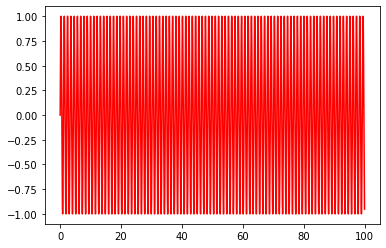

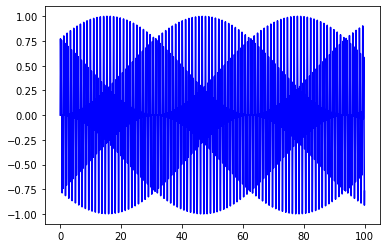

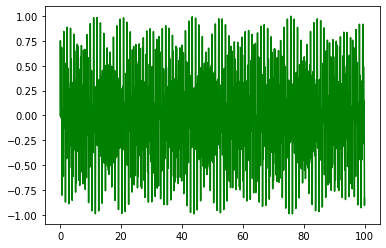

In [3]:
# Input Road Profile
T = 100
dt = 0.01
t = np.arange(0, T+dt, dt)
# amplitude   = 1*np.sin(t)
amplitude   = 1*np.sin(2 * np.pi * 0.927 * t)
amplitude1   = (1/2)*(np.sin(2 * np.pi * 0.927 * t) + np.sin(2 * np.pi * 2.749 * t))
amplitude2   = (1/3)*(np.sin(2 * np.pi * 0.927 * t) + np.sin(2 * np.pi * 2.749 * t) + np.sin(2 * np.pi * 4.478 * t))
len(t)
plt.figure()
plt.plot(t, amplitude,'r')
plt.figure()
plt.plot(t, amplitude1,'b')
plt.figure()
plt.plot(t, amplitude2,'g')

In [4]:
# State space representation
I = -1*np.ones([n,1])  # Influence vector
A1 = np.zeros([n,n])
A2 = np.identity(n)
A3 = -1*np.linalg.inv(M) @ K
A4 = -1*np.linalg.inv(M) @ C
A = np.zeros([2*n,2*n])
A[0:n,n:2*n] = A2
A[n:2*n,0:n] = A3
A[n:2*n,n:2*n] = A4
# = np.ones((n,n), dtype=int)
print(A)  
B = np.zeros((2*n,r))
B[n:2*n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
print(B)
E = np.zeros((2*n,1))
E[n:2*n] = I   # Input matrix
print(E)
# Output matrix (Disp + Accel)
Cd = np.zeros([n+r, 2*n])
Cd[0:n, 0:n] = A3;
Cd[0:n, n:2*n] = A4;
Cd[n,0:2] =  np.array([[1, 1]])
# Cd[n,n:n+2] =  np.array([[1, 1]])
Cd[n+1,2:5] =  np.array([[1, 1, 1]])
# Cd[n+1,n+2:n+5] =  np.array([[1, 1, 1]])
Cd[n+2,5:8] =  np.array([[1, 1, 1]])
# Cd[n+2,n+5:n+8] =  np.array([[1, 1, 1]])
print(Cd)
Dd = np.zeros([n+r, r])
Dd[0:n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
print(Dd)
Ed = np.zeros([n+r,1])
print(Ed)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00

In [10]:
# Digita system (correct)
Ad =np.array([[0.9089,	0.0431,	0.0016,	0,	0,	0,	0,	0,	0.0089,	0.0005,	0,	0,	0,	0,	0,	0],
              [0.0431,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0,	0,	0,	0],
              [0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0,	0,	0],
              [0.0000,	0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0,	0],
              [0.0000,	0,	0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0],
              [0.0000,	0,	0,	0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0],
              [0.0000,	0,	0,	0,	0.0016,	0.0432,	0.9105,	0.0447,	0,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005],
              [0.0000,	0,	0,	0,	0,	0.0016,	0.0447,	0.9536,	0,	0,	0,	0,	0,	0,	0.0005,	0.0094],
              [-17.2450,	7.8662,	0.4817,	0.0164,	0.0004,	0,	0,	0,	0.7618,	0.1102,	0.0057,	0.0002,	0,	0,	0,	0],
              [7.8662,	-16.7634,	7.8826,	0.482,	0.0164,	0.0004,	0,	0,	0.1102,	0.7675,	0.1104,	0.0057,	0.0002,	0,	0,	0],
              [0.4817,	7.8826,	-16.763,	7.8826,	0.482,	0.0164,	0.0004,	0,	0.0057,	0.1104,	0.7675,	0.1104,	0.0057,	0.0002,	0,	0],
              [0.0164,	0.482,	7.8826,	-16.763,	7.8826,	0.482,	0.0164,	0.0004,	0.0002,	0.0057,	0.1104,	0.7675,	0.1104,	0.0057,	0.0002,	0],
              [0.0004,	0.0164,	0.482,	7.8826,	-16.763,	7.8826,	0.4821,	0.0168,	0,	0.0002,	0.0057,	0.1104,	0.7675,	0.1104,	0.0057,	0.0002],
              [0.0000,	0.0004,	0.0164,	0.482,	7.8826,	-16.763,	7.883,	0.4985,	0,	0,	0.0002,	0.0057,	0.1104,	0.7675,	0.1104,	0.0059],
              [0.0000,	0,	0.0004,	0.0164,	0.4821,	7.883,	-16.7466,	8.3647,	0,	0,	0,	0.0002,	0.0057,	0.1104,	0.7677,	0.1161],
              [0.0000,	0,	0,	0.0004,	0.0168,	0.4985,	8.3647,	-8.8804,	0,	0,	0,	0,	0.0002,	0.0059,	0.1161,	0.8779]])
print(Ad)
Bd  = np.array([[1.34702468304747E-10,	-1.15672784046959E-13,	-3.33223374028602E-17],
               [4.80538564665434E-12,	-4.68967910640923E-12,	-2.18046675626884E-15],
               [1.17886577963029E-13,	-1.30012788764478E-10,	-1.15706111159729E-13],
               [2.2137939169218E-15,	1.30012788769298E-10,	-4.68967953544642E-12],
               [3.37561986981929E-17,	4.68967953549301E-12,	-1.30012788764477E-10],
               [4.33862421178217E-19,	1.15706111207136E-13,	1.30012789198338E-10],
               [4.82365420392012E-21,	2.1804715802934E-15,	4.68971286260631E-12],
               [4.76906938178176E-23,	3.37561991045439E-17,	1.17886577963177E-13],
               [2.57851128124862E-08,	-4.88918641729282E-11,	-2.13266602760077E-14],
               [1.49750412070413E-09,	-1.4485906057431E-09,	-1.1612850802489E-12],
               [5.00744800217048E-11,	-2.43365218826153E-08,	-4.89131948958366E-11],
               [1.182615848769E-12,	2.43365218867235E-08,	-1.44859092576268E-09],
               [2.16507881080578E-14,	1.44859092580829E-09,	-2.43365218826153E-08],
               [3.2412782161542E-16,	4.89131949414518E-11,	2.43365222067431E-08],
               [4.1082484210822E-18,	1.16128918848908E-12,	1.4486122565312E-09],
               [4.56140126500856E-20,	2.16507881049024E-14,	5.0074480021704E-11]])
print(Bd)

Ed = np.array([[-4.82554328318935E-05,	-4.99576926176694E-05,	-4.99992111239577E-05,	-4.99999880289061E-05,	-4.99999998466733E-05,	-4.99999999982996E-05,	-4.99999999999823E-05,	-4.99999999999999E-05,	-0.00944659446040994,	-0.00998185393282461,	-0.009999575981124,	-0.00999999228912783,	-0.00999999988509437,	-0.0099999999985485,	-0.00999999999998409,	-0.00999999999999984,	]]).T
print(Ed)

[[ 9.08900e-01  4.31000e-02  1.60000e-03  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  8.90000e-03  5.00000e-04
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 4.31000e-02  9.10400e-01  4.32000e-02  1.60000e-03  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  5.00000e-04  8.90000e-03
   5.00000e-04  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 1.60000e-03  4.32000e-02  9.10400e-01  4.32000e-02  1.60000e-03
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  5.00000e-04
   8.90000e-03  5.00000e-04  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  1.60000e-03  4.32000e-02  9.10400e-01  4.32000e-02
   1.60000e-03  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   5.00000e-04  8.90000e-03  5.00000e-04  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.60000e-03  4.32000e-02  9.10400e-01
   4.32000e-02  1.60000e-03  0.00000e+00  0.00000e+00  0.00000e+0

In [11]:
FI = np.load('FI_PI8.npy')
gI = np.load('gI_PI8.npy')
Cdi = np.load('Cdi_PI8.npy')
Ddi = np.load('Ddi_PI8.npy')
BIrd = np.load('Ed_PI8.npy')

[[ 2725.56805798  2849.61586119  2041.97061938  2038.61797845
   2038.17628285  1220.6080893   1223.11097153  1220.71581469
   4252.15233057  7710.28816471 10380.59529727 12492.94910222
  14046.71121082 15041.59404506 15704.46362734 16036.13630737
   7789.50696933  5437.29124807  3122.03811376]
 [-2207.44395402 -2198.60885093  2350.06203377  2219.16866424
   2332.48783375  1732.94849834  1732.26697416  1728.52408943
   2117.6016348   4854.18172193  8202.76800873 10935.96818719
  13012.82197421 14445.79705979 15401.11748405 15879.02804815
  -6247.23133566  6301.47841889  4610.37509628]
 [  189.14523921   183.84786877 -1979.12936286 -1955.21926558
  -1847.44691287  2933.16412835  3052.71970931  3086.73262749
    992.49298659  1929.70602836  2814.85141354  4246.28638933
   6228.79289165  8761.98855203 10450.3840511  11294.21616351
    539.51937025 -5542.43780889  8305.59669374]]
[[  98358.50286532  259759.99258322  304654.1560289   369566.32270632
   419161.07003239  434855.40762924  4615

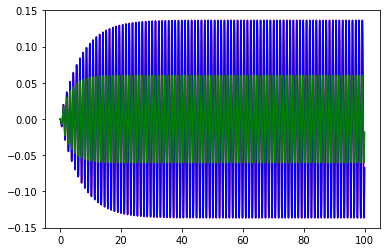

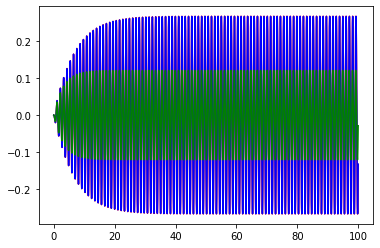

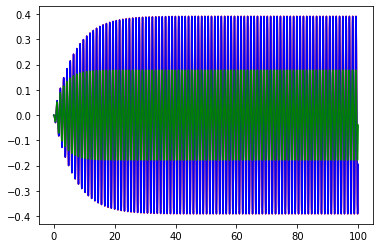

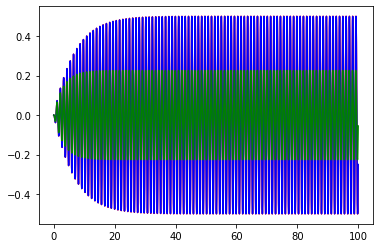

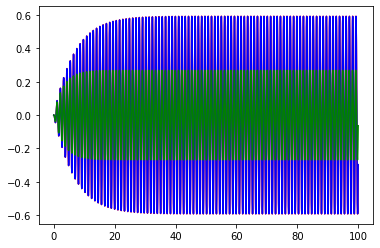

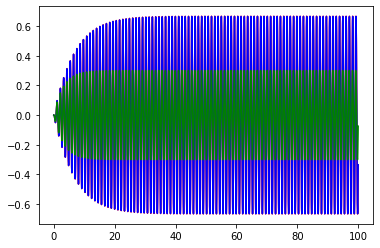

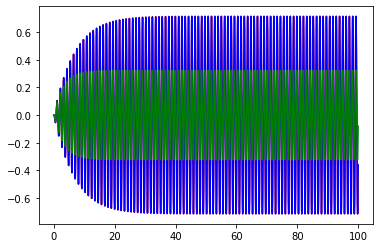

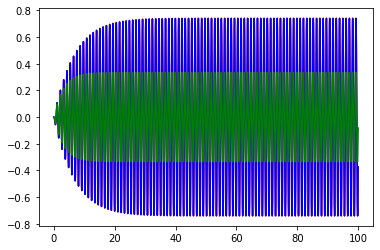

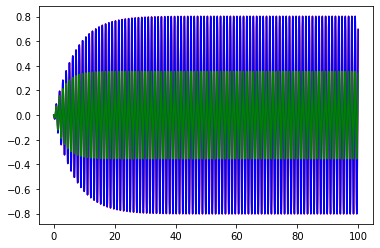

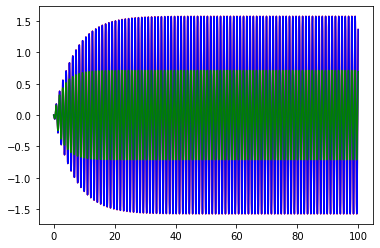

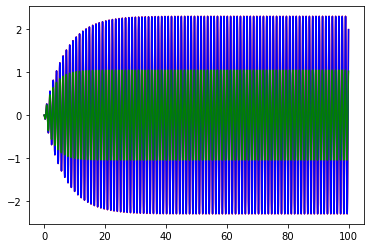

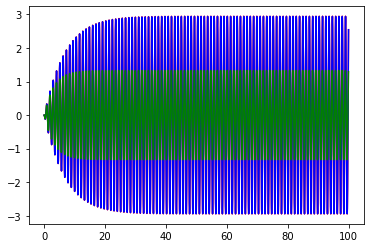

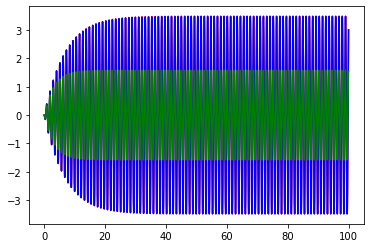

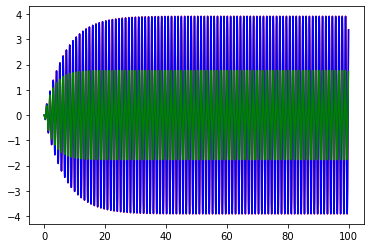

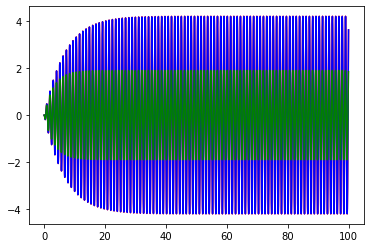

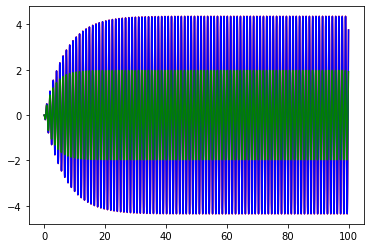

In [12]:
# Initial controller gain (proportional)
Qp_i = np.identity(2*n+r)
(i,j)=gI.shape
Rp_i =  (10**(-8))*np.identity(j)
Rp_o =  (10**(-11))*np.identity(j)
Kp, Sp, ep = ct.dlqr(FI, gI, Qp_i, Rp_i)
Kpo, Spo, epo = ct.dlqr(FI, gI, Qp_i, Rp_o)
print(Kp)
print(Kpo)
# Time series analysis
xo = np.zeros((len(t),2*n+r))
xp = np.zeros((len(t),2*n+r))
xp2 = np.zeros((len(t),2*n+r))
(i,j) = Cdi.shape
yo = np.zeros((len(t),i))
yp = np.zeros((len(t),i))
yp2 = np.zeros((len(t),i))
del i,j

for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    y = (Cdi @ np.array([xo[tkk,:]]).T)
    yo[tkk,:] = y.T
    x = (FI @ np.array([xo[tkk,:]]).T) + (BIrd * amplitude[tkk])
    xo[tkk+1,:] = x.T
    y1 = (Cdi @ np.array([xp2[tkk,:]]).T) + (Ddi @ ((-1*Kpo) @ np.array([xp2[tkk,:]]).T))
    yp2[tkk,:] = y1.T
    x1 = (FI @ np.array([xp2[tkk,:]]).T) + (gI @ ((-1*Kpo) @ np.array([xp2[tkk,:]]).T)) + (BIrd * amplitude[tkk])
    xp2[tkk+1,:] = x1.T
    y2 = (Cdi @ np.array([xp[tkk,:]]).T) + (Ddi @ ((-1*Kp) @ np.array([xp[tkk,:]]).T))
    yp[tkk,:] = y2.T
    x2 = (FI @ np.array([xp[tkk,:]]).T) + (gI @ ((-1*Kp) @ np.array([xp[tkk,:]]).T)) + (BIrd * amplitude[tkk])
    xp[tkk+1,:] = x2.T
for i in range(2*n):
    plt.figure()
    plt.plot(t, xo[:,i], 'r', t, xp[:,i], 'b', t, xp2[:,i], 'g')
    
np.save('Kpo_PI8.npy', Kpo)

(50, 3)
None


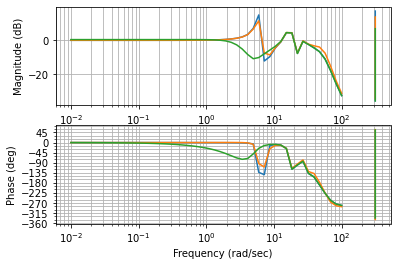

In [24]:
# Bode plot for the system (uncontrolled)
BKti = np.load('BKt_PI8.npy')
Cd1i = np.load('Cd1_PI8.npy')

plt.figure()
bode(ss(FI, BIrd, Cdi[1, :], np.zeros([1]), dt), logspace(-2, 2), plot=True)
bode(ss(FI-(gI@Kpo), BIrd, Cdi[1, :]-(Ddi[1, :]@Kpo), np.zeros([1]), dt), logspace(-2, 2), plot=True)
mag_pc, phase_pc, om_pc = bode(ss(FI-BKti, BIrd, Cd1i[1, :]-BKti[1, :], np.zeros([1]), dt), logspace(-2, 2), plot=True)
input = np.array([om_pc, mag_pc, phase_pc])
print(input.T.shape)
result=np.savetxt('Bode_pau.txt', input.T, delimiter=' ')
print(result)
del mag_pc, phase_pc, om_pc, input

In [18]:
# propertional (Discrete)
Bj_p = gI @ (-1*Kp) 
Al_p = FI.T + Bj_p.T 
P_p = dlyap(Al_p, -Qp)

NameError: name 'Qp' is not defined

In [19]:
# Dynamical equation (Rk4) (State)
def dydx(A1, B1, E1, U1, h1, x1):
#   print(x1,U1,h1)
  Bu  = U1*B1
#   print(Bu)
  fi = h1*E1
  k1 = dt*(A1@x1 + Bu@x1 + fi)
  k2 = dt*(A1@(x1 + 0.5*k1)+ Bu@(x1 + 0.5*k1) + fi)
  k3 = dt*(A1@(x1 + 0.5*k2)+ Bu@(x1 + 0.5*k2) + fi)
  k4 = dt*(A1@(x1 + k3)+ Bu@(x1 + k3) + fi)
  x2 = x1 + (k1 + 2*k2 + 2*k3 + k4)/6
  return x2

In [20]:
# Dynamical equation (Rk4) (Adjoint State)
def dydx1(A1, B1, E1, U1, h1, x1):
#   print(x1,U1,h1)
  Bu  = U1*B1
#   print(Bu)
  fi = h1*E1
  k1 = -dt*(A1@x1 + Bu@x1 + fi)
  k2 = -dt*(A1@(x1 + 0.5*k1)+ Bu@(x1 + 0.5*k1) + fi)
  k3 = -dt*(A1@(x1 + 0.5*k2)+ Bu@(x1 + 0.5*k2) + fi)
  k4 = -dt*(A1@(x1 + k3)+ Bu@(x1 + k3) + fi)
  x2 = x1 + (k1 + 2*k2 + 2*k3 + k4)/6
  return x2

In [21]:
# PI-controller (discrete)
# Policy parameter update
Zmax = 501 # No of episodes
# Qp = np.array([[Ks, -Ks, 0, 0],
#             [-Ks, Ks+Kt, 0, 0],
#             [0, 0, M, 0],
#             [0, 0, 0, m]])
Qp = np.identity(2*n+r)
BK = np.zeros([2*n+r,2*n+r,Zmax])
BK[0:2*n+r,0:2*n+r,0] = Bj_p  # Initial Stiffness
djdk_d = np.zeros([2*n+r,2*n+r,Zmax])  # Gradient
alpha = 0.05  
xd = np.zeros([len(t), 2*n+r, Zmax])  # State
pd = np.zeros([len(t), 2*n+r, Zmax])  # Adjoint State
done = False
J_cd = np.zeros([len(t), 1, Zmax])  # Cost function
E_cd = np.zeros([len(t), 1, Zmax])  # Structure's energy
val_arr = np.zeros([len(t), 1, Zmax]) # x.T*K*x
sd = []  # number of tau_s

for id in range(0, Zmax-1):  
  BKo = BK[0:2*n+r,0:2*n+r,id] 
  print(BKo)
  for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    h = amplitude[tkk] 
    xn = np.array([xd[tkk,:,id]]).T
    xn1 = (FI @ xn) + (BKo @ xn) + (BIrd * h)
#     print(xn1)
    xd[tkk+1,:,id] = xn1.T
    En1 = 0.5*((xn1.T @ Qp)@xn1)
    E_cd[tkk+1,:,id] = En1
    Jn1 = J_cd[tkk,:,id] + dt*(En1)
    J_cd[tkk+1,:,id] = Jn1  # Cost functional
    del xn,xn1
  print(Jn1)  
  # Adjoint State  
  sd.append([])
  for tkk in range(0,len(t)-1):
    i = len(t)-1-tkk
#     print(i)
    xn = np.array([xd[i,:,id]]).T
    val = (xn.T @ BKo) @ xn
#     print(val)
    val_arr[i,:,id] = val
    if(val==0):
      pn = np.array([pd[i,:,id]]).T
      sd[id].append(i)
      d_ptau1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
#       print(val)
      d_ptau = (d_ptau1[0,0]*((BKo + BKo.T)@xn))      #1*(1*1)*((n*n)@(n*1))  #############
#       d_ptau = (d_ptau1[0,0]*xn)      #1*(1*1)*((n*n)@(n*1))  #############
#       print(d_ptau)
      pnb1 = pn + d_ptau  # (n*1)
      pd[i-1,:,id] = pnb1.T
    else:
      if(val[0]<0.000001 and val[0] >-0.000001):
        sd[id].append(i)
      pn = np.array([pd[i,:,id]]).T
      F = Qp@xn 
      pnb1 = (-FI.T @ pn) + (-BKo.T @ pn) + (F)
      pd[i-1,:,id] = pnb1.T
#     print(p[i-1,:,id])
    del xn, val, pn, pnb1, i
    
  # Evaluate dj/dk
  sum = djdk_d[0:2*n+r,0:2*n+r,id]
  print(len(sd[id]))
  if(len(sd[id])>0):
    for j in sd[id]:
        xn = np.array([xd[j,:,id]]).T
        pn = np.array([pd[j,:,id]]).T
        sum1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
        sum = sum +  ((-1)*(sum1[0,0]*(xn@xn.T)))  # 1*(1*1)*((n*1)@(1*n))  #############
    print(sum)
    djdk_d[0:2*n+r,0:2*n+r,id] = sum
  # Update K 
#     alpha = 2*id
    BK[0:2*n+r,0:2*n+r,id+1] = BK[0:2*n+r,0:2*n+r,id]  - alpha*djdk_d[0:2*n+r,0:2*n+r,id]
  else:
    print(np.linalg.norm(djdk_d[0:2*n+r,0:2*n+r,id]))
#     break

[[-3.67396080e-07 -3.84104603e-07 -2.74786710e-07 -2.74350241e-07
  -2.74277632e-07 -1.64218370e-07 -1.64555589e-07 -1.64233387e-07
  -5.72530433e-07 -1.03803329e-06 -1.39734288e-06 -1.68156595e-06
  -1.89062123e-06 -2.02446857e-06 -2.11364818e-06 -2.15826999e-06
  -1.04998843e-06 -7.31687827e-07 -4.20012668e-07]
 [-2.34491970e-08 -2.40038723e-08  1.20426509e-09  6.06580055e-10
   1.14036811e-09  2.26787544e-09  2.25291268e-09  2.24694357e-09
  -1.05001955e-08 -1.42821458e-08 -1.14082762e-08 -8.73799790e-09
  -6.46032343e-09 -4.51540226e-09 -3.21691851e-09 -2.56764651e-09
  -6.67279188e-08  3.41154526e-09  6.63669270e-09]
 [-2.87295367e-07 -2.86161927e-07  3.05068400e-07  2.88053750e-07
   3.02799213e-07  2.25500959e-07  2.25425890e-07  2.24943485e-07
   2.74928860e-07  6.30420042e-07  1.06556671e-06  1.42083429e-06
   1.69089807e-06  1.87737898e-06  2.00170006e-06  2.06389308e-06
  -8.13075821e-07  8.17990505e-07  6.00000685e-07]
 [ 2.87876941e-07  2.86703147e-07 -3.14824122e-07 -2.97

23
[[ 5.21485119e-09  9.91066878e-09  1.40266155e-08  1.75129380e-08
   2.03402196e-08  2.24793199e-08  2.39151363e-08  2.46324795e-08
   3.07607964e-09  6.02033992e-09  8.62514765e-09  1.08251212e-08
   1.27270674e-08  1.41302881e-08  1.51296959e-08  1.58555659e-08
   2.23502846e-09  4.94112165e-09 -2.57798921e-09]
 [ 9.91066878e-09  1.88349035e-08  2.66570791e-08  3.32826511e-08
   3.86557236e-08  4.27209366e-08  4.54495985e-08  4.68128533e-08
   5.84314278e-09  1.14363482e-08  1.63847946e-08  2.05639934e-08
   2.41769272e-08  2.68422971e-08  2.87406173e-08  3.01195716e-08
   4.24467249e-09  9.38333586e-09 -4.90125276e-09]
 [ 1.40266155e-08  2.66570791e-08  3.77277505e-08  4.71048379e-08
   5.47092459e-08  6.04626477e-08  6.43244495e-08  6.62538246e-08
   8.26717610e-09  1.61808900e-08  2.31822409e-08  2.90949190e-08
   3.42062970e-08  3.79768798e-08  4.06623274e-08  4.26133059e-08
   6.00409601e-09  1.32719186e-08 -6.93865223e-09]
 [ 1.75129380e-08  3.32826511e-08  4.71048379e-08  5

23
[[ 5.21185765e-09  9.90497500e-09  1.40185512e-08  1.75028631e-08
   2.03285122e-08  2.24663762e-08  2.39013622e-08  2.46182903e-08
   3.07436814e-09  6.01698727e-09  8.62034168e-09  1.08190860e-08
   1.27199689e-08  1.41224049e-08  1.51212535e-08  1.58467136e-08
   2.23369585e-09  4.93849587e-09 -2.57649646e-09]
 [ 9.90497500e-09  1.88240738e-08  2.66417407e-08  3.32634882e-08
   3.86334558e-08  4.26963173e-08  4.54233997e-08  4.67858651e-08
   5.83988624e-09  1.14299687e-08  1.63756494e-08  2.05525088e-08
   2.41634188e-08  2.68272949e-08  2.87245507e-08  3.01027249e-08
   4.24213716e-09  9.37834675e-09 -4.89840239e-09]
 [ 1.40185512e-08  2.66417407e-08  3.77060262e-08  4.70776970e-08
   5.46777072e-08  6.04277785e-08  6.42873433e-08  6.62156002e-08
   8.26256226e-09  1.61718512e-08  2.31692831e-08  2.90786460e-08
   3.41871559e-08  3.79556216e-08  4.06395606e-08  4.25894339e-08
   6.00050434e-09  1.32648589e-08 -6.93460125e-09]
 [ 1.75028631e-08  3.32634882e-08  4.70776970e-08  5

23
[[ 5.20886611e-09  9.89928504e-09  1.40104923e-08  1.74927949e-08
   2.03168126e-08  2.24534412e-08  2.38875973e-08  2.46041107e-08
   3.07265777e-09  6.01363683e-09  8.61553891e-09  1.08130549e-08
   1.27128752e-08  1.41145269e-08  1.51128166e-08  1.58378671e-08
   2.23236449e-09  4.93587301e-09 -2.57500311e-09]
 [ 9.89928504e-09  1.88132514e-08  2.66264125e-08  3.32443383e-08
   3.86112029e-08  4.26717145e-08  4.53972185e-08  4.67588950e-08
   5.83663185e-09  1.14235935e-08  1.63665103e-08  2.05410318e-08
   2.41499193e-08  2.68123027e-08  2.87084947e-08  3.00858895e-08
   4.23960423e-09  9.37336319e-09 -4.89555091e-09]
 [ 1.40104923e-08  2.66264125e-08  3.76843164e-08  4.70505742e-08
   5.46461896e-08  6.03929327e-08  6.42502620e-08  6.61774015e-08
   8.25795146e-09  1.61628185e-08  2.31563339e-08  2.90623838e-08
   3.41680275e-08  3.79343777e-08  4.06168090e-08  4.25655778e-08
   5.99691605e-09  1.32578070e-08 -6.93054872e-09]
 [ 1.74927949e-08  3.32443383e-08  4.70505742e-08  5

23
[[ 5.20587658e-09  9.89359890e-09  1.40024389e-08  1.74827334e-08
   2.03051209e-08  2.24405148e-08  2.38738417e-08  2.45899405e-08
   3.07094853e-09  6.01028861e-09  8.61073931e-09  1.08070278e-08
   1.27057861e-08  1.41066542e-08  1.51043854e-08  1.58290266e-08
   2.23103439e-09  4.93325305e-09 -2.57350919e-09]
 [ 9.89359890e-09  1.88024362e-08  2.66110946e-08  3.32252012e-08
   3.85889649e-08  4.26471282e-08  4.53710549e-08  4.67319430e-08
   5.83337961e-09  1.14172224e-08  1.63573772e-08  2.05295625e-08
   2.41364288e-08  2.67973205e-08  2.86924494e-08  3.00690653e-08
   4.23707369e-09  9.36838514e-09 -4.89269833e-09]
 [ 1.40024389e-08  2.66110946e-08  3.76626212e-08  4.70234697e-08
   5.46146932e-08  6.03581103e-08  6.42132055e-08  6.61392284e-08
   8.25334371e-09  1.61537917e-08  2.31433932e-08  2.90461324e-08
   3.41489118e-08  3.79131478e-08  4.05940725e-08  4.25417376e-08
   5.99333114e-09  1.32507630e-08 -6.92649464e-09]
 [ 1.74827334e-08  3.32252012e-08  4.70234697e-08  5

23
[[ 5.20288906e-09  9.88791657e-09  1.39943908e-08  1.74726787e-08
   2.02934370e-08  2.24275971e-08  2.38600953e-08  2.45757799e-08
   3.06924042e-09  6.00694260e-09  8.60594289e-09  1.08010047e-08
   1.26987018e-08  1.40987867e-08  1.50959598e-08  1.58201919e-08
   2.22970555e-09  4.93063600e-09 -2.57201468e-09]
 [ 9.88791657e-09  1.87916283e-08  2.65957871e-08  3.32060769e-08
   3.85667419e-08  4.26225584e-08  4.53449088e-08  4.67050091e-08
   5.83012952e-09  1.14108556e-08  1.63482501e-08  2.05181008e-08
   2.41229473e-08  2.67823482e-08  2.86764148e-08  3.00522522e-08
   4.23454553e-09  9.36341263e-09 -4.88984465e-09]
 [ 1.39943908e-08  2.65957871e-08  3.76409406e-08  4.69963834e-08
   5.45832180e-08  6.03233113e-08  6.41761740e-08  6.61010810e-08
   8.24873899e-09  1.61447709e-08  2.31304612e-08  2.90298918e-08
   3.41298088e-08  3.78919321e-08  4.05713512e-08  4.25179133e-08
   5.98974963e-09  1.32437268e-08 -6.92243903e-09]
 [ 1.74726787e-08  3.32060769e-08  4.69963834e-08  5

23
[[ 5.19990354e-09  9.88223806e-09  1.39863482e-08  1.74626308e-08
   2.02817610e-08  2.24146881e-08  2.38463581e-08  2.45616288e-08
   3.06753343e-09  6.00359881e-09  8.60114966e-09  1.07949856e-08
   1.26916222e-08  1.40909244e-08  1.50875398e-08  1.58113632e-08
   2.22837796e-09  4.92802186e-09 -2.57051959e-09]
 [ 9.88223806e-09  1.87808277e-08  2.65804898e-08  3.31869655e-08
   3.85445338e-08  4.25980051e-08  4.53187804e-08  4.66780932e-08
   5.82688157e-09  1.14044930e-08  1.63391291e-08  2.05066466e-08
   2.41094747e-08  2.67673860e-08  2.86603909e-08  3.00354504e-08
   4.23201977e-09  9.35844563e-09 -4.88698989e-09]
 [ 1.39863482e-08  2.65804898e-08  3.76192746e-08  4.69693152e-08
   5.45517639e-08  6.02885356e-08  6.41391673e-08  6.60629591e-08
   8.24413732e-09  1.61357561e-08  2.31175377e-08  2.90136620e-08
   3.41107185e-08  3.78707305e-08  4.05486450e-08  4.24941049e-08
   5.98617149e-09  1.32366984e-08 -6.91838189e-09]
 [ 1.74626308e-08  3.31869655e-08  4.69693152e-08  5

23
[[ 5.19692003e-09  9.87656337e-09  1.39783109e-08  1.74525896e-08
   2.02700928e-08  2.24017877e-08  2.38326301e-08  2.45474872e-08
   3.06582758e-09  6.00025724e-09  8.59635961e-09  1.07889705e-08
   1.26845473e-08  1.40830674e-08  1.50791254e-08  1.58025403e-08
   2.22705162e-09  4.92541062e-09 -2.56902393e-09]
 [ 9.87656337e-09  1.87700343e-08  2.65652028e-08  3.31678669e-08
   3.85223406e-08  4.25734683e-08  4.52926694e-08  4.66511955e-08
   5.82363577e-09  1.13981346e-08  1.63300142e-08  2.04952001e-08
   2.40960111e-08  2.67524336e-08  2.86443776e-08  3.00186598e-08
   4.22949639e-09  9.35348414e-09 -4.88413404e-09]
 [ 1.39783109e-08  2.65652028e-08  3.75976231e-08  4.69422653e-08
   5.45203309e-08  6.02537833e-08  6.41021855e-08  6.60248629e-08
   8.23953868e-09  1.61267473e-08  2.31046228e-08  2.89974430e-08
   3.40916410e-08  3.78495431e-08  4.05259540e-08  4.24703123e-08
   5.98259673e-09  1.32296778e-08 -6.91432323e-09]
 [ 1.74525896e-08  3.31678669e-08  4.69422653e-08  5

23
[[ 5.19393853e-09  9.87089249e-09  1.39702791e-08  1.74425552e-08
   2.02584325e-08  2.23888961e-08  2.38189114e-08  2.45333551e-08
   3.06412285e-09  5.99691787e-09  8.59157274e-09  1.07829594e-08
   1.26774771e-08  1.40752156e-08  1.50707166e-08  1.57937233e-08
   2.22572654e-09  4.92280227e-09 -2.56752770e-09]
 [ 9.87089249e-09  1.87592482e-08  2.65499260e-08  3.31487812e-08
   3.85001624e-08  4.25489480e-08  4.52665761e-08  4.66243159e-08
   5.82039211e-09  1.13917804e-08  1.63209053e-08  2.04837613e-08
   2.40825565e-08  2.67374913e-08  2.86283751e-08  3.00018805e-08
   4.22697539e-09  9.34852817e-09 -4.88127712e-09]
 [ 1.39702791e-08  2.65499260e-08  3.75759861e-08  4.69152335e-08
   5.44889191e-08  6.02190544e-08  6.40652285e-08  6.59867924e-08
   8.23494309e-09  1.61177444e-08  2.30917165e-08  2.89812348e-08
   3.40725761e-08  3.78283698e-08  4.05032781e-08  4.24465357e-08
   5.97902535e-09  1.32226650e-08 -6.91026306e-09]
 [ 1.74425552e-08  3.31487812e-08  4.69152335e-08  5

23
[[ 5.19095903e-09  9.86522543e-09  1.39622527e-08  1.74325275e-08
   2.02467800e-08  2.23760131e-08  2.38052019e-08  2.45192325e-08
   3.06241925e-09  5.99358073e-09  8.58678906e-09  1.07769523e-08
   1.26704117e-08  1.40673691e-08  1.50623135e-08  1.57849122e-08
   2.22440272e-09  4.92019683e-09 -2.56603090e-09]
 [ 9.86522543e-09  1.87484693e-08  2.65346596e-08  3.31297083e-08
   3.84779990e-08  4.25244443e-08  4.52405003e-08  4.65974543e-08
   5.81715060e-09  1.13854304e-08  1.63118025e-08  2.04723300e-08
   2.40691108e-08  2.67225589e-08  2.86123832e-08  2.99851123e-08
   4.22445678e-09  9.34357770e-09 -4.87841912e-09]
 [ 1.39622527e-08  2.65346596e-08  3.75543638e-08  4.68882200e-08
   5.44575285e-08  6.01843489e-08  6.40282965e-08  6.59487474e-08
   8.23035054e-09  1.61087475e-08  2.30788188e-08  2.89650374e-08
   3.40535240e-08  3.78072106e-08  4.04806174e-08  4.24227749e-08
   5.97545734e-09  1.32156600e-08 -6.90620138e-09]
 [ 1.74325275e-08  3.31297083e-08  4.68882200e-08  5

23
[[ 5.18798154e-09  9.85956219e-09  1.39542316e-08  1.74225066e-08
   2.02351354e-08  2.23631388e-08  2.37915017e-08  2.45051194e-08
   3.06071678e-09  5.99024580e-09  8.58200855e-09  1.07709492e-08
   1.26633509e-08  1.40595278e-08  1.50539159e-08  1.57761070e-08
   2.22308014e-09  4.91759428e-09 -2.56453353e-09]
 [ 9.85956219e-09  1.87376977e-08  2.65194034e-08  3.31106483e-08
   3.84558506e-08  4.24999570e-08  4.52144420e-08  4.65706109e-08
   5.81391124e-09  1.13790847e-08  1.63027057e-08  2.04609064e-08
   2.40556742e-08  2.67076366e-08  2.85964021e-08  2.99683553e-08
   4.22194056e-09  9.33863273e-09 -4.87556007e-09]
 [ 1.39542316e-08  2.65194034e-08  3.75327560e-08  4.68612246e-08
   5.44261589e-08  6.01496667e-08  6.39913893e-08  6.59107281e-08
   8.22576104e-09  1.60997565e-08  2.30659296e-08  2.89488508e-08
   3.40344846e-08  3.77860655e-08  4.04579718e-08  4.23990300e-08
   5.97189271e-09  1.32086627e-08 -6.90213821e-09]
 [ 1.74225066e-08  3.31106483e-08  4.68612246e-08  5

23
[[ 5.18500606e-09  9.85390276e-09  1.39462160e-08  1.74124924e-08
   2.02234986e-08  2.23502732e-08  2.37778107e-08  2.44910158e-08
   3.05901543e-09  5.98691309e-09  8.57723123e-09  1.07649501e-08
   1.26562949e-08  1.40516917e-08  1.50455240e-08  1.57673077e-08
   2.22175882e-09  4.91499462e-09 -2.56303561e-09]
 [ 9.85390276e-09  1.87269333e-08  2.65041575e-08  3.30916011e-08
   3.84337172e-08  4.24754862e-08  4.51884014e-08  4.65437855e-08
   5.81067403e-09  1.13727432e-08  1.62936150e-08  2.04494903e-08
   2.40422464e-08  2.66927241e-08  2.85804316e-08  2.99516096e-08
   4.21942671e-09  9.33369326e-09 -4.87269995e-09]
 [ 1.39462160e-08  2.65041575e-08  3.75111627e-08  4.68342474e-08
   5.43948106e-08  6.01150079e-08  6.39545070e-08  6.58727344e-08
   8.22117457e-09  1.60907716e-08  2.30530491e-08  2.89326750e-08
   3.40154579e-08  3.77649346e-08  4.04353413e-08  4.23753010e-08
   5.96833145e-09  1.32016733e-08 -6.89807355e-09]
 [ 1.74124924e-08  3.30916011e-08  4.68342474e-08  5

23
[[ 5.18203258e-09  9.84824714e-09  1.39382058e-08  1.74024850e-08
   2.02118696e-08  2.23374162e-08  2.37641289e-08  2.44769218e-08
   3.05731522e-09  5.98358259e-09  8.57245709e-09  1.07589550e-08
   1.26492435e-08  1.40438609e-08  1.50371377e-08  1.57585143e-08
   2.22043875e-09  4.91239785e-09 -2.56153712e-09]
 [ 9.84824714e-09  1.87161762e-08  2.64889219e-08  3.30725667e-08
   3.84115986e-08  4.24510320e-08  4.51623782e-08  4.65169783e-08
   5.80743896e-09  1.13664058e-08  1.62845304e-08  2.04380819e-08
   2.40288277e-08  2.66778217e-08  2.85644718e-08  2.99348751e-08
   4.21691524e-09  9.32875928e-09 -4.86983878e-09]
 [ 1.39382058e-08  2.64889219e-08  3.74895840e-08  4.68072884e-08
   5.43634833e-08  6.00803725e-08  6.39176495e-08  6.58347664e-08
   8.21659115e-09  1.60817926e-08  2.30401771e-08  2.89165099e-08
   3.39964439e-08  3.77438178e-08  4.04127260e-08  4.23515879e-08
   5.96477356e-09  1.31946916e-08 -6.89400741e-09]
 [ 1.74024850e-08  3.30725667e-08  4.68072884e-08  5

23
[[ 5.17906110e-09  9.84259535e-09  1.39302010e-08  1.73924843e-08
   2.02002485e-08  2.23245679e-08  2.37504563e-08  2.44628372e-08
   3.05561613e-09  5.98025430e-09  8.56768613e-09  1.07529639e-08
   1.26421969e-08  1.40360354e-08  1.50287570e-08  1.57497267e-08
   2.21911993e-09  4.90980397e-09 -2.56003808e-09]
 [ 9.84259535e-09  1.87054264e-08  2.64736966e-08  3.30535452e-08
   3.83894950e-08  4.24265942e-08  4.51363727e-08  4.64901891e-08
   5.80420604e-09  1.13600727e-08  1.62754518e-08  2.04266811e-08
   2.40154179e-08  2.66629292e-08  2.85485227e-08  2.99181518e-08
   4.21440615e-09  9.32383079e-09 -4.86697656e-09]
 [ 1.39302010e-08  2.64736966e-08  3.74680199e-08  4.67803477e-08
   5.43321772e-08  6.00457605e-08  6.38808170e-08  6.57968239e-08
   8.21201076e-09  1.60728196e-08  2.30273136e-08  2.89003557e-08
   3.39774426e-08  3.77227152e-08  4.03901259e-08  4.23278907e-08
   5.96121904e-09  1.31877177e-08 -6.88993981e-09]
 [ 1.73924843e-08  3.30535452e-08  4.67803477e-08  5

23
[[ 5.17609163e-09  9.83694736e-09  1.39222016e-08  1.73824904e-08
   2.01886353e-08  2.23117283e-08  2.37367930e-08  2.44487622e-08
   3.05391817e-09  5.97692823e-09  8.56291835e-09  1.07469768e-08
   1.26351550e-08  1.40282150e-08  1.50203819e-08  1.57409451e-08
   2.21780236e-09  4.90721297e-09 -2.55853848e-09]
 [ 9.83694736e-09  1.86946838e-08  2.64584815e-08  3.30345365e-08
   3.83674063e-08  4.24021729e-08  4.51103847e-08  4.64634180e-08
   5.80097526e-09  1.13537439e-08  1.62663792e-08  2.04152879e-08
   2.40020171e-08  2.66480467e-08  2.85325843e-08  2.99014396e-08
   4.21189943e-09  9.31890778e-09 -4.86411330e-09]
 [ 1.39222016e-08  2.64584815e-08  3.74464703e-08  4.67534251e-08
   5.43008922e-08  6.00111718e-08  6.38440092e-08  6.57589071e-08
   8.20743342e-09  1.60638525e-08  2.30144588e-08  2.88842122e-08
   3.39584541e-08  3.77016267e-08  4.03675409e-08  4.23042094e-08
   5.95766788e-09  1.31807515e-08 -6.88587074e-09]
 [ 1.73824904e-08  3.30345365e-08  4.67534251e-08  5

23
[[ 5.17312417e-09  9.83130319e-09  1.39142076e-08  1.73725032e-08
   2.01770299e-08  2.22988974e-08  2.37231389e-08  2.44346967e-08
   3.05222134e-09  5.97360438e-09  8.55815375e-09  1.07409937e-08
   1.26281178e-08  1.40203999e-08  1.50120125e-08  1.57321694e-08
   2.21648604e-09  4.90462486e-09 -2.55703833e-09]
 [ 9.83130319e-09  1.86839485e-08  2.64432767e-08  3.30155407e-08
   3.83453325e-08  4.23777682e-08  4.50844142e-08  4.64366650e-08
   5.79774663e-09  1.13474192e-08  1.62573127e-08  2.04039024e-08
   2.39886253e-08  2.66331742e-08  2.85166566e-08  2.98847387e-08
   4.20939510e-09  9.31399025e-09 -4.86124901e-09]
 [ 1.39142076e-08  2.64432767e-08  3.74249353e-08  4.67265206e-08
   5.42696284e-08  5.99766065e-08  6.38072264e-08  6.57210159e-08
   8.20285912e-09  1.60548915e-08  2.30016126e-08  2.88680796e-08
   3.39394782e-08  3.76805523e-08  4.03449710e-08  4.22805440e-08
   5.95412008e-09  1.31737931e-08 -6.88180022e-09]
 [ 1.73725032e-08  3.30155407e-08  4.67265206e-08  5

23
[[ 5.17015871e-09  9.82566284e-09  1.39062190e-08  1.73625228e-08
   2.01654323e-08  2.22860751e-08  2.37094941e-08  2.44206407e-08
   3.05052563e-09  5.97028274e-09  8.55339234e-09  1.07350147e-08
   1.26210854e-08  1.40125901e-08  1.50036486e-08  1.57233995e-08
   2.21517096e-09  4.90203963e-09 -2.55553764e-09]
 [ 9.82566284e-09  1.86732204e-08  2.64280822e-08  3.29965577e-08
   3.83232736e-08  4.23533799e-08  4.50584614e-08  4.64099300e-08
   5.79452015e-09  1.13410987e-08  1.62482523e-08  2.03925244e-08
   2.39752425e-08  2.66183116e-08  2.85007396e-08  2.98680491e-08
   4.20689313e-09  9.30907820e-09 -4.85838368e-09]
 [ 1.39062190e-08  2.64280822e-08  3.74034149e-08  4.66996344e-08
   5.42383857e-08  5.99420646e-08  6.37704684e-08  6.56831502e-08
   8.19828786e-09  1.60459364e-08  2.29887749e-08  2.88519577e-08
   3.39205151e-08  3.76594920e-08  4.03224163e-08  4.22568944e-08
   5.95057565e-09  1.31668425e-08 -6.87772826e-09]
 [ 1.73625228e-08  3.29965577e-08  4.66996344e-08  5

23
[[ 5.16719526e-09  9.82002630e-09  1.38982358e-08  1.73525492e-08
   2.01538426e-08  2.22732615e-08  2.36958584e-08  2.44065941e-08
   3.04883106e-09  5.96696332e-09  8.54863410e-09  1.07290396e-08
   1.26140576e-08  1.40047855e-08  1.49952904e-08  1.57146355e-08
   2.21385713e-09  4.89945728e-09 -2.55403641e-09]
 [ 9.82002630e-09  1.86624996e-08  2.64128980e-08  3.29775876e-08
   3.83012297e-08  4.23290081e-08  4.50325260e-08  4.63832132e-08
   5.79129581e-09  1.13347825e-08  1.62391979e-08  2.03811541e-08
   2.39618686e-08  2.66034590e-08  2.84848332e-08  2.98513706e-08
   4.20439354e-09  9.30417161e-09 -4.85551734e-09]
 [ 1.38982358e-08  2.64128980e-08  3.73819089e-08  4.66727663e-08
   5.42071641e-08  5.99075460e-08  6.37337353e-08  6.56453103e-08
   8.19371964e-09  1.60369873e-08  2.29759458e-08  2.88358466e-08
   3.39015646e-08  3.76384459e-08  4.02998767e-08  4.22332608e-08
   5.94703458e-09  1.31598996e-08 -6.87365486e-09]
 [ 1.73525492e-08  3.29775876e-08  4.66727663e-08  5

23
[[ 5.16423381e-09  9.81439357e-09  1.38902580e-08  1.73425822e-08
   2.01422607e-08  2.22604566e-08  2.36822320e-08  2.43925571e-08
   3.04713761e-09  5.96364611e-09  8.54387905e-09  1.07230685e-08
   1.26070345e-08  1.39969861e-08  1.49869378e-08  1.57058775e-08
   2.21254455e-09  4.89687780e-09 -2.55253463e-09]
 [ 9.81439357e-09  1.86517860e-08  2.63977241e-08  3.29586302e-08
   3.82792007e-08  4.23046528e-08  4.50066082e-08  4.63565144e-08
   5.78807362e-09  1.13284705e-08  1.62301496e-08  2.03697914e-08
   2.39485036e-08  2.65886164e-08  2.84689376e-08  2.98347033e-08
   4.20189631e-09  9.29927049e-09 -4.85264997e-09]
 [ 1.38902580e-08  2.63977241e-08  3.73604176e-08  4.66459165e-08
   5.41759637e-08  5.98730507e-08  6.36970271e-08  6.56074959e-08
   8.18915446e-09  1.60280441e-08  2.29631253e-08  2.88197463e-08
   3.38826269e-08  3.76174139e-08  4.02773523e-08  4.22096430e-08
   5.94349686e-09  1.31529644e-08 -6.86958003e-09]
 [ 1.73425822e-08  3.29586302e-08  4.66459165e-08  5

23
[[ 5.16127437e-09  9.80876465e-09  1.38822856e-08  1.73326221e-08
   2.01306866e-08  2.22476604e-08  2.36686148e-08  2.43785296e-08
   3.04544529e-09  5.96033111e-09  8.53912718e-09  1.07171014e-08
   1.26000162e-08  1.39891919e-08  1.49785908e-08  1.56971253e-08
   2.21123322e-09  4.89430120e-09 -2.55103232e-09]
 [ 9.80876465e-09  1.86410797e-08  2.63825604e-08  3.29396858e-08
   3.82571866e-08  4.22803140e-08  4.49807080e-08  4.63298337e-08
   5.78485358e-09  1.13221627e-08  1.62211073e-08  2.03584363e-08
   2.39351477e-08  2.65737838e-08  2.84530526e-08  2.98180473e-08
   4.19940146e-09  9.29437483e-09 -4.84978160e-09]
 [ 1.38822856e-08  2.63825604e-08  3.73389408e-08  4.66190848e-08
   5.41447843e-08  5.98385789e-08  6.36603437e-08  6.55697071e-08
   8.18459232e-09  1.60191069e-08  2.29503133e-08  2.88036568e-08
   3.38637019e-08  3.75963960e-08  4.02548430e-08  4.21860411e-08
   5.93996250e-09  1.31460369e-08 -6.86550379e-09]
 [ 1.73326221e-08  3.29396858e-08  4.66190848e-08  5

23
[[ 5.15831693e-09  9.80313955e-09  1.38743186e-08  1.73226686e-08
   2.01191204e-08  2.22348728e-08  2.36550069e-08  2.43645116e-08
   3.04375409e-09  5.95701833e-09  8.53437849e-09  1.07111383e-08
   1.25930026e-08  1.39814030e-08  1.49702494e-08  1.56883790e-08
   2.20992313e-09  4.89172747e-09 -2.54952947e-09]
 [ 9.80313955e-09  1.86303807e-08  2.63674070e-08  3.29207541e-08
   3.82351874e-08  4.22559917e-08  4.49548253e-08  4.63031711e-08
   5.78163568e-09  1.13158591e-08  1.62120711e-08  2.03470888e-08
   2.39218007e-08  2.65589611e-08  2.84371783e-08  2.98014024e-08
   4.19690898e-09  9.28948463e-09 -4.84691222e-09]
 [ 1.38743186e-08  2.63674070e-08  3.73174785e-08  4.65922713e-08
   5.41136261e-08  5.98041304e-08  6.36236851e-08  6.55319439e-08
   8.18003322e-09  1.60101757e-08  2.29375100e-08  2.87875781e-08
   3.38447896e-08  3.75753923e-08  4.02323489e-08  4.21624551e-08
   5.93643150e-09  1.31391172e-08 -6.86142613e-09]
 [ 1.73226686e-08  3.29207541e-08  4.65922713e-08  5

23
[[ 5.15536150e-09  9.79751826e-09  1.38663570e-08  1.73127220e-08
   2.01075621e-08  2.22220939e-08  2.36414081e-08  2.43505031e-08
   3.04206403e-09  5.95370777e-09  8.52963298e-09  1.07051793e-08
   1.25859937e-08  1.39736194e-08  1.49619136e-08  1.56796386e-08
   2.20861428e-09  4.88915661e-09 -2.54802609e-09]
 [ 9.79751826e-09  1.86196889e-08  2.63522638e-08  3.29018353e-08
   3.82132031e-08  4.22316859e-08  4.49289602e-08  4.62765266e-08
   5.77841993e-09  1.13095597e-08  1.62030409e-08  2.03357489e-08
   2.39084627e-08  2.65441484e-08  2.84213147e-08  2.97847688e-08
   4.19441886e-09  9.28459988e-09 -4.84404184e-09]
 [ 1.38663570e-08  2.63522638e-08  3.72960308e-08  4.65654760e-08
   5.40824891e-08  5.97697052e-08  6.35870515e-08  6.54942063e-08
   8.17547717e-09  1.60012505e-08  2.29247152e-08  2.87715102e-08
   3.38258900e-08  3.75544027e-08  4.02098699e-08  4.21388850e-08
   5.93290384e-09  1.31322052e-08 -6.85734707e-09]
 [ 1.73127220e-08  3.29018353e-08  4.65654760e-08  5

23
[[ 5.15240807e-09  9.79190079e-09  1.38584008e-08  1.73027820e-08
   2.00960116e-08  2.22093236e-08  2.36278186e-08  2.43365041e-08
   3.04037509e-09  5.95039942e-09  8.52489065e-09  1.06992242e-08
   1.25789895e-08  1.39658409e-08  1.49535835e-08  1.56709041e-08
   2.20730668e-09  4.88658861e-09 -2.54652218e-09]
 [ 9.79190079e-09  1.86090043e-08  2.63371310e-08  3.28829293e-08
   3.81912337e-08  4.22073966e-08  4.49031126e-08  4.62499001e-08
   5.77520632e-09  1.13032645e-08  1.61940168e-08  2.03244166e-08
   2.38951337e-08  2.65293457e-08  2.84054618e-08  2.97681463e-08
   4.19193110e-09  9.27972058e-09 -4.84117046e-09]
 [ 1.38584008e-08  2.63371310e-08  3.72745977e-08  4.65386988e-08
   5.40513731e-08  5.97353034e-08  6.35504426e-08  6.54564944e-08
   8.17092415e-09  1.59923312e-08  2.29119290e-08  2.87554530e-08
   3.38070031e-08  3.75334272e-08  4.01874060e-08  4.21153307e-08
   5.92937954e-09  1.31253009e-08 -6.85326661e-09]
 [ 1.73027820e-08  3.28829293e-08  4.65386988e-08  5

23
[[ 5.14945665e-09  9.78628712e-09  1.38504500e-08  1.72928488e-08
   2.00844689e-08  2.21965620e-08  2.36142383e-08  2.43225146e-08
   3.03868728e-09  5.94709328e-09  8.52015150e-09  1.06932731e-08
   1.25719900e-08  1.39580678e-08  1.49452589e-08  1.56621754e-08
   2.20600032e-09  4.88402348e-09 -2.54501775e-09]
 [ 9.78628712e-09  1.85983270e-08  2.63220084e-08  3.28640362e-08
   3.81692793e-08  4.21831237e-08  4.48772825e-08  4.62232917e-08
   5.77199486e-09  1.12969736e-08  1.61849987e-08  2.03130920e-08
   2.38818136e-08  2.65145529e-08  2.83896195e-08  2.97515351e-08
   4.18944571e-09  9.27484671e-09 -4.83829810e-09]
 [ 1.38504500e-08  2.63220084e-08  3.72531791e-08  4.65119398e-08
   5.40202783e-08  5.97009250e-08  6.35138586e-08  6.54188080e-08
   8.16637417e-09  1.59834179e-08  2.28991513e-08  2.87394067e-08
   3.37881289e-08  3.75124658e-08  4.01649573e-08  4.20917924e-08
   5.92585858e-09  1.31184043e-08 -6.84918477e-09]
 [ 1.72928488e-08  3.28640362e-08  4.65119398e-08  5

23
[[ 5.14650722e-09  9.78067727e-09  1.38425046e-08  1.72829224e-08
   2.00729340e-08  2.21838091e-08  2.36006673e-08  2.43085346e-08
   3.03700060e-09  5.94378936e-09  8.51541554e-09  1.06873260e-08
   1.25649952e-08  1.39502998e-08  1.49369400e-08  1.56534527e-08
   2.20469520e-09  4.88146121e-09 -2.54351279e-09]
 [ 9.78067727e-09  1.85876569e-08  2.63068961e-08  3.28451559e-08
   3.81473397e-08  4.21588674e-08  4.48514700e-08  4.61967014e-08
   5.76878554e-09  1.12906868e-08  1.61759867e-08  2.03017749e-08
   2.38685025e-08  2.64997701e-08  2.83737880e-08  2.97349351e-08
   4.18696269e-09  9.26997829e-09 -4.83542475e-09]
 [ 1.38425046e-08  2.63068961e-08  3.72317750e-08  4.64851990e-08
   5.39892046e-08  5.96665699e-08  6.34772995e-08  6.53811472e-08
   8.16182724e-09  1.59745106e-08  2.28863823e-08  2.87233711e-08
   3.37692675e-08  3.74915186e-08  4.01425237e-08  4.20682699e-08
   5.92234097e-09  1.31115154e-08 -6.84510155e-09]
 [ 1.72829224e-08  3.28451559e-08  4.64851990e-08  5

23
[[ 5.14355981e-09  9.77507123e-09  1.38345646e-08  1.72730027e-08
   2.00614070e-08  2.21710649e-08  2.35871054e-08  2.42945641e-08
   3.03531505e-09  5.94048766e-09  8.51068275e-09  1.06813829e-08
   1.25580052e-08  1.39425371e-08  1.49286267e-08  1.56447358e-08
   2.20339133e-09  4.87890180e-09 -2.54200732e-09]
 [ 9.77507123e-09  1.85769941e-08  2.62917940e-08  3.28262884e-08
   3.81254151e-08  4.21346275e-08  4.48256750e-08  4.61701292e-08
   5.76557837e-09  1.12844043e-08  1.61669807e-08  2.02904655e-08
   2.38552003e-08  2.64849973e-08  2.83579671e-08  2.97183463e-08
   4.18448202e-09  9.26511530e-09 -4.83255043e-09]
 [ 1.38345646e-08  2.62917940e-08  3.72103855e-08  4.64584764e-08
   5.39581520e-08  5.96322381e-08  6.34407652e-08  6.53435120e-08
   8.15728334e-09  1.59656093e-08  2.28736218e-08  2.87073464e-08
   3.37504187e-08  3.74705855e-08  4.01201053e-08  4.20447633e-08
   5.91882670e-09  1.31046342e-08 -6.84101696e-09]
 [ 1.72730027e-08  3.28262884e-08  4.64584764e-08  5

23
[[ 5.14061439e-09  9.76946900e-09  1.38266300e-08  1.72630898e-08
   2.00498879e-08  2.21583293e-08  2.35735528e-08  2.42806031e-08
   3.03363062e-09  5.93718817e-09  8.50595314e-09  1.06754439e-08
   1.25510198e-08  1.39347796e-08  1.49203190e-08  1.56360249e-08
   2.20208869e-09  4.87634525e-09 -2.54050133e-09]
 [ 9.76946900e-09  1.85663386e-08  2.62767022e-08  3.28074337e-08
   3.81035053e-08  4.21104041e-08  4.47998976e-08  4.61435750e-08
   5.76237335e-09  1.12781260e-08  1.61579808e-08  2.02791637e-08
   2.38419072e-08  2.64702344e-08  2.83421569e-08  2.97017687e-08
   4.18200371e-09  9.26025774e-09 -4.82967514e-09]
 [ 1.38266300e-08  2.62767022e-08  3.71890105e-08  4.64317719e-08
   5.39271205e-08  5.95979297e-08  6.34042558e-08  6.53059024e-08
   8.15274249e-09  1.59567139e-08  2.28608699e-08  2.86913324e-08
   3.37315826e-08  3.74496665e-08  4.00977020e-08  4.20212726e-08
   5.91531577e-09  1.30977606e-08 -6.83693101e-09]
 [ 1.72630898e-08  3.28074337e-08  4.64317719e-08  5

23
[[ 5.13767098e-09  9.76387058e-09  1.38187008e-08  1.72531836e-08
   2.00383765e-08  2.21456024e-08  2.35600094e-08  2.42666516e-08
   3.03194732e-09  5.93389089e-09  8.50122672e-09  1.06695088e-08
   1.25440392e-08  1.39270274e-08  1.49120169e-08  1.56273198e-08
   2.20078730e-09  4.87379155e-09 -2.53899483e-09]
 [ 9.76387058e-09  1.85556903e-08  2.62616207e-08  3.27885919e-08
   3.80816105e-08  4.20861972e-08  4.47741377e-08  4.61170389e-08
   5.75917047e-09  1.12718519e-08  1.61489870e-08  2.02678695e-08
   2.38286229e-08  2.64554815e-08  2.83263574e-08  2.96852023e-08
   4.17952776e-09  9.25540561e-09 -4.82679888e-09]
 [ 1.38187008e-08  2.62616207e-08  3.71676501e-08  4.64050856e-08
   5.38961101e-08  5.95636447e-08  6.33677712e-08  6.52683184e-08
   8.14820467e-09  1.59478245e-08  2.28481266e-08  2.86753292e-08
   3.37127593e-08  3.74287617e-08  4.00753138e-08  4.19977977e-08
   5.91180819e-09  1.30908948e-08 -6.83284371e-09]
 [ 1.72531836e-08  3.27885919e-08  4.64050856e-08  5

23
[[ 5.13472957e-09  9.75827597e-09  1.38107770e-08  1.72432841e-08
   2.00268730e-08  2.21328841e-08  2.35464752e-08  2.42527096e-08
   3.03026515e-09  5.93059582e-09  8.49650347e-09  1.06635777e-08
   1.25370632e-08  1.39192804e-08  1.49037204e-08  1.56186206e-08
   2.19948714e-09  4.87124070e-09 -2.53748782e-09]
 [ 9.75827597e-09  1.85450492e-08  2.62465494e-08  3.27697629e-08
   3.80597306e-08  4.20620068e-08  4.47483954e-08  4.60905208e-08
   5.75596974e-09  1.12655820e-08  1.61399992e-08  2.02565829e-08
   2.38153477e-08  2.64407386e-08  2.83105686e-08  2.96686471e-08
   4.17705417e-09  9.25055889e-09 -4.82392167e-09]
 [ 1.38107770e-08  2.62465494e-08  3.71463042e-08  4.63784175e-08
   5.38651209e-08  5.95293830e-08  6.33313114e-08  6.52307600e-08
   8.14366990e-09  1.59389410e-08  2.28353918e-08  2.86593368e-08
   3.36939486e-08  3.74078710e-08  4.00529408e-08  4.19743388e-08
   5.90830394e-09  1.30840366e-08 -6.82875506e-09]
 [ 1.72432841e-08  3.27697629e-08  4.63784175e-08  5

23
[[ 5.13179017e-09  9.75268517e-09  1.38028586e-08  1.72333914e-08
   2.00153774e-08  2.21201745e-08  2.35329503e-08  2.42387771e-08
   3.02858411e-09  5.92730297e-09  8.49178340e-09  1.06576506e-08
   1.25300920e-08  1.39115386e-08  1.48954296e-08  1.56099273e-08
   2.19818822e-09  4.86869271e-09 -2.53598030e-09]
 [ 9.75268517e-09  1.85344154e-08  2.62314885e-08  3.27509467e-08
   3.80378656e-08  4.20378328e-08  4.47226705e-08  4.60640208e-08
   5.75277115e-09  1.12593163e-08  1.61310174e-08  2.02453039e-08
   2.38020814e-08  2.64260057e-08  2.82947904e-08  2.96521031e-08
   4.17458293e-09  9.24571759e-09 -4.82104350e-09]
 [ 1.38028586e-08  2.62314885e-08  3.71249729e-08  4.63517675e-08
   5.38341527e-08  5.94951446e-08  6.32948765e-08  6.51932272e-08
   8.13913816e-09  1.59300635e-08  2.28226656e-08  2.86433552e-08
   3.36751507e-08  3.73869944e-08  4.00305829e-08  4.19508957e-08
   5.90480302e-09  1.30771861e-08 -6.82466507e-09]
 [ 1.72333914e-08  3.27509467e-08  4.63517675e-08  5

23
[[ 5.12885277e-09  9.74709818e-09  1.37949455e-08  1.72235054e-08
   2.00038896e-08  2.21074736e-08  2.35194345e-08  2.42248541e-08
   3.02690419e-09  5.92401234e-09  8.48706652e-09  1.06517276e-08
   1.25231255e-08  1.39038021e-08  1.48871443e-08  1.56012399e-08
   2.19689054e-09  4.86614756e-09 -2.53447228e-09]
 [ 9.74709818e-09  1.85237889e-08  2.62164377e-08  3.27321433e-08
   3.80160154e-08  4.20136753e-08  4.46969633e-08  4.60375389e-08
   5.74957471e-09  1.12530548e-08  1.61220417e-08  2.02340326e-08
   2.37888241e-08  2.64112827e-08  2.82790230e-08  2.96355703e-08
   4.17211405e-09  9.24088170e-09 -4.81816438e-09]
 [ 1.37949455e-08  2.62164377e-08  3.71036560e-08  4.63251357e-08
   5.38032057e-08  5.94609295e-08  6.32584664e-08  6.51557200e-08
   8.13460946e-09  1.59211920e-08  2.28099480e-08  2.86273843e-08
   3.36563654e-08  3.73661319e-08  4.00082401e-08  4.19274685e-08
   5.90130544e-09  1.30703432e-08 -6.82057376e-09]
 [ 1.72235054e-08  3.27321433e-08  4.63251357e-08  5

23
[[ 5.12591737e-09  9.74151500e-09  1.37870379e-08  1.72136261e-08
   1.99924096e-08  2.20947813e-08  2.35059280e-08  2.42109406e-08
   3.02522540e-09  5.92072392e-09  8.48235281e-09  1.06458085e-08
   1.25161637e-08  1.38960708e-08  1.48788647e-08  1.55925584e-08
   2.19559410e-09  4.86360526e-09 -2.53296376e-09]
 [ 9.74151500e-09  1.85131695e-08  2.62013973e-08  3.27133528e-08
   3.79941802e-08  4.19895343e-08  4.46712735e-08  4.60110751e-08
   5.74638042e-09  1.12467976e-08  1.61130721e-08  2.02227688e-08
   2.37755758e-08  2.63965696e-08  2.82632662e-08  2.96190488e-08
   4.16964752e-09  9.23605122e-09 -4.81528433e-09]
 [ 1.37870379e-08  2.62013973e-08  3.70823538e-08  4.62985221e-08
   5.37722798e-08  5.94267378e-08  6.32220811e-08  6.51182383e-08
   8.13008381e-09  1.59123265e-08  2.27972390e-08  2.86114243e-08
   3.36375929e-08  3.73452835e-08  3.99859125e-08  4.19040572e-08
   5.89781119e-09  1.30635080e-08 -6.81648112e-09]
 [ 1.72136261e-08  3.27133528e-08  4.62985221e-08  5

23
[[ 5.12298397e-09  9.73593563e-09  1.37791357e-08  1.72037536e-08
   1.99809374e-08  2.20820977e-08  2.34924307e-08  2.41970366e-08
   3.02354774e-09  5.91743771e-09  8.47764228e-09  1.06398934e-08
   1.25092066e-08  1.38883448e-08  1.48705906e-08  1.55838827e-08
   2.19429889e-09  4.86106580e-09 -2.53145474e-09]
 [ 9.73593563e-09  1.85025575e-08  2.61863671e-08  3.26945751e-08
   3.79723599e-08  4.19654098e-08  4.46456013e-08  4.59846293e-08
   5.74318827e-09  1.12405446e-08  1.61041085e-08  2.02115127e-08
   2.37623364e-08  2.63818666e-08  2.82475201e-08  2.96025384e-08
   4.16718334e-09  9.23122614e-09 -4.81240333e-09]
 [ 1.37791357e-08  2.61863671e-08  3.70610660e-08  4.62719266e-08
   5.37413749e-08  5.93925694e-08  6.31857207e-08  6.50807822e-08
   8.12556119e-09  1.59034669e-08  2.27845385e-08  2.85954750e-08
   3.36188331e-08  3.73244493e-08  3.99636000e-08  4.18806618e-08
   5.89432027e-09  1.30566804e-08 -6.81238717e-09]
 [ 1.72037536e-08  3.26945751e-08  4.62719266e-08  5

23
[[ 5.12005258e-09  9.73036007e-09  1.37712389e-08  1.71938879e-08
   1.99694731e-08  2.20694228e-08  2.34789426e-08  2.41831420e-08
   3.02187121e-09  5.91415371e-09  8.47293494e-09  1.06339823e-08
   1.25022542e-08  1.38806240e-08  1.48623222e-08  1.55752130e-08
   2.19300492e-09  4.85852918e-09 -2.52994522e-09]
 [ 9.73036007e-09  1.84919526e-08  2.61713471e-08  3.26758102e-08
   3.79505545e-08  4.19413017e-08  4.46199466e-08  4.59582015e-08
   5.73999826e-09  1.12342957e-08  1.60951509e-08  2.02002641e-08
   2.37491060e-08  2.63671735e-08  2.82317847e-08  2.95860392e-08
   4.16472150e-09  9.22640646e-09 -4.80952141e-09]
 [ 1.37712389e-08  2.61713471e-08  3.70397928e-08  4.62453493e-08
   5.37104912e-08  5.93584244e-08  6.31493851e-08  6.50433517e-08
   8.12104161e-09  1.58946133e-08  2.27718466e-08  2.85795365e-08
   3.36000859e-08  3.73036292e-08  3.99413027e-08  4.18572822e-08
   5.89083268e-09  1.30498605e-08 -6.80829192e-09]
 [ 1.71938879e-08  3.26758102e-08  4.62453493e-08  5

23
[[ 5.11712319e-09  9.72478831e-09  1.37633474e-08  1.71840289e-08
   1.99580166e-08  2.20567565e-08  2.34654637e-08  2.41692570e-08
   3.02019580e-09  5.91087193e-09  8.46823077e-09  1.06280752e-08
   1.24953066e-08  1.38729084e-08  1.48540594e-08  1.55665491e-08
   2.19171218e-09  4.85599540e-09 -2.52843521e-09]
 [ 9.72478831e-09  1.84813551e-08  2.61563375e-08  3.26570581e-08
   3.79287640e-08  4.19172101e-08  4.45943094e-08  4.59317918e-08
   5.73681040e-09  1.12280511e-08  1.60861994e-08  2.01890232e-08
   2.37358845e-08  2.63524904e-08  2.82160599e-08  2.95695513e-08
   4.16226202e-09  9.22159217e-09 -4.80663856e-09]
 [ 1.37633474e-08  2.61563375e-08  3.70185341e-08  4.62187901e-08
   5.36796286e-08  5.93243027e-08  6.31130743e-08  6.50059468e-08
   8.11652507e-09  1.58857657e-08  2.27591633e-08  2.85636088e-08
   3.35813515e-08  3.72828232e-08  3.99190205e-08  4.18339185e-08
   5.88734841e-09  1.30430482e-08 -6.80419538e-09]
 [ 1.71840289e-08  3.26570581e-08  4.62187901e-08  5

23
[[ 5.11419580e-09  9.71922037e-09  1.37554614e-08  1.71741766e-08
   1.99465679e-08  2.20440989e-08  2.34519940e-08  2.41553814e-08
   3.01852152e-09  5.90759236e-09  8.46352978e-09  1.06221721e-08
   1.24883636e-08  1.38651980e-08  1.48458022e-08  1.55578911e-08
   2.19042067e-09  4.85346446e-09 -2.52692472e-09]
 [ 9.71922037e-09  1.84707647e-08  2.61413380e-08  3.26383189e-08
   3.79069883e-08  4.18931350e-08  4.45686898e-08  4.59054002e-08
   5.73362468e-09  1.12218107e-08  1.60772540e-08  2.01777899e-08
   2.37226720e-08  2.63378172e-08  2.82003459e-08  2.95530745e-08
   4.15980488e-09  9.21678327e-09 -4.80375479e-09]
 [ 1.37554614e-08  2.61413380e-08  3.69972900e-08  4.61922491e-08
   5.36487870e-08  5.92902043e-08  6.30767883e-08  6.49685674e-08
   8.11201157e-09  1.58769241e-08  2.27464886e-08  2.85476919e-08
   3.35626298e-08  3.72620313e-08  3.98967534e-08  4.18105707e-08
   5.88386746e-09  1.30362435e-08 -6.80009754e-09]
 [ 1.71741766e-08  3.26383189e-08  4.61922491e-08  5

23
[[ 5.11127041e-09  9.71365623e-09  1.37475807e-08  1.71643310e-08
   1.99351271e-08  2.20314499e-08  2.34385336e-08  2.41415154e-08
   3.01684837e-09  5.90431501e-09  8.45883197e-09  1.06162731e-08
   1.24814254e-08  1.38574929e-08  1.48375506e-08  1.55492390e-08
   2.18913040e-09  4.85093634e-09 -2.52541374e-09]
 [ 9.71365623e-09  1.84601816e-08  2.61263489e-08  3.26195924e-08
   3.78852276e-08  4.18690764e-08  4.45430876e-08  4.58790266e-08
   5.73044111e-09  1.12155745e-08  1.60683146e-08  2.01665642e-08
   2.37094685e-08  2.63231540e-08  2.81846425e-08  2.95366089e-08
   4.15735009e-09  9.21197976e-09 -4.80087012e-09]
 [ 1.37475807e-08  2.61263489e-08  3.69760604e-08  4.61657263e-08
   5.36179666e-08  5.92561292e-08  6.30405272e-08  6.49312136e-08
   8.10750111e-09  1.58680884e-08  2.27338224e-08  2.85317858e-08
   3.35439207e-08  3.72412535e-08  3.98745014e-08  4.17872387e-08
   5.88038984e-09  1.30294465e-08 -6.79599843e-09]
 [ 1.71643310e-08  3.26195924e-08  4.61657263e-08  5

23
[[ 5.10834702e-09  9.70809590e-09  1.37397055e-08  1.71544922e-08
   1.99236941e-08  2.20188096e-08  2.34250823e-08  2.41276588e-08
   3.01517634e-09  5.90103987e-09  8.45413733e-09  1.06103780e-08
   1.24744918e-08  1.38497931e-08  1.48293046e-08  1.55405928e-08
   2.18784136e-09  4.84841106e-09 -2.52390228e-09]
 [ 9.70809590e-09  1.84496058e-08  2.61113700e-08  3.26008788e-08
   3.78634818e-08  4.18450342e-08  4.45175030e-08  4.58526711e-08
   5.72725968e-09  1.12093426e-08  1.60593812e-08  2.01553461e-08
   2.36962739e-08  2.63085007e-08  2.81689498e-08  2.95201546e-08
   4.15489764e-09  9.20718162e-09 -4.79798453e-09]
 [ 1.37397055e-08  2.61113700e-08  3.69548453e-08  4.61392215e-08
   5.35871673e-08  5.92220775e-08  6.30042909e-08  6.48938854e-08
   8.10299369e-09  1.58592586e-08  2.27211648e-08  2.85158904e-08
   3.35252244e-08  3.72204899e-08  3.98522646e-08  4.17639226e-08
   5.87691553e-09  1.30226570e-08 -6.79189804e-09]
 [ 1.71544922e-08  3.26008788e-08  4.61392215e-08  5

23
[[ 5.10542564e-09  9.70253937e-09  1.37318356e-08  1.71446602e-08
   1.99122689e-08  2.20061779e-08  2.34116403e-08  2.41138117e-08
   3.01350544e-09  5.89776694e-09  8.44944588e-09  1.06044869e-08
   1.24675630e-08  1.38420984e-08  1.48210643e-08  1.55319525e-08
   2.18655356e-09  4.84588861e-09 -2.52239034e-09]
 [ 9.70253937e-09  1.84390371e-08  2.60964013e-08  3.25821780e-08
   3.78417508e-08  4.18210084e-08  4.44919360e-08  4.58263336e-08
   5.72408040e-09  1.12031148e-08  1.60504539e-08  2.01441356e-08
   2.36830883e-08  2.62938575e-08  2.81532677e-08  2.95037114e-08
   4.15244754e-09  9.20238886e-09 -4.79509804e-09]
 [ 1.37318356e-08  2.60964013e-08  3.69336447e-08  4.61127350e-08
   5.35563890e-08  5.91880490e-08  6.29680794e-08  6.48565827e-08
   8.09848930e-09  1.58504349e-08  2.27085158e-08  2.85000059e-08
   3.35065408e-08  3.71997404e-08  3.98300429e-08  4.17406224e-08
   5.87344454e-09  1.30158752e-08 -6.78779639e-09]
 [ 1.71446602e-08  3.25821780e-08  4.61127350e-08  5

23
[[ 5.10250625e-09  9.69698665e-09  1.37239711e-08  1.71348348e-08
   1.99008515e-08  2.19935549e-08  2.33982075e-08  2.40999741e-08
   3.01183567e-09  5.89449622e-09  8.44475760e-09  1.05985998e-08
   1.24606389e-08  1.38344090e-08  1.48128295e-08  1.55233180e-08
   2.18526698e-09  4.84336899e-09 -2.52087792e-09]
 [ 9.69698665e-09  1.84284758e-08  2.60814429e-08  3.25634900e-08
   3.78200347e-08  4.17969992e-08  4.44663864e-08  4.58000141e-08
   5.72090326e-09  1.11968913e-08  1.60415327e-08  2.01329327e-08
   2.36699116e-08  2.62792241e-08  2.81375964e-08  2.94872794e-08
   4.14999977e-09  9.19760147e-09 -4.79221066e-09]
 [ 1.37239711e-08  2.60814429e-08  3.69124587e-08  4.60862666e-08
   5.35256318e-08  5.91540439e-08  6.29318927e-08  6.48193056e-08
   8.09398796e-09  1.58416171e-08  2.26958753e-08  2.84841321e-08
   3.34878698e-08  3.71790050e-08  3.98078363e-08  4.17173381e-08
   5.86997687e-09  1.30091009e-08 -6.78369349e-09]
 [ 1.71348348e-08  3.25634900e-08  4.60862666e-08  5

23
[[ 5.09958887e-09  9.69143774e-09  1.37161121e-08  1.71250162e-08
   1.98894420e-08  2.19809405e-08  2.33847839e-08  2.40861460e-08
   3.01016702e-09  5.89122772e-09  8.44007251e-09  1.05927167e-08
   1.24537195e-08  1.38267248e-08  1.48046004e-08  1.55146895e-08
   2.18398163e-09  4.84085219e-09 -2.51936503e-09]
 [ 9.69143774e-09  1.84179216e-08  2.60664948e-08  3.25448148e-08
   3.77983336e-08  4.17730064e-08  4.44408544e-08  4.57737127e-08
   5.71772827e-09  1.11906719e-08  1.60326175e-08  2.01217375e-08
   2.36567440e-08  2.62646008e-08  2.81219357e-08  2.94708587e-08
   4.14755434e-09  9.19281945e-09 -4.78932239e-09]
 [ 1.37161121e-08  2.60664948e-08  3.68912872e-08  4.60598163e-08
   5.34948958e-08  5.91200621e-08  6.28957308e-08  6.47820540e-08
   8.08948965e-09  1.58328053e-08  2.26832435e-08  2.84682690e-08
   3.34692116e-08  3.71582837e-08  3.97856449e-08  4.16940696e-08
   5.86651251e-09  1.30023343e-08 -6.77958933e-09]
 [ 1.71250162e-08  3.25448148e-08  4.60598163e-08  5

23
[[ 5.09667348e-09  9.68589263e-09  1.37082584e-08  1.71152044e-08
   1.98780403e-08  2.19683348e-08  2.33713694e-08  2.40723274e-08
   3.00849951e-09  5.88796143e-09  8.43539059e-09  1.05868376e-08
   1.24468047e-08  1.38190459e-08  1.47963768e-08  1.55060668e-08
   2.18269752e-09  4.83833821e-09 -2.51785167e-09]
 [ 9.68589263e-09  1.84073747e-08  2.60515569e-08  3.25261524e-08
   3.77766473e-08  4.17490300e-08  4.44153398e-08  4.57474294e-08
   5.71455542e-09  1.11844568e-08  1.60237083e-08  2.01105498e-08
   2.36435852e-08  2.62499874e-08  2.81062857e-08  2.94544491e-08
   4.14511125e-09  9.18804279e-09 -4.78643323e-09]
 [ 1.37082584e-08  2.60515569e-08  3.68701302e-08  4.60333842e-08
   5.34641808e-08  5.90861036e-08  6.28595937e-08  6.47448280e-08
   8.08499438e-09  1.58239994e-08  2.26706201e-08  2.84524168e-08
   3.34505661e-08  3.71375765e-08  3.97634686e-08  4.16708170e-08
   5.86305146e-09  1.29955753e-08 -6.77548394e-09]
 [ 1.71152044e-08  3.25261524e-08  4.60333842e-08  5

23
[[ 5.09376010e-09  9.68035133e-09  1.37004101e-08  1.71053992e-08
   1.98666464e-08  2.19557378e-08  2.33579642e-08  2.40585183e-08
   3.00683311e-09  5.88469735e-09  8.43071185e-09  1.05809625e-08
   1.24398947e-08  1.38113722e-08  1.47881589e-08  1.54974500e-08
   2.18141463e-09  4.83582705e-09 -2.51633784e-09]
 [ 9.68035133e-09  1.83968351e-08  2.60366293e-08  3.25075028e-08
   3.77549759e-08  4.17250701e-08  4.43898428e-08  4.57211640e-08
   5.71138471e-09  1.11782459e-08  1.60148052e-08  2.00993698e-08
   2.36304355e-08  2.62353840e-08  2.80906464e-08  2.94380507e-08
   4.14267050e-09  9.18327148e-09 -4.78354319e-09]
 [ 1.37004101e-08  2.60366293e-08  3.68489877e-08  4.60069702e-08
   5.34334868e-08  5.90521684e-08  6.28234814e-08  6.47076276e-08
   8.08050215e-09  1.58151995e-08  2.26580054e-08  2.84365754e-08
   3.34319332e-08  3.71168835e-08  3.97413074e-08  4.16475803e-08
   5.85959372e-09  1.29888238e-08 -6.77137732e-09]
 [ 1.71053992e-08  3.25075028e-08  4.60069702e-08  5

23
[[ 5.09084872e-09  9.67481383e-09  1.36925671e-08  1.70956008e-08
   1.98552604e-08  2.19431494e-08  2.33445682e-08  2.40447186e-08
   3.00516785e-09  5.88143549e-09  8.42603628e-09  1.05750914e-08
   1.24329895e-08  1.38037037e-08  1.47799466e-08  1.54888391e-08
   2.18013296e-09  4.83331870e-09 -2.51482355e-09]
 [ 9.67481383e-09  1.83863026e-08  2.60217119e-08  3.24888661e-08
   3.77333193e-08  4.17011267e-08  4.43643633e-08  4.56949168e-08
   5.70821615e-09  1.11720391e-08  1.60059081e-08  2.00881973e-08
   2.36172946e-08  2.62207905e-08  2.80750177e-08  2.94216635e-08
   4.14023209e-09  9.17850553e-09 -4.78065229e-09]
 [ 1.36925671e-08  2.60217119e-08  3.68278598e-08  4.59805744e-08
   5.34028140e-08  5.90182566e-08  6.27873939e-08  6.46704527e-08
   8.07601295e-09  1.58064056e-08  2.26453992e-08  2.84207447e-08
   3.34133131e-08  3.70962045e-08  3.97191613e-08  4.16243595e-08
   5.85613929e-09  1.29820799e-08 -6.76726947e-09]
 [ 1.70956008e-08  3.24888661e-08  4.59805744e-08  5

23
[[ 5.08793934e-09  9.66928014e-09  1.36847296e-08  1.70858092e-08
   1.98438822e-08  2.19305696e-08  2.33311815e-08  2.40309284e-08
   3.00350371e-09  5.87817583e-09  8.42136389e-09  1.05692243e-08
   1.24260889e-08  1.37960405e-08  1.47717399e-08  1.54802340e-08
   2.17885253e-09  4.83081318e-09 -2.51330879e-09]
 [ 9.66928014e-09  1.83757775e-08  2.60068047e-08  3.24702421e-08
   3.77116777e-08  4.16771997e-08  4.43389013e-08  4.56686875e-08
   5.70504973e-09  1.11658366e-08  1.59970171e-08  2.00770325e-08
   2.36041628e-08  2.62062070e-08  2.80593997e-08  2.94052875e-08
   4.13779600e-09  9.17374493e-09 -4.77776051e-09]
 [ 1.36847296e-08  2.60068047e-08  3.68067463e-08  4.59541967e-08
   5.33721623e-08  5.89843680e-08  6.27513313e-08  6.46333034e-08
   8.07152679e-09  1.57976176e-08  2.26328016e-08  2.84049248e-08
   3.33947056e-08  3.70755397e-08  3.96970304e-08  4.16011545e-08
   5.85268816e-09  1.29753436e-08 -6.76316041e-09]
 [ 1.70858092e-08  3.24702421e-08  4.59541967e-08  5

23
[[ 5.08503195e-09  9.66375025e-09  1.36768975e-08  1.70760242e-08
   1.98325118e-08  2.19179985e-08  2.33178039e-08  2.40171477e-08
   3.00184070e-09  5.87491839e-09  8.41669469e-09  1.05633612e-08
   1.24191930e-08  1.37883825e-08  1.47635387e-08  1.54716349e-08
   2.17757332e-09  4.82831046e-09 -2.51179358e-09]
 [ 9.66375025e-09  1.83652595e-08  2.59919079e-08  3.24516309e-08
   3.76900509e-08  4.16532891e-08  4.43134568e-08  4.56424763e-08
   5.70188546e-09  1.11596384e-08  1.59881321e-08  2.00658752e-08
   2.35910399e-08  2.61916334e-08  2.80437924e-08  2.93889228e-08
   4.13536225e-09  9.16898967e-09 -4.77486787e-09]
 [ 1.36768975e-08  2.59919079e-08  3.67856474e-08  4.59278371e-08
   5.33415316e-08  5.89505027e-08  6.27152934e-08  6.45961795e-08
   8.06704367e-09  1.57888356e-08  2.26202126e-08  2.83891157e-08
   3.33761108e-08  3.70548890e-08  3.96749146e-08  4.15779653e-08
   5.84924034e-09  1.29686148e-08 -6.75905015e-09]
 [ 1.70760242e-08  3.24516309e-08  4.59278371e-08  5

23
[[ 5.08212657e-09  9.65822416e-09  1.36690707e-08  1.70662460e-08
   1.98211492e-08  2.19054360e-08  2.33044355e-08  2.40033765e-08
   3.00017881e-09  5.87166316e-09  8.41202865e-09  1.05575021e-08
   1.24123018e-08  1.37807297e-08  1.47553432e-08  1.54630416e-08
   2.17629534e-09  4.82581055e-09 -2.51027791e-09]
 [ 9.65822416e-09  1.83547488e-08  2.59770212e-08  3.24330326e-08
   3.76684390e-08  4.16293951e-08  4.42880298e-08  4.56162831e-08
   5.69872333e-09  1.11534443e-08  1.59792532e-08  2.00547256e-08
   2.35779259e-08  2.61770698e-08  2.80281957e-08  2.93725692e-08
   4.13293083e-09  9.16423975e-09 -4.77197438e-09]
 [ 1.36690707e-08  2.59770212e-08  3.67645630e-08  4.59014957e-08
   5.33109220e-08  5.89166607e-08  6.26792803e-08  6.45590813e-08
   8.06256359e-09  1.57800596e-08  2.26076321e-08  2.83733173e-08
   3.33575288e-08  3.70342524e-08  3.96528139e-08  4.15547920e-08
   5.84579581e-09  1.29618936e-08 -6.75493868e-09]
 [ 1.70662460e-08  3.24330326e-08  4.59014957e-08  5

23
[[ 5.07922319e-09  9.65270188e-09  1.36612494e-08  1.70564745e-08
   1.98097944e-08  2.18928822e-08  2.32910763e-08  2.39896148e-08
   2.99851806e-09  5.86841015e-09  8.40736580e-09  1.05516469e-08
   1.24054153e-08  1.37730821e-08  1.47471533e-08  1.54544542e-08
   2.17501858e-09  4.82331345e-09 -2.50876179e-09]
 [ 9.65270188e-09  1.83442453e-08  2.59621448e-08  3.24144470e-08
   3.76468420e-08  4.16055174e-08  4.42626203e-08  4.55901080e-08
   5.69556334e-09  1.11472544e-08  1.59703803e-08  2.00435835e-08
   2.35648210e-08  2.61625162e-08  2.80126098e-08  2.93562268e-08
   4.13050174e-09  9.15949517e-09 -4.76908004e-09]
 [ 1.36612494e-08  2.59621448e-08  3.67434931e-08  4.58751724e-08
   5.32803334e-08  5.88828421e-08  6.26432920e-08  6.45220085e-08
   8.05808654e-09  1.57712895e-08  2.25950602e-08  2.83575297e-08
   3.33389594e-08  3.70136299e-08  3.96307283e-08  4.15316346e-08
   5.84235458e-09  1.29551799e-08 -6.75082602e-09]
 [ 1.70564745e-08  3.24144470e-08  4.58751724e-08  5

23
[[ 5.07632180e-09  9.64718340e-09  1.36534334e-08  1.70467098e-08
   1.97984475e-08  2.18803371e-08  2.32777263e-08  2.39758625e-08
   2.99685842e-09  5.86515934e-09  8.40270612e-09  1.05457958e-08
   1.23985336e-08  1.37654398e-08  1.47389690e-08  1.54458727e-08
   2.17374305e-09  4.82081916e-09 -2.50724522e-09]
 [ 9.64718340e-09  1.83337491e-08  2.59472787e-08  3.23958743e-08
   3.76252599e-08  4.15816562e-08  4.42372283e-08  4.55639508e-08
   5.69240549e-09  1.11410687e-08  1.59615135e-08  2.00324491e-08
   2.35517249e-08  2.61479725e-08  2.79970345e-08  2.93398955e-08
   4.12807497e-09  9.15475591e-09 -4.76618485e-09]
 [ 1.36534334e-08  2.59472787e-08  3.67224377e-08  4.58488672e-08
   5.32497659e-08  5.88490467e-08  6.26073285e-08  6.44849614e-08
   8.05361253e-09  1.57625254e-08  2.25824968e-08  2.83417529e-08
   3.33204027e-08  3.69930215e-08  3.96086579e-08  4.15084931e-08
   5.83891665e-09  1.29484738e-08 -6.74671218e-09]
 [ 1.70467098e-08  3.23958743e-08  4.58488672e-08  5

23
[[ 5.07342242e-09  9.64166872e-09  1.36456228e-08  1.70369518e-08
   1.97871083e-08  2.18678005e-08  2.32643855e-08  2.39621198e-08
   2.99519992e-09  5.86191075e-09  8.39804961e-09  1.05399487e-08
   1.23916565e-08  1.37578027e-08  1.47307904e-08  1.54372971e-08
   2.17246874e-09  4.81832767e-09 -2.50572820e-09]
 [ 9.64166872e-09  1.83232600e-08  2.59324228e-08  3.23773143e-08
   3.76036926e-08  4.15578115e-08  4.42118538e-08  4.55378117e-08
   5.68924979e-09  1.11348873e-08  1.59526527e-08  2.00213223e-08
   2.35386379e-08  2.61334387e-08  2.79814698e-08  2.93235755e-08
   4.12565054e-09  9.15002198e-09 -4.76328883e-09]
 [ 1.36456228e-08  2.59324228e-08  3.67013969e-08  4.58225802e-08
   5.32192195e-08  5.88152746e-08  6.25713898e-08  6.44479397e-08
   8.04914156e-09  1.57537672e-08  2.25699420e-08  2.83259869e-08
   3.33018587e-08  3.69724272e-08  3.95866025e-08  4.14853674e-08
   5.83548202e-09  1.29417752e-08 -6.74259717e-09]
 [ 1.70369518e-08  3.23773143e-08  4.58225802e-08  5

23
[[ 5.07052503e-09  9.63615784e-09  1.36378176e-08  1.70272005e-08
   1.97757770e-08  2.18552726e-08  2.32510539e-08  2.39483865e-08
   2.99354254e-09  5.85866437e-09  8.39339629e-09  1.05341055e-08
   1.23847842e-08  1.37501709e-08  1.47226173e-08  1.54287274e-08
   2.17119565e-09  4.81583898e-09 -2.50421074e-09]
 [ 9.63615784e-09  1.83127782e-08  2.59175771e-08  3.23587672e-08
   3.75821402e-08  4.15339832e-08  4.41864968e-08  4.55116907e-08
   5.68609623e-09  1.11287100e-08  1.59437980e-08  2.00102031e-08
   2.35255597e-08  2.61189149e-08  2.79659159e-08  2.93072667e-08
   4.12322842e-09  9.14529337e-09 -4.76039197e-09]
 [ 1.36378176e-08  2.59175771e-08  3.66803705e-08  4.57963112e-08
   5.31886942e-08  5.87815258e-08  6.25354758e-08  6.44109436e-08
   8.04467362e-09  1.57450151e-08  2.25573958e-08  2.83102317e-08
   3.32833274e-08  3.69518470e-08  3.95645623e-08  4.14622576e-08
   5.83205068e-09  1.29350842e-08 -6.73848099e-09]
 [ 1.70272005e-08  3.23587672e-08  4.57963112e-08  5

23
[[ 5.06762964e-09  9.63065077e-09  1.36300177e-08  1.70174559e-08
   1.97644535e-08  2.18427534e-08  2.32377315e-08  2.39346626e-08
   2.99188628e-09  5.85542019e-09  8.38874614e-09  1.05282664e-08
   1.23779165e-08  1.37425443e-08  1.47144498e-08  1.54201635e-08
   2.16992378e-09  4.81335308e-09 -2.50269284e-09]
 [ 9.63065077e-09  1.83023037e-08  2.59027417e-08  3.23402328e-08
   3.75606027e-08  4.15101713e-08  4.41611573e-08  4.54855876e-08
   5.68294482e-09  1.11225370e-08  1.59349493e-08  1.99990914e-08
   2.35124906e-08  2.61044011e-08  2.79503726e-08  2.92909691e-08
   4.12080863e-09  9.14057008e-09 -4.75749428e-09]
 [ 1.36300177e-08  2.59027417e-08  3.66593586e-08  4.57700604e-08
   5.31581899e-08  5.87478002e-08  6.24995867e-08  6.43739730e-08
   8.04020872e-09  1.57362688e-08  2.25448582e-08  2.82944872e-08
   3.32648088e-08  3.69312809e-08  3.95425372e-08  4.14391636e-08
   5.82862262e-09  1.29284006e-08 -6.73436365e-09]
 [ 1.70174559e-08  3.23402328e-08  4.57700604e-08  5

23
[[ 5.06473625e-09  9.62514749e-09  1.36222233e-08  1.70077181e-08
   1.97531379e-08  2.18302428e-08  2.32244183e-08  2.39209483e-08
   2.99023115e-09  5.85217823e-09  8.38409916e-09  1.05224313e-08
   1.23710536e-08  1.37349229e-08  1.47062879e-08  1.54116055e-08
   2.16865313e-09  4.81086999e-09 -2.50117450e-09]
 [ 9.62514749e-09  1.82918364e-08  2.58879165e-08  3.23217112e-08
   3.75390800e-08  4.14863758e-08  4.41358353e-08  4.54595026e-08
   5.67979554e-09  1.11163681e-08  1.59261066e-08  1.99879874e-08
   2.34994304e-08  2.60898972e-08  2.79348399e-08  2.92746826e-08
   4.11839116e-09  9.13585210e-09 -4.75459577e-09]
 [ 1.36222233e-08  2.58879165e-08  3.66383613e-08  4.57438278e-08
   5.31277067e-08  5.87140980e-08  6.24637223e-08  6.43370279e-08
   8.03574685e-09  1.57275286e-08  2.25323291e-08  2.82787535e-08
   3.32463028e-08  3.69107289e-08  3.95205273e-08  4.14160855e-08
   5.82519786e-09  1.29217246e-08 -6.73024516e-09]
 [ 1.70077181e-08  3.23217112e-08  4.57438278e-08  5

23
[[ 5.06184486e-09  9.61964802e-09  1.36144342e-08  1.69979870e-08
   1.97418300e-08  2.18177409e-08  2.32111143e-08  2.39072434e-08
   2.98857715e-09  5.84893848e-09  8.37945536e-09  1.05166001e-08
   1.23641954e-08  1.37273067e-08  1.46981317e-08  1.54030534e-08
   2.16738371e-09  4.80838968e-09 -2.49965573e-09]
 [ 9.61964802e-09  1.82813763e-08  2.58731016e-08  3.23032024e-08
   3.75175722e-08  4.14625968e-08  4.41105308e-08  4.54334356e-08
   5.67664841e-09  1.11102035e-08  1.59172700e-08  1.99768910e-08
   2.34863791e-08  2.60754033e-08  2.79193179e-08  2.92584074e-08
   4.11597602e-09  9.13113943e-09 -4.75169645e-09]
 [ 1.36144342e-08  2.58731016e-08  3.66173784e-08  4.57176132e-08
   5.30972445e-08  5.86804190e-08  6.24278827e-08  6.43001083e-08
   8.03128802e-09  1.57187943e-08  2.25198085e-08  2.82630305e-08
   3.32278096e-08  3.68901911e-08  3.94985324e-08  4.13930232e-08
   5.82177638e-09  1.29150561e-08 -6.72612552e-09]
 [ 1.69979870e-08  3.23032024e-08  4.57176132e-08  5

23
[[ 5.05895546e-09  9.61415234e-09  1.36066506e-08  1.69882626e-08
   1.97305300e-08  2.18052475e-08  2.31978195e-08  2.38935480e-08
   2.98692428e-09  5.84570095e-09  8.37481473e-09  1.05107729e-08
   1.23573418e-08  1.37196958e-08  1.46899810e-08  1.53945072e-08
   2.16611550e-09  4.80591217e-09 -2.49813653e-09]
 [ 9.61415234e-09  1.82709234e-08  2.58582969e-08  3.22847064e-08
   3.74960793e-08  4.14388343e-08  4.40852438e-08  4.54073866e-08
   5.67350342e-09  1.11040431e-08  1.59084394e-08  1.99658022e-08
   2.34733368e-08  2.60609193e-08  2.79038066e-08  2.92421433e-08
   4.11356319e-09  9.12643206e-09 -4.74879631e-09]
 [ 1.36066506e-08  2.58582969e-08  3.65964101e-08  4.56914168e-08
   5.30668034e-08  5.86467633e-08  6.23920678e-08  6.42632143e-08
   8.02683222e-09  1.57100659e-08  2.25072966e-08  2.82473184e-08
   3.32093290e-08  3.68696673e-08  3.94765526e-08  4.13699768e-08
   5.81835819e-09  1.29083951e-08 -6.72200475e-09]
 [ 1.69882626e-08  3.22847064e-08  4.56914168e-08  5

23
[[ 5.05606807e-09  9.60866047e-09  1.35988723e-08  1.69785449e-08
   1.97192377e-08  2.17927629e-08  2.31845339e-08  2.38798620e-08
   2.98527253e-09  5.84246562e-09  8.37017728e-09  1.05049498e-08
   1.23504930e-08  1.37120901e-08  1.46818359e-08  1.53859668e-08
   2.16484851e-09  4.80343745e-09 -2.49661689e-09]
 [ 9.60866047e-09  1.82604778e-08  2.58435024e-08  3.22662232e-08
   3.74746012e-08  4.14150881e-08  4.40599742e-08  4.53813556e-08
   5.67036058e-09  1.10978869e-08  1.58996149e-08  1.99547209e-08
   2.34603034e-08  2.60464453e-08  2.78883060e-08  2.92258904e-08
   4.11115268e-09  9.12172999e-09 -4.74589537e-09]
 [ 1.35988723e-08  2.58435024e-08  3.65754562e-08  4.56652384e-08
   5.30363833e-08  5.86131309e-08  6.23562778e-08  6.42263457e-08
   8.02237946e-09  1.57013436e-08  2.24947932e-08  2.82316170e-08
   3.31908611e-08  3.68491576e-08  3.94545880e-08  4.13469462e-08
   5.81494328e-09  1.29017416e-08 -6.71788285e-09]
 [ 1.69785449e-08  3.22662232e-08  4.56652384e-08  5

23
[[ 5.05318267e-09  9.60317239e-09  1.35910993e-08  1.69688340e-08
   1.97079533e-08  2.17802868e-08  2.31712575e-08  2.38661855e-08
   2.98362190e-09  5.83923250e-09  8.36554301e-09  1.04991306e-08
   1.23436489e-08  1.37044896e-08  1.46736965e-08  1.53774323e-08
   2.16358274e-09  4.80096551e-09 -2.49509683e-09]
 [ 9.60317239e-09  1.82500393e-08  2.58287181e-08  3.22477528e-08
   3.74531380e-08  4.13913584e-08  4.40347222e-08  4.53553426e-08
   5.66721987e-09  1.10917349e-08  1.58907964e-08  1.99436473e-08
   2.34472790e-08  2.60319813e-08  2.78728160e-08  2.92096487e-08
   4.10874448e-09  9.11703322e-09 -4.74299363e-09]
 [ 1.35910993e-08  2.58287181e-08  3.65545169e-08  4.56390782e-08
   5.30059843e-08  5.85795218e-08  6.23205125e-08  6.41895027e-08
   8.01792974e-09  1.56926271e-08  2.24822983e-08  2.82159263e-08
   3.31724059e-08  3.68286621e-08  3.94326384e-08  4.13239315e-08
   5.81153165e-09  1.28950956e-08 -6.71375984e-09]
 [ 1.69688340e-08  3.22477528e-08  4.56390782e-08  5

23
[[ 5.05029926e-09  9.59768811e-09  1.35833318e-08  1.69591297e-08
   1.96966767e-08  2.17678194e-08  2.31579903e-08  2.38525185e-08
   2.98197240e-09  5.83600159e-09  8.36091191e-09  1.04933154e-08
   1.23368094e-08  1.36968943e-08  1.46655626e-08  1.53689037e-08
   2.16231819e-09  4.79849635e-09 -2.49357635e-09]
 [ 9.59768811e-09  1.82396081e-08  2.58139441e-08  3.22292952e-08
   3.74316897e-08  4.13676452e-08  4.40094876e-08  4.53293477e-08
   5.66408131e-09  1.10855871e-08  1.58819839e-08  1.99325813e-08
   2.34342636e-08  2.60175271e-08  2.78573367e-08  2.91934182e-08
   4.10633860e-09  9.11234173e-09 -4.74009110e-09]
 [ 1.35833318e-08  2.58139441e-08  3.65335920e-08  4.56129361e-08
   5.29756063e-08  5.85459359e-08  6.22847719e-08  6.41526852e-08
   8.01348305e-09  1.56839167e-08  2.24698120e-08  2.82002465e-08
   3.31539634e-08  3.68081806e-08  3.94107040e-08  4.13009326e-08
   5.80812329e-09  1.28884571e-08 -6.70963571e-09]
 [ 1.69591297e-08  3.22292952e-08  4.56129361e-08  5

23
[[ 5.04741786e-09  9.59220763e-09  1.35755697e-08  1.69494322e-08
   1.96854079e-08  2.17553607e-08  2.31447322e-08  2.38388610e-08
   2.98032403e-09  5.83277289e-09  8.35628398e-09  1.04875042e-08
   1.23299747e-08  1.36893043e-08  1.46574344e-08  1.53603810e-08
   2.16105485e-09  4.79602998e-09 -2.49205545e-09]
 [ 9.59220763e-09  1.82291842e-08  2.57991804e-08  3.22108504e-08
   3.74102562e-08  4.13439483e-08  4.39842705e-08  4.53033707e-08
   5.66094489e-09  1.10794435e-08  1.58731775e-08  1.99215229e-08
   2.34212571e-08  2.60030830e-08  2.78418680e-08  2.91771988e-08
   4.10393504e-09  9.10765553e-09 -4.73718778e-09]
 [ 1.35755697e-08  2.57991804e-08  3.65126816e-08  4.55868121e-08
   5.29452494e-08  5.85123733e-08  6.22490561e-08  6.41158932e-08
   8.00903939e-09  1.56752122e-08  2.24573343e-08  2.81845774e-08
   3.31355335e-08  3.67877132e-08  3.93887847e-08  4.12779496e-08
   5.80471822e-09  1.28818261e-08 -6.70551048e-09]
 [ 1.69494322e-08  3.22108504e-08  4.55868121e-08  5

23
[[ 5.04453844e-09  9.58673095e-09  1.35678129e-08  1.69397415e-08
   1.96741469e-08  2.17429105e-08  2.31314834e-08  2.38252129e-08
   2.97867678e-09  5.82954641e-09  8.35165922e-09  1.04816970e-08
   1.23231447e-08  1.36817195e-08  1.46493117e-08  1.53518642e-08
   2.15979273e-09  4.79356639e-09 -2.49053413e-09]
 [ 9.58673095e-09  1.82187674e-08  2.57844268e-08  3.21924183e-08
   3.73888375e-08  4.13202679e-08  4.39590709e-08  4.52774117e-08
   5.65781061e-09  1.10733041e-08  1.58643771e-08  1.99104720e-08
   2.34082595e-08  2.59886487e-08  2.78264100e-08  2.91609907e-08
   4.10153378e-09  9.10297461e-09 -4.73428367e-09]
 [ 1.35678129e-08  2.57844268e-08  3.64917858e-08  4.55607062e-08
   5.29149135e-08  5.84788340e-08  6.22133651e-08  6.40791267e-08
   8.00459877e-09  1.56665136e-08  2.24448651e-08  2.81689190e-08
   3.31171164e-08  3.67672599e-08  3.93668805e-08  4.12549825e-08
   5.80131641e-09  1.28752025e-08 -6.70138415e-09]
 [ 1.69397415e-08  3.21924183e-08  4.55607062e-08  5

23
[[ 5.04166103e-09  9.58125806e-09  1.35600615e-08  1.69300574e-08
   1.96628937e-08  2.17304690e-08  2.31182437e-08  2.38115743e-08
   2.97703066e-09  5.82632213e-09  8.34703764e-09  1.04758938e-08
   1.23163194e-08  1.36741399e-08  1.46411947e-08  1.53433532e-08
   2.15853182e-09  4.79110557e-09 -2.48901240e-09]
 [ 9.58125806e-09  1.82083579e-08  2.57696835e-08  3.21739990e-08
   3.73674337e-08  4.12966039e-08  4.39338887e-08  4.52514708e-08
   5.65467847e-09  1.10671689e-08  1.58555828e-08  1.98994288e-08
   2.33952709e-08  2.59742244e-08  2.78109627e-08  2.91447937e-08
   4.09913484e-09  9.09829897e-09 -4.73137879e-09]
 [ 1.35600615e-08  2.57696835e-08  3.64709044e-08  4.55346184e-08
   5.28845986e-08  5.84453179e-08  6.21776988e-08  6.40423856e-08
   8.00016118e-09  1.56578210e-08  2.24324045e-08  2.81532714e-08
   3.30987119e-08  3.67468208e-08  3.93449914e-08  4.12320311e-08
   5.79791788e-09  1.28685864e-08 -6.69725674e-09]
 [ 1.69300574e-08  3.21739990e-08  4.55346184e-08  5

23
[[ 5.03878561e-09  9.57578898e-09  1.35523155e-08  1.69203801e-08
   1.96516484e-08  2.17180362e-08  2.31050132e-08  2.37979451e-08
   2.97538566e-09  5.82310006e-09  8.34241924e-09  1.04700946e-08
   1.23094987e-08  1.36665656e-08  1.46330832e-08  1.53348481e-08
   2.15727213e-09  4.78864752e-09 -2.48749025e-09]
 [ 9.57578898e-09  1.81979556e-08  2.57549504e-08  3.21555925e-08
   3.73460448e-08  4.12729563e-08  4.39087240e-08  4.52255478e-08
   5.65154847e-09  1.10610379e-08  1.58467945e-08  1.98883932e-08
   2.33822912e-08  2.59598101e-08  2.77955260e-08  2.91286079e-08
   4.09673820e-09  9.09362860e-09 -4.72847314e-09]
 [ 1.35523155e-08  2.57549504e-08  3.64500375e-08  4.55085487e-08
   5.28543048e-08  5.84118250e-08  6.21420573e-08  6.40056701e-08
   7.99572662e-09  1.56491344e-08  2.24199525e-08  2.81376346e-08
   3.30803201e-08  3.67263957e-08  3.93231174e-08  4.12090957e-08
   5.79452262e-09  1.28619778e-08 -6.69312824e-09]
 [ 1.69203801e-08  3.21555925e-08  4.55085487e-08  5

23
[[ 5.03591219e-09  9.57032368e-09  1.35445748e-08  1.69107094e-08
   1.96404108e-08  2.17056119e-08  2.30917919e-08  2.37843255e-08
   2.97374178e-09  5.81988020e-09  8.33780400e-09  1.04642994e-08
   1.23026828e-08  1.36589965e-08  1.46249774e-08  1.53263489e-08
   2.15601365e-09  4.78619225e-09 -2.48596770e-09]
 [ 9.57032368e-09  1.81875605e-08  2.57402276e-08  3.21371988e-08
   3.73246707e-08  4.12493251e-08  4.38835768e-08  4.51996429e-08
   5.64842061e-09  1.10549111e-08  1.58380123e-08  1.98773651e-08
   2.33693205e-08  2.59454057e-08  2.77801000e-08  2.91124333e-08
   4.09434387e-09  9.08896349e-09 -4.72556672e-09]
 [ 1.35445748e-08  2.57402276e-08  3.64291851e-08  4.54824972e-08
   5.28240320e-08  5.83783555e-08  6.21064405e-08  6.39689801e-08
   7.99129510e-09  1.56404537e-08  2.24075090e-08  2.81220086e-08
   3.30619410e-08  3.67059847e-08  3.93012585e-08  4.11861760e-08
   5.79113063e-09  1.28553766e-08 -6.68899868e-09]
 [ 1.69107094e-08  3.21371988e-08  4.54824972e-08  5

23
[[ 5.03304076e-09  9.56486219e-09  1.35368395e-08  1.69010455e-08
   1.96291810e-08  2.16931963e-08  2.30785798e-08  2.37707152e-08
   2.97209904e-09  5.81666255e-09  8.33319194e-09  1.04585082e-08
   1.22958716e-08  1.36514326e-08  1.46168771e-08  1.53178555e-08
   2.15475638e-09  4.78373975e-09 -2.48444474e-09]
 [ 9.56486219e-09  1.81771727e-08  2.57255150e-08  3.21188179e-08
   3.73033115e-08  4.12257103e-08  4.38584471e-08  4.51737559e-08
   5.64529490e-09  1.10487886e-08  1.58292360e-08  1.98663447e-08
   2.33563587e-08  2.59310113e-08  2.77646846e-08  2.90962699e-08
   4.09195185e-09  9.08430365e-09 -4.72265954e-09]
 [ 1.35368395e-08  2.57255150e-08  3.64083471e-08  4.54564637e-08
   5.27937803e-08  5.83449091e-08  6.20708484e-08  6.39323156e-08
   7.98686661e-09  1.56317790e-08  2.23950740e-08  2.81063933e-08
   3.30435745e-08  3.66855878e-08  3.92794147e-08  4.11632722e-08
   5.78774190e-09  1.28487828e-08 -6.68486805e-09]
 [ 1.69010455e-08  3.21188179e-08  4.54564637e-08  5

23
[[ 5.03017133e-09  9.55940448e-09  1.35291096e-08  1.68913883e-08
   1.96179591e-08  2.16807893e-08  2.30653769e-08  2.37571145e-08
   2.97045741e-09  5.81344711e-09  8.32858306e-09  1.04527209e-08
   1.22890651e-08  1.36438739e-08  1.46087825e-08  1.53093681e-08
   2.15350032e-09  4.78129002e-09 -2.48292138e-09]
 [ 9.55940448e-09  1.81667920e-08  2.57108126e-08  3.21004497e-08
   3.72819671e-08  4.12021120e-08  4.38333348e-08  4.51478869e-08
   5.64217132e-09  1.10426702e-08  1.58204659e-08  1.98553318e-08
   2.33434059e-08  2.59166268e-08  2.77492799e-08  2.90801176e-08
   4.08956213e-09  9.07964907e-09 -4.71975160e-09]
 [ 1.35291096e-08  2.57108126e-08  3.63875237e-08  4.54304483e-08
   5.27635495e-08  5.83114860e-08  6.20352811e-08  6.38956765e-08
   7.98244116e-09  1.56231103e-08  2.23826476e-08  2.80907888e-08
   3.30252207e-08  3.66652049e-08  3.92575860e-08  4.11403843e-08
   5.78435643e-09  1.28421965e-08 -6.68073636e-09]
 [ 1.68913883e-08  3.21004497e-08  4.54304483e-08  5

23
[[ 5.02730389e-09  9.55395057e-09  1.35213851e-08  1.68817378e-08
   1.96067449e-08  2.16683910e-08  2.30521831e-08  2.37435231e-08
   2.96881692e-09  5.81023388e-09  8.32397734e-09  1.04469377e-08
   1.22822633e-08  1.36363205e-08  1.46006934e-08  1.53008864e-08
   2.15224548e-09  4.77884305e-09 -2.48139762e-09]
 [ 9.55395057e-09  1.81564186e-08  2.56961204e-08  3.20820943e-08
   3.72606375e-08  4.11785301e-08  4.38082400e-08  4.51220359e-08
   5.63904989e-09  1.10365560e-08  1.58117017e-08  1.98443266e-08
   2.33304620e-08  2.59022522e-08  2.77338859e-08  2.90639765e-08
   4.08717472e-09  9.07499974e-09 -4.71684292e-09]
 [ 1.35213851e-08  2.56961204e-08  3.63667147e-08  4.54044509e-08
   5.27333398e-08  5.82780862e-08  6.19997385e-08  6.38590629e-08
   7.97801873e-09  1.56144475e-08  2.23702298e-08  2.80751950e-08
   3.30068796e-08  3.66448362e-08  3.92357724e-08  4.11175122e-08
   5.78097423e-09  1.28356177e-08 -6.67660362e-09]
 [ 1.68817378e-08  3.20820943e-08  4.54044509e-08  5

23
[[ 5.02443845e-09  9.54850046e-09  1.35136660e-08  1.68720941e-08
   1.95955386e-08  2.16560012e-08  2.30389985e-08  2.37299413e-08
   2.96717754e-09  5.80702285e-09  8.31937479e-09  1.04411584e-08
   1.22754661e-08  1.36287722e-08  1.45926099e-08  1.52924107e-08
   2.15099184e-09  4.77639884e-09 -2.47987346e-09]
 [ 9.54850046e-09  1.81460524e-08  2.56814384e-08  3.20637517e-08
   3.72393228e-08  4.11549645e-08  4.37831627e-08  4.50962029e-08
   5.63593059e-09  1.10304461e-08  1.58029436e-08  1.98333289e-08
   2.33175270e-08  2.58878876e-08  2.77185025e-08  2.90478466e-08
   4.08478960e-09  9.07035565e-09 -4.71393349e-09]
 [ 1.35136660e-08  2.56814384e-08  3.63459202e-08  4.53784717e-08
   5.27031511e-08  5.82447096e-08  6.19642207e-08  6.38224748e-08
   7.97359934e-09  1.56057906e-08  2.23578205e-08  2.80596120e-08
   3.29885512e-08  3.66244816e-08  3.92139739e-08  4.10946559e-08
   5.77759529e-09  1.28290462e-08 -6.67246985e-09]
 [ 1.68720941e-08  3.20637517e-08  4.53784717e-08  5

23
[[ 5.02157500e-09  9.54305414e-09  1.35059522e-08  1.68624570e-08
   1.95843400e-08  2.16436201e-08  2.30258231e-08  2.37163689e-08
   2.96553929e-09  5.80381404e-09  8.31477542e-09  1.04353831e-08
   1.22686737e-08  1.36212292e-08  1.45845321e-08  1.52839409e-08
   2.14973942e-09  4.77395739e-09 -2.47834891e-09]
 [ 9.54305414e-09  1.81356934e-08  2.56667667e-08  3.20454218e-08
   3.72180229e-08  4.11314154e-08  4.37581028e-08  4.50703879e-08
   5.63281344e-09  1.10243403e-08  1.57941915e-08  1.98223388e-08
   2.33046010e-08  2.58735329e-08  2.77031297e-08  2.90317279e-08
   4.08240679e-09  9.06571682e-09 -4.71102332e-09]
 [ 1.35059522e-08  2.56667667e-08  3.63251402e-08  4.53525106e-08
   5.26729834e-08  5.82113562e-08  6.19287276e-08  6.37859122e-08
   7.96918298e-09  1.55971397e-08  2.23454198e-08  2.80440398e-08
   3.29702354e-08  3.66041410e-08  3.91921905e-08  4.10718154e-08
   5.77421960e-09  1.28224822e-08 -6.66833504e-09]
 [ 1.68624570e-08  3.20454218e-08  4.53525106e-08  5

23
[[ 5.01871355e-09  9.53761161e-09  1.34982438e-08  1.68528267e-08
   1.95731492e-08  2.16312477e-08  2.30126569e-08  2.37028059e-08
   2.96390217e-09  5.80060743e-09  8.31017922e-09  1.04296119e-08
   1.22618860e-08  1.36136915e-08  1.45764598e-08  1.52754769e-08
   2.14848820e-09  4.77151870e-09 -2.47682397e-09]
 [ 9.53761161e-09  1.81253416e-08  2.56521052e-08  3.20271047e-08
   3.71967379e-08  4.11078827e-08  4.37330604e-08  4.50445909e-08
   5.62969842e-09  1.10182387e-08  1.57854455e-08  1.98113563e-08
   2.32916840e-08  2.58591881e-08  2.76877676e-08  2.90156203e-08
   4.08002627e-09  9.06108322e-09 -4.70811242e-09]
 [ 1.34982438e-08  2.56521052e-08  3.63043747e-08  4.53265675e-08
   5.26428368e-08  5.81780261e-08  6.18932592e-08  6.37493750e-08
   7.96476966e-09  1.55884948e-08  2.23330276e-08  2.80284783e-08
   3.29519323e-08  3.65838145e-08  3.91704222e-08  4.10489908e-08
   5.77084717e-09  1.28159256e-08 -6.66419920e-09]
 [ 1.68528267e-08  3.20271047e-08  4.53265675e-08  5

23
[[ 5.01585409e-09  9.53217288e-09  1.34905408e-08  1.68432031e-08
   1.95619663e-08  2.16188838e-08  2.29994999e-08  2.36892524e-08
   2.96226617e-09  5.79740303e-09  8.30558619e-09  1.04238446e-08
   1.22551030e-08  1.36061589e-08  1.45683932e-08  1.52670187e-08
   2.14723819e-09  4.76908277e-09 -2.47529864e-09]
 [ 9.53217288e-09  1.81149971e-08  2.56374539e-08  3.20088004e-08
   3.71754677e-08  4.10843664e-08  4.37080354e-08  4.50188119e-08
   5.62658555e-09  1.10121414e-08  1.57767055e-08  1.98003814e-08
   2.32787758e-08  2.58448533e-08  2.76724162e-08  2.89995239e-08
   4.07764805e-09  9.05645486e-09 -4.70520079e-09]
 [ 1.34905408e-08  2.56374539e-08  3.62836236e-08  4.53006426e-08
   5.26127111e-08  5.81447192e-08  6.18578155e-08  6.37128633e-08
   7.96035936e-09  1.55798558e-08  2.23206440e-08  2.80129275e-08
   3.29336419e-08  3.65635022e-08  3.91486690e-08  4.10261820e-08
   5.76747799e-09  1.28093764e-08 -6.66006235e-09]
 [ 1.68432031e-08  3.20088004e-08  4.53006426e-08  5

23
[[ 5.01299662e-09  9.52673793e-09  1.34828431e-08  1.68335861e-08
   1.95507911e-08  2.16065286e-08  2.29863520e-08  2.36757084e-08
   2.96063130e-09  5.79420084e-09  8.30099633e-09  1.04180813e-08
   1.22483246e-08  1.35986316e-08  1.45603321e-08  1.52585665e-08
   2.14598939e-09  4.76664959e-09 -2.47377293e-09]
 [ 9.52673793e-09  1.81046597e-08  2.56228128e-08  3.19905088e-08
   3.71542123e-08  4.10608664e-08  4.36830278e-08  4.49930508e-08
   5.62347481e-09  1.10060482e-08  1.57679715e-08  1.97894141e-08
   2.32658766e-08  2.58305285e-08  2.76570754e-08  2.89834387e-08
   4.07527213e-09  9.05183173e-09 -4.70228844e-09]
 [ 1.34828431e-08  2.56228128e-08  3.62628870e-08  4.52747357e-08
   5.25826065e-08  5.81114355e-08  6.18223965e-08  6.36763771e-08
   7.95595210e-09  1.55712228e-08  2.23082689e-08  2.79973875e-08
   3.29153642e-08  3.65432039e-08  3.91269308e-08  4.10033891e-08
   5.76411206e-09  1.28028346e-08 -6.65592448e-09]
 [ 1.68335861e-08  3.19905088e-08  4.52747357e-08  5

23
[[ 5.01014115e-09  9.52130678e-09  1.34751508e-08  1.68239759e-08
   1.95396238e-08  2.15941819e-08  2.29732133e-08  2.36621738e-08
   2.95899754e-09  5.79100085e-09  8.29640964e-09  1.04123219e-08
   1.22415510e-08  1.35911094e-08  1.45522766e-08  1.52501201e-08
   2.14474179e-09  4.76421916e-09 -2.47224683e-09]
 [ 9.52130678e-09  1.80943296e-08  2.56081819e-08  3.19722300e-08
   3.71329717e-08  4.10373829e-08  4.36580378e-08  4.49673077e-08
   5.62036621e-09  1.09999593e-08  1.57592436e-08  1.97784544e-08
   2.32529864e-08  2.58162135e-08  2.76417452e-08  2.89673647e-08
   4.07289850e-09  9.04721383e-09 -4.69937537e-09]
 [ 1.34751508e-08  2.56081819e-08  3.62421648e-08  4.52488468e-08
   5.25525228e-08  5.80781751e-08  6.17870023e-08  6.36399164e-08
   7.95154786e-09  1.55625957e-08  2.22959024e-08  2.79818583e-08
   3.28970991e-08  3.65229196e-08  3.91052078e-08  4.09806120e-08
   5.76074939e-09  1.27963002e-08 -6.65178562e-09]
 [ 1.68239759e-08  3.19722300e-08  4.52488468e-08  5

23
[[ 5.00728767e-09  9.51587942e-09  1.34674639e-08  1.68143724e-08
   1.95284642e-08  2.15818439e-08  2.29600838e-08  2.36486486e-08
   2.95736492e-09  5.78780307e-09  8.29182612e-09  1.04065666e-08
   1.22347820e-08  1.35835925e-08  1.45442267e-08  1.52416796e-08
   2.14349540e-09  4.76179148e-09 -2.47072036e-09]
 [ 9.51587942e-09  1.80840066e-08  2.55935613e-08  3.19539640e-08
   3.71117460e-08  4.10139158e-08  4.36330651e-08  4.49415826e-08
   5.61725976e-09  1.09938745e-08  1.57505217e-08  1.97675023e-08
   2.32401051e-08  2.58019085e-08  2.76264257e-08  2.89513018e-08
   4.07052717e-09  9.04260115e-09 -4.69646160e-09]
 [ 1.34674639e-08  2.55935613e-08  3.62214572e-08  4.52229761e-08
   5.25224602e-08  5.80449379e-08  6.17516328e-08  6.36034810e-08
   7.94714666e-09  1.55539745e-08  2.22835444e-08  2.79663398e-08
   3.28788466e-08  3.65026495e-08  3.90834998e-08  4.09578507e-08
   5.75738996e-09  1.27897732e-08 -6.64764576e-09]
 [ 1.68143724e-08  3.19539640e-08  4.52229761e-08  5

23
[[ 5.00443618e-09  9.51045585e-09  1.34597824e-08  1.68047756e-08
   1.95173124e-08  2.15695146e-08  2.29469634e-08  2.36351329e-08
   2.95573341e-09  5.78460750e-09  8.28724577e-09  1.04008153e-08
   1.22280178e-08  1.35760809e-08  1.45361824e-08  1.52332449e-08
   2.14225022e-09  4.75936654e-09 -2.46919351e-09]
 [ 9.51045585e-09  1.80736909e-08  2.55789508e-08  3.19357107e-08
   3.70905351e-08  4.09904651e-08  4.36081099e-08  4.49158754e-08
   5.61415544e-09  1.09877939e-08  1.57418058e-08  1.97565577e-08
   2.32272327e-08  2.57876135e-08  2.76111169e-08  2.89352501e-08
   4.06815812e-09  9.03799369e-09 -4.69354711e-09]
 [ 1.34597824e-08  2.55789508e-08  3.62007640e-08  4.51971234e-08
   5.24924185e-08  5.80117238e-08  6.17162879e-08  6.35670712e-08
   7.94274849e-09  1.55453594e-08  2.22711949e-08  2.79508321e-08
   3.28606069e-08  3.64823934e-08  3.90618070e-08  4.09351052e-08
   5.75403377e-09  1.27832536e-08 -6.64350492e-09]
 [ 1.68047756e-08  3.19357107e-08  4.51971234e-08  5

23
[[ 5.00158668e-09  9.50503607e-09  1.34521062e-08  1.67951855e-08
   1.95061685e-08  2.15571938e-08  2.29338523e-08  2.36216267e-08
   2.95410303e-09  5.78141414e-09  8.28266859e-09  1.03950679e-08
   1.22212582e-08  1.35685744e-08  1.45281437e-08  1.52248162e-08
   2.14100623e-09  4.75694435e-09 -2.46766628e-09]
 [ 9.50503607e-09  1.80633824e-08  2.55643506e-08  3.19174701e-08
   3.70693391e-08  4.09670307e-08  4.35831722e-08  4.48901862e-08
   5.61105326e-09  1.09817176e-08  1.57330960e-08  1.97456208e-08
   2.32143693e-08  2.57733283e-08  2.75958187e-08  2.89192096e-08
   4.06579137e-09  9.03339144e-09 -4.69063193e-09]
 [ 1.34521062e-08  2.55643506e-08  3.61800852e-08  4.51712888e-08
   5.24623979e-08  5.79785330e-08  6.16809678e-08  6.35306868e-08
   7.93835334e-09  1.55367501e-08  2.22588541e-08  2.79353351e-08
   3.28423798e-08  3.64621514e-08  3.90401292e-08  4.09123755e-08
   5.75068083e-09  1.27767414e-08 -6.63936309e-09]
 [ 1.67951855e-08  3.19174701e-08  4.51712888e-08  5

23
[[ 4.99873918e-09  9.49962008e-09  1.34444354e-08  1.67856022e-08
   1.94950323e-08  2.15448817e-08  2.29207502e-08  2.36081299e-08
   2.95247378e-09  5.77822298e-09  8.27809458e-09  1.03893245e-08
   1.22145034e-08  1.35610732e-08  1.45201106e-08  1.52163933e-08
   2.13976346e-09  4.75452489e-09 -2.46613868e-09]
 [ 9.49962008e-09  1.80530811e-08  2.55497605e-08  3.18992424e-08
   3.70481578e-08  4.09436127e-08  4.35582519e-08  4.48645150e-08
   5.60795321e-09  1.09756454e-08  1.57243922e-08  1.97346914e-08
   2.32015148e-08  2.57590531e-08  2.75805311e-08  2.89031802e-08
   4.06342690e-09  9.02879440e-09 -4.68771605e-09]
 [ 1.34444354e-08  2.55497605e-08  3.61594210e-08  4.51454723e-08
   5.24323982e-08  5.79453655e-08  6.16456724e-08  6.34943278e-08
   7.93396123e-09  1.55281468e-08  2.22465217e-08  2.79198489e-08
   3.28241653e-08  3.64419235e-08  3.90184665e-08  4.08896617e-08
   5.74733112e-09  1.27702365e-08 -6.63522030e-09]
 [ 1.67856022e-08  3.18992424e-08  4.51454723e-08  5

23
[[ 4.99589367e-09  9.49420787e-09  1.34367699e-08  1.67760255e-08
   1.94839039e-08  2.15325781e-08  2.29076574e-08  2.35946425e-08
   2.95084565e-09  5.77503403e-09  8.27352374e-09  1.03835851e-08
   1.22077532e-08  1.35535772e-08  1.45120831e-08  1.52079762e-08
   2.13852188e-09  4.75210818e-09 -2.46461072e-09]
 [ 9.49420787e-09  1.80427870e-08  2.55351807e-08  3.18810273e-08
   3.70269914e-08  4.09202112e-08  4.35333490e-08  4.48388617e-08
   5.60485531e-09  1.09695775e-08  1.57156944e-08  1.97237696e-08
   2.31886692e-08  2.57447879e-08  2.75652542e-08  2.88871620e-08
   4.06106472e-09  9.02420256e-09 -4.68479948e-09]
 [ 1.34367699e-08  2.55351807e-08  3.61387711e-08  4.51196738e-08
   5.24024196e-08  5.79122211e-08  6.16104017e-08  6.34579943e-08
   7.92957215e-09  1.55195495e-08  2.22341979e-08  2.79043734e-08
   3.28059635e-08  3.64217096e-08  3.89968189e-08  4.08669637e-08
   5.74398466e-09  1.27637390e-08 -6.63107654e-09]
 [ 1.67760255e-08  3.18810273e-08  4.51196738e-08  5

23
[[ 4.99305015e-09  9.48879946e-09  1.34291098e-08  1.67664555e-08
   1.94727833e-08  2.15202832e-08  2.28945737e-08  2.35811646e-08
   2.94921864e-09  5.77184729e-09  8.26895606e-09  1.03778497e-08
   1.22010078e-08  1.35460864e-08  1.45040612e-08  1.51995650e-08
   2.13728150e-09  4.74969420e-09 -2.46308239e-09]
 [ 9.48879946e-09  1.80325001e-08  2.55206111e-08  3.18628251e-08
   3.70058398e-08  4.08968260e-08  4.35084636e-08  4.48132264e-08
   5.60175954e-09  1.09635137e-08  1.57070026e-08  1.97128554e-08
   2.31758325e-08  2.57305325e-08  2.75499879e-08  2.88711549e-08
   4.05870483e-09  9.01961592e-09 -4.68188223e-09]
 [ 1.34291098e-08  2.55206111e-08  3.61181358e-08  4.50938934e-08
   5.23724619e-08  5.78790999e-08  6.15751557e-08  6.34216862e-08
   7.92518609e-09  1.55109581e-08  2.22218827e-08  2.78889087e-08
   3.27877744e-08  3.64015099e-08  3.89751863e-08  4.08442815e-08
   5.74064143e-09  1.27572489e-08 -6.62693182e-09]
 [ 1.67664555e-08  3.18628251e-08  4.50938934e-08  5

23
[[ 4.99020862e-09  9.48339483e-09  1.34214551e-08  1.67568922e-08
   1.94616704e-08  2.15079969e-08  2.28814992e-08  2.35676961e-08
   2.94759275e-09  5.76866275e-09  8.26439156e-09  1.03721183e-08
   1.21942670e-08  1.35386008e-08  1.44960449e-08  1.51911597e-08
   2.13604233e-09  4.74728296e-09 -2.46155370e-09]
 [ 9.48339483e-09  1.80222204e-08  2.55060517e-08  3.18446356e-08
   3.69847030e-08  4.08734572e-08  4.34835956e-08  4.47876091e-08
   5.59866591e-09  1.09574541e-08  1.56983169e-08  1.97019488e-08
   2.31630048e-08  2.57162871e-08  2.75347323e-08  2.88551590e-08
   4.05634721e-09  9.01503448e-09 -4.67896430e-09]
 [ 1.34214551e-08  2.55060517e-08  3.60975148e-08  4.50681310e-08
   5.23425252e-08  5.78460019e-08  6.15399343e-08  6.33854035e-08
   7.92080307e-09  1.55023727e-08  2.22095759e-08  2.78734547e-08
   3.27695979e-08  3.63813242e-08  3.89535689e-08  4.08216152e-08
   5.73730144e-09  1.27507661e-08 -6.62278616e-09]
 [ 1.67568922e-08  3.18446356e-08  4.50681310e-08  5

23
[[ 4.98736908e-09  9.47799399e-09  1.34138057e-08  1.67473357e-08
   1.94505654e-08  2.14957192e-08  2.28684338e-08  2.35542370e-08
   2.94596799e-09  5.76548041e-09  8.25983022e-09  1.03663909e-08
   1.21875309e-08  1.35311204e-08  1.44880341e-08  1.51827603e-08
   2.13480436e-09  4.74487445e-09 -2.46002465e-09]
 [ 9.47799399e-09  1.80119479e-08  2.54915025e-08  3.18264588e-08
   3.69635810e-08  4.08501047e-08  4.34587450e-08  4.47620097e-08
   5.59557442e-09  1.09513988e-08  1.56896372e-08  1.96910497e-08
   2.31501860e-08  2.57020517e-08  2.75194872e-08  2.88391743e-08
   4.05399189e-09  9.01045823e-09 -4.67604569e-09]
 [ 1.34138057e-08  2.54915025e-08  3.60769084e-08  4.50423867e-08
   5.23126095e-08  5.78129272e-08  6.15047377e-08  6.33491463e-08
   7.91642307e-09  1.54937932e-08  2.21972778e-08  2.78580114e-08
   3.27514341e-08  3.63611525e-08  3.89319665e-08  4.07989646e-08
   5.73396468e-09  1.27442906e-08 -6.61863956e-09]
 [ 1.67473357e-08  3.18264588e-08  4.50423867e-08  5

23
[[ 4.98453153e-09  9.47259693e-09  1.34061617e-08  1.67377858e-08
   1.94394682e-08  2.14834501e-08  2.28553776e-08  2.35407874e-08
   2.94434435e-09  5.76230029e-09  8.25527205e-09  1.03606674e-08
   1.21807995e-08  1.35236452e-08  1.44800290e-08  1.51743667e-08
   2.13356758e-09  4.74246867e-09 -2.45849524e-09]
 [ 9.47259693e-09  1.80016827e-08  2.54769635e-08  3.18082947e-08
   3.69424738e-08  4.08267687e-08  4.34339118e-08  4.47364282e-08
   5.59248507e-09  1.09453476e-08  1.56809636e-08  1.96801583e-08
   2.31373762e-08  2.56878261e-08  2.75042529e-08  2.88232007e-08
   4.05163884e-09  9.00588716e-09 -4.67312642e-09]
 [ 1.34061617e-08  2.54769635e-08  3.60563164e-08  4.50166604e-08
   5.22827148e-08  5.77798756e-08  6.14695657e-08  6.33129145e-08
   7.91204610e-09  1.54852196e-08  2.21849881e-08  2.78425789e-08
   3.27332829e-08  3.63409950e-08  3.89103792e-08  4.07763299e-08
   5.73063115e-09  1.27378225e-08 -6.61449202e-09]
 [ 1.67377858e-08  3.18082947e-08  4.50166604e-08  5

23
[[ 4.98169598e-09  9.46720366e-09  1.33985231e-08  1.67282426e-08
   1.94283787e-08  2.14711896e-08  2.28423306e-08  2.35273473e-08
   2.94272184e-09  5.75912236e-09  8.25071705e-09  1.03549480e-08
   1.21740728e-08  1.35161753e-08  1.44720294e-08  1.51659789e-08
   2.13233200e-09  4.74006562e-09 -2.45696548e-09]
 [ 9.46720366e-09  1.79914246e-08  2.54624347e-08  3.17901435e-08
   3.69213814e-08  4.08034490e-08  4.34090961e-08  4.47108647e-08
   5.58939785e-09  1.09393006e-08  1.56722959e-08  1.96692744e-08
   2.31245753e-08  2.56736105e-08  2.74890292e-08  2.88072383e-08
   4.04928807e-09  9.00132128e-09 -4.67020649e-09]
 [ 1.33985231e-08  2.54624347e-08  3.60357388e-08  4.49909522e-08
   5.22528410e-08  5.77468472e-08  6.14344184e-08  6.32767081e-08
   7.90767216e-09  1.54766520e-08  2.21727070e-08  2.78271572e-08
   3.27151444e-08  3.63208514e-08  3.88888070e-08  4.07537109e-08
   5.72730085e-09  1.27313617e-08 -6.61034356e-09]
 [ 1.67282426e-08  3.17901435e-08  4.49909522e-08  5

23
[[ 4.97886241e-09  9.46181418e-09  1.33908898e-08  1.67187061e-08
   1.94172970e-08  2.14589377e-08  2.28292927e-08  2.35139165e-08
   2.94110045e-09  5.75594665e-09  8.24616521e-09  1.03492325e-08
   1.21673508e-08  1.35087106e-08  1.44640354e-08  1.51575971e-08
   2.13109763e-09  4.73766529e-09 -2.45543536e-09]
 [ 9.46181418e-09  1.79811737e-08  2.54479161e-08  3.17720049e-08
   3.69003039e-08  4.07801456e-08  4.33842978e-08  4.46853192e-08
   5.58631277e-09  1.09332578e-08  1.56636343e-08  1.96583981e-08
   2.31117833e-08  2.56594048e-08  2.74738161e-08  2.87912871e-08
   4.04693958e-09  8.99676057e-09 -4.66728589e-09]
 [ 1.33908898e-08  2.54479161e-08  3.60151757e-08  4.49652621e-08
   5.22229883e-08  5.77138420e-08  6.13992958e-08  6.32405272e-08
   7.90330125e-09  1.54680904e-08  2.21604345e-08  2.78117461e-08
   3.26970186e-08  3.63007220e-08  3.88672498e-08  4.07311078e-08
   5.72397377e-09  1.27249083e-08 -6.60619418e-09]
 [ 1.67187061e-08  3.17720049e-08  4.49652621e-08  5

23
[[ 4.97603083e-09  9.45642848e-09  1.33832619e-08  1.67091764e-08
   1.94062231e-08  2.14466945e-08  2.28162640e-08  2.35004952e-08
   2.93948018e-09  5.75277313e-09  8.24161654e-09  1.03435210e-08
   1.21606335e-08  1.35012511e-08  1.44560470e-08  1.51492211e-08
   2.12986444e-09  4.73526768e-09 -2.45390490e-09]
 [ 9.45642848e-09  1.79709300e-08  2.54334076e-08  3.17538791e-08
   3.68792411e-08  4.07568587e-08  4.33595169e-08  4.46597916e-08
   5.58322983e-09  1.09272192e-08  1.56549787e-08  1.96475294e-08
   2.30990002e-08  2.56452090e-08  2.74586136e-08  2.87753470e-08
   4.04459337e-09  8.99220504e-09 -4.66436465e-09]
 [ 1.33832619e-08  2.54334076e-08  3.59946270e-08  4.49395900e-08
   5.21931564e-08  5.76808599e-08  6.13641978e-08  6.32043716e-08
   7.89893336e-09  1.54595347e-08  2.21481705e-08  2.77963459e-08
   3.26789053e-08  3.62806066e-08  3.88457077e-08  4.07085205e-08
   5.72064992e-09  1.27184621e-08 -6.60204389e-09]
 [ 1.67091764e-08  3.17538791e-08  4.49395900e-08  5

23
[[ 4.97320124e-09  9.45104656e-09  1.33756394e-08  1.66996533e-08
   1.93951570e-08  2.14344598e-08  2.28032444e-08  2.34870833e-08
   2.93786103e-09  5.74960182e-09  8.23707103e-09  1.03378134e-08
   1.21539209e-08  1.34937968e-08  1.44480642e-08  1.51408509e-08
   2.12863246e-09  4.73287279e-09 -2.45237410e-09]
 [ 9.45104656e-09  1.79606935e-08  2.54189094e-08  3.17357660e-08
   3.68581932e-08  4.07335881e-08  4.33347534e-08  4.46342819e-08
   5.58014902e-09  1.09211848e-08  1.56463292e-08  1.96366683e-08
   2.30862261e-08  2.56310231e-08  2.74434218e-08  2.87594180e-08
   4.04224943e-09  8.98765467e-09 -4.66144276e-09]
 [ 1.33756394e-08  2.54189094e-08  3.59740927e-08  4.49139359e-08
   5.21633456e-08  5.76479011e-08  6.13291245e-08  6.31682415e-08
   7.89456850e-09  1.54509849e-08  2.21359150e-08  2.77809563e-08
   3.26608048e-08  3.62605053e-08  3.88241807e-08  4.06859490e-08
   5.71732929e-09  1.27120233e-08 -6.59789270e-09]
 [ 1.66996533e-08  3.17357660e-08  4.49139359e-08  5

23
[[ 4.97037364e-09  9.44566843e-09  1.33680222e-08  1.66901369e-08
   1.93840987e-08  2.14222337e-08  2.27902340e-08  2.34736809e-08
   2.93624301e-09  5.74643272e-09  8.23252869e-09  1.03321099e-08
   1.21472129e-08  1.34863477e-08  1.44400870e-08  1.51324866e-08
   2.12740167e-09  4.73048062e-09 -2.45084295e-09]
 [ 9.44566843e-09  1.79504642e-08  2.54044214e-08  3.17176657e-08
   3.68371600e-08  4.07103339e-08  4.33100073e-08  4.46087902e-08
   5.57707035e-09  1.09151547e-08  1.56376856e-08  1.96258147e-08
   2.30734608e-08  2.56168472e-08  2.74282406e-08  2.87435002e-08
   4.03990776e-09  8.98310947e-09 -4.65852023e-09]
 [ 1.33680222e-08  2.54044214e-08  3.59535729e-08  4.48882998e-08
   5.21335557e-08  5.76149654e-08  6.12940759e-08  6.31321367e-08
   7.89020666e-09  1.54424411e-08  2.21236681e-08  2.77655775e-08
   3.26427169e-08  3.62404180e-08  3.88026688e-08  4.06633933e-08
   5.71401188e-09  1.27055918e-08 -6.59374061e-09]
 [ 1.66901369e-08  3.17176657e-08  4.48882998e-08  5

24
[[ 4.76758810e-09  9.06030859e-09  1.28226483e-08  1.60092280e-08
   1.85932906e-08  2.05482759e-08  2.18604694e-08  2.25160354e-08
   2.81424287e-09  5.50896416e-09  7.89387813e-09  9.90875606e-09
   1.16511106e-08  1.29369243e-08  1.38527962e-08  1.45175207e-08
   2.12407667e-09  4.84616801e-09 -1.95015476e-09]
 [ 9.06030859e-09  1.72181526e-08  2.43680300e-08  3.04237126e-08
   3.53343619e-08  3.90495237e-08  4.15431456e-08  4.27889456e-08
   5.34522857e-09  1.04638833e-08  1.49941335e-08  1.88212968e-08
   2.21306954e-08  2.45727531e-08  2.63121850e-08  2.75748524e-08
   4.03358646e-09  9.20295182e-09 -3.70704550e-09]
 [ 1.28226483e-08  2.43680300e-08  3.44868379e-08  4.30570550e-08
   5.00067465e-08  5.52645324e-08  5.87935553e-08  6.05566330e-08
   7.56209534e-09  1.48037843e-08  2.12128875e-08  2.66269913e-08
   3.13084766e-08  3.47627728e-08  3.72231804e-08  3.90094742e-08
   5.70506242e-09  1.30167174e-08 -5.24718110e-09]
 [ 1.60092280e-08  3.04237126e-08  4.30570550e-08  5

24
[[ 4.76514762e-09  9.05566701e-09  1.28160747e-08  1.60010156e-08
   1.85837479e-08  2.05377258e-08  2.18492426e-08  2.25044704e-08
   2.81284852e-09  5.50623557e-09  7.88997037e-09  9.90385289e-09
   1.16453471e-08  1.29305269e-08  1.38459471e-08  1.45103397e-08
   2.12305837e-09  4.84423423e-09 -1.94868238e-09]
 [ 9.05566701e-09  1.72093247e-08  2.43555275e-08  3.04080934e-08
   3.53162125e-08  3.90294583e-08  4.15217933e-08  4.27669501e-08
   5.34257564e-09  1.04586916e-08  1.49866979e-08  1.88119668e-08
   2.21197280e-08  2.45605790e-08  2.62991512e-08  2.75611870e-08
   4.03164893e-09  9.19927716e-09 -3.70423736e-09]
 [ 1.28160747e-08  2.43555275e-08  3.44691310e-08  4.30349341e-08
   4.99810422e-08  5.52361145e-08  5.87633147e-08  6.05254815e-08
   7.55833688e-09  1.47964288e-08  2.12023526e-08  2.66137719e-08
   3.12929369e-08  3.47455229e-08  3.72047121e-08  3.89901110e-08
   5.70231737e-09  1.30115172e-08 -5.24319429e-09]
 [ 1.60010156e-08  3.04080934e-08  4.30349341e-08  5

24
[[ 4.76270902e-09  9.05102903e-09  1.28095061e-08  1.59928096e-08
   1.85742125e-08  2.05271838e-08  2.18380245e-08  2.24929144e-08
   2.81145524e-09  5.50350908e-09  7.88606563e-09  9.89895352e-09
   1.16395881e-08  1.29241344e-08  1.38391033e-08  1.45031642e-08
   2.12204111e-09  4.84230272e-09 -1.94721010e-09]
 [ 9.05102903e-09  1.72005037e-08  2.43430346e-08  3.03924863e-08
   3.52980772e-08  3.90094084e-08  4.15004575e-08  4.27449716e-08
   5.33992475e-09  1.04535039e-08  1.49792680e-08  1.88026440e-08
   2.21087692e-08  2.45484144e-08  2.62861276e-08  2.75475323e-08
   4.02971338e-09  9.19560681e-09 -3.70142944e-09]
 [ 1.28095061e-08  2.43430346e-08  3.44514378e-08  4.30128304e-08
   4.99553578e-08  5.52077186e-08  5.87330976e-08  6.04943542e-08
   7.55458131e-09  1.47890790e-08  2.11918258e-08  2.66005627e-08
   3.12774092e-08  3.47282865e-08  3.71862582e-08  3.89707629e-08
   5.69957513e-09  1.30063231e-08 -5.23920778e-09]
 [ 1.59928096e-08  3.03924863e-08  4.30128304e-08  5

24
[[ 4.76027231e-09  9.04639464e-09  1.28029426e-08  1.59846099e-08
   1.85646846e-08  2.05166500e-08  2.18268152e-08  2.24813674e-08
   2.81006303e-09  5.50078470e-09  7.88216391e-09  9.89405795e-09
   1.16338336e-08  1.29177469e-08  1.38322648e-08  1.44959944e-08
   2.12102489e-09  4.84037349e-09 -1.94573793e-09]
 [ 9.04639464e-09  1.71916895e-08  2.43305514e-08  3.03768913e-08
   3.52799559e-08  3.89893740e-08  4.14791382e-08  4.27230101e-08
   5.33727590e-09  1.04483202e-08  1.49718439e-08  1.87933285e-08
   2.20978188e-08  2.45362592e-08  2.62731141e-08  2.75338882e-08
   4.02777980e-09  9.19194077e-09 -3.69862172e-09]
 [ 1.28029426e-08  2.43305514e-08  3.44337584e-08  4.29907438e-08
   4.99296933e-08  5.51793446e-08  5.87029040e-08  6.04632509e-08
   7.55082863e-09  1.47817349e-08  2.11813071e-08  2.65873637e-08
   3.12618935e-08  3.47110634e-08  3.71678186e-08  3.89514298e-08
   5.69683568e-09  1.30011351e-08 -5.23522158e-09]
 [ 1.59846099e-08  3.03768913e-08  4.29907438e-08  5

24
[[ 4.75783750e-09  9.04176384e-09  1.27963842e-08  1.59764167e-08
   1.85551641e-08  2.05061244e-08  2.18156145e-08  2.24698293e-08
   2.80867189e-09  5.49806241e-09  7.87826521e-09  9.88916617e-09
   1.16280835e-08  1.29113643e-08  1.38254316e-08  1.44888301e-08
   2.12000971e-09  4.83844651e-09 -1.94426586e-09]
 [ 9.04176384e-09  1.71828822e-08  2.43180779e-08  3.03613084e-08
   3.52618487e-08  3.89693552e-08  4.14578355e-08  4.27010656e-08
   5.33462908e-09  1.04431405e-08  1.49644255e-08  1.87840201e-08
   2.20868770e-08  2.45241135e-08  2.62601106e-08  2.75202547e-08
   4.02584820e-09  9.18827903e-09 -3.69581421e-09]
 [ 1.27963842e-08  2.43180779e-08  3.44160927e-08  4.29686743e-08
   4.99040487e-08  5.51509927e-08  5.86727337e-08  6.04321718e-08
   7.54707883e-09  1.47743965e-08  2.11707965e-08  2.65741749e-08
   3.12463899e-08  3.46938537e-08  3.71493934e-08  3.89321118e-08
   5.69409903e-09  1.29959532e-08 -5.23123569e-09]
 [ 1.59764167e-08  3.03613084e-08  4.29686743e-08  5

24
[[ 4.75540456e-09  9.03713663e-09  1.27898309e-08  1.59682297e-08
   1.85456509e-08  2.04956069e-08  2.18044225e-08  2.24583002e-08
   2.80728183e-09  5.49534223e-09  7.87436952e-09  9.88427818e-09
   1.16223379e-08  1.29049867e-08  1.38186037e-08  1.44816714e-08
   2.11899556e-09  4.83652180e-09 -1.94279391e-09]
 [ 9.03713663e-09  1.71740816e-08  2.43056141e-08  3.03457375e-08
   3.52437555e-08  3.89493519e-08  4.14365493e-08  4.26791382e-08
   5.33198431e-09  1.04379648e-08  1.49570129e-08  1.87747190e-08
   2.20759436e-08  2.45119773e-08  2.62471174e-08  2.75066319e-08
   4.02391858e-09  9.18462160e-09 -3.69300692e-09]
 [ 1.27898309e-08  2.43056141e-08  3.43984406e-08  4.29466219e-08
   4.98784240e-08  5.51226628e-08  5.86425868e-08  6.04011168e-08
   7.54333192e-09  1.47670637e-08  2.11602941e-08  2.65609964e-08
   3.12308983e-08  3.46766573e-08  3.71309824e-08  3.89128089e-08
   5.69136517e-09  1.29907774e-08 -5.22725012e-09]
 [ 1.59682297e-08  3.03457375e-08  4.29466219e-08  5

24
[[ 4.75297352e-09  9.03251301e-09  1.27832826e-08  1.59600491e-08
   1.85361452e-08  2.04850976e-08  2.17932392e-08  2.24467800e-08
   2.80589283e-09  5.49262415e-09  7.87047685e-09  9.87939399e-09
   1.16165967e-08  1.28986141e-08  1.38117812e-08  1.44745183e-08
   2.11798246e-09  4.83459935e-09 -1.94132206e-09]
 [ 9.03251301e-09  1.71652879e-08  2.42931599e-08  3.03301788e-08
   3.52256763e-08  3.89293641e-08  4.14152796e-08  4.26572278e-08
   5.32934157e-09  1.04327931e-08  1.49496060e-08  1.87654251e-08
   2.20650187e-08  2.44998505e-08  2.62341342e-08  2.74930196e-08
   4.02199092e-09  9.18096846e-09 -3.69019986e-09]
 [ 1.27832826e-08  2.42931599e-08  3.43808023e-08  4.29245866e-08
   4.98528192e-08  5.50943548e-08  5.86124633e-08  6.03700859e-08
   7.53958790e-09  1.47597366e-08  2.11497998e-08  2.65478281e-08
   3.12154188e-08  3.46594744e-08  3.71125859e-08  3.88935209e-08
   5.68863411e-09  1.29856077e-08 -5.22326487e-09]
 [ 1.59600491e-08  3.03301788e-08  4.29245866e-08  5

24
[[ 4.75054436e-09  9.02789298e-09  1.27767395e-08  1.59518749e-08
   1.85266468e-08  2.04745965e-08  2.17820645e-08  2.24352687e-08
   2.80450491e-09  5.48990817e-09  7.86658720e-09  9.87451358e-09
   1.16108601e-08  1.28922464e-08  1.38049639e-08  1.44673707e-08
   2.11697038e-09  4.83267916e-09 -1.93985033e-09]
 [ 9.02789298e-09  1.71565010e-08  2.42807154e-08  3.03146321e-08
   3.52076112e-08  3.89093919e-08  4.13940264e-08  4.26353344e-08
   5.32670086e-09  1.04276254e-08  1.49422048e-08  1.87561384e-08
   2.20541024e-08  2.44877331e-08  2.62211611e-08  2.74794180e-08
   4.02006524e-09  9.17731962e-09 -3.68739301e-09]
 [ 1.27767395e-08  2.42807154e-08  3.43631776e-08  4.29025685e-08
   4.98272343e-08  5.50660689e-08  5.85823632e-08  6.03390790e-08
   7.53584677e-09  1.47524151e-08  2.11393137e-08  2.65346700e-08
   3.11999513e-08  3.46423048e-08  3.70942036e-08  3.88742480e-08
   5.68590584e-09  1.29804440e-08 -5.21927994e-09]
 [ 1.59518749e-08  3.03146321e-08  4.29025685e-08  5

24
[[ 4.74811709e-09  9.02327653e-09  1.27702014e-08  1.59437070e-08
   1.85171557e-08  2.04641035e-08  2.17708986e-08  2.24237664e-08
   2.80311805e-09  5.48719429e-09  7.86270055e-09  9.86963697e-09
   1.16051278e-08  1.28858837e-08  1.37981520e-08  1.44602287e-08
   2.11595935e-09  4.83076123e-09 -1.93837871e-09]
 [ 9.02327653e-09  1.71477210e-08  2.42682805e-08  3.02990975e-08
   3.51895601e-08  3.88894351e-08  4.13727897e-08  4.26134579e-08
   5.32406220e-09  1.04224617e-08  1.49348094e-08  1.87468589e-08
   2.20431945e-08  2.44756251e-08  2.62081982e-08  2.74658269e-08
   4.01814152e-09  9.17367506e-09 -3.68458639e-09]
 [ 1.27702014e-08  2.42682805e-08  3.43455666e-08  4.28805674e-08
   4.98016692e-08  5.50378048e-08  5.85522864e-08  6.03080963e-08
   7.53210852e-09  1.47450993e-08  2.11288357e-08  2.65215221e-08
   3.11844958e-08  3.46251486e-08  3.70758357e-08  3.88549901e-08
   5.68318035e-09  1.29752864e-08 -5.21529535e-09]
 [ 1.59437070e-08  3.02990975e-08  4.28805674e-08  5

24
[[ 4.74569170e-09  9.01866366e-09  1.27636684e-08  1.59355454e-08
   1.85076721e-08  2.04536186e-08  2.17597413e-08  2.24122730e-08
   2.80173227e-09  5.48448251e-09  7.85881692e-09  9.86476414e-09
   1.15994001e-08  1.28795259e-08  1.37913454e-08  1.44530923e-08
   2.11494935e-09  4.82884556e-09 -1.93690720e-09]
 [ 9.01866366e-09  1.71389477e-08  2.42558554e-08  3.02835749e-08
   3.51715230e-08  3.88694938e-08  4.13515695e-08  4.25915985e-08
   5.32142557e-09  1.04173020e-08  1.49274197e-08  1.87375866e-08
   2.20322951e-08  2.44635266e-08  2.61952453e-08  2.74522465e-08
   4.01621978e-09  9.17003479e-09 -3.68178000e-09]
 [ 1.27636684e-08  2.42558554e-08  3.43279693e-08  4.28585834e-08
   4.97761240e-08  5.50095628e-08  5.85222331e-08  6.02771376e-08
   7.52837315e-09  1.47377892e-08  2.11183658e-08  2.65083845e-08
   3.11690524e-08  3.46080057e-08  3.70574821e-08  3.88357472e-08
   5.68045766e-09  1.29701349e-08 -5.21131110e-09]
 [ 1.59355454e-08  3.02835749e-08  4.28585834e-08  5

24
[[ 4.74326819e-09  9.01405439e-09  1.27571404e-08  1.59273902e-08
   1.84981958e-08  2.04431419e-08  2.17485927e-08  2.24007886e-08
   2.80034755e-09  5.48177283e-09  7.85493631e-09  9.85989509e-09
   1.15936768e-08  1.28731731e-08  1.37845441e-08  1.44459614e-08
   2.11394038e-09  4.82693213e-09 -1.93543582e-09]
 [ 9.01405439e-09  1.71301813e-08  2.42434398e-08  3.02680644e-08
   3.51535000e-08  3.88495680e-08  4.13303658e-08  4.25697561e-08
   5.31879097e-09  1.04121463e-08  1.49200357e-08  1.87283215e-08
   2.20214042e-08  2.44514375e-08  2.61823026e-08  2.74386766e-08
   4.01430000e-09  9.16639880e-09 -3.67897385e-09]
 [ 1.27571404e-08  2.42434398e-08  3.43103857e-08  4.28366165e-08
   4.97505986e-08  5.49813427e-08  5.84922030e-08  6.02462029e-08
   7.52464066e-09  1.47304847e-08  2.11079040e-08  2.64952570e-08
   3.11536210e-08  3.45908763e-08  3.70391428e-08  3.88165194e-08
   5.67773775e-09  1.29649894e-08 -5.20732720e-09]
 [ 1.59273902e-08  3.02680644e-08  4.28366165e-08  5

24
[[ 4.74084657e-09  9.00944869e-09  1.27506176e-08  1.59192413e-08
   1.84887269e-08  2.04326734e-08  2.17374527e-08  2.23893131e-08
   2.79896390e-09  5.47906524e-09  7.85105870e-09  9.85502984e-09
   1.15879579e-08  1.28668253e-08  1.37777481e-08  1.44388361e-08
   2.11293244e-09  4.82502096e-09 -1.93396456e-09]
 [ 9.00944869e-09  1.71214217e-08  2.42310339e-08  3.02525660e-08
   3.51354909e-08  3.88296578e-08  4.13091785e-08  4.25479306e-08
   5.31615841e-09  1.04069945e-08  1.49126575e-08  1.87190636e-08
   2.20105217e-08  2.44393579e-08  2.61693699e-08  2.74251174e-08
   4.01238218e-09  9.16276708e-09 -3.67616794e-09]
 [ 1.27506176e-08  2.42310339e-08  3.42928157e-08  4.28146667e-08
   4.97250931e-08  5.49531445e-08  5.84621964e-08  6.02152923e-08
   7.52091106e-09  1.47231859e-08  2.10974503e-08  2.64821398e-08
   3.11382016e-08  3.45737601e-08  3.70208178e-08  3.87973065e-08
   5.67502061e-09  1.29598499e-08 -5.20334364e-09]
 [ 1.59192413e-08  3.02525660e-08  4.28146667e-08  5

24
[[ 4.73842683e-09  9.00484657e-09  1.27440998e-08  1.59110988e-08
   1.84792653e-08  2.04222130e-08  2.17263214e-08  2.23778465e-08
   2.79758132e-09  5.47635975e-09  7.84718410e-09  9.85016836e-09
   1.15822435e-08  1.28604824e-08  1.37709574e-08  1.44317164e-08
   2.11192554e-09  4.82311203e-09 -1.93249342e-09]
 [ 9.00484657e-09  1.71126689e-08  2.42186377e-08  3.02370796e-08
   3.51174959e-08  3.88097630e-08  4.12880078e-08  4.25261221e-08
   5.31352788e-09  1.04018468e-08  1.49052850e-08  1.87098129e-08
   2.19996478e-08  2.44272876e-08  2.61564474e-08  2.74115687e-08
   4.01046632e-09  9.15913963e-09 -3.67336226e-09]
 [ 1.27440998e-08  2.42186377e-08  3.42752594e-08  4.27927339e-08
   4.96996074e-08  5.49249682e-08  5.84322130e-08  6.01844058e-08
   7.51718434e-09  1.47158927e-08  2.10870048e-08  2.64690328e-08
   3.11227942e-08  3.45566573e-08  3.70025072e-08  3.87781087e-08
   5.67230626e-09  1.29547166e-08 -5.19936043e-09]
 [ 1.59110988e-08  3.02370796e-08  4.27927339e-08  5

24
[[ 4.73600897e-09  9.00024803e-09  1.27375871e-08  1.59029626e-08
   1.84698111e-08  2.04117607e-08  2.17151988e-08  2.23663888e-08
   2.79619981e-09  5.47365636e-09  7.84331251e-09  9.84531067e-09
   1.15765336e-08  1.28541444e-08  1.37641720e-08  1.44246023e-08
   2.11091967e-09  4.82120535e-09 -1.93102240e-09]
 [ 9.00024803e-09  1.71039229e-08  2.42062511e-08  3.02216053e-08
   3.50995148e-08  3.87898837e-08  4.12668535e-08  4.25043306e-08
   5.31089938e-09  1.03967030e-08  1.48979182e-08  1.87005695e-08
   2.19887823e-08  2.44152268e-08  2.61435349e-08  2.73980306e-08
   4.00855243e-09  9.15551646e-09 -3.67055684e-09]
 [ 1.27375871e-08  2.42062511e-08  3.42577168e-08  4.27708182e-08
   4.96741415e-08  5.48968139e-08  5.84022530e-08  6.01535433e-08
   7.51346049e-09  1.47086052e-08  2.10765673e-08  2.64559359e-08
   3.11073988e-08  3.45395679e-08  3.69842108e-08  3.87589258e-08
   5.66959469e-09  1.29495892e-08 -5.19537758e-09]
 [ 1.59029626e-08  3.02216053e-08  4.27708182e-08  5

24
[[ 4.73359300e-09  8.99565308e-09  1.27310794e-08  1.58948327e-08
   1.84603643e-08  2.04013166e-08  2.17040848e-08  2.23549400e-08
   2.79481937e-09  5.47095506e-09  7.83944393e-09  9.84045676e-09
   1.15708281e-08  1.28478114e-08  1.37573919e-08  1.44174937e-08
   2.10991482e-09  4.81930091e-09 -1.92955151e-09]
 [ 8.99565308e-09  1.70951837e-08  2.41938742e-08  3.02061430e-08
   3.50815478e-08  3.87700198e-08  4.12457157e-08  4.24825560e-08
   5.30827291e-09  1.03915633e-08  1.48905571e-08  1.86913332e-08
   2.19779253e-08  2.44031754e-08  2.61306326e-08  2.73845031e-08
   4.00664050e-09  9.15189754e-09 -3.66775166e-09]
 [ 1.27310794e-08  2.41938742e-08  3.42401878e-08  4.27489196e-08
   4.96486954e-08  5.48686815e-08  5.83723163e-08  6.01227048e-08
   7.50973953e-09  1.47013233e-08  2.10661380e-08  2.64428493e-08
   3.10920154e-08  3.45224918e-08  3.69659287e-08  3.87397580e-08
   5.66688589e-09  1.29444679e-08 -5.19139510e-09]
 [ 1.58948327e-08  3.02061430e-08  4.27489196e-08  5

24
[[ 4.73117890e-09  8.99106169e-09  1.27245769e-08  1.58867092e-08
   1.84509248e-08  2.03908805e-08  2.16929795e-08  2.23435002e-08
   2.79343999e-09  5.46825585e-09  7.83557835e-09  9.83560663e-09
   1.15651271e-08  1.28414834e-08  1.37506172e-08  1.44103906e-08
   2.10891101e-09  4.81739872e-09 -1.92808075e-09]
 [ 8.99106169e-09  1.70864513e-08  2.41815068e-08  3.01906927e-08
   3.50635947e-08  3.87501714e-08  4.12245943e-08  4.24607984e-08
   5.30564848e-09  1.03864275e-08  1.48832018e-08  1.86821041e-08
   2.19670767e-08  2.43911334e-08  2.61177403e-08  2.73709861e-08
   4.00473052e-09  9.14828289e-09 -3.66494673e-09]
 [ 1.27245769e-08  2.41815068e-08  3.42226725e-08  4.27270380e-08
   4.96232692e-08  5.48405710e-08  5.83424030e-08  6.00918903e-08
   7.50602144e-09  1.46940471e-08  2.10557167e-08  2.64297728e-08
   3.10766440e-08  3.45054290e-08  3.69476609e-08  3.87206051e-08
   5.66417987e-09  1.29393526e-08 -5.18741298e-09]
 [ 1.58867092e-08  3.01906927e-08  4.27270380e-08  5

24
[[ 4.72876669e-09  8.98647389e-09  1.27180793e-08  1.58785920e-08
   1.84414927e-08  2.03804527e-08  2.16818829e-08  2.23320692e-08
   2.79206168e-09  5.46555874e-09  7.83171578e-09  9.83076027e-09
   1.15594305e-08  1.28351602e-08  1.37438477e-08  1.44032931e-08
   2.10790823e-09  4.81549876e-09 -1.92661011e-09]
 [ 8.98647389e-09  1.70777257e-08  2.41691492e-08  3.01752545e-08
   3.50456556e-08  3.87303385e-08  4.12034894e-08  4.24390578e-08
   5.30302607e-09  1.03812957e-08  1.48758522e-08  1.86728822e-08
   2.19562366e-08  2.43791008e-08  2.61048581e-08  2.73574798e-08
   4.00282251e-09  9.14467248e-09 -3.66214206e-09]
 [ 1.27180793e-08  2.41691492e-08  3.42051708e-08  4.27051735e-08
   4.95978628e-08  5.48124824e-08  5.83125129e-08  6.00610999e-08
   7.50230623e-09  1.46867765e-08  2.10453036e-08  2.64167066e-08
   3.10612846e-08  3.44883796e-08  3.69294074e-08  3.87014672e-08
   5.66147662e-09  1.29342433e-08 -5.18343124e-09]
 [ 1.58785920e-08  3.01752545e-08  4.27051735e-08  5

24
[[ 4.72635635e-09  8.98188965e-09  1.27115869e-08  1.58704811e-08
   1.84320679e-08  2.03700329e-08  2.16707948e-08  2.23206472e-08
   2.79068444e-09  5.46286373e-09  7.82785622e-09  9.82591770e-09
   1.15537383e-08  1.28288421e-08  1.37370835e-08  1.43962012e-08
   2.10690647e-09  4.81360104e-09 -1.92513961e-09]
 [ 8.98188965e-09  1.70690070e-08  2.41568011e-08  3.01598283e-08
   3.50277305e-08  3.87105210e-08  4.11824010e-08  4.24173341e-08
   5.30040570e-09  1.03761679e-08  1.48685082e-08  1.86636675e-08
   2.19454050e-08  2.43670776e-08  2.60919859e-08  2.73439840e-08
   4.00091644e-09  9.14106633e-09 -3.65933765e-09]
 [ 1.27115869e-08  2.41568011e-08  3.41876827e-08  4.26833260e-08
   4.95724762e-08  5.47844157e-08  5.82826461e-08  6.00303334e-08
   7.49859389e-09  1.46795116e-08  2.10348986e-08  2.64036505e-08
   3.10459372e-08  3.44713435e-08  3.69111682e-08  3.86823443e-08
   5.65877613e-09  1.29291401e-08 -5.17944988e-09]
 [ 1.58704811e-08  3.01598283e-08  4.26833260e-08  5

24
[[ 4.72394789e-09  8.97730899e-09  1.27050995e-08  1.58623765e-08
   1.84226505e-08  2.03596213e-08  2.16597155e-08  2.23092341e-08
   2.78930827e-09  5.46017080e-09  7.82399966e-09  9.82107890e-09
   1.15480506e-08  1.28225288e-08  1.37303246e-08  1.43891148e-08
   2.10590574e-09  4.81170556e-09 -1.92366925e-09]
 [ 8.97730899e-09  1.70602950e-08  2.41444627e-08  3.01444142e-08
   3.50098194e-08  3.86907190e-08  4.11613290e-08  4.23956273e-08
   5.29778735e-09  1.03710440e-08  1.48611701e-08  1.86544599e-08
   2.19345819e-08  2.43550638e-08  2.60791239e-08  2.73304988e-08
   3.99901234e-09  9.13746443e-09 -3.65653350e-09]
 [ 1.27050995e-08  2.41444627e-08  3.41702083e-08  4.26614955e-08
   4.95471093e-08  5.47563709e-08  5.82528026e-08  5.99995909e-08
   7.49488443e-09  1.46722523e-08  2.10245017e-08  2.63906046e-08
   3.10306018e-08  3.44543207e-08  3.68929432e-08  3.86632364e-08
   5.65607842e-09  1.29240428e-08 -5.17546890e-09]
 [ 1.58623765e-08  3.01444142e-08  4.26614955e-08  5

24
[[ 4.72154131e-09  8.97273190e-09  1.26986172e-08  1.58542783e-08
   1.84132404e-08  2.03492178e-08  2.16486447e-08  2.22978299e-08
   2.78793316e-09  5.45747997e-09  7.82014610e-09  9.81624387e-09
   1.15423674e-08  1.28162205e-08  1.37235709e-08  1.43820340e-08
   2.10490604e-09  4.80981231e-09 -1.92219901e-09]
 [ 8.97273190e-09  1.70515898e-08  2.41321339e-08  3.01290120e-08
   3.49919222e-08  3.86709325e-08  4.11402734e-08  4.23739374e-08
   5.29517103e-09  1.03659242e-08  1.48538376e-08  1.86452596e-08
   2.19237672e-08  2.43430594e-08  2.60662719e-08  2.73170241e-08
   3.99711018e-09  9.13386677e-09 -3.65372962e-09]
 [ 1.26986172e-08  2.41321339e-08  3.41527475e-08  4.26396821e-08
   4.95217623e-08  5.47283479e-08  5.82229824e-08  5.99688724e-08
   7.49117784e-09  1.46649986e-08  2.10141128e-08  2.63775689e-08
   3.10152783e-08  3.44373113e-08  3.68747325e-08  3.86441434e-08
   5.65338347e-09  1.29189516e-08 -5.17148831e-09]
 [ 1.58542783e-08  3.01290120e-08  4.26396821e-08  5

24
[[ 4.71913661e-09  8.96815839e-09  1.26921399e-08  1.58461863e-08
   1.84038376e-08  2.03388224e-08  2.16375826e-08  2.22864345e-08
   2.78655911e-09  5.45479122e-09  7.81629554e-09  9.81141262e-09
   1.15366886e-08  1.28099172e-08  1.37168226e-08  1.43749587e-08
   2.10390737e-09  4.80792129e-09 -1.92072892e-09]
 [ 8.96815839e-09  1.70428914e-08  2.41198147e-08  3.01136219e-08
   3.49740390e-08  3.86511613e-08  4.11192342e-08  4.23522645e-08
   5.29255674e-09  1.03608083e-08  1.48465108e-08  1.86360664e-08
   2.19129609e-08  2.43310644e-08  2.60534300e-08  2.73035600e-08
   3.99520997e-09  9.13027335e-09 -3.65092600e-09]
 [ 1.26921399e-08  2.41198147e-08  3.41353003e-08  4.26178856e-08
   4.94964350e-08  5.47003468e-08  5.81931855e-08  5.99381778e-08
   7.48747413e-09  1.46577506e-08  2.10037321e-08  2.63645433e-08
   3.09999669e-08  3.44203151e-08  3.68565361e-08  3.86250654e-08
   5.65069128e-09  1.29138663e-08 -5.16750811e-09]
 [ 1.58461863e-08  3.01136219e-08  4.26178856e-08  5

24
[[ 4.71673378e-09  8.96358844e-09  1.26856677e-08  1.58381007e-08
   1.83944422e-08  2.03284351e-08  2.16265291e-08  2.22750481e-08
   2.78518613e-09  5.45210457e-09  7.81244798e-09  9.80658514e-09
   1.15310142e-08  1.28036187e-08  1.37100796e-08  1.43678889e-08
   2.10290972e-09  4.80603250e-09 -1.91925896e-09]
 [ 8.96358844e-09  1.70341997e-08  2.41075051e-08  3.00982438e-08
   3.49561698e-08  3.86314056e-08  4.10982115e-08  4.23306085e-08
   5.28994448e-09  1.03556964e-08  1.48391898e-08  1.86268804e-08
   2.19021631e-08  2.43190788e-08  2.60405981e-08  2.72901064e-08
   3.99331172e-09  9.12668416e-09 -3.64812266e-09]
 [ 1.26856677e-08  2.41075051e-08  3.41178668e-08  4.25961062e-08
   4.94711275e-08  5.46723676e-08  5.81634118e-08  5.99075073e-08
   7.48377328e-09  1.46505082e-08  2.09933595e-08  2.63515279e-08
   3.09846674e-08  3.44033323e-08  3.68383539e-08  3.86060023e-08
   5.64800185e-09  1.29087871e-08 -5.16352831e-09]
 [ 1.58381007e-08  3.00982438e-08  4.25961062e-08  5

24
[[ 4.71433283e-09  8.95902205e-09  1.26792005e-08  1.58300214e-08
   1.83850541e-08  2.03180559e-08  2.16154843e-08  2.22636705e-08
   2.78381422e-09  5.44942001e-09  7.80860342e-09  9.80176143e-09
   1.15253443e-08  1.27973253e-08  1.37033418e-08  1.43608247e-08
   2.10191309e-09  4.80414593e-09 -1.91778915e-09]
 [ 8.95902205e-09  1.70255149e-08  2.40952051e-08  3.00828777e-08
   3.49383145e-08  3.86116653e-08  4.10772052e-08  4.23089694e-08
   5.28733424e-09  1.03505885e-08  1.48318744e-08  1.86177016e-08
   2.18913738e-08  2.43071026e-08  2.60277763e-08  2.72766634e-08
   3.99141541e-09  9.12309920e-09 -3.64531960e-09]
 [ 1.26792005e-08  2.40952051e-08  3.41004468e-08  4.25743438e-08
   4.94458398e-08  5.46444102e-08  5.81336613e-08  5.98768606e-08
   7.48007531e-09  1.46432714e-08  2.09829949e-08  2.63385227e-08
   3.09693799e-08  3.43863627e-08  3.68201860e-08  3.85869542e-08
   5.64531518e-09  1.29037138e-08 -5.15954892e-09]
 [ 1.58300214e-08  3.00828777e-08  4.25743438e-08  5

24
[[ 4.71193375e-09  8.95445924e-09  1.26727384e-08  1.58219484e-08
   1.83756734e-08  2.03076848e-08  2.16044481e-08  2.22523019e-08
   2.78244337e-09  5.44673753e-09  7.80476186e-09  9.79694149e-09
   1.15196788e-08  1.27910367e-08  1.36966094e-08  1.43537661e-08
   2.10091749e-09  4.80226159e-09 -1.91631948e-09]
 [ 8.95445924e-09  1.70168368e-08  2.40829147e-08  3.00675236e-08
   3.49204731e-08  3.85919405e-08  4.10562153e-08  4.22873472e-08
   5.28472603e-09  1.03454845e-08  1.48245648e-08  1.86085300e-08
   2.18805929e-08  2.42951358e-08  2.60149646e-08  2.72632310e-08
   3.98952105e-09  9.11951847e-09 -3.64251682e-09]
 [ 1.26727384e-08  2.40829147e-08  3.40830405e-08  4.25525984e-08
   4.94205718e-08  5.46164746e-08  5.81039341e-08  5.98462380e-08
   7.47638021e-09  1.46360403e-08  2.09726384e-08  2.63255277e-08
   3.09541044e-08  3.43694065e-08  3.68020324e-08  3.85679210e-08
   5.64263127e-09  1.28986465e-08 -5.15556993e-09]
 [ 1.58219484e-08  3.00675236e-08  4.25525984e-08  5

24
[[ 4.70953655e-09  8.94989998e-09  1.26662813e-08  1.58138817e-08
   1.83663000e-08  2.02973219e-08  2.15934205e-08  2.22409421e-08
   2.78107358e-09  5.44405715e-09  7.80092329e-09  9.79212532e-09
   1.15140177e-08  1.27847531e-08  1.36898822e-08  1.43467130e-08
   2.09992291e-09  4.80037947e-09 -1.91484995e-09]
 [ 8.94989998e-09  1.70081656e-08  2.40706340e-08  3.00521814e-08
   3.49026458e-08  3.85722310e-08  4.10352418e-08  4.22657419e-08
   5.28211984e-09  1.03403846e-08  1.48172608e-08  1.85993655e-08
   2.18698204e-08  2.42831784e-08  2.60021629e-08  2.72498090e-08
   3.98762863e-09  9.11594196e-09 -3.63971433e-09]
 [ 1.26662813e-08  2.40706340e-08  3.40656478e-08  4.25308700e-08
   4.93953235e-08  5.45885609e-08  5.80742302e-08  5.98156392e-08
   7.47268797e-09  1.46288148e-08  2.09622900e-08  2.63125428e-08
   3.09388408e-08  3.43524636e-08  3.67838930e-08  3.85489028e-08
   5.63995011e-09  1.28935852e-08 -5.15159136e-09]
 [ 1.58138817e-08  3.00521814e-08  4.25308700e-08  5

24
[[ 4.70714122e-09  8.94534429e-09  1.26598293e-08  1.58058213e-08
   1.83569339e-08  2.02869670e-08  2.15824015e-08  2.22295912e-08
   2.77970486e-09  5.44137885e-09  7.79708773e-09  9.78731291e-09
   1.15083611e-08  1.27784744e-08  1.36831603e-08  1.43396654e-08
   2.09892935e-09  4.79849958e-09 -1.91338057e-09]
 [ 8.94534429e-09  1.69995011e-08  2.40583628e-08  3.00368513e-08
   3.48848323e-08  3.85525370e-08  4.10142847e-08  4.22441535e-08
   5.27951568e-09  1.03352886e-08  1.48099626e-08  1.85902082e-08
   2.18590564e-08  2.42712303e-08  2.59893713e-08  2.72363977e-08
   3.98573815e-09  9.11236966e-09 -3.63691212e-09]
 [ 1.26598293e-08  2.40583628e-08  3.40482686e-08  4.25091586e-08
   4.93700950e-08  5.45606690e-08  5.80445494e-08  5.97850644e-08
   7.46899860e-09  1.46215949e-08  2.09519497e-08  2.62995680e-08
   3.09235891e-08  3.43355339e-08  3.67657678e-08  3.85298995e-08
   5.63727170e-09  1.28885299e-08 -5.14761321e-09]
 [ 1.58058213e-08  3.00368513e-08  4.25091586e-08  5

24
[[ 4.70474776e-09  8.94079217e-09  1.26533823e-08  1.57977673e-08
   1.83475751e-08  2.02766202e-08  2.15713912e-08  2.22182492e-08
   2.77833720e-09  5.43870263e-09  7.79325515e-09  9.78250427e-09
   1.15027089e-08  1.27722006e-08  1.36764437e-08  1.43326233e-08
   2.09793681e-09  4.79662189e-09 -1.91191134e-09]
 [ 8.94079217e-09  1.69908434e-08  2.40461013e-08  3.00215332e-08
   3.48670328e-08  3.85328584e-08  4.09933440e-08  4.22225820e-08
   5.27691354e-09  1.03301965e-08  1.48026700e-08  1.85810580e-08
   2.18483008e-08  2.42592916e-08  2.59765897e-08  2.72229968e-08
   3.98384962e-09  9.10880158e-09 -3.63411020e-09]
 [ 1.26533823e-08  2.40461013e-08  3.40309031e-08  4.24874641e-08
   4.93448862e-08  5.45327989e-08  5.80148919e-08  5.97545135e-08
   7.46531210e-09  1.46143807e-08  2.09416174e-08  2.62866035e-08
   3.09083495e-08  3.43186175e-08  3.67476568e-08  3.85109111e-08
   5.63459605e-09  1.28834805e-08 -5.14363548e-09]
 [ 1.57977673e-08  3.00215332e-08  4.24874641e-08  5

24
[[ 4.70235617e-09  8.93624360e-09  1.26469403e-08  1.57897195e-08
   1.83382237e-08  2.02662816e-08  2.15603894e-08  2.22069161e-08
   2.77697061e-09  5.43602851e-09  7.78942557e-09  9.77769940e-09
   1.14970612e-08  1.27659317e-08  1.36697323e-08  1.43255868e-08
   2.09694529e-09  4.79474643e-09 -1.91044225e-09]
 [ 8.93624360e-09  1.69821924e-08  2.40338493e-08  3.00062271e-08
   3.48492471e-08  3.85131951e-08  4.09724196e-08  4.22010274e-08
   5.27431342e-09  1.03251085e-08  1.47953832e-08  1.85719151e-08
   2.18375536e-08  2.42473623e-08  2.59638181e-08  2.72096065e-08
   3.98196303e-09  9.10523771e-09 -3.63130858e-09]
 [ 1.26469403e-08  2.40338493e-08  3.40135511e-08  4.24657866e-08
   4.93196972e-08  5.45049507e-08  5.79852576e-08  5.97239864e-08
   7.46162847e-09  1.46071721e-08  2.09312933e-08  2.62736490e-08
   3.08931218e-08  3.43017144e-08  3.67295601e-08  3.84919377e-08
   5.63192314e-09  1.28784371e-08 -5.13965817e-09]
 [ 1.57897195e-08  3.00062271e-08  4.24657866e-08  5

24
[[ 4.69996646e-09  8.93169859e-09  1.26405034e-08  1.57816780e-08
   1.83288795e-08  2.02559510e-08  2.15493963e-08  2.21955918e-08
   2.77560507e-09  5.43335646e-09  7.78559899e-09  9.77289828e-09
   1.14914178e-08  1.27596678e-08  1.36630262e-08  1.43185559e-08
   2.09595479e-09  4.79287318e-09 -1.90897332e-09]
 [ 8.93169859e-09  1.69735482e-08  2.40216069e-08  2.99909329e-08
   3.48314755e-08  3.84935473e-08  4.09515117e-08  4.21794896e-08
   5.27171532e-09  1.03200244e-08  1.47881020e-08  1.85627793e-08
   2.18268149e-08  2.42354423e-08  2.59510566e-08  2.71962267e-08
   3.98007838e-09  9.10167804e-09 -3.62850725e-09]
 [ 1.26405034e-08  2.40216069e-08  3.39962127e-08  4.24441261e-08
   4.92945279e-08  5.44771242e-08  5.79556465e-08  5.96934833e-08
   7.45794769e-09  1.45999691e-08  2.09209772e-08  2.62607048e-08
   3.08779060e-08  3.42848246e-08  3.67114777e-08  3.84729792e-08
   5.62925298e-09  1.28733996e-08 -5.13568130e-09]
 [ 1.57816780e-08  2.99909329e-08  4.24441261e-08  5

24
[[ 4.69757861e-09  8.92715714e-09  1.26340716e-08  1.57736428e-08
   1.83195427e-08  2.02456285e-08  2.15384118e-08  2.21842764e-08
   2.77424060e-09  5.43068650e-09  7.78177539e-09  9.76810093e-09
   1.14857789e-08  1.27534088e-08  1.36563254e-08  1.43115304e-08
   2.09496531e-09  4.79100213e-09 -1.90750455e-09]
 [ 8.92715714e-09  1.69649108e-08  2.40093741e-08  2.99756507e-08
   3.48137177e-08  3.84739148e-08  4.09306201e-08  4.21579687e-08
   5.26911925e-09  1.03149442e-08  1.47808266e-08  1.85536506e-08
   2.18160846e-08  2.42235317e-08  2.59383051e-08  2.71828575e-08
   3.97819566e-09  9.09812258e-09 -3.62570623e-09]
 [ 1.26340716e-08  2.40093741e-08  3.39788879e-08  4.24224826e-08
   4.92693782e-08  5.44493195e-08  5.79260585e-08  5.96630041e-08
   7.45426979e-09  1.45927717e-08  2.09106691e-08  2.62477706e-08
   3.08627021e-08  3.42679481e-08  3.66934094e-08  3.84540356e-08
   5.62658556e-09  1.28683680e-08 -5.13170487e-09]
 [ 1.57736428e-08  2.99756507e-08  4.24224826e-08  5

24
[[ 4.69519264e-09  8.92261925e-09  1.26276448e-08  1.57656139e-08
   1.83102132e-08  2.02353141e-08  2.15274359e-08  2.21729698e-08
   2.77287719e-09  5.42801863e-09  7.77795479e-09  9.76330734e-09
   1.14801445e-08  1.27471547e-08  1.36496299e-08  1.43045105e-08
   2.09397685e-09  4.78913330e-09 -1.90603593e-09]
 [ 8.92261925e-09  1.69562802e-08  2.39971509e-08  2.99603805e-08
   3.47959738e-08  3.84542978e-08  4.09097449e-08  4.21364646e-08
   5.26652519e-09  1.03098681e-08  1.47735568e-08  1.85445291e-08
   2.18053627e-08  2.42116305e-08  2.59255637e-08  2.71694987e-08
   3.97631488e-09  9.09457131e-09 -3.62290551e-09]
 [ 1.26276448e-08  2.39971509e-08  3.39615767e-08  4.24008560e-08
   4.92442483e-08  5.44215366e-08  5.78964938e-08  5.96325488e-08
   7.45059474e-09  1.45855799e-08  2.09003691e-08  2.62348466e-08
   3.08475102e-08  3.42510848e-08  3.66753553e-08  3.84351069e-08
   5.62392088e-09  1.28633424e-08 -5.12772888e-09]
 [ 1.57656139e-08  2.99603805e-08  4.24008560e-08  5

24
[[ 4.69280853e-09  8.91808491e-09  1.26212230e-08  1.57575913e-08
   1.83008911e-08  2.02250078e-08  2.15164686e-08  2.21616721e-08
   2.77151485e-09  5.42535284e-09  7.77413718e-09  9.75851750e-09
   1.14745144e-08  1.27409056e-08  1.36429396e-08  1.42974961e-08
   2.09298940e-09  4.78726667e-09 -1.90456747e-09]
 [ 8.91808491e-09  1.69476563e-08  2.39849372e-08  2.99451222e-08
   3.47782439e-08  3.84346960e-08  4.08888860e-08  4.21149774e-08
   5.26393316e-09  1.03047959e-08  1.47662927e-08  1.85354147e-08
   2.17946493e-08  2.41997387e-08  2.59128322e-08  2.71561505e-08
   3.97443603e-09  9.09102424e-09 -3.62010510e-09]
 [ 1.26212230e-08  2.39849372e-08  3.39442790e-08  4.23792463e-08
   4.92191381e-08  5.43937755e-08  5.78669522e-08  5.96021173e-08
   7.44692256e-09  1.45783938e-08  2.08900772e-08  2.62219327e-08
   3.08323303e-08  3.42342348e-08  3.66573155e-08  3.84161931e-08
   5.62125894e-09  1.28583228e-08 -5.12375334e-09]
 [ 1.57575913e-08  2.99451222e-08  4.23792463e-08  5

24
[[ 4.69042630e-09  8.91355413e-09  1.26148062e-08  1.57495750e-08
   1.82915762e-08  2.02147095e-08  2.15055099e-08  2.21503833e-08
   2.77015356e-09  5.42268913e-09  7.77032255e-09  9.75373143e-09
   1.14688888e-08  1.27346613e-08  1.36362546e-08  1.42904872e-08
   2.09200297e-09  4.78540225e-09 -1.90309916e-09]
 [ 8.91355413e-09  1.69390392e-08  2.39727332e-08  2.99298759e-08
   3.47605278e-08  3.84151097e-08  4.08680435e-08  4.20935071e-08
   5.26134314e-09  1.02997276e-08  1.47590343e-08  1.85263075e-08
   2.17839442e-08  2.41878562e-08  2.59001108e-08  2.71428128e-08
   3.97255912e-09  9.08748135e-09 -3.61730500e-09]
 [ 1.26148062e-08  2.39727332e-08  3.39269949e-08  4.23576536e-08
   4.91940475e-08  5.43660361e-08  5.78374338e-08  5.95717097e-08
   7.44325323e-09  1.45712132e-08  2.08797934e-08  2.62090290e-08
   3.08171622e-08  3.42173980e-08  3.66392899e-08  3.83972942e-08
   5.61859974e-09  1.28533090e-08 -5.11977826e-09]
 [ 1.57495750e-08  2.99298759e-08  4.23576536e-08  5

24
[[ 4.68804593e-09  8.90902689e-09  1.26083945e-08  1.57415650e-08
   1.82822686e-08  2.02044193e-08  2.14945597e-08  2.21391033e-08
   2.76879333e-09  5.42002750e-09  7.76651091e-09  9.74894911e-09
   1.14632676e-08  1.27284220e-08  1.36295749e-08  1.42834839e-08
   2.09101756e-09  4.78354003e-09 -1.90163102e-09]
 [ 8.90902689e-09  1.69304288e-08  2.39605387e-08  2.99146416e-08
   3.47428256e-08  3.83955387e-08  4.08472174e-08  4.20720536e-08
   5.25875515e-09  1.02946633e-08  1.47517816e-08  1.85172075e-08
   2.17732476e-08  2.41759830e-08  2.58873995e-08  2.71294856e-08
   3.97068413e-09  9.08394265e-09 -3.61450521e-09]
 [ 1.26083945e-08  2.39605387e-08  3.39097243e-08  4.23360778e-08
   4.91689767e-08  5.43383185e-08  5.78079385e-08  5.95413259e-08
   7.43958677e-09  1.45640383e-08  2.08695176e-08  2.61961354e-08
   3.08020061e-08  3.42005745e-08  3.66212784e-08  3.83784102e-08
   5.61594327e-09  1.28483012e-08 -5.11580363e-09]
 [ 1.57415650e-08  2.99146416e-08  4.23360778e-08  5

24
[[ 4.68566743e-09  8.90450321e-09  1.26019878e-08  1.57335612e-08
   1.82729683e-08  2.01941372e-08  2.14836182e-08  2.21278322e-08
   2.76743417e-09  5.41736795e-09  7.76270226e-09  9.74417054e-09
   1.14576508e-08  1.27221875e-08  1.36229005e-08  1.42764861e-08
   2.09003316e-09  4.78168001e-09 -1.90016304e-09]
 [ 8.90450321e-09  1.69218252e-08  2.39483537e-08  2.98994192e-08
   3.47251374e-08  3.83759831e-08  4.08264075e-08  4.20506169e-08
   5.25616917e-09  1.02896030e-08  1.47445346e-08  1.85081146e-08
   2.17625594e-08  2.41641192e-08  2.58746981e-08  2.71161689e-08
   3.96881108e-09  9.08040812e-09 -3.61170575e-09]
 [ 1.26019878e-08  2.39483537e-08  3.38924673e-08  4.23145190e-08
   4.91439255e-08  5.43106226e-08  5.77784664e-08  5.95109660e-08
   7.43592317e-09  1.45568690e-08  2.08592498e-08  2.61832519e-08
   3.07868619e-08  3.41837642e-08  3.66032812e-08  3.83595410e-08
   5.61328954e-09  1.28432993e-08 -5.11182946e-09]
 [ 1.57335612e-08  2.98994192e-08  4.23145190e-08  5

24
[[ 4.68329079e-09  8.89998308e-09  1.25955861e-08  1.57255638e-08
   1.82636754e-08  2.01838632e-08  2.14726853e-08  2.21165699e-08
   2.76607606e-09  5.41471048e-09  7.75889660e-09  9.73939573e-09
   1.14520384e-08  1.27159580e-08  1.36162313e-08  1.42694938e-08
   2.08904977e-09  4.77982219e-09 -1.89869523e-09]
 [ 8.89998308e-09  1.69132283e-08  2.39361784e-08  2.98842087e-08
   3.47074630e-08  3.83564428e-08  4.08056141e-08  4.20291970e-08
   5.25358520e-09  1.02845466e-08  1.47372933e-08  1.84990288e-08
   2.17518796e-08  2.41522647e-08  2.58620068e-08  2.71028627e-08
   3.96693995e-09  9.07687778e-09 -3.60890661e-09]
 [ 1.25955861e-08  2.39361784e-08  3.38752238e-08  4.22929771e-08
   4.91188939e-08  5.42829485e-08  5.77490174e-08  5.94806299e-08
   7.43226242e-09  1.45497053e-08  2.08489901e-08  2.61703785e-08
   3.07717296e-08  3.41669672e-08  3.65852981e-08  3.83406868e-08
   5.61063853e-09  1.28383033e-08 -5.10785576e-09]
 [ 1.57255638e-08  2.98842087e-08  4.22929771e-08  5

24
[[ 4.68091602e-09  8.89546650e-09  1.25891895e-08  1.57175726e-08
   1.82543897e-08  2.01735972e-08  2.14617609e-08  2.21053165e-08
   2.76471902e-09  5.41205509e-09  7.75509391e-09  9.73462466e-09
   1.14464305e-08  1.27097334e-08  1.36095673e-08  1.42625070e-08
   2.08806740e-09  4.77796657e-09 -1.89722758e-09]
 [ 8.89546650e-09  1.69046382e-08  2.39240126e-08  2.98690102e-08
   3.46898025e-08  3.83369179e-08  4.07848369e-08  4.20077940e-08
   5.25100326e-09  1.02794942e-08  1.47300576e-08  1.84899502e-08
   2.17412082e-08  2.41404196e-08  2.58493254e-08  2.70895671e-08
   3.96507075e-09  9.07335160e-09 -3.60610779e-09]
 [ 1.25891895e-08  2.39240126e-08  3.38579939e-08  4.22714520e-08
   4.90938821e-08  5.42552961e-08  5.77195915e-08  5.94503176e-08
   7.42860453e-09  1.45425472e-08  2.08387385e-08  2.61575153e-08
   3.07566093e-08  3.41501834e-08  3.65673292e-08  3.83218474e-08
   5.60799026e-09  1.28333132e-08 -5.10388253e-09]
 [ 1.57175726e-08  2.98690102e-08  4.22714520e-08  5

24
[[ 4.67854311e-09  8.89095346e-09  1.25827979e-08  1.57095877e-08
   1.82451113e-08  2.01633393e-08  2.14508451e-08  2.20940719e-08
   2.76336303e-09  5.40940178e-09  7.75129421e-09  9.72985735e-09
   1.14408269e-08  1.27035137e-08  1.36029086e-08  1.42555257e-08
   2.08708604e-09  4.77611313e-09 -1.89576010e-09]
 [ 8.89095346e-09  1.68960548e-08  2.39118563e-08  2.98538237e-08
   3.46721558e-08  3.83174083e-08  4.07640761e-08  4.19864078e-08
   5.24842332e-09  1.02744458e-08  1.47228276e-08  1.84808787e-08
   2.17305452e-08  2.41285838e-08  2.58366541e-08  2.70762819e-08
   3.96320348e-09  9.06982960e-09 -3.60330930e-09]
 [ 1.25827979e-08  2.39118563e-08  3.38407775e-08  4.22499439e-08
   4.90688898e-08  5.42276655e-08  5.76901887e-08  5.94200291e-08
   7.42494949e-09  1.45353947e-08  2.08284949e-08  2.61446621e-08
   3.07415008e-08  3.41334129e-08  3.65493745e-08  3.83030229e-08
   5.60534471e-09  1.28283291e-08 -5.09990978e-09]
 [ 1.57095877e-08  2.98538237e-08  4.22499439e-08  5

24
[[ 4.67617207e-09  8.88644397e-09  1.25764113e-08  1.57016090e-08
   1.82358402e-08  2.01530895e-08  2.14399379e-08  2.20828361e-08
   2.76200810e-09  5.40675055e-09  7.74749750e-09  9.72509379e-09
   1.14352278e-08  1.26972989e-08  1.35962552e-08  1.42485499e-08
   2.08610569e-09  4.77426189e-09 -1.89429279e-09]
 [ 8.88644397e-09  1.68874782e-08  2.38997096e-08  2.98386490e-08
   3.46545230e-08  3.82979140e-08  4.07433315e-08  4.19650384e-08
   5.24584541e-09  1.02694013e-08  1.47156033e-08  1.84718143e-08
   2.17198906e-08  2.41167574e-08  2.58239928e-08  2.70630072e-08
   3.96133813e-09  9.06631176e-09 -3.60051115e-09]
 [ 1.25764113e-08  2.38997096e-08  3.38235746e-08  4.22284527e-08
   4.90439172e-08  5.42000565e-08  5.76608091e-08  5.93897644e-08
   7.42129731e-09  1.45282478e-08  2.08182593e-08  2.61318191e-08
   3.07264042e-08  3.41166556e-08  3.65314340e-08  3.82842133e-08
   5.60270188e-09  1.28233508e-08 -5.09593751e-09]
 [ 1.57016090e-08  2.98386490e-08  4.22284527e-08  5

24
[[ 4.67380289e-09  8.88193802e-09  1.25700297e-08  1.56936367e-08
   1.82265764e-08  2.01428477e-08  2.14290393e-08  2.20716092e-08
   2.76065423e-09  5.40410139e-09  7.74370376e-09  9.72033398e-09
   1.14296331e-08  1.26910890e-08  1.35896070e-08  1.42415797e-08
   2.08512635e-09  4.77241284e-09 -1.89282565e-09]
 [ 8.88193802e-09  1.68789083e-08  2.38875724e-08  2.98234863e-08
   3.46369041e-08  3.82784350e-08  4.07226033e-08  4.19436857e-08
   5.24326950e-09  1.02643607e-08  1.47083847e-08  1.84627571e-08
   2.17092444e-08  2.41049403e-08  2.58113414e-08  2.70497429e-08
   3.95947470e-09  9.06279807e-09 -3.59771333e-09]
 [ 1.25700297e-08  2.38875724e-08  3.38063853e-08  4.22069784e-08
   4.90189643e-08  5.41724692e-08  5.76314525e-08  5.93595236e-08
   7.41764798e-09  1.45211065e-08  2.08080317e-08  2.61189862e-08
   3.07113196e-08  3.40999115e-08  3.65135077e-08  3.82654185e-08
   5.60006178e-09  1.28183783e-08 -5.09196573e-09]
 [ 1.56936367e-08  2.98234863e-08  4.22069784e-08  5

24
[[ 4.67143558e-09  8.87743561e-09  1.25636532e-08  1.56856706e-08
   1.82173199e-08  2.01326140e-08  2.14181492e-08  2.20603911e-08
   2.75930142e-09  5.40145431e-09  7.73991301e-09  9.71557791e-09
   1.14240428e-08  1.26848840e-08  1.35829641e-08  1.42346150e-08
   2.08414802e-09  4.77056598e-09 -1.89135868e-09]
 [ 8.87743561e-09  1.68703452e-08  2.38754448e-08  2.98083356e-08
   3.46192990e-08  3.82589714e-08  4.07018914e-08  4.19223499e-08
   5.24069561e-09  1.02593241e-08  1.47011717e-08  1.84537070e-08
   2.16986066e-08  2.40931325e-08  2.57987001e-08  2.70364892e-08
   3.95761319e-09  9.05928855e-09 -3.59491585e-09]
 [ 1.25636532e-08  2.38754448e-08  3.37892094e-08  4.21855210e-08
   4.89940309e-08  5.41449037e-08  5.76021191e-08  5.93293065e-08
   7.41400150e-09  1.45139708e-08  2.07978122e-08  2.61061633e-08
   3.06962468e-08  3.40831806e-08  3.64955955e-08  3.82466386e-08
   5.59742440e-09  1.28134118e-08 -5.08799444e-09]
 [ 1.56856706e-08  2.98083356e-08  4.21855210e-08  5

24
[[ 4.66907012e-09  8.87293675e-09  1.25572816e-08  1.56777107e-08
   1.82080706e-08  2.01223883e-08  2.14072677e-08  2.20491818e-08
   2.75794967e-09  5.39880930e-09  7.73612523e-09  9.71082559e-09
   1.14184569e-08  1.26786840e-08  1.35763264e-08  1.42276557e-08
   2.08317070e-09  4.76872130e-09 -1.88989190e-09]
 [ 8.87293675e-09  1.68617888e-08  2.38633267e-08  2.97931967e-08
   3.46017078e-08  3.82395231e-08  4.06811958e-08  4.19010309e-08
   5.23812374e-09  1.02542915e-08  1.46939644e-08  1.84446640e-08
   2.16879772e-08  2.40813340e-08  2.57860687e-08  2.70232459e-08
   3.95575360e-09  9.05578317e-09 -3.59211871e-09]
 [ 1.25572816e-08  2.38633267e-08  3.37720471e-08  4.21640804e-08
   4.89691172e-08  5.41173598e-08  5.75728087e-08  5.92991132e-08
   7.41035788e-09  1.45068406e-08  2.07876008e-08  2.60933506e-08
   3.06811859e-08  3.40664629e-08  3.64776974e-08  3.82278735e-08
   5.59478973e-09  1.28084511e-08 -5.08402364e-09]
 [ 1.56777107e-08  2.97931967e-08  4.21640804e-08  5

24
[[ 4.66670653e-09  8.86844142e-09  1.25509151e-08  1.56697572e-08
   1.81988286e-08  2.01121707e-08  2.13963948e-08  2.20379814e-08
   2.75659897e-09  5.39616637e-09  7.73234043e-09  9.70607701e-09
   1.14128755e-08  1.26724888e-08  1.35696940e-08  1.42207020e-08
   2.08219439e-09  4.76687881e-09 -1.88842528e-09]
 [ 8.86844142e-09  1.68532391e-08  2.38512182e-08  2.97780697e-08
   3.45841305e-08  3.82200901e-08  4.06605164e-08  4.18797286e-08
   5.23555387e-09  1.02492628e-08  1.46867628e-08  1.84356282e-08
   2.16773562e-08  2.40695449e-08  2.57734474e-08  2.70100132e-08
   3.95389593e-09  9.05228194e-09 -3.58932192e-09]
 [ 1.25509151e-08  2.38512182e-08  3.37548983e-08  4.21426568e-08
   4.89442231e-08  5.40898376e-08  5.75435214e-08  5.92689436e-08
   7.40671710e-09  1.44997161e-08  2.07773973e-08  2.60805480e-08
   3.06661369e-08  3.40497584e-08  3.64598136e-08  3.82091233e-08
   5.59215779e-09  1.28034964e-08 -5.08005335e-09]
 [ 1.56697572e-08  2.97780697e-08  4.21426568e-08  5

24
[[ 4.66434479e-09  8.86394964e-09  1.25445536e-08  1.56618098e-08
   1.81895940e-08  2.01019611e-08  2.13855304e-08  2.20267897e-08
   2.75524933e-09  5.39352552e-09  7.72855861e-09  9.70133217e-09
   1.14072984e-08  1.26662985e-08  1.35630668e-08  1.42137537e-08
   2.08121908e-09  4.76503849e-09 -1.88695885e-09]
 [ 8.86394964e-09  1.68446961e-08  2.38391192e-08  2.97629547e-08
   3.45665669e-08  3.82006724e-08  4.06398534e-08  4.18584431e-08
   5.23298602e-09  1.02442380e-08  1.46795668e-08  1.84265995e-08
   2.16667435e-08  2.40577650e-08  2.57608360e-08  2.69967908e-08
   3.95204018e-09  9.04878486e-09 -3.58652547e-09]
 [ 1.25445536e-08  2.38391192e-08  3.37377630e-08  4.21212500e-08
   4.89193486e-08  5.40623371e-08  5.75142571e-08  5.92387979e-08
   7.40307918e-09  1.44925972e-08  2.07672019e-08  2.60677554e-08
   3.06510998e-08  3.40330672e-08  3.64419438e-08  3.81903879e-08
   5.58952855e-09  1.27985474e-08 -5.07608356e-09]
 [ 1.56618098e-08  2.97629547e-08  4.21212500e-08  5

24
[[ 4.66198492e-09  8.85946139e-09  1.25381971e-08  1.56538688e-08
   1.81803665e-08  2.00917595e-08  2.13746746e-08  2.20156069e-08
   2.75390075e-09  5.39088673e-09  7.72477976e-09  9.69659108e-09
   1.14017257e-08  1.26601131e-08  1.35564449e-08  1.42068110e-08
   2.08024478e-09  4.76320035e-09 -1.88549260e-09]
 [ 8.85946139e-09  1.68361599e-08  2.38270297e-08  2.97478516e-08
   3.45490172e-08  3.81812700e-08  4.06192066e-08  4.18371744e-08
   5.23042017e-09  1.02392172e-08  1.46723765e-08  1.84175779e-08
   2.16561393e-08  2.40459945e-08  2.57482346e-08  2.69835790e-08
   3.95018634e-09  9.04529191e-09 -3.58372938e-09]
 [ 1.25381971e-08  2.38270297e-08  3.37206412e-08  4.20998600e-08
   4.88944937e-08  5.40348583e-08  5.74850159e-08  5.92086758e-08
   7.39944410e-09  1.44854839e-08  2.07570145e-08  2.60549730e-08
   3.06360745e-08  3.40163891e-08  3.64240882e-08  3.81716674e-08
   5.58690203e-09  1.27936044e-08 -5.07211428e-09]
 [ 1.56538688e-08  2.97478516e-08  4.20998600e-08  5

24
[[ 4.65962690e-09  8.85497667e-09  1.25318456e-08  1.56459340e-08
   1.81711464e-08  2.00815660e-08  2.13638273e-08  2.20044329e-08
   2.75255322e-09  5.38825002e-09  7.72100389e-09  9.69185372e-09
   1.13961574e-08  1.26539326e-08  1.35498282e-08  1.41998738e-08
   2.07927149e-09  4.76136439e-09 -1.88402653e-09]
 [ 8.85497667e-09  1.68276304e-08  2.38149498e-08  2.97327603e-08
   3.45314814e-08  3.81618829e-08  4.05985761e-08  4.18159224e-08
   5.22785634e-09  1.02342003e-08  1.46651918e-08  1.84085634e-08
   2.16455434e-08  2.40342333e-08  2.57356432e-08  2.69703776e-08
   3.94833441e-09  9.04180310e-09 -3.58093365e-09]
 [ 1.25318456e-08  2.38149498e-08  3.37035329e-08  4.20784869e-08
   4.88696583e-08  5.40074011e-08  5.74557978e-08  5.91785775e-08
   7.39581187e-09  1.44783761e-08  2.07468352e-08  2.60422006e-08
   3.06210612e-08  3.39997243e-08  3.64062468e-08  3.81529616e-08
   5.58427821e-09  1.27886671e-08 -5.06814552e-09]
 [ 1.56459340e-08  2.97327603e-08  4.20784869e-08  5

24
[[ 4.65727075e-09  8.85049549e-09  1.25254991e-08  1.56380055e-08
   1.81619335e-08  2.00713806e-08  2.13529886e-08  2.19932677e-08
   2.75120675e-09  5.38561538e-09  7.71723099e-09  9.68712010e-09
   1.13905936e-08  1.26477569e-08  1.35432167e-08  1.41929420e-08
   2.07829920e-09  4.75953061e-09 -1.88256065e-09]
 [ 8.85049549e-09  1.68191077e-08  2.38028793e-08  2.97176810e-08
   3.45139593e-08  3.81425110e-08  4.05779619e-08  4.17946872e-08
   5.22529451e-09  1.02291874e-08  1.46580129e-08  1.83995560e-08
   2.16349559e-08  2.40224814e-08  2.57230617e-08  2.69571867e-08
   3.94648439e-09  9.03831842e-09 -3.57813827e-09]
 [ 1.25254991e-08  2.38028793e-08  3.36864380e-08  4.20571307e-08
   4.88448426e-08  5.39799655e-08  5.74266027e-08  5.91485029e-08
   7.39218248e-09  1.44712739e-08  2.07366638e-08  2.60294383e-08
   3.06060597e-08  3.39830726e-08  3.63884194e-08  3.81342707e-08
   5.58165710e-09  1.27837358e-08 -5.06417727e-09]
 [ 1.56380055e-08  2.97176810e-08  4.20571307e-08  5

24
[[ 4.65491645e-09  8.84601784e-09  1.25191576e-08  1.56300832e-08
   1.81527279e-08  2.00612031e-08  2.13421585e-08  2.19821113e-08
   2.74986134e-09  5.38298281e-09  7.71346107e-09  9.68239022e-09
   1.13850341e-08  1.26415862e-08  1.35366105e-08  1.41860158e-08
   2.07732792e-09  4.75769899e-09 -1.88109495e-09]
 [ 8.84601784e-09  1.68105916e-08  2.37908184e-08  2.97026135e-08
   3.44964511e-08  3.81231544e-08  4.05573639e-08  4.17734688e-08
   5.22273469e-09  1.02241784e-08  1.46508395e-08  1.83905557e-08
   2.16243768e-08  2.40107389e-08  2.57104903e-08  2.69440062e-08
   3.94463629e-09  9.03483787e-09 -3.57534326e-09]
 [ 1.25191576e-08  2.37908184e-08  3.36693566e-08  4.20357913e-08
   4.88200464e-08  5.39525516e-08  5.73974306e-08  5.91184521e-08
   7.38855594e-09  1.44641774e-08  2.07265005e-08  2.60166861e-08
   3.05910700e-08  3.39664341e-08  3.63706062e-08  3.81155946e-08
   5.57903870e-09  1.27788102e-08 -5.06020956e-09]
 [ 1.56300832e-08  2.97026135e-08  4.20357913e-08  5

25
[[ 4.45234781e-09  8.46107056e-09  1.19743681e-08  1.49499043e-08
   1.73627682e-08  1.91881834e-08  2.04133921e-08  2.10254942e-08
   2.62800428e-09  5.14579653e-09  7.37521848e-09  9.25955269e-09
   1.08895421e-08  1.20928438e-08  1.29500509e-08  1.35718157e-08
   2.07313406e-09  4.87271931e-09 -1.38289601e-09]
 [ 8.46107056e-09  1.60790647e-08  2.27555385e-08  2.84100492e-08
   3.29952668e-08  3.64641287e-08  3.87924011e-08  3.99555804e-08
   4.99116519e-09  9.77344429e-09  1.40080639e-08  1.75870207e-08
   2.06827732e-08  2.29679411e-08  2.45958266e-08  2.57768162e-08
   3.93666428e-09  9.25341240e-09 -2.62860030e-09]
 [ 1.19743681e-08  2.27555385e-08  3.22041959e-08  4.02065135e-08
   4.66955231e-08  5.16046461e-08  5.48995996e-08  5.65457192e-08
   7.06083046e-09  1.38262819e-08  1.98168205e-08  2.48794928e-08
   2.92584766e-08  3.24906263e-08  3.47930907e-08  3.64637419e-08
   5.56775365e-09  1.30881414e-08 -3.72034841e-09]
 [ 1.49499043e-08  2.84100492e-08  4.02065135e-08  5

25
[[ 4.45039652e-09  8.45735968e-09  1.19691129e-08  1.49433395e-08
   1.73551402e-08  1.91797504e-08  2.04044185e-08  2.10162504e-08
   2.62689243e-09  5.14362367e-09  7.37211042e-09  9.25565720e-09
   1.08849669e-08  1.20877687e-08  1.29446197e-08  1.35661218e-08
   2.07236993e-09  4.87131904e-09 -1.38155332e-09]
 [ 8.45735968e-09  1.60720075e-08  2.27455443e-08  2.83975643e-08
   3.29807601e-08  3.64480911e-08  3.87753353e-08  3.99380007e-08
   4.98904993e-09  9.76931027e-09  1.40021503e-08  1.75796086e-08
   2.06740675e-08  2.29582839e-08  2.45854917e-08  2.57659815e-08
   3.93521016e-09  9.25075099e-09 -2.62604177e-09]
 [ 1.19691129e-08  2.27455443e-08  3.21900425e-08  4.01888328e-08
   4.66749792e-08  5.15819340e-08  5.48754315e-08  5.65208233e-08
   7.05783392e-09  1.38204253e-08  1.98084425e-08  2.48689914e-08
   2.92461420e-08  3.24769434e-08  3.47784474e-08  3.64483903e-08
   5.56569323e-09  1.30843744e-08 -3.71671872e-09]
 [ 1.49433395e-08  2.83975643e-08  4.01888328e-08  5

25
[[ 4.44844692e-09  8.45365201e-09  1.19638622e-08  1.49367802e-08
   1.73475188e-08  1.91713247e-08  2.03954526e-08  2.10070145e-08
   2.62578156e-09  5.14145270e-09  7.36900507e-09  9.25176512e-09
   1.08803957e-08  1.20826980e-08  1.29391932e-08  1.35604330e-08
   2.07160663e-09  4.86992052e-09 -1.38021112e-09]
 [ 8.45365201e-09  1.60649563e-08  2.27355587e-08  2.83850902e-08
   3.29662660e-08  3.64320673e-08  3.87582843e-08  3.99204362e-08
   4.98693650e-09  9.76517984e-09  1.39962419e-08  1.75722030e-08
   2.06653694e-08  2.29486352e-08  2.45751659e-08  2.57551563e-08
   3.93375763e-09  9.24809288e-09 -2.62348417e-09]
 [ 1.19638622e-08  2.27355587e-08  3.21759012e-08  4.01711673e-08
   4.66544530e-08  5.15592417e-08  5.48512843e-08  5.64959490e-08
   7.05483997e-09  1.38145738e-08  1.98000718e-08  2.48584992e-08
   2.92338183e-08  3.24632725e-08  3.47638169e-08  3.64330523e-08
   5.56363508e-09  1.30806121e-08 -3.71309037e-09]
 [ 1.49367802e-08  2.83850902e-08  4.01711673e-08  5

25
[[ 4.44649901e-09  8.44994754e-09  1.19586160e-08  1.49302267e-08
   1.73399040e-08  1.91629063e-08  2.03864945e-08  2.09977866e-08
   2.62467164e-09  5.13928361e-09  7.36590242e-09  9.24787644e-09
   1.08758285e-08  1.20776318e-08  1.29337716e-08  1.35547491e-08
   2.07084418e-09  4.86852373e-09 -1.37886941e-09]
 [ 8.44994754e-09  1.60579113e-08  2.27255818e-08  2.83726269e-08
   3.29517843e-08  3.64160574e-08  3.87412480e-08  3.99028870e-08
   4.98482490e-09  9.76105301e-09  1.39903387e-08  1.75648039e-08
   2.06566789e-08  2.29389950e-08  2.45648491e-08  2.57443406e-08
   3.93230670e-09  9.24543808e-09 -2.62092750e-09]
 [ 1.19586160e-08  2.27255818e-08  3.21617722e-08  4.01535172e-08
   4.66339446e-08  5.15365689e-08  5.48271580e-08  5.64710962e-08
   7.05184862e-09  1.38087274e-08  1.97917084e-08  2.48480162e-08
   2.92215053e-08  3.24496136e-08  3.47491993e-08  3.64177277e-08
   5.56157919e-09  1.30768545e-08 -3.70946335e-09]
 [ 1.49302267e-08  2.83726269e-08  4.01535172e-08  5

25
[[ 4.44455278e-09  8.44624628e-09  1.19533744e-08  1.49236788e-08
   1.73322958e-08  1.91544951e-08  2.03775441e-08  2.09885668e-08
   2.62356269e-09  5.13711641e-09  7.36280248e-09  9.24399116e-09
   1.08712652e-08  1.20725700e-08  1.29283547e-08  1.35490702e-08
   2.07008256e-09  4.86712868e-09 -1.37752819e-09]
 [ 8.44624628e-09  1.60508724e-08  2.27156135e-08  2.83601743e-08
   3.29373153e-08  3.64000614e-08  3.87242264e-08  3.98853529e-08
   4.98271513e-09  9.75692976e-09  1.39844406e-08  1.75574112e-08
   2.06479961e-08  2.29293632e-08  2.45545415e-08  2.57335345e-08
   3.93085737e-09  9.24278658e-09 -2.61837178e-09]
 [ 1.19533744e-08  2.27156135e-08  3.21476555e-08  4.01358823e-08
   4.66134539e-08  5.15139158e-08  5.48030526e-08  5.64462650e-08
   7.04885986e-09  1.38028860e-08  1.97833522e-08  2.48375423e-08
   2.92092032e-08  3.24359667e-08  3.47345945e-08  3.64024167e-08
   5.55952556e-09  1.30731015e-08 -3.70583767e-09]
 [ 1.49236788e-08  2.83601743e-08  4.01358823e-08  5

25
[[ 4.44260823e-09  8.44254822e-09  1.19481374e-08  1.49171366e-08
   1.73246941e-08  1.91460913e-08  2.03686015e-08  2.09793549e-08
   2.62245469e-09  5.13495110e-09  7.35970525e-09  9.24010928e-09
   1.08667060e-08  1.20675127e-08  1.29229425e-08  1.35433963e-08
   2.06932179e-09  4.86573536e-09 -1.37618745e-09]
 [ 8.44254822e-09  1.60438396e-08  2.27056539e-08  2.83477326e-08
   3.29228587e-08  3.63840792e-08  3.87072196e-08  3.98678340e-08
   4.98060719e-09  9.75281009e-09  1.39785476e-08  1.75500250e-08
   2.06393208e-08  2.29197399e-08  2.45442429e-08  2.57227378e-08
   3.92940964e-09  9.24013837e-09 -2.61581699e-09]
 [ 1.19481374e-08  2.27056539e-08  3.21335509e-08  4.01182627e-08
   4.65929810e-08  5.14912823e-08  5.47789681e-08  5.64214552e-08
   7.04587369e-09  1.37970498e-08  1.97750034e-08  2.48270776e-08
   2.91969118e-08  3.24223317e-08  3.47200026e-08  3.63871190e-08
   5.55747420e-09  1.30693533e-08 -3.70221333e-09]
 [ 1.49171366e-08  2.83477326e-08  4.01182627e-08  5

25
[[ 4.44066537e-09  8.43885336e-09  1.19429049e-08  1.49106001e-08
   1.73170991e-08  1.91376947e-08  2.03596666e-08  2.09701509e-08
   2.62134766e-09  5.13278767e-09  7.35661072e-09  9.23623079e-09
   1.08621508e-08  1.20624598e-08  1.29175351e-08  1.35377274e-08
   2.06856185e-09  4.86434378e-09 -1.37484721e-09]
 [ 8.43885336e-09  1.60368128e-08  2.26957028e-08  2.83353016e-08
   3.29084147e-08  3.63681108e-08  3.86902276e-08  3.98503302e-08
   4.97850107e-09  9.74869402e-09  1.39726598e-08  1.75426453e-08
   2.06306532e-08  2.29101251e-08  2.45339533e-08  2.57119506e-08
   3.92796349e-09  9.23749345e-09 -2.61326314e-09]
 [ 1.19429049e-08  2.26957028e-08  3.21194586e-08  4.01006583e-08
   4.65725258e-08  5.14686684e-08  5.47549044e-08  5.63966670e-08
   7.04289011e-09  1.37912186e-08  1.97666619e-08  2.48166220e-08
   2.91846312e-08  3.24087088e-08  3.47054235e-08  3.63718349e-08
   5.55542509e-09  1.30656096e-08 -3.69859033e-09]
 [ 1.49106001e-08  2.83353016e-08  4.01006583e-08  5

25
[[ 4.43872419e-09  8.43516170e-09  1.19376769e-08  1.49040692e-08
   1.73095106e-08  1.91293054e-08  2.03507395e-08  2.09609550e-08
   2.62024159e-09  5.13062612e-09  7.35351889e-09  9.23235570e-09
   1.08575996e-08  1.20574114e-08  1.29121325e-08  1.35320635e-08
   2.06780275e-09  4.86295392e-09 -1.37350746e-09]
 [ 8.43516170e-09  1.60297922e-08  2.26857604e-08  2.83228814e-08
   3.28939832e-08  3.63521563e-08  3.86732502e-08  3.98328417e-08
   4.97639679e-09  9.74458152e-09  1.39667771e-08  1.75352720e-08
   2.06219931e-08  2.29005187e-08  2.45236728e-08  2.57011730e-08
   3.92651895e-09  9.23485183e-09 -2.61071024e-09]
 [ 1.19376769e-08  2.26857604e-08  3.21053785e-08  4.00830692e-08
   4.65520884e-08  5.14460741e-08  5.47308616e-08  5.63719002e-08
   7.03990912e-09  1.37853925e-08  1.97583277e-08  2.48061756e-08
   2.91723613e-08  3.23950978e-08  3.46908572e-08  3.63565641e-08
   5.55337824e-09  1.30618707e-08 -3.69496867e-09]
 [ 1.49040692e-08  2.83228814e-08  4.00830692e-08  5

25
[[ 4.43678470e-09  8.43147324e-09  1.19324534e-08  1.48975440e-08
   1.73019287e-08  1.91209233e-08  2.03418201e-08  2.09517670e-08
   2.61913647e-09  5.12846645e-09  7.35042976e-09  9.22848400e-09
   1.08530523e-08  1.20523673e-08  1.29067346e-08  1.35264046e-08
   2.06704449e-09  4.86156580e-09 -1.37216821e-09]
 [ 8.43147324e-09  1.60227776e-08  2.26758266e-08  2.83104720e-08
   3.28795642e-08  3.63362156e-08  3.86562876e-08  3.98153683e-08
   4.97429433e-09  9.74047261e-09  1.39608995e-08  1.75279052e-08
   2.06133407e-08  2.28909207e-08  2.45134014e-08  2.56904048e-08
   3.92507599e-09  9.23221349e-09 -2.60815828e-09]
 [ 1.19324534e-08  2.26758266e-08  3.20913105e-08  4.00654954e-08
   4.65316686e-08  5.14234994e-08  5.47068396e-08  5.63471549e-08
   7.03693071e-09  1.37795714e-08  1.97500007e-08  2.47957383e-08
   2.91601023e-08  3.23814988e-08  3.46763037e-08  3.63413069e-08
   5.55133365e-09  1.30581364e-08 -3.69134837e-09]
 [ 1.48975440e-08  2.83104720e-08  4.00654954e-08  5

25
[[ 4.43484688e-09  8.42778798e-09  1.19272345e-08  1.48910244e-08
   1.72943534e-08  1.91125486e-08  2.03329084e-08  2.09425870e-08
   2.61803232e-09  5.12630867e-09  7.34734333e-09  9.22461570e-09
   1.08485091e-08  1.20473278e-08  1.29013415e-08  1.35207507e-08
   2.06628706e-09  4.86017941e-09 -1.37082944e-09]
 [ 8.42778798e-09  1.60157691e-08  2.26659014e-08  2.82980733e-08
   3.28651577e-08  3.63202887e-08  3.86393396e-08  3.97979100e-08
   4.97219369e-09  9.73636727e-09  1.39550271e-08  1.75205448e-08
   2.06046958e-08  2.28813312e-08  2.45031390e-08  2.56796461e-08
   3.92363463e-09  9.22957843e-09 -2.60560727e-09]
 [ 1.19272345e-08  2.26659014e-08  3.20772548e-08  4.00479368e-08
   4.65112666e-08  5.14009443e-08  5.46828385e-08  5.63224310e-08
   7.03395489e-09  1.37737555e-08  1.97416810e-08  2.47853102e-08
   2.91478540e-08  3.23679117e-08  3.46617630e-08  3.63260630e-08
   5.54929130e-09  1.30544067e-08 -3.68772941e-09]
 [ 1.48910244e-08  2.82980733e-08  4.00479368e-08  4

25
[[ 4.43291074e-09  8.42410591e-09  1.19220200e-08  1.48845105e-08
   1.72867846e-08  1.91041811e-08  2.03240044e-08  2.09334149e-08
   2.61692913e-09  5.12415276e-09  7.34425960e-09  9.22075078e-09
   1.08439698e-08  1.20422926e-08  1.28959532e-08  1.35151017e-08
   2.06553047e-09  4.85879474e-09 -1.36949118e-09]
 [ 8.42410591e-09  1.60087667e-08  2.26559848e-08  2.82856853e-08
   3.28507636e-08  3.63043757e-08  3.86224064e-08  3.97804669e-08
   4.97009488e-09  9.73226551e-09  1.39491598e-08  1.75131909e-08
   2.05960586e-08  2.28717501e-08  2.44928856e-08  2.56688968e-08
   3.92219485e-09  9.22694666e-09 -2.60305720e-09]
 [ 1.19220200e-08  2.26559848e-08  3.20632112e-08  4.00303934e-08
   4.64908822e-08  5.13784087e-08  5.46588581e-08  5.62977286e-08
   7.03098165e-09  1.37679446e-08  1.97333686e-08  2.47748912e-08
   2.91356164e-08  3.23543366e-08  3.46472352e-08  3.63108326e-08
   5.54725121e-09  1.30506816e-08 -3.68411181e-09]
 [ 1.48845105e-08  2.82856853e-08  4.00303934e-08  4

25
[[ 4.43097628e-09  8.42042703e-09  1.19168101e-08  1.48780022e-08
   1.72792224e-08  1.90958208e-08  2.03151082e-08  2.09242508e-08
   2.61582689e-09  5.12199873e-09  7.34117856e-09  9.21688925e-09
   1.08394346e-08  1.20372619e-08  1.28905695e-08  1.35094577e-08
   2.06477471e-09  4.85741179e-09 -1.36815341e-09]
 [ 8.42042703e-09  1.60017703e-08  2.26460768e-08  2.82733081e-08
   3.28363821e-08  3.62884764e-08  3.86054878e-08  3.97630389e-08
   4.96799789e-09  9.72816733e-09  1.39432977e-08  1.75058435e-08
   2.05874289e-08  2.28621774e-08  2.44826412e-08  2.56581570e-08
   3.92075666e-09  9.22431815e-09 -2.60050809e-09]
 [ 1.19168101e-08  2.26460768e-08  3.20491799e-08  4.00128652e-08
   4.64705155e-08  5.13558927e-08  5.46348986e-08  5.62730476e-08
   7.02801100e-09  1.37621387e-08  1.97250634e-08  2.47644814e-08
   2.91233896e-08  3.23407734e-08  3.46327201e-08  3.62956156e-08
   5.54521336e-09  1.30469612e-08 -3.68049556e-09]
 [ 1.48780022e-08  2.82733081e-08  4.00128652e-08  4

25
[[ 4.42904350e-09  8.41675135e-09  1.19116048e-08  1.48714996e-08
   1.72716668e-08  1.90874678e-08  2.03062197e-08  2.09150947e-08
   2.61472561e-09  5.11984658e-09  7.33810021e-09  9.21303111e-09
   1.08349033e-08  1.20322356e-08  1.28851906e-08  1.35038187e-08
   2.06401979e-09  4.85603057e-09 -1.36681613e-09]
 [ 8.41675135e-09  1.59947800e-08  2.26361774e-08  2.82609417e-08
   3.28220131e-08  3.62725910e-08  3.85885839e-08  3.97456260e-08
   4.96590272e-09  9.72407271e-09  1.39374407e-08  1.74985025e-08
   2.05788068e-08  2.28526132e-08  2.44724059e-08  2.56474267e-08
   3.91932005e-09  9.22169292e-09 -2.59795993e-09]
 [ 1.19116048e-08  2.26361774e-08  3.20351607e-08  3.99953522e-08
   4.64501665e-08  5.13333962e-08  5.46109598e-08  5.62483880e-08
   7.02504292e-09  1.37563379e-08  1.97167655e-08  2.47540807e-08
   2.91111736e-08  3.23272222e-08  3.46182178e-08  3.62804120e-08
   5.54317776e-09  1.30432455e-08 -3.67688067e-09]
 [ 1.48714996e-08  2.82609417e-08  3.99953522e-08  4

25
[[ 4.42711239e-09  8.41307885e-09  1.19064039e-08  1.48650026e-08
   1.72641177e-08  1.90791220e-08  2.02973389e-08  2.09059465e-08
   2.61362529e-09  5.11769631e-09  7.33502456e-09  9.20917634e-09
   1.08303760e-08  1.20272137e-08  1.28798165e-08  1.34981846e-08
   2.06326570e-09  4.85465106e-09 -1.36547935e-09]
 [ 8.41307885e-09  1.59877958e-08  2.26262866e-08  2.82485860e-08
   3.28076565e-08  3.62567193e-08  3.85716947e-08  3.97282283e-08
   4.96380937e-09  9.71998167e-09  1.39315888e-08  1.74911679e-08
   2.05701923e-08  2.28430574e-08  2.44621796e-08  2.56367059e-08
   3.91788503e-09  9.21907096e-09 -2.59541272e-09]
 [ 1.19064039e-08  2.26262866e-08  3.20211537e-08  3.99778544e-08
   4.64298352e-08  5.13109192e-08  5.45870419e-08  5.62237498e-08
   7.02207743e-09  1.37505422e-08  1.97084749e-08  2.47436891e-08
   2.90989682e-08  3.23136829e-08  3.46037283e-08  3.62652218e-08
   5.54114440e-09  1.30395343e-08 -3.67326714e-09]
 [ 1.48650026e-08  2.82485860e-08  3.99778544e-08  4

25
[[ 4.42518296e-09  8.40940953e-09  1.19012076e-08  1.48585113e-08
   1.72565751e-08  1.90707835e-08  2.02884658e-08  2.08968062e-08
   2.61252592e-09  5.11554791e-09  7.33195160e-09  9.20532496e-09
   1.08258527e-08  1.20221963e-08  1.28744471e-08  1.34925556e-08
   2.06251244e-09  4.85327328e-09 -1.36414307e-09]
 [ 8.40940953e-09  1.59808177e-08  2.26164044e-08  2.82362410e-08
   3.27933123e-08  3.62408614e-08  3.85548202e-08  3.97108456e-08
   4.96171785e-09  9.71589420e-09  1.39257420e-08  1.74838397e-08
   2.05615854e-08  2.28335100e-08  2.44519623e-08  2.56259945e-08
   3.91645160e-09  9.21645226e-09 -2.59286647e-09]
 [ 1.19012076e-08  2.26164044e-08  3.20071588e-08  3.99603718e-08
   4.64095215e-08  5.12884617e-08  5.45631447e-08  5.61991331e-08
   7.01911451e-09  1.37447516e-08  1.97001915e-08  2.47333066e-08
   2.90867737e-08  3.23001555e-08  3.45892516e-08  3.62500450e-08
   5.53911329e-09  1.30358278e-08 -3.66965497e-09]
 [ 1.48585113e-08  2.82362410e-08  3.99603718e-08  4

25
[[ 4.42325521e-09  8.40574341e-09  1.18960157e-08  1.48520256e-08
   1.72490392e-08  1.90624523e-08  2.02796004e-08  2.08876739e-08
   2.61142751e-09  5.11340139e-09  7.32888132e-09  9.20147696e-09
   1.08213333e-08  1.20171833e-08  1.28690824e-08  1.34869315e-08
   2.06176002e-09  4.85189721e-09 -1.36280729e-09]
 [ 8.40574341e-09  1.59738456e-08  2.26065308e-08  2.82239067e-08
   3.27789807e-08  3.62250172e-08  3.85379603e-08  3.96934780e-08
   4.95962814e-09  9.71181029e-09  1.39199003e-08  1.74765180e-08
   2.05529860e-08  2.28239710e-08  2.44417540e-08  2.56152925e-08
   3.91501974e-09  9.21383682e-09 -2.59032118e-09]
 [ 1.18960157e-08  2.26065308e-08  3.19931761e-08  3.99429044e-08
   4.63892254e-08  5.12660238e-08  5.45392682e-08  5.61745377e-08
   7.01615417e-09  1.37389660e-08  1.96919154e-08  2.47229332e-08
   2.90745898e-08  3.22866400e-08  3.45747876e-08  3.62348815e-08
   5.53708442e-09  1.30321259e-08 -3.66604417e-09]
 [ 1.48520256e-08  2.82239067e-08  3.99429044e-08  4

25
[[ 4.42132912e-09  8.40208046e-09  1.18908284e-08  1.48455455e-08
   1.72415097e-08  1.90541282e-08  2.02707428e-08  2.08785495e-08
   2.61033005e-09  5.11125674e-09  7.32581374e-09  9.19763234e-09
   1.08168180e-08  1.20121746e-08  1.28637224e-08  1.34813123e-08
   2.06100842e-09  4.85052286e-09 -1.36147202e-09]
 [ 8.40208046e-09  1.59668795e-08  2.25966657e-08  2.82115831e-08
   3.27646614e-08  3.62091869e-08  3.85211151e-08  3.96761256e-08
   4.95754025e-09  9.70772995e-09  1.39140638e-08  1.74692027e-08
   2.05443942e-08  2.28144404e-08  2.44315547e-08  2.56046000e-08
   3.91358947e-09  9.21122463e-09 -2.58777685e-09]
 [ 1.18908284e-08  2.25966657e-08  3.19792055e-08  3.99254522e-08
   4.63689470e-08  5.12436053e-08  5.45154125e-08  5.61499636e-08
   7.01319641e-09  1.37331854e-08  1.96836465e-08  2.47125689e-08
   2.90624166e-08  3.22731364e-08  3.45603364e-08  3.62197315e-08
   5.53505778e-09  1.30284286e-08 -3.66243473e-09]
 [ 1.48455455e-08  2.82115831e-08  3.99254522e-08  4

25
[[ 4.41940471e-09  8.39842070e-09  1.18856456e-08  1.48390710e-08
   1.72339868e-08  1.90458114e-08  2.02618928e-08  2.08694330e-08
   2.60923355e-09  5.10911396e-09  7.32274884e-09  9.19379109e-09
   1.08123066e-08  1.20071704e-08  1.28583672e-08  1.34756981e-08
   2.06025766e-09  4.84915022e-09 -1.36013724e-09]
 [ 8.39842070e-09  1.59599195e-08  2.25868092e-08  2.81992702e-08
   3.27503547e-08  3.61933703e-08  3.85042844e-08  3.96587882e-08
   4.95545417e-09  9.70365316e-09  1.39082323e-08  1.74618938e-08
   2.05358100e-08  2.28049182e-08  2.44213644e-08  2.55939170e-08
   3.91216077e-09  9.20861571e-09 -2.58523347e-09]
 [ 1.18856456e-08  2.25868092e-08  3.19652470e-08  3.99080151e-08
   4.63486862e-08  5.12212063e-08  5.44915775e-08  5.61254109e-08
   7.01024122e-09  1.37274099e-08  1.96753849e-08  2.47022138e-08
   2.90502542e-08  3.22596448e-08  3.45458980e-08  3.62045948e-08
   5.53303338e-09  1.30247358e-08 -3.65882667e-09]
 [ 1.48390710e-08  2.81992702e-08  3.99080151e-08  4

25
[[ 4.41748197e-09  8.39476411e-09  1.18804672e-08  1.48326022e-08
   1.72264705e-08  1.90375018e-08  2.02530505e-08  2.08603245e-08
   2.60813801e-09  5.10697305e-09  7.31968663e-09  9.18995322e-09
   1.08077991e-08  1.20021707e-08  1.28530167e-08  1.34700889e-08
   2.05950772e-09  4.84777929e-09 -1.35880296e-09]
 [ 8.39476411e-09  1.59529656e-08  2.25769613e-08  2.81869681e-08
   3.27360603e-08  3.61775674e-08  3.84874685e-08  3.96414658e-08
   4.95336991e-09  9.69957994e-09  1.39024060e-08  1.74545914e-08
   2.05272333e-08  2.27954044e-08  2.44111831e-08  2.55832433e-08
   3.91073365e-09  9.20601003e-09 -2.58269106e-09]
 [ 1.18804672e-08  2.25769613e-08  3.19513007e-08  3.98905932e-08
   4.63284430e-08  5.11988268e-08  5.44677633e-08  5.61008796e-08
   7.00728860e-09  1.37216394e-08  1.96671305e-08  2.46918677e-08
   2.90381025e-08  3.22461650e-08  3.45314723e-08  3.61894715e-08
   5.53101121e-09  1.30210477e-08 -3.65521997e-09]
 [ 1.48326022e-08  2.81869681e-08  3.98905932e-08  4

25
[[ 4.41556091e-09  8.39111070e-09  1.18752934e-08  1.48261390e-08
   1.72189606e-08  1.90291995e-08  2.02442159e-08  2.08512239e-08
   2.60704342e-09  5.10483401e-09  7.31662710e-09  9.18611872e-09
   1.08032957e-08  1.19971753e-08  1.28476710e-08  1.34644846e-08
   2.05875862e-09  4.84641006e-09 -1.35746919e-09]
 [ 8.39111070e-09  1.59460177e-08  2.25671219e-08  2.81746766e-08
   3.27217784e-08  3.61617783e-08  3.84706671e-08  3.96241586e-08
   4.95128747e-09  9.69551028e-09  1.38965848e-08  1.74472954e-08
   2.05186642e-08  2.27858990e-08  2.44010108e-08  2.55725791e-08
   3.90930811e-09  9.20340760e-09 -2.58014961e-09]
 [ 1.18752934e-08  2.25671219e-08  3.19373665e-08  3.98731864e-08
   4.63082174e-08  5.11764667e-08  5.44439697e-08  5.60763696e-08
   7.00433855e-09  1.37158740e-08  1.96588833e-08  2.46815307e-08
   2.90259614e-08  3.22326971e-08  3.45170593e-08  3.61743616e-08
   5.52899128e-09  1.30173642e-08 -3.65161466e-09]
 [ 1.48261390e-08  2.81746766e-08  3.98731864e-08  4

25
[[ 4.41364151e-09  8.38746047e-09  1.18701241e-08  1.48196814e-08
   1.72114573e-08  1.90209044e-08  2.02353889e-08  2.08421312e-08
   2.60594978e-09  5.10269685e-09  7.31357025e-09  9.18228759e-09
   1.07987962e-08  1.19921843e-08  1.28423299e-08  1.34588853e-08
   2.05801034e-09  4.84504255e-09 -1.35613592e-09]
 [ 8.38746047e-09  1.59390758e-08  2.25572911e-08  2.81623958e-08
   3.27075089e-08  3.61460029e-08  3.84538803e-08  3.96068663e-08
   4.94920684e-09  9.69144418e-09  1.38907687e-08  1.74400057e-08
   2.05101026e-08  2.27764020e-08  2.43908475e-08  2.55619243e-08
   3.90788414e-09  9.20080841e-09 -2.57760913e-09]
 [ 1.18701241e-08  2.25572911e-08  3.19234445e-08  3.98557948e-08
   4.62880094e-08  5.11541261e-08  5.44201968e-08  5.60518809e-08
   7.00139107e-09  1.37101136e-08  1.96506434e-08  2.46712028e-08
   2.90138311e-08  3.22192411e-08  3.45026590e-08  3.61592650e-08
   5.52697358e-09  1.30136853e-08 -3.64801072e-09]
 [ 1.48196814e-08  2.81623958e-08  3.98557948e-08  4

25
[[ 4.41172378e-09  8.38381341e-09  1.18649593e-08  1.48132295e-08
   1.72039606e-08  1.90126164e-08  2.02265697e-08  2.08330463e-08
   2.60485709e-09  5.10056155e-09  7.31051608e-09  9.17845983e-09
   1.07943007e-08  1.19871977e-08  1.28369936e-08  1.34532909e-08
   2.05726288e-09  4.84367674e-09 -1.35480316e-09]
 [ 8.38381341e-09  1.59321400e-08  2.25474688e-08  2.81501257e-08
   3.26932518e-08  3.61302412e-08  3.84371082e-08  3.95895892e-08
   4.94712802e-09  9.68738162e-09  1.38849576e-08  1.74327225e-08
   2.05015485e-08  2.27669133e-08  2.43806932e-08  2.55512789e-08
   3.90646175e-09  9.19821246e-09 -2.57506962e-09]
 [ 1.18649593e-08  2.25474688e-08  3.19095345e-08  3.98384183e-08
   4.62678190e-08  5.11318050e-08  5.43964447e-08  5.60274135e-08
   6.99844616e-09  1.37043582e-08  1.96424106e-08  2.46608840e-08
   2.90017115e-08  3.22057970e-08  3.44882715e-08  3.61441817e-08
   5.52495810e-09  1.30100110e-08 -3.64440816e-09]
 [ 1.48132295e-08  2.81501257e-08  3.98384183e-08  4

25
[[ 4.40980771e-09  8.38016953e-09  1.18597989e-08  1.48067831e-08
   1.71964703e-08  1.90043357e-08  2.02177581e-08  2.08239694e-08
   2.60376536e-09  5.09842811e-09  7.30746459e-09  9.17463543e-09
   1.07898091e-08  1.19822156e-08  1.28316620e-08  1.34477014e-08
   2.05651626e-09  4.84231263e-09 -1.35347090e-09]
 [ 8.38016953e-09  1.59252102e-08  2.25376551e-08  2.81378663e-08
   3.26790071e-08  3.61144932e-08  3.84203506e-08  3.95723270e-08
   4.94505101e-09  9.68332263e-09  1.38791517e-08  1.74254457e-08
   2.04930020e-08  2.27574331e-08  2.43705478e-08  2.55406430e-08
   3.90504093e-09  9.19561975e-09 -2.57253108e-09]
 [ 1.18597989e-08  2.25376551e-08  3.18956366e-08  3.98210569e-08
   4.62476461e-08  5.11095032e-08  5.43727131e-08  5.60029674e-08
   6.99550382e-09  1.36986079e-08  1.96341851e-08  2.46505743e-08
   2.89896025e-08  3.21923648e-08  3.44738967e-08  3.61291118e-08
   5.52294485e-09  1.30063412e-08 -3.64080698e-09]
 [ 1.48067831e-08  2.81378663e-08  3.98210569e-08  4

25
[[ 4.40789332e-09  8.37652881e-09  1.18546431e-08  1.48003424e-08
   1.71889866e-08  1.89960622e-08  2.02089542e-08  2.08149004e-08
   2.60267457e-09  5.09629655e-09  7.30441577e-09  9.17081440e-09
   1.07853215e-08  1.19772378e-08  1.28263351e-08  1.34421169e-08
   2.05577046e-09  4.84095023e-09 -1.35213915e-09]
 [ 8.37652881e-09  1.59182864e-08  2.25278499e-08  2.81256175e-08
   3.26647748e-08  3.60987589e-08  3.84036077e-08  3.95550799e-08
   4.94297581e-09  9.67926718e-09  1.38733509e-08  1.74181753e-08
   2.04844630e-08  2.27479612e-08  2.43604114e-08  2.55300164e-08
   3.90362167e-09  9.19303027e-09 -2.56999351e-09]
 [ 1.18546431e-08  2.25278499e-08  3.18817509e-08  3.98037106e-08
   4.62274908e-08  5.10872208e-08  5.43490023e-08  5.59785426e-08
   6.99256404e-09  1.36928626e-08  1.96259669e-08  2.46402736e-08
   2.89775042e-08  3.21789444e-08  3.44595346e-08  3.61140552e-08
   5.52093382e-09  1.30026760e-08 -3.63720719e-09]
 [ 1.48003424e-08  2.81256175e-08  3.98037106e-08  4

25
[[ 4.40598059e-09  8.37289126e-09  1.18494917e-08  1.47939072e-08
   1.71815093e-08  1.89877959e-08  2.02001579e-08  2.08058393e-08
   2.60158474e-09  5.09416685e-09  7.30136964e-09  9.16699673e-09
   1.07808378e-08  1.19722645e-08  1.28210129e-08  1.34365374e-08
   2.05502548e-09  4.83958953e-09 -1.35080791e-09]
 [ 8.37289126e-09  1.59113687e-08  2.25180532e-08  2.81133794e-08
   3.26505549e-08  3.60830384e-08  3.83868793e-08  3.95378478e-08
   4.94090243e-09  9.67521528e-09  1.38675551e-08  1.74109113e-08
   2.04759316e-08  2.27384976e-08  2.43502840e-08  2.55193992e-08
   3.90220399e-09  9.19044402e-09 -2.56745691e-09]
 [ 1.18494917e-08  2.25180532e-08  3.18678772e-08  3.97863794e-08
   4.62073530e-08  5.10649579e-08  5.43253121e-08  5.59541390e-08
   6.98962682e-09  1.36871224e-08  1.96177558e-08  2.46299820e-08
   2.89654166e-08  3.21655358e-08  3.44451852e-08  3.60990119e-08
   5.51892502e-09  1.29990154e-08 -3.63360878e-09]
 [ 1.47939072e-08  2.81133794e-08  3.97863794e-08  4

25
[[ 4.40406952e-09  8.36925688e-09  1.18443448e-08  1.47874777e-08
   1.71740386e-08  1.89795368e-08  2.01913694e-08  2.07967861e-08
   2.60049586e-09  5.09203901e-09  7.29832617e-09  9.16318242e-09
   1.07763582e-08  1.19672955e-08  1.28156954e-08  1.34309628e-08
   2.05428133e-09  4.83823052e-09 -1.34947718e-09]
 [ 8.36925688e-09  1.59044570e-08  2.25082651e-08  2.81011519e-08
   3.26363473e-08  3.60673315e-08  3.83701654e-08  3.95206307e-08
   4.93883085e-09  9.67116692e-09  1.38617645e-08  1.74036537e-08
   2.04674077e-08  2.27290425e-08  2.43401655e-08  2.55087915e-08
   3.90078787e-09  9.18786100e-09 -2.56492129e-09]
 [ 1.18443448e-08  2.25082651e-08  3.18540156e-08  3.97690633e-08
   4.61872328e-08  5.10427143e-08  5.43016425e-08  5.59297567e-08
   6.98669217e-09  1.36813871e-08  1.96095519e-08  2.46196995e-08
   2.89533396e-08  3.21521392e-08  3.44308485e-08  3.60839819e-08
   5.51691844e-09  1.29953593e-08 -3.63001176e-09]
 [ 1.47874777e-08  2.81011519e-08  3.97690633e-08  4

25
[[ 4.40216012e-09  8.36562566e-09  1.18392025e-08  1.47810538e-08
   1.71665744e-08  1.89712849e-08  2.01825884e-08  2.07877408e-08
   2.59940793e-09  5.08991303e-09  7.29528538e-09  9.15937147e-09
   1.07718824e-08  1.19623309e-08  1.28103826e-08  1.34253931e-08
   2.05353800e-09  4.83687321e-09 -1.34814696e-09]
 [ 8.36562566e-09  1.58975513e-08  2.24984855e-08  2.80889351e-08
   3.26221522e-08  3.60516383e-08  3.83534662e-08  3.95034286e-08
   4.93676108e-09  9.66712211e-09  1.38559789e-08  1.73964025e-08
   2.04588913e-08  2.27195957e-08  2.43300560e-08  2.54981931e-08
   3.89937332e-09  9.18528119e-09 -2.56238664e-09]
 [ 1.18392025e-08  2.24984855e-08  3.18401661e-08  3.97517623e-08
   4.61671301e-08  5.10204902e-08  5.42779935e-08  5.59053957e-08
   6.98376008e-09  1.36756569e-08  1.96013553e-08  2.46094260e-08
   2.89412733e-08  3.21387543e-08  3.44165244e-08  3.60689652e-08
   5.51491407e-09  1.29917078e-08 -3.62641614e-09]
 [ 1.47810538e-08  2.80889351e-08  3.97517623e-08  4

25
[[ 4.40025238e-09  8.36199760e-09  1.18340645e-08  1.47746354e-08
   1.71591167e-08  1.89630402e-08  2.01738151e-08  2.07787033e-08
   2.59832095e-09  5.08778892e-09  7.29224726e-09  9.15556387e-09
   1.07674106e-08  1.19573707e-08  1.28050746e-08  1.34198283e-08
   2.05279550e-09  4.83551759e-09 -1.34681724e-09]
 [ 8.36199760e-09  1.58906516e-08  2.24887144e-08  2.80767290e-08
   3.26079694e-08  3.60359588e-08  3.83367814e-08  3.94862415e-08
   4.93469311e-09  9.66308085e-09  1.38501984e-08  1.73891577e-08
   2.04503824e-08  2.27101572e-08  2.43199554e-08  2.54876041e-08
   3.89796034e-09  9.18270461e-09 -2.55985297e-09]
 [ 1.18340645e-08  2.24887144e-08  3.18263286e-08  3.97344764e-08
   4.61470449e-08  5.09982853e-08  5.42543652e-08  5.58810559e-08
   6.98083054e-09  1.36699317e-08  1.95931659e-08  2.45991616e-08
   2.89292177e-08  3.21253813e-08  3.44022131e-08  3.60539619e-08
   5.51291192e-09  1.29880609e-08 -3.62282191e-09]
 [ 1.47746354e-08  2.80767290e-08  3.97344764e-08  4

25
[[ 4.39834630e-09  8.35837271e-09  1.18289311e-08  1.47682227e-08
   1.71516655e-08  1.89548026e-08  2.01650495e-08  2.07696737e-08
   2.59723491e-09  5.08566667e-09  7.28921181e-09  9.15175964e-09
   1.07629428e-08  1.19524149e-08  1.27997712e-08  1.34142685e-08
   2.05205382e-09  4.83416367e-09 -1.34548804e-09]
 [ 8.35837271e-09  1.58837579e-08  2.24789518e-08  2.80645335e-08
   3.25937990e-08  3.60202929e-08  3.83201113e-08  3.94690693e-08
   4.93262696e-09  9.65904312e-09  1.38444230e-08  1.73819192e-08
   2.04418810e-08  2.27007271e-08  2.43098638e-08  2.54770245e-08
   3.89654891e-09  9.18013124e-09 -2.55732028e-09]
 [ 1.18289311e-08  2.24789518e-08  3.18125032e-08  3.97172055e-08
   4.61269773e-08  5.09760999e-08  5.42307574e-08  5.58567372e-08
   6.97790357e-09  1.36642115e-08  1.95849836e-08  2.45889062e-08
   2.89171727e-08  3.21120201e-08  3.43879144e-08  3.60389718e-08
   5.51091198e-09  1.29844185e-08 -3.61922908e-09]
 [ 1.47682227e-08  2.80645335e-08  3.97172055e-08  4

25
[[ 4.39644188e-09  8.35475097e-09  1.18238021e-08  1.47618155e-08
   1.71442208e-08  1.89465723e-08  2.01562915e-08  2.07606520e-08
   2.59614983e-09  5.08354627e-09  7.28617903e-09  9.14795875e-09
   1.07584789e-08  1.19474635e-08  1.27944725e-08  1.34087136e-08
   2.05131295e-09  4.83281143e-09 -1.34415935e-09]
 [ 8.35475097e-09  1.58768702e-08  2.24691978e-08  2.80523486e-08
   3.25796409e-08  3.60046407e-08  3.83034556e-08  3.94519122e-08
   4.93056260e-09  9.65500893e-09  1.38386527e-08  1.73746872e-08
   2.04333872e-08  2.26913054e-08  2.42997811e-08  2.54664542e-08
   3.89513905e-09  9.17756109e-09 -2.55478857e-09]
 [ 1.18238021e-08  2.24691978e-08  3.17986898e-08  3.96999497e-08
   4.61069271e-08  5.09539338e-08  5.42071702e-08  5.58324398e-08
   6.97497915e-09  1.36584964e-08  1.95768085e-08  2.45786599e-08
   2.89051383e-08  3.20986708e-08  3.43736284e-08  3.60239950e-08
   5.50891426e-09  1.29807807e-08 -3.61563764e-09]
 [ 1.47618155e-08  2.80523486e-08  3.96999497e-08  4

25
[[ 4.39453913e-09  8.35113239e-09  1.18186776e-08  1.47554139e-08
   1.71367826e-08  1.89383491e-08  2.01475411e-08  2.07516382e-08
   2.59506569e-09  5.08142774e-09  7.28314891e-09  9.14416121e-09
   1.07540189e-08  1.19425164e-08  1.27891785e-08  1.34031636e-08
   2.05057291e-09  4.83146089e-09 -1.34283117e-09]
 [ 8.35113239e-09  1.58699886e-08  2.24594522e-08  2.80401743e-08
   3.25654952e-08  3.59890022e-08  3.82868145e-08  3.94347700e-08
   4.92850005e-09  9.65097828e-09  1.38328874e-08  1.73674615e-08
   2.04249008e-08  2.26818919e-08  2.42897073e-08  2.54558933e-08
   3.89373075e-09  9.17499414e-09 -2.55225785e-09]
 [ 1.18186776e-08  2.24594522e-08  3.17848885e-08  3.96827089e-08
   4.60868944e-08  5.09317870e-08  5.41836036e-08  5.58081636e-08
   6.97205728e-09  1.36527862e-08  1.95686407e-08  2.45684225e-08
   2.88931146e-08  3.20853332e-08  3.43593551e-08  3.60090315e-08
   5.50691875e-09  1.29771473e-08 -3.61204761e-09]
 [ 1.47554139e-08  2.80401743e-08  3.96827089e-08  4

25
[[ 4.39263803e-09  8.34751696e-09  1.18135576e-08  1.47490180e-08
   1.71293509e-08  1.89301331e-08  2.01387984e-08  2.07426322e-08
   2.59398250e-09  5.07931106e-09  7.28012146e-09  9.14036703e-09
   1.07495629e-08  1.19375738e-08  1.27838892e-08  1.33976185e-08
   2.04983369e-09  4.83011203e-09 -1.34150351e-09]
 [ 8.34751696e-09  1.58631129e-08  2.24497151e-08  2.80280107e-08
   3.25513618e-08  3.59733773e-08  3.82701879e-08  3.94176427e-08
   4.92643930e-09  9.64695116e-09  1.38271273e-08  1.73602421e-08
   2.04164220e-08  2.26724869e-08  2.42796425e-08  2.54453418e-08
   3.89232401e-09  9.17243039e-09 -2.54972811e-09]
 [ 1.18135576e-08  2.24497151e-08  3.17710992e-08  3.96654832e-08
   4.60668792e-08  5.09096595e-08  5.41600576e-08  5.57839086e-08
   6.96913797e-09  1.36470811e-08  1.95604800e-08  2.45581943e-08
   2.88811015e-08  3.20720075e-08  3.43450944e-08  3.59940812e-08
   5.50492544e-09  1.29735186e-08 -3.60845898e-09]
 [ 1.47490180e-08  2.80280107e-08  3.96654832e-08  4

25
[[ 4.39073858e-09  8.34390469e-09  1.18084420e-08  1.47426275e-08
   1.71219256e-08  1.89219242e-08  2.01300633e-08  2.07336341e-08
   2.59290026e-09  5.07719624e-09  7.27709667e-09  9.13657619e-09
   1.07451109e-08  1.19326355e-08  1.27786046e-08  1.33920784e-08
   2.04909529e-09  4.82876486e-09 -1.34017636e-09]
 [ 8.34390469e-09  1.58562432e-08  2.24399866e-08  2.80158576e-08
   3.25372407e-08  3.59577660e-08  3.82535758e-08  3.94005304e-08
   4.92438035e-09  9.64292757e-09  1.38213721e-08  1.73530292e-08
   2.04079506e-08  2.26630901e-08  2.42695866e-08  2.54347997e-08
   3.89091883e-09  9.16986985e-09 -2.54719935e-09]
 [ 1.18084420e-08  2.24399866e-08  3.17573220e-08  3.96482725e-08
   4.60468814e-08  5.08875513e-08  5.41365321e-08  5.57596747e-08
   6.96622121e-09  1.36413809e-08  1.95523265e-08  2.45479750e-08
   2.88690990e-08  3.20586935e-08  3.43308463e-08  3.59791442e-08
   5.50293434e-09  1.29698943e-08 -3.60487176e-09]
 [ 1.47426275e-08  2.80158576e-08  3.96482725e-08  4

25
[[ 4.38884080e-09  8.34029557e-09  1.18033309e-08  1.47362427e-08
   1.71145068e-08  1.89137225e-08  2.01213358e-08  2.07246438e-08
   2.59181896e-09  5.07508327e-09  7.27407455e-09  9.13278869e-09
   1.07406627e-08  1.19277016e-08  1.27733247e-08  1.33865432e-08
   2.04835770e-09  4.82741937e-09 -1.33884973e-09]
 [ 8.34029557e-09  1.58493796e-08  2.24302665e-08  2.80037152e-08
   3.25231320e-08  3.59421683e-08  3.82369782e-08  3.93834331e-08
   4.92232320e-09  9.63890752e-09  1.38156221e-08  1.73458226e-08
   2.03994868e-08  2.26537017e-08  2.42595396e-08  2.54242669e-08
   3.88951520e-09  9.16731250e-09 -2.54467159e-09]
 [ 1.18033309e-08  2.24302665e-08  3.17435568e-08  3.96310768e-08
   4.60269011e-08  5.08654625e-08  5.41130271e-08  5.57354620e-08
   6.96330700e-09  1.36356858e-08  1.95441802e-08  2.45377648e-08
   2.88571071e-08  3.20453914e-08  3.43166109e-08  3.59642204e-08
   5.50094544e-09  1.29662746e-08 -3.60128595e-09]
 [ 1.47362427e-08  2.80037152e-08  3.96310768e-08  4

25
[[ 4.38694467e-09  8.33668960e-09  1.17982243e-08  1.47298634e-08
   1.71070945e-08  1.89055280e-08  2.01126160e-08  2.07156614e-08
   2.59073861e-09  5.07297216e-09  7.27105508e-09  9.12900454e-09
   1.07362185e-08  1.19227720e-08  1.27680495e-08  1.33810129e-08
   2.04762094e-09  4.82607556e-09 -1.33752361e-09]
 [ 8.33668960e-09  1.58425219e-08  2.24205549e-08  2.79915833e-08
   3.25090356e-08  3.59265843e-08  3.82203951e-08  3.93663506e-08
   4.92026786e-09  9.63489099e-09  1.38098771e-08  1.73386224e-08
   2.03910304e-08  2.26443215e-08  2.42495015e-08  2.54137434e-08
   3.88811313e-09  9.16475835e-09 -2.54214481e-09]
 [ 1.17982243e-08  2.24205549e-08  3.17298036e-08  3.96138961e-08
   4.60069382e-08  5.08433929e-08  5.40895427e-08  5.57112704e-08
   6.96039534e-09  1.36299956e-08  1.95360410e-08  2.45275635e-08
   2.88451258e-08  3.20321011e-08  3.43023881e-08  3.59493099e-08
   5.49895875e-09  1.29626594e-08 -3.59770154e-09]
 [ 1.47298634e-08  2.79915833e-08  3.96138961e-08  4

26
[[ 4.22506422e-09  8.02906368e-09  1.13628630e-08  1.41863080e-08
   1.64758098e-08  1.82078676e-08  1.93704068e-08  1.99511959e-08
   2.49336672e-09  4.88344471e-09  7.00077766e-09  8.79113146e-09
   1.03402907e-08  1.14842948e-08  1.22993545e-08  1.28902311e-08
   2.04352798e-09  4.91740187e-09 -9.41115646e-10]
 [ 8.02906368e-09  1.52579318e-08  2.15932256e-08  2.69586499e-08
   3.13093877e-08  3.46008008e-08  3.68099543e-08  3.79136155e-08
   4.73522865e-09  9.27472517e-09  1.32962589e-08  1.66965494e-08
   1.96386335e-08  2.18110661e-08  2.33588218e-08  2.44810914e-08
   3.88033327e-09  9.33830624e-09 -1.78883974e-09]
 [ 1.13628630e-08  2.15932256e-08  3.05589425e-08  3.81520579e-08
   4.43091607e-08  4.89671045e-08  5.20934448e-08  5.36553163e-08
   6.69852150e-09  1.31202763e-08  1.88091502e-08  2.36188784e-08
   2.77803061e-08  3.08528469e-08  3.30418649e-08  3.46293858e-08
   5.48794609e-09  1.32082671e-08 -2.53160163e-09]
 [ 1.41863080e-08  2.69586499e-08  3.81520579e-08  4

26
[[ 4.22348568e-09  8.02606196e-09  1.13586124e-08  1.41809985e-08
   1.64696408e-08  1.82010478e-08  1.93631500e-08  1.99437207e-08
   2.49247053e-09  4.88169607e-09  6.99828009e-09  8.78800527e-09
   1.03366227e-08  1.14802293e-08  1.22950058e-08  1.28856726e-08
   2.04295348e-09  4.91639528e-09 -9.39890940e-10]
 [ 8.02606196e-09  1.52522238e-08  2.15851428e-08  2.69485533e-08
   3.12976567e-08  3.45878324e-08  3.67961549e-08  3.78994008e-08
   4.73352382e-09  9.27139856e-09  1.32915073e-08  1.66906015e-08
   1.96316545e-08  2.18033306e-08  2.33505476e-08  2.44724178e-08
   3.87923980e-09  9.33639246e-09 -1.78650784e-09]
 [ 1.13586124e-08  2.15851428e-08  3.05474967e-08  3.81377606e-08
   4.42925490e-08  4.89487404e-08  5.20739040e-08  5.36351875e-08
   6.69610658e-09  1.31155639e-08  1.88024189e-08  2.36104522e-08
   2.77704186e-08  3.08418874e-08  3.30301419e-08  3.46170972e-08
   5.48639648e-09  1.32055576e-08 -2.52829571e-09]
 [ 1.41809985e-08  2.69485533e-08  3.81377606e-08  4

26
[[ 4.22190865e-09  8.02306312e-09  1.13543659e-08  1.41756940e-08
   1.64634777e-08  1.81942346e-08  1.93559002e-08  1.99362527e-08
   2.49157521e-09  4.87994914e-09  6.99578496e-09  8.78488216e-09
   1.03329582e-08  1.14761677e-08  1.22906615e-08  1.28811187e-08
   2.04237967e-09  4.91539007e-09 -9.38666939e-10]
 [ 8.02306312e-09  1.52465212e-08  2.15770677e-08  2.69384665e-08
   3.12859371e-08  3.45748764e-08  3.67823687e-08  3.78851998e-08
   4.73182065e-09  9.26807519e-09  1.32867604e-08  1.66846596e-08
   1.96246824e-08  2.17956027e-08  2.33422815e-08  2.44637529e-08
   3.87814767e-09  9.33448130e-09 -1.78417729e-09]
 [ 1.13543659e-08  2.15770677e-08  3.05360619e-08  3.81234771e-08
   4.42759534e-08  4.89303941e-08  5.20543821e-08  5.36150780e-08
   6.69369401e-09  1.31108561e-08  1.87956941e-08  2.36020342e-08
   2.77605409e-08  3.08309388e-08  3.30184306e-08  3.46048207e-08
   5.48484876e-09  1.32028518e-08 -2.52499170e-09]
 [ 1.41756940e-08  2.69384665e-08  3.81234771e-08  4

26
[[ 4.22033315e-09  8.02006717e-09  1.13501234e-08  1.41703947e-08
   1.64573206e-08  1.81874280e-08  1.93486574e-08  1.99287920e-08
   2.49068077e-09  4.87820392e-09  6.99329229e-09  8.78176212e-09
   1.03292974e-08  1.14721102e-08  1.22863215e-08  1.28765692e-08
   2.04180656e-09  4.91438622e-09 -9.37443642e-10]
 [ 8.02006717e-09  1.52408242e-08  2.15690003e-08  2.69283893e-08
   3.12742287e-08  3.45619330e-08  3.67685959e-08  3.78710124e-08
   4.73011913e-09  9.26475507e-09  1.32820181e-08  1.66787234e-08
   1.96177171e-08  2.17878825e-08  2.33340236e-08  2.44550965e-08
   3.87705687e-09  9.33257274e-09 -1.78184809e-09]
 [ 1.13501234e-08  2.15690003e-08  3.05246382e-08  3.81092073e-08
   4.42593737e-08  4.89120655e-08  5.20348790e-08  5.35949879e-08
   6.69128379e-09  1.31061529e-08  1.87889760e-08  2.35936245e-08
   2.77506730e-08  3.08200009e-08  3.30067308e-08  3.45925564e-08
   5.48330292e-09  1.32001497e-08 -2.52168961e-09]
 [ 1.41703947e-08  2.69283893e-08  3.81092073e-08  4

26
[[ 4.21875917e-09  8.01707411e-09  1.13458851e-08  1.41651005e-08
   1.64511694e-08  1.81806279e-08  1.93414216e-08  1.99213384e-08
   2.48978719e-09  4.87646040e-09  6.99080206e-09  8.77864516e-09
   1.03256402e-08  1.14680567e-08  1.22819858e-08  1.28720243e-08
   2.04123415e-09  4.91338375e-09 -9.36221049e-10]
 [ 8.01707411e-09  1.52351326e-08  2.15609408e-08  2.69183219e-08
   3.12625316e-08  3.45490020e-08  3.67548363e-08  3.78568387e-08
   4.72841927e-09  9.26143819e-09  1.32772804e-08  1.66727932e-08
   1.96107588e-08  2.17801699e-08  2.33257739e-08  2.44464487e-08
   3.87596740e-09  9.33066679e-09 -1.77952023e-09]
 [ 1.13458851e-08  2.15609408e-08  3.05132254e-08  3.80949512e-08
   4.42428099e-08  4.88937545e-08  5.20153946e-08  5.35749171e-08
   6.68887591e-09  1.31014543e-08  1.87822645e-08  2.35852231e-08
   2.77408148e-08  3.08090739e-08  3.29950427e-08  3.45803042e-08
   5.48175895e-09  1.31974513e-08 -2.51838943e-09]
 [ 1.41651005e-08  2.69183219e-08  3.80949512e-08  4

26
[[ 4.21718670e-09  8.01408393e-09  1.13416509e-08  1.41598114e-08
   1.64450241e-08  1.81738344e-08  1.93341928e-08  1.99138920e-08
   2.48889448e-09  4.87471858e-09  6.98831427e-09  8.77553126e-09
   1.03219866e-08  1.14640072e-08  1.22776544e-08  1.28674839e-08
   2.04066244e-09  4.91238265e-09 -9.34999161e-10]
 [ 8.01408393e-09  1.52294465e-08  2.15528890e-08  2.69082642e-08
   3.12508458e-08  3.45360835e-08  3.67410900e-08  3.78426787e-08
   4.72672106e-09  9.25812455e-09  1.32725474e-08  1.66668687e-08
   1.96038073e-08  2.17724649e-08  2.33175324e-08  2.44378095e-08
   3.87487925e-09  9.32876345e-09 -1.77719371e-09]
 [ 1.13416509e-08  2.15528890e-08  3.05018237e-08  3.80807089e-08
   4.42262622e-08  4.88754612e-08  5.19959291e-08  5.35548657e-08
   6.68647037e-09  1.30967603e-08  1.87755595e-08  2.35768299e-08
   2.77309663e-08  3.07981577e-08  3.29833661e-08  3.45680642e-08
   5.48021687e-09  1.31947566e-08 -2.51509117e-09]
 [ 1.41598114e-08  2.69082642e-08  3.80807089e-08  4

26
[[ 4.21561574e-09  8.01109663e-09  1.13374207e-08  1.41545273e-08
   1.64388847e-08  1.81670474e-08  1.93269709e-08  1.99064527e-08
   2.48800264e-09  4.87297847e-09  6.98582892e-09  8.77242043e-09
   1.03183366e-08  1.14599618e-08  1.22733273e-08  1.28629479e-08
   2.04009142e-09  4.91138292e-09 -9.33777978e-10]
 [ 8.01109663e-09  1.52237659e-08  2.15448450e-08  2.68982161e-08
   3.12391713e-08  3.45231775e-08  3.67273570e-08  3.78285323e-08
   4.72502451e-09  9.25481416e-09  1.32678190e-08  1.66609501e-08
   1.95968626e-08  2.17647675e-08  2.33092991e-08  2.44291788e-08
   3.87379243e-09  9.32686270e-09 -1.77486855e-09]
 [ 1.13374207e-08  2.15448450e-08  3.04904329e-08  3.80664804e-08
   4.42097304e-08  4.88571855e-08  5.19764823e-08  5.35348337e-08
   6.68406717e-09  1.30920708e-08  1.87688611e-08  2.35684450e-08
   2.77211276e-08  3.07872523e-08  3.29717012e-08  3.45558363e-08
   5.47867667e-09  1.31920655e-08 -2.51179482e-09]
 [ 1.41545273e-08  2.68982161e-08  3.80664804e-08  4

26
[[ 4.21404630e-09  8.00811221e-09  1.13331946e-08  1.41492484e-08
   1.64327513e-08  1.81602669e-08  1.93197560e-08  1.98990207e-08
   2.48711167e-09  4.87124005e-09  6.98334601e-09  8.76931267e-09
   1.03146902e-08  1.14559203e-08  1.22690045e-08  1.28584165e-08
   2.03952110e-09  4.91038456e-09 -9.32557500e-10]
 [ 8.00811221e-09  1.52180908e-08  2.15368087e-08  2.68881778e-08
   3.12275080e-08  3.45102839e-08  3.67136371e-08  3.78143996e-08
   4.72332960e-09  9.25150699e-09  1.32630953e-08  1.66550373e-08
   1.95899248e-08  2.17570778e-08  2.33010739e-08  2.44205567e-08
   3.87270693e-09  9.32496456e-09 -1.77254473e-09]
 [ 1.13331946e-08  2.15368087e-08  3.04790531e-08  3.80522655e-08
   4.41932145e-08  4.88389274e-08  5.19570543e-08  5.35148210e-08
   6.68166631e-09  1.30873860e-08  1.87621693e-08  2.35600684e-08
   2.77112986e-08  3.07763577e-08  3.29600477e-08  3.45436205e-08
   5.47713834e-09  1.31893781e-08 -2.50850038e-09]
 [ 1.41492484e-08  2.68881778e-08  3.80522655e-08  4

26
[[ 4.21247837e-09  8.00513066e-09  1.13289726e-08  1.41439746e-08
   1.64266237e-08  1.81534930e-08  1.93125480e-08  1.98915958e-08
   2.48622157e-09  4.86950334e-09  6.98086554e-09  8.76620796e-09
   1.03110474e-08  1.14518828e-08  1.22646859e-08  1.28538896e-08
   2.03895148e-09  4.90938756e-09 -9.31337728e-10]
 [ 8.00513066e-09  1.52124212e-08  2.15287802e-08  2.68781491e-08
   3.12158559e-08  3.44974027e-08  3.66999306e-08  3.78002805e-08
   4.72163634e-09  9.24820306e-09  1.32583762e-08  1.66491304e-08
   1.95829939e-08  2.17493957e-08  2.32928569e-08  2.44119432e-08
   3.87162276e-09  9.32306900e-09 -1.77022226e-09]
 [ 1.13289726e-08  2.15287802e-08  3.04676843e-08  3.80380644e-08
   4.41767146e-08  4.88206870e-08  5.19376450e-08  5.34948275e-08
   6.67926779e-09  1.30827057e-08  1.87554841e-08  2.35517001e-08
   2.77014793e-08  3.07654739e-08  3.29484059e-08  3.45314169e-08
   5.47560188e-09  1.31866944e-08 -2.50520787e-09]
 [ 1.41439746e-08  2.68781491e-08  3.80380644e-08  4

26
[[ 4.21091195e-09  8.00215199e-09  1.13247546e-08  1.41387058e-08
   1.64205021e-08  1.81467257e-08  1.93053470e-08  1.98841781e-08
   2.48533233e-09  4.86776832e-09  6.97838751e-09  8.76310632e-09
   1.03074083e-08  1.14478493e-08  1.22603717e-08  1.28493671e-08
   2.03838255e-09  4.90839192e-09 -9.30118661e-10]
 [ 8.00215199e-09  1.52067570e-08  2.15207594e-08  2.68681301e-08
   3.12042151e-08  3.44845339e-08  3.66862372e-08  3.77861750e-08
   4.71994474e-09  9.24490237e-09  1.32536618e-08  1.66432292e-08
   1.95760698e-08  2.17417212e-08  2.32846480e-08  2.44033382e-08
   3.87053990e-09  9.32117604e-09 -1.76790114e-09]
 [ 1.13247546e-08  2.15207594e-08  3.04563265e-08  3.80238769e-08
   4.41602306e-08  4.88024642e-08  5.19182545e-08  5.34748534e-08
   6.67687160e-09  1.30780300e-08  1.87488054e-08  2.35433400e-08
   2.76916697e-08  3.07546008e-08  3.29367756e-08  3.45192254e-08
   5.47406729e-09  1.31840144e-08 -2.50191727e-09]
 [ 1.41387058e-08  2.68681301e-08  3.80238769e-08  4

26
[[ 4.20934704e-09  7.99917620e-09  1.13205408e-08  1.41334421e-08
   1.64143864e-08  1.81399648e-08  1.92981529e-08  1.98767675e-08
   2.48444396e-09  4.86603500e-09  6.97591190e-09  8.76000774e-09
   1.03037727e-08  1.14438199e-08  1.22560617e-08  1.28448492e-08
   2.03781431e-09  4.90739765e-09 -9.28900302e-10]
 [ 7.99917620e-09  1.52010982e-08  2.15127463e-08  2.68581208e-08
   3.11925856e-08  3.44716776e-08  3.66725571e-08  3.77720832e-08
   4.71825478e-09  9.24160490e-09  1.32489520e-08  1.66373339e-08
   1.95691526e-08  2.17340543e-08  2.32764472e-08  2.43947417e-08
   3.86945837e-09  9.31928567e-09 -1.76558137e-09]
 [ 1.13205408e-08  2.15127463e-08  3.04449796e-08  3.80097032e-08
   4.41437625e-08  4.87842589e-08  5.18988826e-08  5.34548986e-08
   6.67447775e-09  1.30733589e-08  1.87421333e-08  2.35349881e-08
   2.76818698e-08  3.07437386e-08  3.29251568e-08  3.45070460e-08
   5.47253458e-09  1.31813380e-08 -2.49862859e-09]
 [ 1.41334421e-08  2.68581208e-08  3.80097032e-08  4

26
[[ 4.20778364e-09  7.99620327e-09  1.13163310e-08  1.41281835e-08
   1.64082766e-08  1.81332105e-08  1.92909658e-08  1.98693641e-08
   2.48355645e-09  4.86430338e-09  6.97343874e-09  8.75691221e-09
   1.03001407e-08  1.14397944e-08  1.22517560e-08  1.28403357e-08
   2.03724677e-09  4.90640474e-09 -9.27682648e-10]
 [ 7.99620327e-09  1.51954450e-08  2.15047410e-08  2.68481211e-08
   3.11809672e-08  3.44588337e-08  3.66588901e-08  3.77580049e-08
   4.71656646e-09  9.23831065e-09  1.32442468e-08  1.66314444e-08
   1.95622422e-08  2.17263951e-08  2.32682547e-08  2.43861538e-08
   3.86837815e-09  9.31739788e-09 -1.76326294e-09]
 [ 1.13163310e-08  2.15047410e-08  3.04336436e-08  3.79955431e-08
   4.41273103e-08  4.87660712e-08  5.18795295e-08  5.34349630e-08
   6.67208623e-09  1.30686924e-08  1.87354677e-08  2.35266445e-08
   2.76720796e-08  3.07328871e-08  3.29135496e-08  3.44948786e-08
   5.47100373e-09  1.31786653e-08 -2.49534183e-09]
 [ 1.41281835e-08  2.68481211e-08  3.79955431e-08  4

26
[[ 4.20622175e-09  7.99323321e-09  1.13121252e-08  1.41229300e-08
   1.64021727e-08  1.81264627e-08  1.92837856e-08  1.98619678e-08
   2.48266981e-09  4.86257345e-09  6.97096800e-09  8.75381973e-09
   1.02965123e-08  1.14357729e-08  1.22474546e-08  1.28358267e-08
   2.03667991e-09  4.90541318e-09 -9.26465702e-10]
 [ 7.99323321e-09  1.51897972e-08  2.14967435e-08  2.68381311e-08
   3.11693601e-08  3.44460022e-08  3.66452364e-08  3.77439402e-08
   4.71487979e-09  9.23501964e-09  1.32395462e-08  1.66255607e-08
   1.95553387e-08  2.17187434e-08  2.32600702e-08  2.43775744e-08
   3.86729926e-09  9.31551267e-09 -1.76094587e-09]
 [ 1.13121252e-08  2.14967435e-08  3.04223187e-08  3.79813967e-08
   4.41108740e-08  4.87479011e-08  5.18601950e-08  5.34150466e-08
   6.66969704e-09  1.30640304e-08  1.87288087e-08  2.35183091e-08
   2.76622990e-08  3.07220464e-08  3.29019539e-08  3.44827234e-08
   5.46947474e-09  1.31759962e-08 -2.49205700e-09]
 [ 1.41229300e-08  2.68381311e-08  3.79813967e-08  4

26
[[ 4.20466137e-09  7.99026601e-09  1.13079235e-08  1.41176815e-08
   1.63960746e-08  1.81197215e-08  1.92766124e-08  1.98545787e-08
   2.48178403e-09  4.86084521e-09  6.96849969e-09  8.75073031e-09
   1.02928875e-08  1.14317554e-08  1.22431574e-08  1.28313222e-08
   2.03611376e-09  4.90442299e-09 -9.25249462e-10]
 [ 7.99026601e-09  1.51841548e-08  2.14887536e-08  2.68281507e-08
   3.11577642e-08  3.44331830e-08  3.66315958e-08  3.77298892e-08
   4.71319477e-09  9.23173184e-09  1.32348503e-08  1.66196829e-08
   1.95484420e-08  2.17110993e-08  2.32518939e-08  2.43690036e-08
   3.86622167e-09  9.31363004e-09 -1.75863015e-09]
 [ 1.13079235e-08  2.14887536e-08  3.04110046e-08  3.79672640e-08
   4.40944536e-08  4.87297485e-08  5.18408793e-08  5.33951495e-08
   6.66731018e-09  1.30593730e-08  1.87221563e-08  2.35099819e-08
   2.76525282e-08  3.07112164e-08  3.28903697e-08  3.44705802e-08
   5.46794763e-09  1.31733308e-08 -2.48877408e-09]
 [ 1.41176815e-08  2.68281507e-08  3.79672640e-08  4

26
[[ 4.20310249e-09  7.98730168e-09  1.13037259e-08  1.41124382e-08
   1.63899825e-08  1.81129867e-08  1.92694461e-08  1.98471967e-08
   2.48089911e-09  4.85911867e-09  6.96603380e-09  8.74764393e-09
   1.02892663e-08  1.14277419e-08  1.22388646e-08  1.28268222e-08
   2.03554829e-09  4.90343415e-09 -9.24033930e-10]
 [ 7.98730168e-09  1.51785179e-08  2.14807714e-08  2.68181799e-08
   3.11461794e-08  3.44203763e-08  3.66179684e-08  3.77158516e-08
   4.71151139e-09  9.22844726e-09  1.32301589e-08  1.66138108e-08
   1.95415521e-08  2.17034627e-08  2.32437257e-08  2.43604412e-08
   3.86514541e-09  9.31174999e-09 -1.75631578e-09]
 [ 1.13037259e-08  2.14807714e-08  3.03997015e-08  3.79531449e-08
   4.40780490e-08  4.87116135e-08  5.18215822e-08  5.33752716e-08
   6.66492565e-09  1.30547201e-08  1.87155104e-08  2.35016629e-08
   2.76427670e-08  3.07003972e-08  3.28787970e-08  3.44584491e-08
   5.46642237e-09  1.31706690e-08 -2.48549308e-09]
 [ 1.41124382e-08  2.68181799e-08  3.79531449e-08  4

26
[[ 4.20154512e-09  7.98434021e-09  1.12995323e-08  1.41071998e-08
   1.63838962e-08  1.81062584e-08  1.92622867e-08  1.98398218e-08
   2.48001506e-09  4.85739382e-09  6.96357035e-09  8.74456060e-09
   1.02856487e-08  1.14237323e-08  1.22345759e-08  1.28223267e-08
   2.03498351e-09  4.90244667e-09 -9.22819106e-10]
 [ 7.98434021e-09  1.51728864e-08  2.14727970e-08  2.68082188e-08
   3.11346059e-08  3.44075819e-08  3.66043542e-08  3.77018277e-08
   4.70982965e-09  9.22516590e-09  1.32254722e-08  1.66079445e-08
   1.95346690e-08  2.16958338e-08  2.32355656e-08  2.43518874e-08
   3.86407045e-09  9.30987251e-09 -1.75400277e-09]
 [ 1.12995323e-08  2.14727970e-08  3.03884092e-08  3.79390394e-08
   4.40616602e-08  4.86934959e-08  5.18023037e-08  5.33554130e-08
   6.66254344e-09  1.30500718e-08  1.87088710e-08  2.34933522e-08
   2.76330155e-08  3.06895887e-08  3.28672359e-08  3.44463301e-08
   5.46489897e-09  1.31680109e-08 -2.48221401e-09]
 [ 1.41071998e-08  2.68082188e-08  3.79390394e-08  4

26
[[ 4.19998925e-09  7.98138160e-09  1.12953428e-08  1.41019666e-08
   1.63778159e-08  1.80995367e-08  1.92551342e-08  1.98324541e-08
   2.47913187e-09  4.85567066e-09  6.96110931e-09  8.74148032e-09
   1.02820346e-08  1.14197268e-08  1.22302916e-08  1.28178356e-08
   2.03441942e-09  4.90146053e-09 -9.21604990e-10]
 [ 7.98138160e-09  1.51672604e-08  2.14648302e-08  2.67982673e-08
   3.11230435e-08  3.43947999e-08  3.65907531e-08  3.76878173e-08
   4.70814954e-09  9.22188776e-09  1.32207901e-08  1.66020840e-08
   1.95277928e-08  2.16882124e-08  2.32274136e-08  2.43433421e-08
   3.86299681e-09  9.30799759e-09 -1.75169110e-09]
 [ 1.12953428e-08  2.14648302e-08  3.03771279e-08  3.79249476e-08
   4.40452873e-08  4.86753959e-08  5.17830439e-08  5.33355735e-08
   6.66016355e-09  1.30454281e-08  1.87022382e-08  2.34850497e-08
   2.76232737e-08  3.06787910e-08  3.28556862e-08  3.44342231e-08
   5.46337743e-09  1.31653564e-08 -2.47893686e-09]
 [ 1.41019666e-08  2.67982673e-08  3.79249476e-08  4

26
[[ 4.19843488e-09  7.97842585e-09  1.12911573e-08  1.40967384e-08
   1.63717414e-08  1.80928214e-08  1.92479886e-08  1.98250934e-08
   2.47824954e-09  4.85394918e-09  6.95865070e-09  8.73840307e-09
   1.02784241e-08  1.14157252e-08  1.22260115e-08  1.28133489e-08
   2.03385603e-09  4.90047575e-09 -9.20391582e-10]
 [ 7.97842585e-09  1.51616398e-08  2.14568712e-08  2.67883254e-08
   3.11114924e-08  3.43820302e-08  3.65771652e-08  3.76738204e-08
   4.70647108e-09  9.21861283e-09  1.32161126e-08  1.65962293e-08
   1.95209233e-08  2.16805986e-08  2.32192697e-08  2.43348052e-08
   3.86192448e-09  9.30612525e-09 -1.74938079e-09]
 [ 1.12911573e-08  2.14568712e-08  3.03658575e-08  3.79108694e-08
   4.40289303e-08  4.86573134e-08  5.17638026e-08  5.33157532e-08
   6.65778599e-09  1.30407889e-08  1.86956118e-08  2.34767554e-08
   2.76135415e-08  3.06680039e-08  3.28441480e-08  3.44221282e-08
   5.46185775e-09  1.31627055e-08 -2.47566164e-09]
 [ 1.40967384e-08  2.67883254e-08  3.79108694e-08  4

26
[[ 4.19688201e-09  7.97547295e-09  1.12869758e-08  1.40915152e-08
   1.63656727e-08  1.80861126e-08  1.92408500e-08  1.98177399e-08
   2.47736807e-09  4.85222940e-09  6.95619451e-09  8.73532887e-09
   1.02748172e-08  1.14117276e-08  1.22217357e-08  1.28088668e-08
   2.03329332e-09  4.89949232e-09 -9.19178883e-10]
 [ 7.97547295e-09  1.51560246e-08  2.14489198e-08  2.67783932e-08
   3.10999523e-08  3.43692729e-08  3.65635904e-08  3.76598371e-08
   4.70479426e-09  9.21534110e-09  1.32114397e-08  1.65903804e-08
   1.95140607e-08  2.16729924e-08  2.32111340e-08  2.43262769e-08
   3.86085345e-09  9.30425547e-09 -1.74707184e-09]
 [ 1.12869758e-08  2.14489198e-08  3.03545980e-08  3.78968048e-08
   4.40125890e-08  4.86392484e-08  5.17445800e-08  5.32959520e-08
   6.65541074e-09  1.30361543e-08  1.86889920e-08  2.34684692e-08
   2.76038189e-08  3.06572276e-08  3.28326213e-08  3.44100453e-08
   5.46033992e-09  1.31600583e-08 -2.47238834e-09]
 [ 1.40915152e-08  2.67783932e-08  3.78968048e-08  4

26
[[ 4.19533064e-09  7.97252291e-09  1.12827984e-08  1.40862971e-08
   1.63596100e-08  1.80794103e-08  1.92337182e-08  1.98103935e-08
   2.47648746e-09  4.85051129e-09  6.95374073e-09  8.73225771e-09
   1.02712139e-08  1.14077339e-08  1.22174641e-08  1.28043891e-08
   2.03273129e-09  4.89851024e-09 -9.17966892e-10]
 [ 7.97252291e-09  1.51504149e-08  2.14409762e-08  2.67684705e-08
   3.10884235e-08  3.43565279e-08  3.65500288e-08  3.76458673e-08
   4.70311907e-09  9.21207259e-09  1.32067715e-08  1.65845373e-08
   1.95072049e-08  2.16653937e-08  2.32030063e-08  2.43177570e-08
   3.85978374e-09  9.30238825e-09 -1.74476424e-09]
 [ 1.12827984e-08  2.14409762e-08  3.03433494e-08  3.78827538e-08
   4.39962635e-08  4.86212008e-08  5.17253760e-08  5.32761700e-08
   6.65303782e-09  1.30315242e-08  1.86823788e-08  2.34601913e-08
   2.75941060e-08  3.06464620e-08  3.28211060e-08  3.43979744e-08
   5.45882394e-09  1.31574146e-08 -2.46911697e-09]
 [ 1.40862971e-08  2.67684705e-08  3.78827538e-08  4

26
[[ 4.19378077e-09  7.96957572e-09  1.12786251e-08  1.40810840e-08
   1.63535531e-08  1.80727145e-08  1.92265933e-08  1.98030542e-08
   2.47560772e-09  4.84879488e-09  6.95128937e-09  8.72918958e-09
   1.02676142e-08  1.14037443e-08  1.22131967e-08  1.27999158e-08
   2.03216996e-09  4.89752950e-09 -9.16755611e-10]
 [ 7.96957572e-09  1.51448105e-08  2.14330402e-08  2.67585574e-08
   3.10769058e-08  3.43437953e-08  3.65364802e-08  3.76319110e-08
   4.70144552e-09  9.20880728e-09  1.32021078e-08  1.65786999e-08
   1.95003558e-08  2.16578025e-08  2.31948867e-08  2.43092456e-08
   3.85871533e-09  9.30052359e-09 -1.74245799e-09]
 [ 1.12786251e-08  2.14330402e-08  3.03321116e-08  3.78687164e-08
   4.39799539e-08  4.86031707e-08  5.17061905e-08  5.32564072e-08
   6.65066721e-09  1.30268986e-08  1.86757720e-08  2.34519215e-08
   2.75844027e-08  3.06357070e-08  3.28096022e-08  3.43859155e-08
   5.45730981e-09  1.31547746e-08 -2.46584752e-09]
 [ 1.40810840e-08  2.67585574e-08  3.78687164e-08  4

26
[[ 4.19223240e-09  7.96663137e-09  1.12744557e-08  1.40758760e-08
   1.63475020e-08  1.80660251e-08  1.92194754e-08  1.97957220e-08
   2.47472883e-09  4.84708014e-09  6.94884043e-09  8.72612448e-09
   1.02640180e-08  1.13997586e-08  1.22089336e-08  1.27954471e-08
   2.03160931e-09  4.89655011e-09 -9.15545039e-10]
 [ 7.96663137e-09  1.51392116e-08  2.14251119e-08  2.67486539e-08
   3.10653992e-08  3.43310749e-08  3.65229448e-08  3.76179682e-08
   4.69977360e-09  9.20554517e-09  1.31974487e-08  1.65728683e-08
   1.94935136e-08  2.16502189e-08  2.31867752e-08  2.43007427e-08
   3.85764823e-09  9.29866148e-09 -1.74015310e-09]
 [ 1.12744557e-08  2.14251119e-08  3.03208847e-08  3.78546925e-08
   4.39636600e-08  4.85851580e-08  5.16870236e-08  5.32366634e-08
   6.64829892e-09  1.30222776e-08  1.86691718e-08  2.34436599e-08
   2.75747091e-08  3.06249628e-08  3.27981099e-08  3.43738686e-08
   5.45579754e-09  1.31521383e-08 -2.46258000e-09]
 [ 1.40758760e-08  2.67486539e-08  3.78546925e-08  4

26
[[ 4.19068553e-09  7.96368987e-09  1.12702904e-08  1.40706730e-08
   1.63414568e-08  1.80593423e-08  1.92123643e-08  1.97883969e-08
   2.47385080e-09  4.84536709e-09  6.94639390e-09  8.72306242e-09
   1.02604254e-08  1.13957768e-08  1.22046748e-08  1.27909827e-08
   2.03104935e-09  4.89557206e-09 -9.14335178e-10]
 [ 7.96368987e-09  1.51336182e-08  2.14171912e-08  2.67387600e-08
   3.10539037e-08  3.43183669e-08  3.65094224e-08  3.76040389e-08
   4.69810331e-09  9.20228627e-09  1.31927942e-08  1.65670425e-08
   1.94866781e-08  2.16426429e-08  2.31786717e-08  2.42922483e-08
   3.85658243e-09  9.29680193e-09 -1.73784956e-09]
 [ 1.12702904e-08  2.14171912e-08  3.03096687e-08  3.78406823e-08
   4.39473818e-08  4.85671628e-08  5.16678753e-08  5.32169388e-08
   6.64593294e-09  1.30176611e-08  1.86625780e-08  2.34354065e-08
   2.75650250e-08  3.06142293e-08  3.27866290e-08  3.43618338e-08
   5.45428711e-09  1.31495055e-08 -2.45931441e-09]
 [ 1.40706730e-08  2.67387600e-08  3.78406823e-08  4

26
[[ 4.18914015e-09  7.96075122e-09  1.12661292e-08  1.40654750e-08
   1.63354175e-08  1.80526659e-08  1.92052600e-08  1.97810789e-08
   2.47297362e-09  4.84365572e-09  6.94394977e-09  8.72000338e-09
   1.02568363e-08  1.13917990e-08  1.22004202e-08  1.27865228e-08
   2.03049007e-09  4.89459535e-09 -9.13126026e-10]
 [ 7.96075122e-09  1.51280301e-08  2.14092782e-08  2.67288757e-08
   3.10424194e-08  3.43056711e-08  3.64959132e-08  3.75901230e-08
   4.69643466e-09  9.19903056e-09  1.31881442e-08  1.65612224e-08
   1.94798494e-08  2.16350744e-08  2.31705764e-08  2.42837623e-08
   3.85551794e-09  9.29494492e-09 -1.73554738e-09]
 [ 1.12661292e-08  2.14092782e-08  3.02984635e-08  3.78266855e-08
   4.39311194e-08  4.85491849e-08  5.16487455e-08  5.31972333e-08
   6.64356927e-09  1.30130492e-08  1.86559908e-08  2.34271613e-08
   2.75553506e-08  3.06035064e-08  3.27751595e-08  3.43498109e-08
   5.45277852e-09  1.31468763e-08 -2.45605075e-09]
 [ 1.40654750e-08  2.67288757e-08  3.78266855e-08  4

26
[[ 4.18759627e-09  7.95781541e-09  1.12619719e-08  1.40602821e-08
   1.63293840e-08  1.80459959e-08  1.91981627e-08  1.97737680e-08
   2.47209731e-09  4.84194603e-09  6.94150806e-09  8.71694737e-09
   1.02532508e-08  1.13878252e-08  1.21961698e-08  1.27820674e-08
   2.02993147e-09  4.89361998e-09 -9.11917584e-10]
 [ 7.95781541e-09  1.51224474e-08  2.14013729e-08  2.67190009e-08
   3.10309462e-08  3.42929877e-08  3.64824170e-08  3.75762207e-08
   4.69476764e-09  9.19577805e-09  1.31834989e-08  1.65554081e-08
   1.94730275e-08  2.16275134e-08  2.31624891e-08  2.42752848e-08
   3.85445474e-09  9.29309046e-09 -1.73324656e-09]
 [ 1.12619719e-08  2.14013729e-08  3.02872692e-08  3.78127024e-08
   4.39148728e-08  4.85312245e-08  5.16296342e-08  5.31775468e-08
   6.64120791e-09  1.30084417e-08  1.86494100e-08  2.34189242e-08
   2.75456857e-08  3.05927942e-08  3.27637014e-08  3.43378000e-08
   5.45127178e-09  1.31442507e-08 -2.45278901e-09]
 [ 1.40602821e-08  2.67190009e-08  3.78127024e-08  4

26
[[ 4.18605387e-09  7.95488243e-09  1.12578187e-08  1.40550942e-08
   1.63233563e-08  1.80393324e-08  1.91910722e-08  1.97664641e-08
   2.47122184e-09  4.84023802e-09  6.93906876e-09  8.71389439e-09
   1.02496689e-08  1.13838553e-08  1.21919237e-08  1.27776164e-08
   2.02937356e-09  4.89264596e-09 -9.10709853e-10]
 [ 7.95488243e-09  1.51168701e-08  2.13934752e-08  2.67091357e-08
   3.10194841e-08  3.42803165e-08  3.64689339e-08  3.75623318e-08
   4.69310224e-09  9.19252873e-09  1.31788581e-08  1.65495996e-08
   1.94662124e-08  2.16199599e-08  2.31544098e-08  2.42668157e-08
   3.85339285e-09  9.29123854e-09 -1.73094710e-09]
 [ 1.12578187e-08  2.13934752e-08  3.02760857e-08  3.77987327e-08
   4.38986419e-08  4.85132815e-08  5.16105414e-08  5.31578794e-08
   6.63884886e-09  1.30038388e-08  1.86428358e-08  2.34106953e-08
   2.75360305e-08  3.05820926e-08  3.27522548e-08  3.43258010e-08
   5.44976688e-09  1.31416288e-08 -2.44952921e-09]
 [ 1.40550942e-08  2.67091357e-08  3.77987327e-08  4

26
[[ 4.18451298e-09  7.95195230e-09  1.12536695e-08  1.40499113e-08
   1.63173345e-08  1.80326754e-08  1.91839886e-08  1.97591673e-08
   2.47034724e-09  4.83853169e-09  6.93663186e-09  8.71084442e-09
   1.02460905e-08  1.13798894e-08  1.21876818e-08  1.27731698e-08
   2.02881634e-09  4.89167326e-09 -9.09502833e-10]
 [ 7.95195230e-09  1.51112983e-08  2.13855852e-08  2.66992800e-08
   3.10080331e-08  3.42676576e-08  3.64554638e-08  3.75484563e-08
   4.69143848e-09  9.18928260e-09  1.31742220e-08  1.65437968e-08
   1.94594040e-08  2.16124139e-08  2.31463386e-08  2.42583551e-08
   3.85233225e-09  9.28938916e-09 -1.72864899e-09]
 [ 1.12536695e-08  2.13855852e-08  3.02649130e-08  3.77847766e-08
   4.38824267e-08  4.84953558e-08  5.15914671e-08  5.31382311e-08
   6.63649212e-09  1.29992405e-08  1.86362680e-08  2.34024745e-08
   2.75263848e-08  3.05714017e-08  3.27408196e-08  3.43138140e-08
   5.44826382e-09  1.31390104e-08 -2.44627134e-09]
 [ 1.40499113e-08  2.66992800e-08  3.77847766e-08  4

27
[[ 3.99578186e-09  7.59330565e-09  1.07461073e-08  1.34162176e-08
   1.55813685e-08  1.72193315e-08  1.83187124e-08  1.88679461e-08
   2.35691714e-09  4.61777047e-09  6.62184596e-09  8.31737015e-09
   9.78503951e-09  1.08693205e-08  1.16419458e-08  1.22017165e-08
   2.02582088e-09  4.99678016e-09 -4.46312159e-10]
 [ 7.59330565e-09  1.44297603e-08  2.04210624e-08  2.54950688e-08
   2.96094735e-08  3.27220563e-08  3.48111751e-08  3.58548642e-08
   4.47588614e-09  8.76976773e-09  1.25760307e-08  1.57960729e-08
   1.85832630e-08  2.06421732e-08  2.21092694e-08  2.31724148e-08
   3.84663831e-09  9.48912222e-09 -8.48445959e-10]
 [ 1.07461073e-08  2.04210624e-08  2.88999057e-08  3.60805587e-08
   4.19031639e-08  4.63079974e-08  4.92644448e-08  5.07414338e-08
   6.33143851e-09  1.24055351e-08  1.77896962e-08  2.23442808e-08
   2.62864523e-08  2.91982972e-08  3.12731378e-08  3.27769690e-08
   5.44020361e-09  1.34216731e-08 -1.20059519e-09]
 [ 1.34162176e-08  2.54950688e-08  3.60805587e-08  4

27
[[ 3.99464332e-09  7.59114098e-09  1.07430425e-08  1.34123897e-08
   1.55769214e-08  1.72144156e-08  1.83134817e-08  1.88625581e-08
   2.35627681e-09  4.61652478e-09  6.62007176e-09  8.31515507e-09
   9.78244544e-09  1.08664498e-08  1.16388783e-08  1.21985014e-08
   2.02545153e-09  4.99617261e-09 -4.45314686e-10]
 [ 7.59114098e-09  1.44256447e-08  2.04152352e-08  2.54877908e-08
   2.96010181e-08  3.27127097e-08  3.48012301e-08  3.58446201e-08
   4.47466820e-09  8.76739825e-09  1.25726558e-08  1.57918590e-08
   1.85783279e-08  2.06367118e-08  2.21034332e-08  2.31662979e-08
   3.84593505e-09  9.48796621e-09 -8.46548590e-10]
 [ 1.07430425e-08  2.04152352e-08  2.88916553e-08  3.60702540e-08
   4.18911924e-08  4.62947640e-08  4.92503641e-08  5.07269297e-08
   6.32971350e-09  1.24021790e-08  1.77849156e-08  2.23383117e-08
   2.62794614e-08  2.91905603e-08  3.12648698e-08  3.27683034e-08
   5.43920664e-09  1.34200354e-08 -1.19790759e-09]
 [ 1.34123897e-08  2.54877908e-08  3.60702540e-08  4

27
[[ 3.99350600e-09  7.58897862e-09  1.07399809e-08  1.34085658e-08
   1.55724790e-08  1.72095050e-08  1.83082566e-08  1.88571759e-08
   2.35563717e-09  4.61528046e-09  6.61829952e-09  8.31294247e-09
   9.77985427e-09  1.08635823e-08  1.16358141e-08  1.21952899e-08
   2.02508270e-09  4.99556603e-09 -4.44317957e-10]
 [ 7.58897862e-09  1.44215334e-08  2.04094143e-08  2.54805205e-08
   2.95925719e-08  3.27033731e-08  3.47912958e-08  3.58343871e-08
   4.47345159e-09  8.76503138e-09  1.25692846e-08  1.57876499e-08
   1.85733984e-08  2.06312564e-08  2.20976035e-08  2.31601879e-08
   3.84523277e-09  9.48681203e-09 -8.44652642e-10]
 [ 1.07399809e-08  2.04094143e-08  2.88834138e-08  3.60599604e-08
   4.18792337e-08  4.62815448e-08  4.92362985e-08  5.07124412e-08
   6.32799038e-09  1.23988265e-08  1.77801404e-08  2.23323493e-08
   2.62724783e-08  2.91828321e-08  3.12566112e-08  3.27596476e-08
   5.43821107e-09  1.34184002e-08 -1.19522201e-09]
 [ 1.34085658e-08  2.54805205e-08  3.60599604e-08  4

27
[[ 3.99236990e-09  7.58681859e-09  1.07369226e-08  1.34047460e-08
   1.55680413e-08  1.72045996e-08  1.83030372e-08  1.88517995e-08
   2.35499823e-09  4.61403752e-09  6.61652926e-09  8.31073234e-09
   9.77726600e-09  1.08607181e-08  1.16327534e-08  1.21920820e-08
   2.02471439e-09  4.99496042e-09 -4.43321973e-10]
 [ 7.58681859e-09  1.44174266e-08  2.04035997e-08  2.54732581e-08
   2.95841347e-08  3.26940466e-08  3.47813721e-08  3.58241650e-08
   4.47223632e-09  8.76266712e-09  1.25659171e-08  1.57834455e-08
   1.85684744e-08  2.06258072e-08  2.20917805e-08  2.31540848e-08
   3.84453149e-09  9.48565970e-09 -8.42758116e-10]
 [ 1.07369226e-08  2.04035997e-08  2.88751811e-08  3.60496779e-08
   4.18672878e-08  4.62683398e-08  4.92222480e-08  5.06979681e-08
   6.32626915e-09  1.23954778e-08  1.77753704e-08  2.23263935e-08
   2.62655030e-08  2.91751125e-08  3.12483619e-08  3.27510015e-08
   5.43721690e-09  1.34167676e-08 -1.19253844e-09]
 [ 1.34047460e-08  2.54732581e-08  3.60496779e-08  4

27
[[ 3.99123501e-09  7.58466086e-09  1.07338676e-08  1.34009304e-08
   1.55636084e-08  1.71996994e-08  1.82978233e-08  1.88464289e-08
   2.35436000e-09  4.61279594e-09  6.61476096e-09  8.30852468e-09
   9.77468064e-09  1.08578571e-08  1.16296962e-08  1.21888777e-08
   2.02434659e-09  4.99435577e-09 -4.42326733e-10]
 [ 7.58466086e-09  1.44133242e-08  2.03977912e-08  2.54660034e-08
   2.95757065e-08  3.26847301e-08  3.47714591e-08  3.58139539e-08
   4.47102237e-09  8.76030547e-09  1.25625533e-08  1.57792457e-08
   1.85635560e-08  2.06203642e-08  2.20859640e-08  2.31479886e-08
   3.84383119e-09  9.48450921e-09 -8.40865011e-10]
 [ 1.07338676e-08  2.03977912e-08  2.88669572e-08  3.60394063e-08
   4.18553548e-08  4.62551489e-08  4.92082125e-08  5.06835107e-08
   6.32454980e-09  1.23921327e-08  1.77706057e-08  2.23204443e-08
   2.62585355e-08  2.91674017e-08  3.12401219e-08  3.27423652e-08
   5.43622412e-09  1.34151377e-08 -1.18985690e-09]
 [ 1.34009304e-08  2.54660034e-08  3.60394063e-08  4

27
[[ 3.99010134e-09  7.58250545e-09  1.07308159e-08  1.33971188e-08
   1.55591803e-08  1.71948045e-08  1.82926150e-08  1.88410640e-08
   2.35372246e-09  4.61155573e-09  6.61299462e-09  8.30631948e-09
   9.77209818e-09  1.08549993e-08  1.16266424e-08  1.21856771e-08
   2.02397932e-09  4.99375210e-09 -4.41332238e-10]
 [ 7.58250545e-09  1.44092262e-08  2.03919890e-08  2.54587566e-08
   2.95672874e-08  3.26754235e-08  3.47615567e-08  3.58037537e-08
   4.46980976e-09  8.75794643e-09  1.25591933e-08  1.57750507e-08
   1.85586430e-08  2.06149273e-08  2.20801541e-08  2.31418993e-08
   3.84313188e-09  9.48336055e-09 -8.38973326e-10]
 [ 1.07308159e-08  2.03919890e-08  2.88587421e-08  3.60291458e-08
   4.18434345e-08  4.62419721e-08  4.91941922e-08  5.06690687e-08
   6.32283234e-09  1.23887914e-08  1.77658464e-08  2.23145019e-08
   2.62515758e-08  2.91596995e-08  3.12318912e-08  3.27337387e-08
   5.43523275e-09  1.34135103e-08 -1.18717737e-09]
 [ 1.33971188e-08  2.54587566e-08  3.60291458e-08  4

27
[[ 3.98896889e-09  7.58035235e-09  1.07277674e-08  1.33933113e-08
   1.55547569e-08  1.71899149e-08  1.82874123e-08  1.88357049e-08
   2.35308562e-09  4.61031689e-09  6.61123024e-09  8.30411675e-09
   9.76951862e-09  1.08521447e-08  1.16235921e-08  1.21824800e-08
   2.02361256e-09  4.99314939e-09 -4.40338487e-10]
 [ 7.58035235e-09  1.44051325e-08  2.03861931e-08  2.54515175e-08
   2.95588773e-08  3.26661270e-08  3.47516649e-08  3.57935645e-08
   4.46859847e-09  8.75558999e-09  1.25558370e-08  1.57708603e-08
   1.85537356e-08  2.06094965e-08  2.20743508e-08  2.31358168e-08
   3.84243355e-09  9.48221372e-09 -8.37083062e-10]
 [ 1.07277674e-08  2.03861931e-08  2.88505359e-08  3.60188963e-08
   4.18315270e-08  4.62288095e-08  4.91801868e-08  5.06546422e-08
   6.32111676e-09  1.23854537e-08  1.77610923e-08  2.23085660e-08
   2.62446240e-08  2.91520060e-08  3.12236698e-08  3.27251218e-08
   5.43424277e-09  1.34118856e-08 -1.18449986e-09]
 [ 1.33933113e-08  2.54515175e-08  3.60188963e-08  4

28
[[ 4.00375258e-09  7.60844487e-09  1.07675231e-08  1.34429451e-08
   1.56123998e-08  1.72536171e-08  1.83551812e-08  1.89055053e-08
   2.36202819e-09  4.62772315e-09  6.63605435e-09  8.33515162e-09
   9.80588705e-09  1.08924233e-08  1.16666471e-08  1.22275604e-08
   2.02365451e-09  4.98338993e-09 -4.78480202e-10]
 [ 7.60844487e-09  1.44585150e-08  2.04617382e-08  2.55458334e-08
   2.96684124e-08  3.27871762e-08  3.48804417e-08  3.59262019e-08
   4.48559103e-09  8.78866502e-09  1.26030071e-08  1.58298317e-08
   1.86228415e-08  2.06860320e-08  2.21561618e-08  2.32214764e-08
   3.84251190e-09  9.46366624e-09 -9.09562321e-10]
 [ 1.07675231e-08  2.04617382e-08  2.89574451e-08  3.61523692e-08
   4.19865378e-08  4.64001148e-08  4.93624278e-08  5.08423465e-08
   6.34516359e-09  1.24322593e-08  1.78278440e-08  2.23920179e-08
   2.63424171e-08  2.92603129e-08  3.13394419e-08  3.28463401e-08
   5.43435196e-09  1.33856351e-08 -1.28707145e-09]
 [ 1.34429451e-08  2.55458334e-08  3.61523692e-08  4

28
[[ 4.00251075e-09  7.60608385e-09  1.07641803e-08  1.34387700e-08
   1.56075494e-08  1.72482556e-08  1.83494764e-08  1.88996290e-08
   2.36132611e-09  4.62635697e-09  6.63410791e-09  8.33272077e-09
   9.80303969e-09  1.08892718e-08  1.16632790e-08  1.22240305e-08
   2.02327109e-09  4.98280334e-09 -4.77278382e-10]
 [ 7.60608385e-09  1.44540261e-08  2.04553828e-08  2.55378955e-08
   2.96591907e-08  3.27769826e-08  3.48695955e-08  3.59150295e-08
   4.48425573e-09  8.78606648e-09  1.25993047e-08  1.58252076e-08
   1.86174249e-08  2.06800366e-08  2.21497544e-08  2.32147612e-08
   3.84178188e-09  9.46255011e-09 -9.07276457e-10]
 [ 1.07641803e-08  2.04553828e-08  2.89484468e-08  3.61411306e-08
   4.19734813e-08  4.63856822e-08  4.93470713e-08  5.08265282e-08
   6.34327244e-09  1.24285789e-08  1.78225999e-08  2.23854680e-08
   2.63347444e-08  2.92518200e-08  3.13303652e-08  3.28368273e-08
   5.43331710e-09  1.33840538e-08 -1.28383383e-09]
 [ 1.34387700e-08  2.55378955e-08  3.61411306e-08  4

28
[[ 4.00127039e-09  7.60372562e-09  1.07608414e-08  1.34345999e-08
   1.56027048e-08  1.72429003e-08  1.83437783e-08  1.88937596e-08
   2.36062489e-09  4.62499244e-09  6.63216384e-09  8.33029290e-09
   9.80019585e-09  1.08861241e-08  1.16599151e-08  1.22205050e-08
   2.02288828e-09  4.98221787e-09 -4.76077551e-10]
 [ 7.60372562e-09  1.44495425e-08  2.04490348e-08  2.55299671e-08
   2.96499799e-08  3.27668010e-08  3.48587620e-08  3.59038703e-08
   4.48292204e-09  8.78347110e-09  1.25956068e-08  1.58205893e-08
   1.86120151e-08  2.06740486e-08  2.21433549e-08  2.32080542e-08
   3.84105303e-09  9.46143609e-09 -9.04992482e-10]
 [ 1.07608414e-08  2.04490348e-08  2.89394591e-08  3.61299053e-08
   4.19604403e-08  4.63712667e-08  4.93317329e-08  5.08107287e-08
   6.34138357e-09  1.24249029e-08  1.78173622e-08  2.23789262e-08
   2.63270813e-08  2.92433377e-08  3.13212998e-08  3.28273264e-08
   5.43228388e-09  1.33824755e-08 -1.28059889e-09]
 [ 1.34345999e-08  2.55299671e-08  3.61299053e-08  4

28
[[ 4.00003149e-09  7.60137018e-09  1.07575065e-08  1.34304347e-08
   1.55978659e-08  1.72375515e-08  1.83380870e-08  1.88878972e-08
   2.35992451e-09  4.62362958e-09  6.63022216e-09  8.32786803e-09
   9.79735553e-09  1.08829804e-08  1.16565554e-08  1.22169839e-08
   2.02250608e-09  4.98163351e-09 -4.74877711e-10]
 [ 7.60137018e-09  1.44450643e-08  2.04426943e-08  2.55220481e-08
   2.96407800e-08  3.27566314e-08  3.48479414e-08  3.58927244e-08
   4.48158996e-09  8.78087888e-09  1.25919135e-08  1.58159766e-08
   1.86066119e-08  2.06680681e-08  2.21369634e-08  2.32013557e-08
   3.84032533e-09  9.46032417e-09 -9.02710396e-10]
 [ 1.07575065e-08  2.04426943e-08  2.89304821e-08  3.61186932e-08
   4.19474147e-08  4.63568683e-08  4.93164127e-08  5.07949479e-08
   6.33949698e-09  1.24212315e-08  1.78121309e-08  2.23723925e-08
   2.63194276e-08  2.92348659e-08  3.13122457e-08  3.28178373e-08
   5.43125231e-09  1.33809002e-08 -1.27736664e-09]
 [ 1.34304347e-08  2.55220481e-08  3.61186932e-08  4

28
[[ 3.99879406e-09  7.59901754e-09  1.07541756e-08  1.34262744e-08
   1.55930328e-08  1.72322089e-08  1.83324025e-08  1.88820417e-08
   2.35922498e-09  4.62226837e-09  6.62828286e-09  8.32544614e-09
   9.79451872e-09  1.08798405e-08  1.16531999e-08  1.22134672e-08
   2.02212449e-09  4.98105025e-09 -4.73678860e-10]
 [ 7.59901754e-09  1.44405913e-08  2.04363614e-08  2.55141384e-08
   2.96315910e-08  3.27464739e-08  3.48371337e-08  3.58815917e-08
   4.48025949e-09  8.77828981e-09  1.25882247e-08  1.58113696e-08
   1.86012154e-08  2.06620949e-08  2.21305798e-08  2.31946654e-08
   3.83959879e-09  9.45921435e-09 -9.00430196e-10]
 [ 1.07541756e-08  2.04363614e-08  2.89215158e-08  3.61074945e-08
   4.19344047e-08  4.63424870e-08  4.93011107e-08  5.07791858e-08
   6.33761268e-09  1.24175645e-08  1.78069060e-08  2.23658668e-08
   2.63117834e-08  2.92264046e-08  3.13032029e-08  3.28083600e-08
   5.43022238e-09  1.33793278e-08 -1.27413706e-09]
 [ 1.34262744e-08  2.55141384e-08  3.61074945e-08  4

28
[[ 3.99755810e-09  7.59666768e-09  1.07508486e-08  1.34221191e-08
   1.55882054e-08  1.72268727e-08  1.83267246e-08  1.88761932e-08
   2.35852629e-09  4.62090882e-09  6.62634593e-09  8.32302724e-09
   9.79168542e-09  1.08767046e-08  1.16498485e-08  1.22099548e-08
   2.02174351e-09  4.98046810e-09 -4.72480999e-10]
 [ 7.59666768e-09  1.44361237e-08  2.04300360e-08  2.55062382e-08
   2.96224129e-08  3.27363285e-08  3.48263388e-08  3.58704722e-08
   4.47893063e-09  8.77570390e-09  1.25845404e-08  1.58067683e-08
   1.85958256e-08  2.06561292e-08  2.21242042e-08  2.31879835e-08
   3.83887341e-09  9.45810664e-09 -8.98151884e-10]
 [ 1.07508486e-08  2.04300360e-08  2.89125600e-08  3.60963090e-08
   4.19214100e-08  4.63281227e-08  4.92858269e-08  5.07634424e-08
   6.33573065e-09  1.24139019e-08  1.78016875e-08  2.23593492e-08
   2.63041486e-08  2.92179538e-08  3.12941713e-08  3.27988946e-08
   5.42919409e-09  1.33777585e-08 -1.27091016e-09]
 [ 1.34221191e-08  2.55062382e-08  3.60963090e-08  4

28
[[ 3.99632360e-09  7.59432060e-09  1.07475255e-08  1.34179687e-08
   1.55833837e-08  1.72215428e-08  1.83210536e-08  1.88703516e-08
   2.35782845e-09  4.61955093e-09  6.62441137e-09  8.32061131e-09
   9.78885562e-09  1.08735725e-08  1.16465013e-08  1.22064469e-08
   2.02136313e-09  4.97988705e-09 -4.71284126e-10]
 [ 7.59432060e-09  1.44316613e-08  2.04237181e-08  2.54983473e-08
   2.96132457e-08  3.27261951e-08  3.48155566e-08  3.58593659e-08
   4.47760338e-09  8.77312113e-09  1.25808606e-08  1.58021726e-08
   1.85904425e-08  2.06501709e-08  2.21178365e-08  2.31813099e-08
   3.83814919e-09  9.45700101e-09 -8.95875458e-10]
 [ 1.07475255e-08  2.04237181e-08  2.89036149e-08  3.60851369e-08
   4.19084307e-08  4.63137755e-08  4.92705612e-08  5.07477177e-08
   6.33385090e-09  1.24102439e-08  1.77964754e-08  2.23528396e-08
   2.62965234e-08  2.92095135e-08  3.12851510e-08  3.27894409e-08
   5.42816743e-09  1.33761921e-08 -1.26768594e-09]
 [ 1.34179687e-08  2.54983473e-08  3.60851369e-08  4

28
[[ 3.99509056e-09  7.59197630e-09  1.07442064e-08  1.34138233e-08
   1.55785677e-08  1.72162193e-08  1.83153892e-08  1.88645169e-08
   2.35713145e-09  4.61819469e-09  6.62247918e-09  8.31819836e-09
   9.78602933e-09  1.08704443e-08  1.16431583e-08  1.22029432e-08
   2.02098337e-09  4.97930710e-09 -4.70088241e-10]
 [ 7.59197630e-09  1.44272043e-08  2.04174076e-08  2.54904657e-08
   2.96040893e-08  3.27160737e-08  3.48047873e-08  3.58482727e-08
   4.47627773e-09  8.77054151e-09  1.25771853e-08  1.57975826e-08
   1.85850660e-08  2.06442200e-08  2.21114768e-08  2.31746446e-08
   3.83742612e-09  9.45589748e-09 -8.93600916e-10]
 [ 1.07442064e-08  2.04174076e-08  2.88946804e-08  3.60739779e-08
   4.18954669e-08  4.62994453e-08  4.92553136e-08  5.07320117e-08
   6.33197342e-09  1.24065902e-08  1.77912697e-08  2.23463380e-08
   2.62889075e-08  2.92010837e-08  3.12761419e-08  3.27799990e-08
   5.42714241e-09  1.33746286e-08 -1.26446440e-09]
 [ 1.34138233e-08  2.54904657e-08  3.60739779e-08  4

28
[[ 3.99385898e-09  7.58963479e-09  1.07408912e-08  1.34096827e-08
   1.55737574e-08  1.72109020e-08  1.83097315e-08  1.88586892e-08
   2.35643530e-09  4.61684010e-09  6.62054936e-09  8.31578839e-09
   9.78320653e-09  1.08673201e-08  1.16398195e-08  1.21994440e-08
   2.02060421e-09  4.97872825e-09 -4.68893345e-10]
 [ 7.58963479e-09  1.44227525e-08  2.04111047e-08  2.54825935e-08
   2.95949438e-08  3.27059643e-08  3.47940307e-08  3.58371928e-08
   4.47495369e-09  8.76796503e-09  1.25735145e-08  1.57929983e-08
   1.85796962e-08  2.06382765e-08  2.21051249e-08  2.31679877e-08
   3.83670420e-09  9.45479604e-09 -8.91328260e-10]
 [ 1.07408912e-08  2.04111047e-08  2.88857565e-08  3.60628322e-08
   4.18825184e-08  4.62851321e-08  4.92400841e-08  5.07163243e-08
   6.33009822e-09  1.24029411e-08  1.77860704e-08  2.23398444e-08
   2.62813011e-08  2.91926644e-08  3.12671440e-08  3.27705688e-08
   5.42611903e-09  1.33730681e-08 -1.26124553e-09]
 [ 1.34096827e-08  2.54825935e-08  3.60628322e-08  4

28
[[ 3.99262886e-09  7.58729604e-09  1.07375800e-08  1.34055470e-08
   1.55689529e-08  1.72055911e-08  1.83040806e-08  1.88528683e-08
   2.35573998e-09  4.61548716e-09  6.61862191e-09  8.31338139e-09
   9.78038724e-09  1.08641997e-08  1.16364848e-08  1.21959491e-08
   2.02022565e-09  4.97815051e-09 -4.67699436e-10]
 [ 7.58729604e-09  1.44183060e-08  2.04048092e-08  2.54747307e-08
   2.95858092e-08  3.26958670e-08  3.47832869e-08  3.58261260e-08
   4.47363125e-09  8.76539169e-09  1.25698482e-08  1.57884196e-08
   1.85743331e-08  2.06323404e-08  2.20987810e-08  2.31613390e-08
   3.83598344e-09  9.45369669e-09 -8.89057487e-10]
 [ 1.07375800e-08  2.04048092e-08  2.88768431e-08  3.60516997e-08
   4.18695853e-08  4.62708359e-08  4.92248727e-08  5.07006555e-08
   6.32822528e-09  1.23992964e-08  1.77808775e-08  2.23333589e-08
   2.62737041e-08  2.91842555e-08  3.12581573e-08  3.27611504e-08
   5.42509728e-09  1.33715106e-08 -1.25802933e-09]
 [ 1.34055470e-08  2.54747307e-08  3.60516997e-08  4

28
[[ 3.99140020e-09  7.58496007e-09  1.07342726e-08  1.34014163e-08
   1.55641540e-08  1.72002865e-08  1.82984364e-08  1.88470544e-08
   2.35504551e-09  4.61413586e-09  6.61669682e-09  8.31097736e-09
   9.77757143e-09  1.08610831e-08  1.16331542e-08  1.21924586e-08
   2.01984770e-09  4.97757385e-09 -4.66506515e-10]
 [ 7.58496007e-09  1.44138648e-08  2.03985212e-08  2.54668771e-08
   2.95766854e-08  3.26857816e-08  3.47725559e-08  3.58150723e-08
   4.47231040e-09  8.76282148e-09  1.25661864e-08  1.57838466e-08
   1.85689766e-08  2.06264116e-08  2.20924450e-08  2.31546986e-08
   3.83526383e-09  9.45259942e-09 -8.86788598e-10]
 [ 1.07342726e-08  2.03985212e-08  2.88679404e-08  3.60405805e-08
   4.18566676e-08  4.62565567e-08  4.92096793e-08  5.06850053e-08
   6.32635461e-09  1.23956561e-08  1.77756909e-08  2.23268813e-08
   2.62661165e-08  2.91758572e-08  3.12491818e-08  3.27517438e-08
   5.42407715e-09  1.33699560e-08 -1.25481582e-09]
 [ 1.34014163e-08  2.54668771e-08  3.60405805e-08  4

28
[[ 3.99017300e-09  7.58262688e-09  1.07309692e-08  1.33972905e-08
   1.55593608e-08  1.71949881e-08  1.82927989e-08  1.88412474e-08
   2.35435188e-09  4.61278622e-09  6.61477409e-09  8.30857629e-09
   9.77475911e-09  1.08579705e-08  1.16298278e-08  1.21889724e-08
   2.01947036e-09  4.97699830e-09 -4.65314581e-10]
 [ 7.58262688e-09  1.44094288e-08  2.03922406e-08  2.54590329e-08
   2.95675725e-08  3.26757082e-08  3.47618376e-08  3.58040317e-08
   4.47099116e-09  8.76025441e-09  1.25625291e-08  1.57792792e-08
   1.85636267e-08  2.06204903e-08  2.20861169e-08  2.31480665e-08
   3.83454536e-09  9.45150423e-09 -8.84521591e-10]
 [ 1.07309692e-08  2.03922406e-08  2.88590482e-08  3.60294744e-08
   4.18437652e-08  4.62422945e-08  4.91945040e-08  5.06693738e-08
   6.32448621e-09  1.23920202e-08  1.77705107e-08  2.23204118e-08
   2.62585383e-08  2.91674692e-08  3.12402175e-08  3.27423488e-08
   5.42305866e-09  1.33684043e-08 -1.25160497e-09]
 [ 1.33972905e-08  2.54590329e-08  3.60294744e-08  4

28
[[ 3.98894725e-09  7.58029644e-09  1.07276698e-08  1.33931695e-08
   1.55545734e-08  1.71896961e-08  1.82871680e-08  1.88354473e-08
   2.35365909e-09  4.61143822e-09  6.61285372e-09  8.30617818e-09
   9.77195028e-09  1.08548617e-08  1.16265056e-08  1.21854905e-08
   2.01909361e-09  4.97642384e-09 -4.64123633e-10]
 [ 7.58029644e-09  1.44049981e-08  2.03859675e-08  2.54511981e-08
   2.95584703e-08  3.26656467e-08  3.47511320e-08  3.57930043e-08
   4.46967352e-09  8.75769047e-09  1.25588763e-08  1.57747175e-08
   1.85582834e-08  2.06145763e-08  2.20797966e-08  2.31414426e-08
   3.83382805e-09  9.45041112e-09 -8.82256466e-10]
 [ 1.07276698e-08  2.03859675e-08  2.88501666e-08  3.60183816e-08
   4.18308781e-08  4.62280492e-08  4.91793468e-08  5.06537608e-08
   6.32262007e-09  1.23883888e-08  1.77653369e-08  2.23139502e-08
   2.62509695e-08  2.91590917e-08  3.12312644e-08  3.27329656e-08
   5.42204179e-09  1.33668556e-08 -1.24839679e-09]
 [ 1.33931695e-08  2.54511981e-08  3.60183816e-08  4

28
[[ 3.98772295e-09  7.57796878e-09  1.07243742e-08  1.33890535e-08
   1.55497916e-08  1.71844103e-08  1.82815439e-08  1.88296540e-08
   2.35296714e-09  4.61009186e-09  6.61093571e-09  8.30378304e-09
   9.76914493e-09  1.08517568e-08  1.16231875e-08  1.21820130e-08
   2.01871747e-09  4.97585047e-09 -4.62933671e-10]
 [ 7.57796878e-09  1.44005727e-08  2.03797019e-08  2.54433725e-08
   2.95493790e-08  3.26555972e-08  3.47404392e-08  3.57819899e-08
   4.46835747e-09  8.75512966e-09  1.25552280e-08  1.57701614e-08
   1.85529468e-08  2.06086696e-08  2.20734843e-08  2.31348270e-08
   3.83311188e-09  9.44932009e-09 -8.79993222e-10]
 [ 1.07243742e-08  2.03797019e-08  2.88412955e-08  3.60073019e-08
   4.18180064e-08  4.62138208e-08  4.91642075e-08  5.06381663e-08
   6.32075619e-09  1.23847618e-08  1.77601694e-08  2.23074966e-08
   2.62434101e-08  2.91507246e-08  3.12223225e-08  3.27235941e-08
   5.42102654e-09  1.33653098e-08 -1.24519129e-09]
 [ 1.33890535e-08  2.54433725e-08  3.60073019e-08  4

28
[[ 3.98650011e-09  7.57564387e-09  1.07210825e-08  1.33849423e-08
   1.55450155e-08  1.71791308e-08  1.82759264e-08  1.88238677e-08
   2.35227602e-09  4.60874715e-09  6.60902005e-09  8.30139085e-09
   9.76634306e-09  1.08486558e-08  1.16198735e-08  1.21785399e-08
   2.01834194e-09  4.97527819e-09 -4.61744695e-10]
 [ 7.57564387e-09  1.43961525e-08  2.03734437e-08  2.54355562e-08
   2.95402985e-08  3.26455596e-08  3.47297590e-08  3.57709887e-08
   4.46704302e-09  8.75257197e-09  1.25515842e-08  1.57656109e-08
   1.85476168e-08  2.06027703e-08  2.20671798e-08  2.31282197e-08
   3.83239685e-09  9.44823113e-09 -8.77731858e-10]
 [ 1.07210825e-08  2.03734437e-08  2.88324350e-08  3.59962354e-08
   4.18051499e-08  4.61996093e-08  4.91490862e-08  5.06225904e-08
   6.31889457e-09  1.23811393e-08  1.77550082e-08  2.23010510e-08
   2.62358601e-08  2.91423679e-08  3.12133917e-08  3.27142343e-08
   5.42001292e-09  1.33637670e-08 -1.24198846e-09]
 [ 1.33849423e-08  2.54355562e-08  3.59962354e-08  4

28
[[ 3.98527872e-09  7.57332173e-09  1.07177948e-08  1.33808360e-08
   1.55402450e-08  1.71738576e-08  1.82703157e-08  1.88180882e-08
   2.35158574e-09  4.60740407e-09  6.60710675e-09  8.29900162e-09
   9.76354467e-09  1.08455586e-08  1.16165637e-08  1.21750711e-08
   2.01796700e-09  4.97470701e-09 -4.60556705e-10]
 [ 7.57332173e-09  1.43917376e-08  2.03671929e-08  2.54277492e-08
   2.95312288e-08  3.26355340e-08  3.47190916e-08  3.57600005e-08
   4.46573016e-09  8.75001740e-09  1.25479448e-08  1.57610660e-08
   1.85422934e-08  2.05968784e-08  2.20608832e-08  2.31216206e-08
   3.83168297e-09  9.44714424e-09 -8.75472374e-10]
 [ 1.07177948e-08  2.03671929e-08  2.88235850e-08  3.59851820e-08
   4.17923087e-08  4.61854147e-08  4.91339830e-08  5.06070330e-08
   6.31703521e-09  1.23775212e-08  1.77498534e-08  2.22946133e-08
   2.62283195e-08  2.91340217e-08  3.12044721e-08  3.27048862e-08
   5.41900091e-09  1.33622271e-08 -1.23878829e-09]
 [ 1.33808360e-08  2.54277492e-08  3.59851820e-08  4

28
[[ 3.98405878e-09  7.57100234e-09  1.07145109e-08  1.33767346e-08
   1.55354803e-08  1.71685907e-08  1.82647115e-08  1.88123156e-08
   2.35089630e-09  4.60606264e-09  6.60519579e-09  8.29661534e-09
   9.76074975e-09  1.08424653e-08  1.16132580e-08  1.21716066e-08
   2.01759266e-09  4.97413691e-09 -4.59369699e-10]
 [ 7.57100234e-09  1.43873279e-08  2.03609495e-08  2.54199514e-08
   2.95221698e-08  3.26255203e-08  3.47084368e-08  3.57490254e-08
   4.46441889e-09  8.74746595e-09  1.25443099e-08  1.57565268e-08
   1.85369767e-08  2.05909938e-08  2.20545945e-08  2.31150298e-08
   3.83097024e-09  9.44605941e-09 -8.73214769e-10]
 [ 1.07145109e-08  2.03609495e-08  2.88147455e-08  3.59741417e-08
   4.17794828e-08  4.61712370e-08  4.91188976e-08  5.05914941e-08
   6.31517810e-09  1.23739075e-08  1.77447049e-08  2.22881836e-08
   2.62207882e-08  2.91256858e-08  3.11955636e-08  3.26955498e-08
   5.41799053e-09  1.33606901e-08 -1.23559079e-09]
 [ 1.33767346e-08  2.54199514e-08  3.59741417e-08  4

28
[[ 3.98284028e-09  7.56868571e-09  1.07112310e-08  1.33726381e-08
   1.55307212e-08  1.71633300e-08  1.82591141e-08  1.88065498e-08
   2.35020770e-09  4.60472284e-09  6.60328718e-09  8.29423201e-09
   9.75795829e-09  1.08393758e-08  1.16099564e-08  1.21681464e-08
   2.01721893e-09  4.97356790e-09 -4.58183678e-10]
 [ 7.56868571e-09  1.43829234e-08  2.03547136e-08  2.54121630e-08
   2.95131216e-08  3.26155185e-08  3.46977947e-08  3.57380633e-08
   4.46310921e-09  8.74491761e-09  1.25406795e-08  1.57519931e-08
   1.85316665e-08  2.05851165e-08  2.20483136e-08  2.31084472e-08
   3.83025864e-09  9.44497666e-09 -8.70959041e-10]
 [ 1.07112310e-08  2.03547136e-08  2.88059165e-08  3.59631146e-08
   4.17666721e-08  4.61570762e-08  4.91038302e-08  5.05759737e-08
   6.31332324e-09  1.23702982e-08  1.77395628e-08  2.22817619e-08
   2.62132662e-08  2.91173603e-08  3.11866662e-08  3.26862250e-08
   5.41698176e-09  1.33591560e-08 -1.23239596e-09]
 [ 1.33726381e-08  2.54121630e-08  3.59631146e-08  4

28
[[ 3.98162324e-09  7.56637183e-09  1.07079550e-08  1.33685464e-08
   1.55259677e-08  1.71580756e-08  1.82535233e-08  1.88007909e-08
   2.34951993e-09  4.60338468e-09  6.60138092e-09  8.29185163e-09
   9.75517031e-09  1.08362902e-08  1.16066590e-08  1.21646906e-08
   2.01684579e-09  4.97299997e-09 -4.56998642e-10]
 [ 7.56637183e-09  1.43785242e-08  2.03484851e-08  2.54043838e-08
   2.95040842e-08  3.26055286e-08  3.46871653e-08  3.57271143e-08
   4.46180112e-09  8.74237239e-09  1.25370536e-08  1.57474651e-08
   1.85263629e-08  2.05792465e-08  2.20420405e-08  2.31018728e-08
   3.82954818e-09  9.44389596e-09 -8.68705192e-10]
 [ 1.07079550e-08  2.03484851e-08  2.87970980e-08  3.59521006e-08
   4.17538767e-08  4.61429322e-08  4.90887808e-08  5.05604718e-08
   6.31147064e-09  1.23666933e-08  1.77344270e-08  2.22753481e-08
   2.62057536e-08  2.91090452e-08  3.11777799e-08  3.26769119e-08
   5.41597460e-09  1.33576249e-08 -1.22920380e-09]
 [ 1.33685464e-08  2.54043838e-08  3.59521006e-08  4

28
[[ 3.98040763e-09  7.56406069e-09  1.07046828e-08  1.33644596e-08
   1.55212199e-08  1.71528274e-08  1.82479391e-08  1.87950389e-08
   2.34883299e-09  4.60204815e-09  6.59947700e-09  8.28947418e-09
   9.75238578e-09  1.08332084e-08  1.16033657e-08  1.21612391e-08
   2.01647326e-09  4.97243313e-09 -4.55814589e-10]
 [ 7.56406069e-09  1.43741302e-08  2.03422640e-08  2.53966138e-08
   2.94950575e-08  3.25955505e-08  3.46765485e-08  3.57161783e-08
   4.46049461e-09  8.73983027e-09  1.25334320e-08  1.57429427e-08
   1.85210659e-08  2.05733839e-08  2.20357753e-08  2.30953067e-08
   3.82883887e-09  9.44281732e-09 -8.66453219e-10]
 [ 1.07046828e-08  2.03422640e-08  2.87882900e-08  3.59410997e-08
   4.17410965e-08  4.61288050e-08  4.90737492e-08  5.05449883e-08
   6.30962028e-09  1.23630928e-08  1.77292975e-08  2.22689422e-08
   2.61982504e-08  2.91007405e-08  3.11689047e-08  3.26676104e-08
   5.41496906e-09  1.33560966e-08 -1.22601429e-09]
 [ 1.33644596e-08  2.53966138e-08  3.59410997e-08  4

28
[[ 3.97919348e-09  7.56175230e-09  1.07014145e-08  1.33603777e-08
   1.55164777e-08  1.71475854e-08  1.82423616e-08  1.87892937e-08
   2.34814689e-09  4.60071326e-09  6.59757542e-09  8.28709968e-09
   9.74960472e-09  1.08301305e-08  1.16000764e-08  1.21577919e-08
   2.01610132e-09  4.97186737e-09 -4.54631520e-10]
 [ 7.56175230e-09  1.43697414e-08  2.03360503e-08  2.53888531e-08
   2.94860416e-08  3.25855844e-08  3.46659443e-08  3.57052553e-08
   4.45918969e-09  8.73729126e-09  1.25298150e-08  1.57384258e-08
   1.85157755e-08  2.05675286e-08  2.20295179e-08  2.30887487e-08
   3.82813069e-09  9.44174074e-09 -8.64203121e-10]
 [ 1.07014145e-08  2.03360503e-08  2.87794924e-08  3.59301119e-08
   4.17283314e-08  4.61146946e-08  4.90587356e-08  5.05295232e-08
   6.30777216e-09  1.23594967e-08  1.77241743e-08  2.22625443e-08
   2.61907564e-08  2.90924461e-08  3.11600407e-08  3.26583205e-08
   5.41396513e-09  1.33545713e-08 -1.22282746e-09]
 [ 1.33603777e-08  2.53888531e-08  3.59301119e-08  4

28
[[ 3.97798076e-09  7.55944666e-09  1.06981502e-08  1.33563006e-08
   1.55117412e-08  1.71423497e-08  1.82367907e-08  1.87835553e-08
   2.34746162e-09  4.59938000e-09  6.59567618e-09  8.28472812e-09
   9.74682710e-09  1.08270564e-08  1.15967913e-08  1.21543490e-08
   2.01572997e-09  4.97130269e-09 -4.53449434e-10]
 [ 7.55944666e-09  1.43653579e-08  2.03298439e-08  2.53811016e-08
   2.94770363e-08  3.25756301e-08  3.46553528e-08  3.56943453e-08
   4.45788636e-09  8.73475536e-09  1.25262024e-08  1.57339146e-08
   1.85104917e-08  2.05616806e-08  2.20232683e-08  2.30821990e-08
   3.82742364e-09  9.44066621e-09 -8.61954899e-10]
 [ 1.06981502e-08  2.03298439e-08  2.87707054e-08  3.59191372e-08
   4.17155816e-08  4.61006011e-08  4.90437398e-08  5.05140766e-08
   6.30592630e-09  1.23559050e-08  1.77190574e-08  2.22561542e-08
   2.61832718e-08  2.90841621e-08  3.11511877e-08  3.26490423e-08
   5.41296281e-09  1.33530489e-08 -1.21964328e-09]
 [ 1.33563006e-08  2.53811016e-08  3.59191372e-08  4

28
[[ 3.97676949e-09  7.55714376e-09  1.06948897e-08  1.33522284e-08
   1.55070103e-08  1.71371202e-08  1.82312265e-08  1.87778238e-08
   2.34677718e-09  4.59804836e-09  6.59377928e-09  8.28235949e-09
   9.74405295e-09  1.08239862e-08  1.15935103e-08  1.21509104e-08
   2.01535923e-09  4.97073909e-09 -4.52268331e-10]
 [ 7.55714376e-09  1.43609795e-08  2.03236450e-08  2.53733593e-08
   2.94680418e-08  3.25656876e-08  3.46447739e-08  3.56834483e-08
   4.45658460e-09  8.73222255e-09  1.25225942e-08  1.57294089e-08
   1.85052144e-08  2.05558398e-08  2.20170266e-08  2.30756574e-08
   3.82671773e-09  9.43959373e-09 -8.59708552e-10]
 [ 1.06948897e-08  2.03236450e-08  2.87619287e-08  3.59081755e-08
   4.17028470e-08  4.60865243e-08  4.90287618e-08  5.04986483e-08
   6.30408267e-09  1.23523177e-08  1.77139468e-08  2.22497721e-08
   2.61757965e-08  2.90758884e-08  3.11423458e-08  3.26397757e-08
   5.41196209e-09  1.33515293e-08 -1.21646177e-09]
 [ 1.33522284e-08  2.53733593e-08  3.59081755e-08  4

28
[[ 3.97555965e-09  7.55484359e-09  1.06916330e-08  1.33481610e-08
   1.55022851e-08  1.71318970e-08  1.82256688e-08  1.87720990e-08
   2.34609357e-09  4.59671835e-09  6.59188471e-09  8.27999379e-09
   9.74128224e-09  1.08209197e-08  1.15902334e-08  1.21474761e-08
   2.01498908e-09  4.97017657e-09 -4.51088210e-10]
 [ 7.55484359e-09  1.43566064e-08  2.03174534e-08  2.53656263e-08
   2.94590580e-08  3.25557570e-08  3.46342075e-08  3.56725643e-08
   4.45528443e-09  8.72969284e-09  1.25189905e-08  1.57249088e-08
   1.84999437e-08  2.05500064e-08  2.20107926e-08  2.30691240e-08
   3.82601295e-09  9.43852330e-09 -8.57464078e-10]
 [ 1.06916330e-08  2.03174534e-08  2.87531626e-08  3.58972268e-08
   4.16901275e-08  4.60724643e-08  4.90138017e-08  5.04832384e-08
   6.30224128e-09  1.23487348e-08  1.77088425e-08  2.22433979e-08
   2.61683305e-08  2.90676250e-08  3.11335149e-08  3.26305207e-08
   5.41096298e-09  1.33500127e-08 -1.21328291e-09]
 [ 1.33481610e-08  2.53656263e-08  3.58972268e-08  4

28
[[ 3.97435125e-09  7.55254616e-09  1.06883803e-08  1.33440984e-08
   1.54975655e-08  1.71266799e-08  1.82201178e-08  1.87663811e-08
   2.34541080e-09  4.59538997e-09  6.58999247e-09  8.27763102e-09
   9.73851497e-09  1.08178571e-08  1.15869606e-08  1.21440461e-08
   2.01461952e-09  4.96961513e-09 -4.49909071e-10]
 [ 7.55254616e-09  1.43522385e-08  2.03112692e-08  2.53579025e-08
   2.94500849e-08  3.25458382e-08  3.46236538e-08  3.56616932e-08
   4.45398584e-09  8.72716623e-09  1.25153913e-08  1.57204143e-08
   1.84946795e-08  2.05441802e-08  2.20045665e-08  2.30625988e-08
   3.82530931e-09  9.43745492e-09 -8.55221477e-10]
 [ 1.06883803e-08  2.03112692e-08  2.87444068e-08  3.58862912e-08
   4.16774232e-08  4.60584210e-08  4.89988595e-08  5.04678469e-08
   6.30040213e-09  1.23451563e-08  1.77037444e-08  2.22370316e-08
   2.61608737e-08  2.90593720e-08  3.11246951e-08  3.26212772e-08
   5.40996547e-09  1.33484990e-08 -1.21010672e-09]
 [ 1.33440984e-08  2.53579025e-08  3.58862912e-08  4

28
[[ 3.97314429e-09  7.55025146e-09  1.06851314e-08  1.33400407e-08
   1.54928514e-08  1.71214691e-08  1.82145734e-08  1.87606700e-08
   2.34472885e-09  4.59406322e-09  6.58810256e-09  8.27527118e-09
   9.73575115e-09  1.08147983e-08  1.15836919e-08  1.21406204e-08
   2.01425056e-09  4.96905476e-09 -4.48730914e-10]
 [ 7.55025146e-09  1.43478757e-08  2.03050923e-08  2.53501878e-08
   2.94411225e-08  3.25359312e-08  3.46131126e-08  3.56508351e-08
   4.45268882e-09  8.72464271e-09  1.25117964e-08  1.57159254e-08
   1.84894219e-08  2.05383614e-08  2.19983481e-08  2.30560818e-08
   3.82460679e-09  9.43638857e-09 -8.52980748e-10]
 [ 1.06851314e-08  2.03050923e-08  2.87356615e-08  3.58753687e-08
   4.16647340e-08  4.60443944e-08  4.89839350e-08  5.04524737e-08
   6.29856521e-09  1.23415821e-08  1.76986527e-08  2.22306732e-08
   2.61534263e-08  2.90511292e-08  3.11158863e-08  3.26120453e-08
   5.40896957e-09  1.33469881e-08 -1.20693318e-09]
 [ 1.33400407e-08  2.53501878e-08  3.58753687e-08  4

28
[[ 3.97193877e-09  7.54795950e-09  1.06818864e-08  1.33359878e-08
   1.54881430e-08  1.71162645e-08  1.82090356e-08  1.87549657e-08
   2.34404773e-09  4.59273809e-09  6.58621498e-09  8.27291426e-09
   9.73299077e-09  1.08117434e-08  1.15804273e-08  1.21371990e-08
   2.01388220e-09  4.96849546e-09 -4.47553738e-10]
 [ 7.54795950e-09  1.43435182e-08  2.02989229e-08  2.53424823e-08
   2.94321708e-08  3.25260360e-08  3.46025839e-08  3.56399899e-08
   4.45139338e-09  8.72212227e-09  1.25082060e-08  1.57114420e-08
   1.84841709e-08  2.05325497e-08  2.19921376e-08  2.30495729e-08
   3.82390541e-09  9.43532427e-09 -8.50741890e-10]
 [ 1.06818864e-08  2.02989229e-08  2.87269266e-08  3.58644591e-08
   4.16520599e-08  4.60303846e-08  4.89690283e-08  5.04371188e-08
   6.29673053e-09  1.23380124e-08  1.76935672e-08  2.22243226e-08
   2.61459881e-08  2.90428968e-08  3.11070886e-08  3.26028250e-08
   5.40797526e-09  1.33454802e-08 -1.20376230e-09]
 [ 1.33359878e-08  2.53424823e-08  3.58644591e-08  4

28
[[ 3.97073468e-09  7.54567026e-09  1.06786453e-08  1.33319397e-08
   1.54834403e-08  1.71110661e-08  1.82035044e-08  1.87492682e-08
   2.34336744e-09  4.59141458e-09  6.58432973e-09  8.27056026e-09
   9.73023382e-09  1.08086922e-08  1.15771668e-08  1.21337818e-08
   2.01351442e-09  4.96793724e-09 -4.46377543e-10]
 [ 7.54567026e-09  1.43391658e-08  2.02927607e-08  2.53347861e-08
   2.94232297e-08  3.25161526e-08  3.45920678e-08  3.56291577e-08
   4.45009952e-09  8.71960492e-09  1.25046200e-08  1.57069642e-08
   1.84789263e-08  2.05267454e-08  2.19859348e-08  2.30430722e-08
   3.82320515e-09  9.43426200e-09 -8.48504904e-10]
 [ 1.06786453e-08  2.02927607e-08  2.87182021e-08  3.58535625e-08
   4.16394009e-08  4.60163915e-08  4.89541394e-08  5.04217822e-08
   6.29489808e-09  1.23344470e-08  1.76884880e-08  2.22179799e-08
   2.61385592e-08  2.90346746e-08  3.10983019e-08  3.25936163e-08
   5.40698255e-09  1.33439751e-08 -1.20059408e-09]
 [ 1.33319397e-08  2.53347861e-08  3.58535625e-08  4

28
[[ 3.96953202e-09  7.54338374e-09  1.06754080e-08  1.33278965e-08
   1.54787431e-08  1.71058738e-08  1.81979798e-08  1.87435775e-08
   2.34268797e-09  4.59009269e-09  6.58244679e-09  8.26820918e-09
   9.72748030e-09  1.08056449e-08  1.15739104e-08  1.21303690e-08
   2.01314724e-09  4.96738009e-09 -4.45202328e-10]
 [ 7.54338374e-09  1.43348187e-08  2.02866059e-08  2.53270989e-08
   2.94142993e-08  3.25062810e-08  3.45815643e-08  3.56183383e-08
   4.44880723e-09  8.71709065e-09  1.25010384e-08  1.57024919e-08
   1.84736884e-08  2.05209483e-08  2.19797398e-08  2.30365796e-08
   3.82250602e-09  9.43320177e-09 -8.46269787e-10]
 [ 1.06754080e-08  2.02866059e-08  2.87094880e-08  3.58426790e-08
   4.16267570e-08  4.60024150e-08  4.89392682e-08  5.04064640e-08
   6.29306785e-09  1.23308859e-08  1.76834151e-08  2.22116451e-08
   2.61311395e-08  2.90264627e-08  3.10895262e-08  3.25844190e-08
   5.40599143e-09  1.33424729e-08 -1.19742851e-09]
 [ 1.33278965e-08  2.53270989e-08  3.58426790e-08  4

28
[[ 3.96833080e-09  7.54109995e-09  1.06721745e-08  1.33238581e-08
   1.54740515e-08  1.71006878e-08  1.81924618e-08  1.87378936e-08
   2.34200933e-09  4.58877242e-09  6.58056618e-09  8.26586101e-09
   9.72473022e-09  1.08026014e-08  1.15706580e-08  1.21269604e-08
   2.01278065e-09  4.96682401e-09 -4.44028093e-10]
 [ 7.54109995e-09  1.43304767e-08  2.02804584e-08  2.53194210e-08
   2.94053795e-08  3.24964212e-08  3.45710733e-08  3.56075319e-08
   4.44751651e-09  8.71457947e-09  1.24974613e-08  1.56980252e-08
   1.84684569e-08  2.05151584e-08  2.19735525e-08  2.30300952e-08
   3.82180801e-09  9.43214357e-09 -8.44036540e-10]
 [ 1.06721745e-08  2.02804584e-08  2.87007843e-08  3.58318084e-08
   4.16141282e-08  4.59884552e-08  4.89244147e-08  5.03911639e-08
   6.29123986e-09  1.23273292e-08  1.76783484e-08  2.22053182e-08
   2.61237291e-08  2.90182611e-08  3.10807614e-08  3.25752333e-08
   5.40500191e-09  1.33409736e-08 -1.19426560e-09]
 [ 1.33238581e-08  2.53194210e-08  3.58318084e-08  4

28
[[ 3.96713100e-09  7.53881887e-09  1.06689450e-08  1.33198244e-08
   1.54693655e-08  1.70955079e-08  1.81869503e-08  1.87322164e-08
   2.34133152e-09  4.58745376e-09  6.57868789e-09  8.26351576e-09
   9.72198356e-09  1.07995617e-08  1.15674097e-08  1.21235561e-08
   2.01241465e-09  4.96626899e-09 -4.42854837e-10]
 [ 7.53881887e-09  1.43261399e-08  2.02743183e-08  2.53117522e-08
   2.93964704e-08  3.24865731e-08  3.45605947e-08  3.55967383e-08
   4.44622736e-09  8.71207135e-09  1.24938885e-08  1.56935640e-08
   1.84632319e-08  2.05093758e-08  2.19673730e-08  2.30236189e-08
   3.82111113e-09  9.43108739e-09 -8.41805161e-10]
 [ 1.06689450e-08  2.02743183e-08  2.86920910e-08  3.58209507e-08
   4.16015145e-08  4.59745121e-08  4.89095790e-08  5.03758822e-08
   6.28941408e-09  1.23237769e-08  1.76732880e-08  2.21989991e-08
   2.61163279e-08  2.90100698e-08  3.10720077e-08  3.25660592e-08
   5.40401398e-09  1.33394771e-08 -1.19110534e-09]
 [ 1.33198244e-08  2.53117522e-08  3.58209507e-08  4

28
[[ 3.96593263e-09  7.53654052e-09  1.06657192e-08  1.33157956e-08
   1.54646850e-08  1.70903342e-08  1.81814454e-08  1.87265460e-08
   2.34065453e-09  4.58613672e-09  6.57681191e-09  8.26117342e-09
   9.71924032e-09  1.07965258e-08  1.15641655e-08  1.21201561e-08
   2.01204924e-09  4.96571504e-09 -4.41682561e-10]
 [ 7.53654052e-09  1.43218082e-08  2.02681855e-08  2.53040925e-08
   2.93875718e-08  3.24767367e-08  3.45501287e-08  3.55859576e-08
   4.44493978e-09  8.70956632e-09  1.24903202e-08  1.56891083e-08
   1.84580135e-08  2.05036004e-08  2.19612012e-08  2.30171507e-08
   3.82041537e-09  9.43003325e-09 -8.39575649e-10]
 [ 1.06657192e-08  2.02681855e-08  2.86834080e-08  3.58101060e-08
   4.15889158e-08  4.59605856e-08  4.88947610e-08  5.03606186e-08
   6.28759053e-09  1.23202290e-08  1.76682338e-08  2.21926878e-08
   2.61089359e-08  2.90018887e-08  3.10632649e-08  3.25568965e-08
   5.40302764e-09  1.33379835e-08 -1.18794773e-09]
 [ 1.33157956e-08  2.53040925e-08  3.58101060e-08  4

28
[[ 3.96473569e-09  7.53426487e-09  1.06624973e-08  1.33117716e-08
   1.54600102e-08  1.70851667e-08  1.81759471e-08  1.87208824e-08
   2.33997837e-09  4.58482130e-09  6.57493825e-09  8.25883398e-09
   9.71650050e-09  1.07934936e-08  1.15609253e-08  1.21167603e-08
   2.01168442e-09  4.96516216e-09 -4.40511264e-10]
 [ 7.53426487e-09  1.43174817e-08  2.02620599e-08  2.52964420e-08
   2.93786839e-08  3.24669121e-08  3.45396752e-08  3.55751898e-08
   4.44365377e-09  8.70706435e-09  1.24867562e-08  1.56846582e-08
   1.84528016e-08  2.04978323e-08  2.19550372e-08  2.30106906e-08
   3.81972073e-09  9.42898112e-09 -8.37348005e-10]
 [ 1.06624973e-08  2.02620599e-08  2.86747354e-08  3.57992742e-08
   4.15763321e-08  4.59466757e-08  4.88799607e-08  5.03453733e-08
   6.28576920e-09  1.23166854e-08  1.76631858e-08  2.21863844e-08
   2.61015532e-08  2.89937178e-08  3.10545332e-08  3.25477453e-08
   5.40204289e-09  1.33364928e-08 -1.18479277e-09]
 [ 1.33117716e-08  2.52964420e-08  3.57992742e-08  4

28
[[ 3.96354017e-09  7.53199194e-09  1.06592793e-08  1.33077524e-08
   1.54553409e-08  1.70800054e-08  1.81704554e-08  1.87152256e-08
   2.33930302e-09  4.58350748e-09  6.57306690e-09  8.25649744e-09
   9.71376409e-09  1.07904653e-08  1.15576893e-08  1.21133688e-08
   2.01132019e-09  4.96461034e-09 -4.39340945e-10]
 [ 7.53199194e-09  1.43131604e-08  2.02559417e-08  2.52888006e-08
   2.93698066e-08  3.24570992e-08  3.45292341e-08  3.55644348e-08
   4.44236932e-09  8.70456545e-09  1.24831967e-08  1.56802136e-08
   1.84475961e-08  2.04920713e-08  2.19488809e-08  2.30042386e-08
   3.81902722e-09  9.42793102e-09 -8.35122227e-10]
 [ 1.06592793e-08  2.02559417e-08  2.86660731e-08  3.57884554e-08
   4.15637634e-08  4.59327824e-08  4.88651780e-08  5.03301462e-08
   6.28395009e-09  1.23131461e-08  1.76581441e-08  2.21800888e-08
   2.60941796e-08  2.89855571e-08  3.10458123e-08  3.25386056e-08
   5.40105972e-09  1.33350049e-08 -1.18164046e-09]
 [ 1.33077524e-08  2.52888006e-08  3.57884554e-08  4

28
[[ 3.96234608e-09  7.52972172e-09  1.06560651e-08  1.33037380e-08
   1.54506773e-08  1.70748502e-08  1.81649702e-08  1.87095754e-08
   2.33862850e-09  4.58219528e-09  6.57119786e-09  8.25416381e-09
   9.71103110e-09  1.07874408e-08  1.15544572e-08  1.21099816e-08
   2.01095655e-09  4.96405959e-09 -4.38171604e-10]
 [ 7.52972172e-09  1.43088442e-08  2.02498308e-08  2.52811683e-08
   2.93609399e-08  3.24472981e-08  3.45188055e-08  3.55536927e-08
   4.44108643e-09  8.70206961e-09  1.24796416e-08  1.56757745e-08
   1.84423972e-08  2.04863176e-08  2.19427323e-08  2.29977948e-08
   3.81833481e-09  9.42688293e-09 -8.32898314e-10]
 [ 1.06560651e-08  2.02498308e-08  2.86574212e-08  3.57776495e-08
   4.15512097e-08  4.59189057e-08  4.88504129e-08  5.03149372e-08
   6.28213319e-09  1.23096112e-08  1.76531086e-08  2.21738010e-08
   2.60868153e-08  2.89774067e-08  3.10371024e-08  3.25294774e-08
   5.40007814e-09  1.33335199e-08 -1.17849080e-09]
 [ 1.33037380e-08  2.52811683e-08  3.57776495e-08  4

28
[[ 3.96115341e-09  7.52745420e-09  1.06528547e-08  1.32997284e-08
   1.54460191e-08  1.70697011e-08  1.81594915e-08  1.87039321e-08
   2.33795480e-09  4.58088469e-09  6.56933112e-09  8.25183307e-09
   9.70830152e-09  1.07844200e-08  1.15512293e-08  1.21065986e-08
   2.01059349e-09  4.96350989e-09 -4.37003241e-10]
 [ 7.52745420e-09  1.43045332e-08  2.02437272e-08  2.52735451e-08
   2.93520838e-08  3.24375086e-08  3.45083894e-08  3.55429634e-08
   4.43980511e-09  8.69957684e-09  1.24760908e-08  1.56713409e-08
   1.84372047e-08  2.04805711e-08  2.19365915e-08  2.29913590e-08
   3.81764353e-09  9.42583686e-09 -8.30676266e-10]
 [ 1.06528547e-08  2.02437272e-08  2.86487795e-08  3.57668564e-08
   4.15386710e-08  4.59050455e-08  4.88356655e-08  5.02997465e-08
   6.28031851e-09  1.23060806e-08  1.76480793e-08  2.21675210e-08
   2.60794601e-08  2.89692665e-08  3.10284034e-08  3.25203607e-08
   5.39909814e-09  1.33320377e-08 -1.17534378e-09]
 [ 1.32997284e-08  2.52735451e-08  3.57668564e-08  4

28
[[ 3.95996217e-09  7.52518939e-09  1.06496481e-08  1.32957235e-08
   1.54413665e-08  1.70645582e-08  1.81540194e-08  1.86982954e-08
   2.33728193e-09  4.57957570e-09  6.56746669e-09  8.24950523e-09
   9.70557534e-09  1.07814031e-08  1.15480053e-08  1.21032198e-08
   2.01023102e-09  4.96296125e-09 -4.35835855e-10]
 [ 7.52518939e-09  1.43002273e-08  2.02376308e-08  2.52659310e-08
   2.93432382e-08  3.24277308e-08  3.44979856e-08  3.55322469e-08
   4.43852535e-09  8.69708712e-09  1.24725444e-08  1.56669129e-08
   1.84320188e-08  2.04748318e-08  2.19304583e-08  2.29849313e-08
   3.81695336e-09  9.42479280e-09 -8.28456081e-10]
 [ 1.06496481e-08  2.02376308e-08  2.86401482e-08  3.57560763e-08
   4.15261473e-08  4.58912019e-08  4.88209358e-08  5.02845738e-08
   6.27850604e-09  1.23025543e-08  1.76430563e-08  2.21612488e-08
   2.60721142e-08  2.89611365e-08  3.10197154e-08  3.25112554e-08
   5.39811972e-09  1.33305584e-08 -1.17219942e-09]
 [ 1.32957235e-08  2.52659310e-08  3.57560763e-08  4

29
[[ 3.24673768e-09  6.16984140e-09  8.73153478e-09  1.09009458e-08
   1.26600898e-08  1.39908609e-08  1.48840622e-08  1.53302884e-08
   1.90807141e-09  3.74416073e-09  5.37612738e-09  6.76022954e-09
   7.96042227e-09  8.84871444e-09  9.48213496e-09  9.94001647e-09
   1.98825818e-09  5.36915287e-09  1.30850752e-09]
 [ 6.16984140e-09  1.17246452e-08  1.65926198e-08  2.07151098e-08
   2.40579488e-08  2.65867513e-08  2.82840516e-08  2.91319877e-08
   3.62289165e-09  7.10953829e-09  1.02086282e-08  1.28368244e-08
   1.51156833e-08  1.68021200e-08  1.80046595e-08  1.88741695e-08
   3.77519681e-09  1.01966809e-08  2.48633714e-09]
 [ 8.73153478e-09  1.65926198e-08  2.34816616e-08  2.93156704e-08
   3.40463086e-08  3.76249404e-08  4.00268621e-08  4.12268094e-08
   5.12420572e-09  1.00558249e-08  1.44391185e-08  1.81560530e-08
   2.13787718e-08  2.37634433e-08  2.54638484e-08  2.66936251e-08
   5.33902344e-09  1.44229461e-08  3.51895587e-09]
 [ 1.09009458e-08  2.07151098e-08  2.93156704e-08  3

29
[[ 3.24733012e-09  6.17096938e-09  8.73313376e-09  1.09029449e-08
   1.26624142e-08  1.39934318e-08  1.48867990e-08  1.53331081e-08
   1.90844370e-09  3.74490351e-09  5.37721062e-09  6.76161080e-09
   7.96206481e-09  8.85055504e-09  9.48411683e-09  9.94209547e-09
   1.98859083e-09  5.36977006e-09  1.30814309e-09]
 [ 6.17096938e-09  1.17267928e-08  1.65956642e-08  2.07189159e-08
   2.40623743e-08  2.65916463e-08  2.82892623e-08  2.91373562e-08
   3.62360048e-09  7.11095243e-09  1.02106904e-08  1.28394539e-08
   1.51188100e-08  1.68056237e-08  1.80084321e-08  1.88781269e-08
   3.77582874e-09  1.01978503e-08  2.48563679e-09]
 [ 8.73313376e-09  1.65956642e-08  2.34859772e-08  2.93210658e-08
   3.40525819e-08  3.76318793e-08  4.00342485e-08  4.12344195e-08
   5.12521054e-09  1.00578295e-08  1.44420416e-08  1.81597800e-08
   2.13832036e-08  2.37684092e-08  2.54691952e-08  2.66992339e-08
   5.33991754e-09  1.44245968e-08  3.51795514e-09]
 [ 1.09029449e-08  2.07189159e-08  2.93210658e-08  3

29
[[ 3.24792204e-09  6.17209637e-09  8.73473134e-09  1.09049422e-08
   1.26647366e-08  1.39960006e-08  1.48895334e-08  1.53359253e-08
   1.90881568e-09  3.74564570e-09  5.37829300e-09  6.76299099e-09
   7.96370608e-09  8.85239423e-09  9.48609719e-09  9.94417289e-09
   1.98892327e-09  5.37038693e-09  1.30777912e-09]
 [ 6.17209637e-09  1.17289386e-08  1.65987059e-08  2.07227187e-08
   2.40667959e-08  2.65965370e-08  2.82944684e-08  2.91427200e-08
   3.62430872e-09  7.11236544e-09  1.02127510e-08  1.28420813e-08
   1.51219343e-08  1.68091247e-08  1.80122017e-08  1.88820813e-08
   3.77646031e-09  1.01990191e-08  2.48493732e-09]
 [ 8.73473134e-09  1.65987059e-08  2.34902890e-08  2.93264564e-08
   3.40588498e-08  3.76388122e-08  4.00416284e-08  4.12420230e-08
   5.12621455e-09  1.00598324e-08  1.44449625e-08  1.81635041e-08
   2.13876319e-08  2.37733712e-08  2.54745380e-08  2.67048384e-08
   5.34081111e-09  1.44262467e-08  3.51695566e-09]
 [ 1.09049422e-08  2.07227187e-08  2.93264564e-08  3

29
[[ 3.24851344e-09  6.17322237e-09  8.73632752e-09  1.09069378e-08
   1.26670569e-08  1.39985671e-08  1.48922654e-08  1.53387401e-08
   1.90918737e-09  3.74638729e-09  5.37937453e-09  6.76437011e-09
   7.96534609e-09  8.85423201e-09  9.48807604e-09  9.94624873e-09
   1.98925553e-09  5.37100346e-09  1.30741561e-09]
 [ 6.17322237e-09  1.17310824e-08  1.66017449e-08  2.07265181e-08
   2.40712136e-08  2.66014235e-08  2.82996699e-08  2.91480791e-08
   3.62501639e-09  7.11377732e-09  1.02148100e-08  1.28447067e-08
   1.51250563e-08  1.68126230e-08  1.80159685e-08  1.88860326e-08
   3.77709150e-09  1.02001873e-08  2.48423873e-09]
 [ 8.73632752e-09  1.66017449e-08  2.34945970e-08  2.93318423e-08
   3.40651122e-08  3.76457390e-08  4.00490019e-08  4.12496198e-08
   5.12721774e-09  1.00618338e-08  1.44478810e-08  1.81672254e-08
   2.13920568e-08  2.37783295e-08  2.54798766e-08  2.67104387e-08
   5.34170416e-09  1.44278957e-08  3.51595744e-09]
 [ 1.09069378e-08  2.07265181e-08  2.93318423e-08  3

29
[[ 3.24910432e-09  6.17434739e-09  8.73792230e-09  1.09089316e-08
   1.26693752e-08  1.40011313e-08  1.48949950e-08  1.53415524e-08
   1.90955875e-09  3.74712828e-09  5.38045521e-09  6.76574815e-09
   7.96698483e-09  8.85606838e-09  9.49005339e-09  9.94832299e-09
   1.98958759e-09  5.37161967e-09  1.30705257e-09]
 [ 6.17434739e-09  1.17332244e-08  1.66047813e-08  2.07303143e-08
   2.40756275e-08  2.66063057e-08  2.83048670e-08  2.91534336e-08
   3.62572349e-09  7.11518808e-09  1.02168674e-08  1.28473301e-08
   1.51281758e-08  1.68161187e-08  1.80197324e-08  1.88899810e-08
   3.77772232e-09  1.02013548e-08  2.48354103e-09]
 [ 8.73792230e-09  1.66047813e-08  2.34989013e-08  2.93372236e-08
   3.40713692e-08  3.76526597e-08  4.00563689e-08  4.12572100e-08
   5.12822012e-09  1.00638336e-08  1.44507972e-08  1.81709437e-08
   2.13964783e-08  2.37832839e-08  2.54852113e-08  2.67160347e-08
   5.34259668e-09  1.44295438e-08  3.51496048e-09]
 [ 1.09089316e-08  2.07303143e-08  2.93372236e-08  3

29
[[ 3.24969469e-09  6.17547142e-09  8.73951569e-09  1.09109237e-08
   1.26716915e-08  1.40036933e-08  1.48977222e-08  1.53443622e-08
   1.90992983e-09  3.74786869e-09  5.38153504e-09  6.76712512e-09
   7.96862231e-09  8.85790336e-09  9.49202923e-09  9.95039567e-09
   1.98991945e-09  5.37223556e-09  1.30668999e-09]
 [ 6.17547142e-09  1.17353645e-08  1.66078150e-08  2.07341071e-08
   2.40800376e-08  2.66111836e-08  2.83100594e-08  2.91587834e-08
   3.62643001e-09  7.11659770e-09  1.02189231e-08  1.28499514e-08
   1.51312929e-08  1.68196116e-08  1.80234935e-08  1.88939264e-08
   3.77835277e-09  1.02025217e-08  2.48284421e-09]
 [ 8.73951569e-09  1.66078150e-08  2.35032018e-08  2.93426001e-08
   3.40776206e-08  3.76595744e-08  4.00637295e-08  4.12647936e-08
   5.12922168e-09  1.00658318e-08  1.44537111e-08  1.81746592e-08
   2.14008964e-08  2.37882346e-08  2.54905418e-08  2.67216264e-08
   5.34348868e-09  1.44311910e-08  3.51396476e-09]
 [ 1.09109237e-08  2.07341071e-08  2.93426001e-08  3

29
[[ 3.25028453e-09  6.17659447e-09  8.74110768e-09  1.09129140e-08
   1.26740057e-08  1.40062531e-08  1.49004471e-08  1.53471696e-08
   1.91030061e-09  3.74860850e-09  5.38261401e-09  6.76850102e-09
   7.97025853e-09  8.85973693e-09  9.49400357e-09  9.95246677e-09
   1.99025112e-09  5.37285112e-09  1.30632787e-09]
 [ 6.17659447e-09  1.17375028e-08  1.66108461e-08  2.07378966e-08
   2.40844438e-08  2.66160573e-08  2.83152474e-08  2.91641285e-08
   3.62713596e-09  7.11800620e-09  1.02209772e-08  1.28525707e-08
   1.51344077e-08  1.68231019e-08  1.80272517e-08  1.88978688e-08
   3.77898285e-09  1.02036880e-08  2.48214827e-09]
 [ 8.74110768e-09  1.66108461e-08  2.35074985e-08  2.93479719e-08
   3.40838667e-08  3.76664831e-08  4.00710837e-08  4.12723705e-08
   5.13022243e-09  1.00678283e-08  1.44566228e-08  1.81783717e-08
   2.14053111e-08  2.37931815e-08  2.54958683e-08  2.67272139e-08
   5.34438015e-09  1.44328374e-08  3.51297029e-09]
 [ 1.09129140e-08  2.07378966e-08  2.93479719e-08  3

29
[[ 3.25087386e-09  6.17771653e-09  8.74269828e-09  1.09149026e-08
   1.26763179e-08  1.40088106e-08  1.49031695e-08  1.53499746e-08
   1.91067108e-09  3.74934772e-09  5.38369214e-09  6.76987585e-09
   7.97189349e-09  8.86156910e-09  9.49597640e-09  9.95453630e-09
   1.99058260e-09  5.37346636e-09  1.30596622e-09]
 [ 6.17771653e-09  1.17396391e-08  1.66138746e-08  2.07416828e-08
   2.40888461e-08  2.66209267e-08  2.83204308e-08  2.91694689e-08
   3.62784133e-09  7.11941357e-09  1.02230297e-08  1.28551879e-08
   1.51375200e-08  1.68265896e-08  1.80310070e-08  1.89018082e-08
   3.77961256e-09  1.02048537e-08  2.48145321e-09]
 [ 8.74269828e-09  1.66138746e-08  2.35117915e-08  2.93533391e-08
   3.40901072e-08  3.76733858e-08  4.00784314e-08  4.12799409e-08
   5.13122237e-09  1.00698233e-08  1.44595321e-08  1.81820814e-08
   2.14097224e-08  2.37981246e-08  2.55011908e-08  2.67327972e-08
   5.34527110e-09  1.44344829e-08  3.51197707e-09]
 [ 1.09149026e-08  2.07416828e-08  2.93533391e-08  3

29
[[ 3.25146267e-09  6.17883761e-09  8.74428748e-09  1.09168895e-08
   1.26786281e-08  1.40113659e-08  1.49058896e-08  1.53527771e-08
   1.91104126e-09  3.75008635e-09  5.38476942e-09  6.77124961e-09
   7.97352719e-09  8.86339987e-09  9.49794774e-09  9.95660426e-09
   1.99091388e-09  5.37408127e-09  1.30560502e-09]
 [ 6.17883761e-09  1.17417736e-08  1.66169003e-08  2.07454656e-08
   2.40932446e-08  2.66257918e-08  2.83256097e-08  2.91748047e-08
   3.62854613e-09  7.12081982e-09  1.02250806e-08  1.28578031e-08
   1.51406299e-08  1.68300746e-08  1.80347595e-08  1.89057445e-08
   3.78024190e-09  1.02060188e-08  2.48075903e-09]
 [ 8.74428748e-09  1.66169003e-08  2.35160807e-08  2.93587015e-08
   3.40963424e-08  3.76802824e-08  4.00857728e-08  4.12875046e-08
   5.13222149e-09  1.00718167e-08  1.44624392e-08  1.81857882e-08
   2.14141303e-08  2.38030640e-08  2.55065092e-08  2.67383762e-08
   5.34616153e-09  1.44361275e-08  3.51098510e-09]
 [ 1.09168895e-08  2.07454656e-08  2.93587015e-08  3

29
[[ 3.25205097e-09  6.17995771e-09  8.74587530e-09  1.09188746e-08
   1.26809363e-08  1.40139190e-08  1.49086073e-08  1.53555771e-08
   1.91141113e-09  3.75082439e-09  5.38584585e-09  6.77262231e-09
   7.97515964e-09  8.86522924e-09  9.49991758e-09  9.95867065e-09
   1.99124496e-09  5.37469586e-09  1.30524429e-09]
 [ 6.17995771e-09  1.17439062e-08  1.66199235e-08  2.07492452e-08
   2.40976393e-08  2.66306527e-08  2.83307841e-08  2.91801358e-08
   3.62925037e-09  7.12222495e-09  1.02271299e-08  1.28604163e-08
   1.51437375e-08  1.68335569e-08  1.80385092e-08  1.89096779e-08
   3.78087087e-09  1.02071833e-08  2.48006573e-09]
 [ 8.74587530e-09  1.66199235e-08  2.35203662e-08  2.93640593e-08
   3.41025720e-08  3.76871730e-08  4.00931077e-08  4.12950618e-08
   5.13321981e-09  1.00738085e-08  1.44653439e-08  1.81894922e-08
   2.14185348e-08  2.38079996e-08  2.55118236e-08  2.67439510e-08
   5.34705143e-09  1.44377713e-08  3.50999437e-09]
 [ 1.09188746e-08  2.07492452e-08  2.93640593e-08  3

29
[[ 3.25263875e-09  6.18107683e-09  8.74746173e-09  1.09208580e-08
   1.26832424e-08  1.40164698e-08  1.49113227e-08  1.53583747e-08
   1.91178071e-09  3.75156184e-09  5.38692143e-09  6.77399394e-09
   7.97679083e-09  8.86705721e-09  9.50188592e-09  9.96073547e-09
   1.99157586e-09  5.37531012e-09  1.30488402e-09]
 [ 6.18107683e-09  1.17460370e-08  1.66229440e-08  2.07530215e-08
   2.41020301e-08  2.66355094e-08  2.83359539e-08  2.91854623e-08
   3.62995403e-09  7.12362895e-09  1.02291776e-08  1.28630274e-08
   1.51468426e-08  1.68370366e-08  1.80422560e-08  1.89136084e-08
   3.78149947e-09  1.02083471e-08  2.47937331e-09]
 [ 8.74746173e-09  1.66229440e-08  2.35246480e-08  2.93694124e-08
   3.41087963e-08  3.76940576e-08  4.01004363e-08  4.13026124e-08
   5.13421732e-09  1.00757987e-08  1.44682464e-08  1.81931932e-08
   2.14229359e-08  2.38129314e-08  2.55171339e-08  2.67495216e-08
   5.34794082e-09  1.44394142e-08  3.50900489e-09]
 [ 1.09208580e-08  2.07530215e-08  2.93694124e-08  3

29
[[ 3.25322602e-09  6.18219497e-09  8.74904677e-09  1.09228396e-08
   1.26855466e-08  1.40190185e-08  1.49140356e-08  1.53611699e-08
   1.91214999e-09  3.75229871e-09  5.38799617e-09  6.77536450e-09
   7.97842076e-09  8.86888380e-09  9.50385277e-09  9.96279872e-09
   1.99190656e-09  5.37592406e-09  1.30452421e-09]
 [ 6.18219497e-09  1.17481659e-08  1.66259618e-08  2.07567945e-08
   2.41064171e-08  2.66403618e-08  2.83411193e-08  2.91907841e-08
   3.63065712e-09  7.12503184e-09  1.02312236e-08  1.28656366e-08
   1.51499454e-08  1.68405136e-08  1.80459999e-08  1.89175358e-08
   3.78212771e-09  1.02095103e-08  2.47868176e-09]
 [ 8.74904677e-09  1.66259618e-08  2.35289260e-08  2.93747608e-08
   3.41150151e-08  3.77009362e-08  4.01077585e-08  4.13101564e-08
   5.13521402e-09  1.00777874e-08  1.44711466e-08  1.81968914e-08
   2.14273337e-08  2.38178595e-08  2.55224402e-08  2.67550879e-08
   5.34882968e-09  1.44410562e-08  3.50801665e-09]
 [ 1.09228396e-08  2.07567945e-08  2.93747608e-08  3

29
[[ 3.25381277e-09  6.18331213e-09  8.75063043e-09  1.09248196e-08
   1.26878487e-08  1.40215648e-08  1.49167462e-08  1.53639626e-08
   1.91251896e-09  3.75303498e-09  5.38907007e-09  6.77673401e-09
   7.98004945e-09  8.87070899e-09  9.50581813e-09  9.96486041e-09
   1.99223706e-09  5.37653767e-09  1.30416485e-09]
 [ 6.18331213e-09  1.17502930e-08  1.66289771e-08  2.07605642e-08
   2.41108003e-08  2.66452101e-08  2.83462801e-08  2.91961013e-08
   3.63135964e-09  7.12643361e-09  1.02332681e-08  1.28682437e-08
   1.51530458e-08  1.68439879e-08  1.80497410e-08  1.89214603e-08
   3.78275557e-09  1.02106729e-08  2.47799108e-09]
 [ 8.75063043e-09  1.66289771e-08  2.35332003e-08  2.93801046e-08
   3.41212285e-08  3.77078089e-08  4.01150743e-08  4.13176938e-08
   5.13620991e-09  1.00797744e-08  1.44740445e-08  1.82005867e-08
   2.14317280e-08  2.38227838e-08  2.55277425e-08  2.67606500e-08
   5.34971801e-09  1.44426973e-08  3.50702964e-09]
 [ 1.09248196e-08  2.07605642e-08  2.93801046e-08  3

29
[[ 3.25439901e-09  6.18442831e-09  8.75221271e-09  1.09267977e-08
   1.26901489e-08  1.40241090e-08  1.49194545e-08  1.53667529e-08
   1.91288764e-09  3.75377067e-09  5.39014312e-09  6.77810245e-09
   7.98167688e-09  8.87253278e-09  9.50778199e-09  9.96692053e-09
   1.99256738e-09  5.37715097e-09  1.30380596e-09]
 [ 6.18442831e-09  1.17524181e-08  1.66319897e-08  2.07643306e-08
   2.41151796e-08  2.66500540e-08  2.83514365e-08  2.92014139e-08
   3.63206159e-09  7.12783426e-09  1.02353109e-08  1.28708487e-08
   1.51561438e-08  1.68474597e-08  1.80534793e-08  1.89253817e-08
   3.78338307e-09  1.02118349e-08  2.47730128e-09]
 [ 8.75221271e-09  1.66319897e-08  2.35374708e-08  2.93854437e-08
   3.41274365e-08  3.77146755e-08  4.01223838e-08  4.13252247e-08
   5.13720500e-09  1.00817599e-08  1.44769402e-08  1.82042792e-08
   2.14361190e-08  2.38277043e-08  2.55330408e-08  2.67662079e-08
   5.35060583e-09  1.44443376e-08  3.50604388e-09]
 [ 1.09267977e-08  2.07643306e-08  2.93854437e-08  3

29
[[ 3.25498474e-09  6.18554352e-09  8.75379360e-09  1.09287742e-08
   1.26924470e-08  1.40266510e-08  1.49221603e-08  1.53695407e-08
   1.91325602e-09  3.75450577e-09  5.39121532e-09  6.77946983e-09
   7.98330306e-09  8.87435519e-09  9.50974436e-09  9.96897910e-09
   1.99289750e-09  5.37776393e-09  1.30344752e-09]
 [ 6.18554352e-09  1.17545415e-08  1.66349996e-08  2.07680937e-08
   2.41195552e-08  2.66548938e-08  2.83565884e-08  2.92067219e-08
   3.63276297e-09  7.12923379e-09  1.02373521e-08  1.28734518e-08
   1.51592394e-08  1.68509287e-08  1.80572147e-08  1.89293002e-08
   3.78401021e-09  1.02129963e-08  2.47661235e-09]
 [ 8.75379360e-09  1.66349996e-08  2.35417377e-08  2.93907782e-08
   3.41336391e-08  3.77215362e-08  4.01296868e-08  4.13327490e-08
   5.13819928e-09  1.00837438e-08  1.44798336e-08  1.82079688e-08
   2.14405067e-08  2.38326212e-08  2.55383351e-08  2.67717616e-08
   5.35149313e-09  1.44459770e-08  3.50505935e-09]
 [ 1.09287742e-08  2.07680937e-08  2.93907782e-08  3

29
[[ 3.25556995e-09  6.18665776e-09  8.75537311e-09  1.09307490e-08
   1.26947431e-08  1.40291907e-08  1.49248639e-08  1.53723261e-08
   1.91362410e-09  3.75524029e-09  5.39228669e-09  6.78083615e-09
   7.98492800e-09  8.87617621e-09  9.51170525e-09  9.97103610e-09
   1.99322742e-09  5.37837658e-09  1.30308954e-09]
 [ 6.18665776e-09  1.17566629e-08  1.66380070e-08  2.07718535e-08
   2.41239269e-08  2.66597294e-08  2.83617358e-08  2.92120252e-08
   3.63346378e-09  7.13063221e-09  1.02393918e-08  1.28760528e-08
   1.51623327e-08  1.68543952e-08  1.80609474e-08  1.89332158e-08
   3.78463697e-09  1.02141571e-08  2.47592429e-09]
 [ 8.75537311e-09  1.66380070e-08  2.35460008e-08  2.93961080e-08
   3.41398363e-08  3.77283909e-08  4.01369836e-08  4.13402668e-08
   5.13919276e-09  1.00857261e-08  1.44827247e-08  1.82116555e-08
   2.14448909e-08  2.38375342e-08  2.55436253e-08  2.67773111e-08
   5.35237991e-09  1.44476155e-08  3.50407606e-09]
 [ 1.09307490e-08  2.07718535e-08  2.93961080e-08  3

29
[[ 3.25615465e-09  6.18777102e-09  8.75695124e-09  1.09327220e-08
   1.26970372e-08  1.40317282e-08  1.49275650e-08  1.53751091e-08
   1.91399188e-09  3.75597422e-09  5.39335721e-09  6.78220141e-09
   7.98655168e-09  8.87799584e-09  9.51366465e-09  9.97309154e-09
   1.99355716e-09  5.37898891e-09  1.30273201e-09]
 [ 6.18777102e-09  1.17587826e-08  1.66410117e-08  2.07756101e-08
   2.41282948e-08  2.66645607e-08  2.83668787e-08  2.92173239e-08
   3.63416403e-09  7.13202952e-09  1.02414298e-08  1.28786519e-08
   1.51654236e-08  1.68578590e-08  1.80646771e-08  1.89371284e-08
   3.78526337e-09  1.02153173e-08  2.47523710e-09]
 [ 8.75695124e-09  1.66410117e-08  2.35502602e-08  2.94014332e-08
   3.41460281e-08  3.77352396e-08  4.01442739e-08  4.13477781e-08
   5.14018544e-09  1.00877068e-08  1.44856135e-08  1.82153394e-08
   2.14492718e-08  2.38424436e-08  2.55489116e-08  2.67828564e-08
   5.35326617e-09  1.44492532e-08  3.50309401e-09]
 [ 1.09327220e-08  2.07756101e-08  2.94014332e-08  3

29
[[ 3.25673884e-09  6.18888331e-09  8.75852800e-09  1.09346933e-08
   1.26993293e-08  1.40342635e-08  1.49302638e-08  1.53778897e-08
   1.91435937e-09  3.75670756e-09  5.39442690e-09  6.78356561e-09
   7.98817412e-09  8.87981409e-09  9.51562257e-09  9.97514542e-09
   1.99388670e-09  5.37960091e-09  1.30237495e-09]
 [ 6.18888331e-09  1.17609003e-08  1.66440138e-08  2.07793634e-08
   2.41326589e-08  2.66693878e-08  2.83720171e-08  2.92226180e-08
   3.63486371e-09  7.13342571e-09  1.02434662e-08  1.28812489e-08
   1.51685121e-08  1.68613201e-08  1.80684041e-08  1.89410380e-08
   3.78588941e-09  1.02164768e-08  2.47455078e-09]
 [ 8.75852800e-09  1.66440138e-08  2.35545159e-08  2.94067537e-08
   3.41522145e-08  3.77420823e-08  4.01515580e-08  4.13552828e-08
   5.14117731e-09  1.00896859e-08  1.44885001e-08  1.82190205e-08
   2.14536494e-08  2.38473492e-08  2.55541938e-08  2.67883975e-08
   5.35415191e-09  1.44508900e-08  3.50211319e-09]
 [ 1.09346933e-08  2.07793634e-08  2.94067537e-08  3

29
[[ 3.25732252e-09  6.18999463e-09  8.76010338e-09  1.09366628e-08
   1.27016195e-08  1.40367966e-08  1.49329603e-08  1.53806679e-08
   1.91472655e-09  3.75744032e-09  5.39549574e-09  6.78492876e-09
   7.98979532e-09  8.88163095e-09  9.51757900e-09  9.97719776e-09
   1.99421605e-09  5.38021259e-09  1.30201834e-09]
 [ 6.18999463e-09  1.17630163e-08  1.66470133e-08  2.07831134e-08
   2.41370192e-08  2.66742108e-08  2.83771510e-08  2.92279075e-08
   3.63556283e-09  7.13482079e-09  1.02455011e-08  1.28838439e-08
   1.51715982e-08  1.68647786e-08  1.80721282e-08  1.89449446e-08
   3.78651508e-09  1.02176358e-08  2.47386533e-09]
 [ 8.76010338e-09  1.66470133e-08  2.35587678e-08  2.94120696e-08
   3.41583956e-08  3.77489192e-08  4.01588357e-08  4.13627810e-08
   5.14216838e-09  1.00916635e-08  1.44913844e-08  1.82226987e-08
   2.14580236e-08  2.38522510e-08  2.55594720e-08  2.67939344e-08
   5.35503714e-09  1.44525259e-08  3.50113359e-09]
 [ 1.09366628e-08  2.07831134e-08  2.94120696e-08  3

29
[[ 3.25790570e-09  6.19110498e-09  8.76167739e-09  1.09386307e-08
   1.27039076e-08  1.40393275e-08  1.49356544e-08  1.53834436e-08
   1.91509344e-09  3.75817250e-09  5.39656375e-09  6.78629085e-09
   7.99141527e-09  8.88344644e-09  9.51953395e-09  9.97924853e-09
   1.99454521e-09  5.38082395e-09  1.30166218e-09]
 [ 6.19110498e-09  1.17651303e-08  1.66500101e-08  2.07868601e-08
   2.41413757e-08  2.66790295e-08  2.83822805e-08  2.92331924e-08
   3.63626138e-09  7.13621476e-09  1.02475343e-08  1.28864369e-08
   1.51746820e-08  1.68682345e-08  1.80758495e-08  1.89488483e-08
   3.78714038e-09  1.02187941e-08  2.47318075e-09]
 [ 8.76167739e-09  1.66500101e-08  2.35630161e-08  2.94173809e-08
   3.41645712e-08  3.77557500e-08  4.01661071e-08  4.13702726e-08
   5.14315865e-09  1.00936395e-08  1.44942665e-08  1.82263740e-08
   2.14623944e-08  2.38571492e-08  2.55647463e-08  2.67994671e-08
   5.35592185e-09  1.44541610e-08  3.50015523e-09]
 [ 1.09386307e-08  2.07868601e-08  2.94173809e-08  3

29
[[ 3.25848836e-09  6.19221436e-09  8.76325002e-09  1.09405969e-08
   1.27061937e-08  1.40418562e-08  1.49383462e-08  1.53862169e-08
   1.91546004e-09  3.75890410e-09  5.39763092e-09  6.78765189e-09
   7.99303399e-09  8.88526054e-09  9.52148742e-09  9.98129776e-09
   1.99487418e-09  5.38143499e-09  1.30130648e-09]
 [ 6.19221436e-09  1.17672426e-08  1.66530044e-08  2.07906036e-08
   2.41457285e-08  2.66838440e-08  2.83874056e-08  2.92384727e-08
   3.63695937e-09  7.13760763e-09  1.02495660e-08  1.28890279e-08
   1.51777634e-08  1.68716878e-08  1.80795680e-08  1.89527491e-08
   3.78776532e-09  1.02199518e-08  2.47249703e-09]
 [ 8.76325002e-09  1.66530044e-08  2.35672607e-08  2.94226876e-08
   3.41707415e-08  3.77625750e-08  4.01733721e-08  4.13777578e-08
   5.14414812e-09  1.00956139e-08  1.44971463e-08  1.82300465e-08
   2.14667619e-08  2.38620436e-08  2.55700166e-08  2.68049956e-08
   5.35680604e-09  1.44557952e-08  3.49917810e-09]
 [ 1.09405969e-08  2.07906036e-08  2.94226876e-08  3

29
[[ 3.25907051e-09  6.19332277e-09  8.76482128e-09  1.09425613e-08
   1.27084779e-08  1.40443827e-08  1.49410356e-08  1.53889878e-08
   1.91582633e-09  3.75963511e-09  5.39869725e-09  6.78901188e-09
   7.99465146e-09  8.88707326e-09  9.52343941e-09  9.98334544e-09
   1.99520295e-09  5.38204571e-09  1.30095123e-09]
 [ 6.19332277e-09  1.17693530e-08  1.66559961e-08  2.07943439e-08
   2.41500774e-08  2.66886544e-08  2.83925261e-08  2.92437484e-08
   3.63765679e-09  7.13899938e-09  1.02515960e-08  1.28916169e-08
   1.51808425e-08  1.68751384e-08  1.80832837e-08  1.89566469e-08
   3.78838989e-09  1.02211089e-08  2.47181417e-09]
 [ 8.76482128e-09  1.66559961e-08  2.35715016e-08  2.94279896e-08
   3.41769064e-08  3.77693940e-08  4.01806309e-08  4.13852364e-08
   5.14513679e-09  1.00975868e-08  1.45000238e-08  1.82337162e-08
   2.14711261e-08  2.38669343e-08  2.55752828e-08  2.68105200e-08
   5.35768971e-09  1.44574286e-08  3.49820219e-09]
 [ 1.09425613e-08  2.07943439e-08  2.94279896e-08  3

29
[[ 3.25965215e-09  6.19443022e-09  8.76639118e-09  1.09445240e-08
   1.27107600e-08  1.40469070e-08  1.49437227e-08  1.53917563e-08
   1.91619234e-09  3.76036554e-09  5.39976275e-09  6.79037081e-09
   7.99626769e-09  8.88888460e-09  9.52538993e-09  9.98539156e-09
   1.99553154e-09  5.38265611e-09  1.30059643e-09]
 [ 6.19443022e-09  1.17714615e-08  1.66589851e-08  2.07980808e-08
   2.41544225e-08  2.66934606e-08  2.83976422e-08  2.92490195e-08
   3.63835365e-09  7.14039004e-09  1.02536245e-08  1.28942039e-08
   1.51839192e-08  1.68785865e-08  1.80869966e-08  1.89605417e-08
   3.78901410e-09  1.02222654e-08  2.47113218e-09]
 [ 8.76639118e-09  1.66589851e-08  2.35757388e-08  2.94332871e-08
   3.41830660e-08  3.77762070e-08  4.01878833e-08  4.13927086e-08
   5.14612466e-09  1.00995581e-08  1.45028991e-08  1.82373830e-08
   2.14754869e-08  2.38718213e-08  2.55805451e-08  2.68160402e-08
   5.35857287e-09  1.44590611e-08  3.49722751e-09]
 [ 1.09445240e-08  2.07980808e-08  2.94332871e-08  3

29
[[ 3.26023329e-09  6.19553670e-09  8.76795970e-09  1.09464850e-08
   1.27130402e-08  1.40494291e-08  1.49464074e-08  1.53945224e-08
   1.91655804e-09  3.76109539e-09  5.40082741e-09  6.79172870e-09
   7.99788269e-09  8.89069457e-09  9.52733897e-09  9.98743615e-09
   1.99585993e-09  5.38326618e-09  1.30024209e-09]
 [ 6.19553670e-09  1.17735683e-08  1.66619715e-08  2.08018146e-08
   2.41587639e-08  2.66982626e-08  2.84027539e-08  2.92542860e-08
   3.63904994e-09  7.14177958e-09  1.02556514e-08  1.28967889e-08
   1.51869936e-08  1.68820319e-08  1.80907067e-08  1.89644336e-08
   3.78963795e-09  1.02234213e-08  2.47045106e-09]
 [ 8.76795970e-09  1.66619715e-08  2.35799723e-08  2.94385799e-08
   3.41892202e-08  3.77830142e-08  4.01951295e-08  4.14001743e-08
   5.14711174e-09  1.01015278e-08  1.45057722e-08  1.82410470e-08
   2.14798444e-08  2.38767046e-08  2.55858034e-08  2.68215562e-08
   5.35945552e-09  1.44606927e-08  3.49625405e-09]
 [ 1.09464850e-08  2.08018146e-08  2.94385799e-08  3

29
[[ 3.26081392e-09  6.19664221e-09  8.76952686e-09  1.09484443e-08
   1.27153184e-08  1.40519490e-08  1.49490898e-08  1.53972861e-08
   1.91692345e-09  3.76182466e-09  5.40189124e-09  6.79308554e-09
   7.99949645e-09  8.89250317e-09  9.52928654e-09  9.98947918e-09
   1.99618813e-09  5.38387594e-09  1.29988820e-09]
 [ 6.19664221e-09  1.17756731e-08  1.66649554e-08  2.08055450e-08
   2.41631015e-08  2.67030604e-08  2.84078612e-08  2.92595480e-08
   3.63974568e-09  7.14316802e-09  1.02576767e-08  1.28993719e-08
   1.51900656e-08  1.68854747e-08  1.80944139e-08  1.89683226e-08
   3.79026143e-09  1.02245766e-08  2.46977079e-09]
 [ 8.76952686e-09  1.66649554e-08  2.35842021e-08  2.94438681e-08
   3.41953690e-08  3.77898155e-08  4.02023693e-08  4.14076335e-08
   5.14809802e-09  1.01034960e-08  1.45086430e-08  1.82447082e-08
   2.14841985e-08  2.38815841e-08  2.55910578e-08  2.68270680e-08
   5.36033765e-09  1.44623235e-08  3.49528182e-09]
 [ 1.09484443e-08  2.08055450e-08  2.94438681e-08  3

29
[[ 3.26139404e-09  6.19774676e-09  8.77109266e-09  1.09504019e-08
   1.27175946e-08  1.40544667e-08  1.49517699e-08  1.54000474e-08
   1.91728857e-09  3.76255336e-09  5.40295424e-09  6.79444132e-09
   8.00110898e-09  8.89431039e-09  9.53123264e-09  9.99152068e-09
   1.99651614e-09  5.38448538e-09  1.29953476e-09]
 [ 6.19774676e-09  1.17777762e-08  1.66679366e-08  2.08092723e-08
   2.41674354e-08  2.67078540e-08  2.84129640e-08  2.92648054e-08
   3.64044085e-09  7.14455536e-09  1.02597004e-08  1.29019529e-08
   1.51931352e-08  1.68889148e-08  1.80981184e-08  1.89722086e-08
   3.79088455e-09  1.02257313e-08  2.46909139e-09]
 [ 8.77109266e-09  1.66679366e-08  2.35884283e-08  2.94491517e-08
   3.42015125e-08  3.77966108e-08  4.02096029e-08  4.14150862e-08
   5.14908350e-09  1.01054626e-08  1.45115115e-08  1.82483666e-08
   2.14885494e-08  2.38864600e-08  2.55963082e-08  2.68325757e-08
   5.36121926e-09  1.44639534e-08  3.49431080e-09]
 [ 1.09504019e-08  2.08092723e-08  2.94491517e-08  3

29
[[ 3.26197366e-09  6.19885035e-09  8.77265709e-09  1.09523578e-08
   1.27198688e-08  1.40569822e-08  1.49544477e-08  1.54028062e-08
   1.91765339e-09  3.76328147e-09  5.40401640e-09  6.79579606e-09
   8.00272027e-09  8.89611624e-09  9.53317727e-09  9.99356063e-09
   1.99684396e-09  5.38509450e-09  1.29918178e-09]
 [ 6.19885035e-09  1.17798774e-08  1.66709153e-08  2.08129963e-08
   2.41717654e-08  2.67126435e-08  2.84180623e-08  2.92700582e-08
   3.64113546e-09  7.14594160e-09  1.02617225e-08  1.29045319e-08
   1.51962025e-08  1.68923524e-08  1.81018201e-08  1.89760917e-08
   3.79150731e-09  1.02268854e-08  2.46841284e-09]
 [ 8.77265709e-09  1.66709153e-08  2.35926507e-08  2.94544308e-08
   3.42076507e-08  3.78034003e-08  4.02168302e-08  4.14225325e-08
   5.15006819e-09  1.01074276e-08  1.45143779e-08  1.82520221e-08
   2.14928969e-08  2.38913322e-08  2.56015546e-08  2.68380792e-08
   5.36210037e-09  1.44655825e-08  3.49334100e-09]
 [ 1.09523578e-08  2.08129963e-08  2.94544308e-08  3

29
[[ 3.26255277e-09  6.19995298e-09  8.77422016e-09  1.09543120e-08
   1.27221410e-08  1.40594956e-08  1.49571231e-08  1.54055627e-08
   1.91801791e-09  3.76400900e-09  5.40507773e-09  6.79714976e-09
   8.00433033e-09  8.89792072e-09  9.53512043e-09  9.99559904e-09
   1.99717159e-09  5.38570330e-09  1.29882924e-09]
 [ 6.19995298e-09  1.17819768e-08  1.66738914e-08  2.08167170e-08
   2.41760917e-08  2.67174289e-08  2.84231563e-08  2.92753065e-08
   3.64182951e-09  7.14732674e-09  1.02637431e-08  1.29071089e-08
   1.51992675e-08  1.68957874e-08  1.81055190e-08  1.89799719e-08
   3.79212971e-09  1.02280388e-08  2.46773516e-09]
 [ 8.77422016e-09  1.66738914e-08  2.35968696e-08  2.94597052e-08
   3.42137836e-08  3.78101838e-08  4.02240512e-08  4.14299723e-08
   5.15105209e-09  1.01093911e-08  1.45172419e-08  1.82556748e-08
   2.14972410e-08  2.38962007e-08  2.56067971e-08  2.68435786e-08
   5.36298095e-09  1.44672107e-08  3.49237243e-09]
 [ 1.09543120e-08  2.08167170e-08  2.94597052e-08  3

29
[[ 3.26313138e-09  6.20105465e-09  8.77578187e-09  1.09562645e-08
   1.27244113e-08  1.40620067e-08  1.49597962e-08  1.54083168e-08
   1.91838214e-09  3.76473596e-09  5.40613824e-09  6.79850241e-09
   8.00593916e-09  8.89972383e-09  9.53706212e-09  9.99763592e-09
   1.99749903e-09  5.38631178e-09  1.29847715e-09]
 [ 6.20105465e-09  1.17840744e-08  1.66768648e-08  2.08204346e-08
   2.41804143e-08  2.67222101e-08  2.84282458e-08  2.92805502e-08
   3.64252301e-09  7.14871078e-09  1.02657621e-08  1.29096840e-08
   1.52023301e-08  1.68992197e-08  1.81092151e-08  1.89838492e-08
   3.79275174e-09  1.02291917e-08  2.46705833e-09]
 [ 8.77578187e-09  1.66768648e-08  2.36010847e-08  2.94649751e-08
   3.42199111e-08  3.78169615e-08  4.02312660e-08  4.14374056e-08
   5.15203519e-09  1.01113530e-08  1.45201038e-08  1.82593247e-08
   2.15015819e-08  2.39010655e-08  2.56120356e-08  2.68490738e-08
   5.36386103e-09  1.44688381e-08  3.49140506e-09]
 [ 1.09562645e-08  2.08204346e-08  2.94649751e-08  3

29
[[ 3.26370949e-09  6.20215536e-09  8.77734222e-09  1.09582153e-08
   1.27266796e-08  1.40645157e-08  1.49624670e-08  1.54110685e-08
   1.91874608e-09  3.76546234e-09  5.40719792e-09  6.79985402e-09
   8.00754676e-09  8.90152557e-09  9.53900235e-09  9.99967126e-09
   1.99782628e-09  5.38691995e-09  1.29812552e-09]
 [ 6.20215536e-09  1.17861701e-08  1.66798357e-08  2.08241489e-08
   2.41847331e-08  2.67269871e-08  2.84333309e-08  2.92857894e-08
   3.64321594e-09  7.15009372e-09  1.02677794e-08  1.29122570e-08
   1.52053904e-08  1.69026495e-08  1.81129084e-08  1.89877235e-08
   3.79337342e-09  1.02303440e-08  2.46638235e-09]
 [ 8.77734222e-09  1.66798357e-08  2.36052962e-08  2.94702404e-08
   3.42260334e-08  3.78237333e-08  4.02384745e-08  4.14448325e-08
   5.15301751e-09  1.01133134e-08  1.45229634e-08  1.82629718e-08
   2.15059194e-08  2.39059266e-08  2.56172701e-08  2.68545649e-08
   5.36474060e-09  1.44704645e-08  3.49043892e-09]
 [ 1.09582153e-08  2.08241489e-08  2.94702404e-08  3

29
[[ 3.26428708e-09  6.20325511e-09  8.77890122e-09  1.09601644e-08
   1.27289459e-08  1.40670225e-08  1.49651355e-08  1.54138178e-08
   1.91910973e-09  3.76618815e-09  5.40825676e-09  6.80120458e-09
   8.00915314e-09  8.90332595e-09  9.54094111e-09  1.00017051e-08
   1.99815334e-09  5.38752779e-09  1.29777433e-09]
 [ 6.20325511e-09  1.17882641e-08  1.66828040e-08  2.08278599e-08
   2.41890481e-08  2.67317600e-08  2.84384116e-08  2.92910240e-08
   3.64390831e-09  7.15147557e-09  1.02697953e-08  1.29148281e-08
   1.52084483e-08  1.69060766e-08  1.81165989e-08  1.89915949e-08
   3.79399473e-09  1.02314956e-08  2.46570724e-09]
 [ 8.77890122e-09  1.66828040e-08  2.36095040e-08  2.94755012e-08
   3.42321503e-08  3.78304992e-08  4.02456768e-08  4.14522530e-08
   5.15399903e-09  1.01152722e-08  1.45258207e-08  1.82666161e-08
   2.15102537e-08  2.39107840e-08  2.56225007e-08  2.68600519e-08
   5.36561965e-09  1.44720902e-08  3.48947398e-09]
 [ 1.09601644e-08  2.08278599e-08  2.94755012e-08  3

29
[[ 3.26486418e-09  6.20435390e-09  8.78045886e-09  1.09621119e-08
   1.27312103e-08  1.40695271e-08  1.49678016e-08  1.54165647e-08
   1.91947308e-09  3.76691338e-09  5.40931478e-09  6.80255411e-09
   8.01075828e-09  8.90512497e-09  9.54287841e-09  1.00037373e-08
   1.99848022e-09  5.38813532e-09  1.29742359e-09]
 [ 6.20435390e-09  1.17903562e-08  1.66857698e-08  2.08315678e-08
   2.41933594e-08  2.67365287e-08  2.84434879e-08  2.92962541e-08
   3.64460013e-09  7.15285632e-09  1.02718095e-08  1.29173972e-08
   1.52115039e-08  1.69095012e-08  1.81202866e-08  1.89954634e-08
   3.79461568e-09  1.02326467e-08  2.46503297e-09]
 [ 8.78045886e-09  1.66857698e-08  2.36137082e-08  2.94807573e-08
   3.42382619e-08  3.78372593e-08  4.02528728e-08  4.14596670e-08
   5.15497976e-09  1.01172295e-08  1.45286759e-08  1.82702575e-08
   2.15145846e-08  2.39156378e-08  2.56277274e-08  2.68655347e-08
   5.36649820e-09  1.44737150e-08  3.48851026e-09]
 [ 1.09621119e-08  2.08315678e-08  2.94807573e-08  3

29
[[ 3.26544078e-09  6.20545174e-09  8.78201514e-09  1.09640576e-08
   1.27334727e-08  1.40720296e-08  1.49704654e-08  1.54193093e-08
   1.91983614e-09  3.76763803e-09  5.41037198e-09  6.80390259e-09
   8.01236221e-09  8.90692262e-09  9.54481426e-09  1.00057681e-08
   1.99880690e-09  5.38874253e-09  1.29707330e-09]
 [ 6.20545174e-09  1.17924464e-08  1.66887329e-08  2.08352724e-08
   2.41976670e-08  2.67412933e-08  2.84485598e-08  2.93014797e-08
   3.64529139e-09  7.15423598e-09  1.02738222e-08  1.29199643e-08
   1.52145572e-08  1.69129232e-08  1.81239716e-08  1.89993290e-08
   3.79523627e-09  1.02337971e-08  2.46435956e-09]
 [ 8.78201514e-09  1.66887329e-08  2.36179087e-08  2.94860090e-08
   3.42443682e-08  3.78440135e-08  4.02600626e-08  4.14670747e-08
   5.15595970e-09  1.01191852e-08  1.45315288e-08  1.82738962e-08
   2.15189122e-08  2.39204879e-08  2.56329501e-08  2.68710134e-08
   5.36737623e-09  1.44753389e-08  3.48754775e-09]
 [ 1.09640576e-08  2.08352724e-08  2.94860090e-08  3

29
[[ 3.26601687e-09  6.20654862e-09  8.78357007e-09  1.09660016e-08
   1.27357331e-08  1.40745298e-08  1.49731270e-08  1.54220515e-08
   1.92019891e-09  3.76836211e-09  5.41142835e-09  6.80525004e-09
   8.01396491e-09  8.90871892e-09  9.54674864e-09  1.00077973e-08
   1.99913339e-09  5.38934943e-09  1.29672345e-09]
 [ 6.20654862e-09  1.17945349e-08  1.66916935e-08  2.08389738e-08
   2.42019708e-08  2.67460538e-08  2.84536273e-08  2.93067007e-08
   3.64598210e-09  7.15561454e-09  1.02758333e-08  1.29225294e-08
   1.52176081e-08  1.69163426e-08  1.81276537e-08  1.90031916e-08
   3.79585650e-09  1.02349470e-08  2.46368700e-09]
 [ 8.78357007e-09  1.66916935e-08  2.36221056e-08  2.94912560e-08
   3.42504692e-08  3.78507619e-08  4.02672462e-08  4.14744759e-08
   5.15693885e-09  1.01211394e-08  1.45343795e-08  1.82775321e-08
   2.15232366e-08  2.39253343e-08  2.56381690e-08  2.68764880e-08
   5.36825375e-09  1.44769620e-08  3.48658644e-09]
 [ 1.09660016e-08  2.08389738e-08  2.94912560e-08  3

29
[[ 3.26659246e-09  6.20764455e-09  8.78512366e-09  1.09679439e-08
   1.27379916e-08  1.40770279e-08  1.49757862e-08  1.54247912e-08
   1.92056138e-09  3.76908562e-09  5.41248389e-09  6.80659645e-09
   8.01556638e-09  8.91051385e-09  9.54868157e-09  1.00098250e-08
   1.99945969e-09  5.38995600e-09  1.29637406e-09]
 [ 6.20764455e-09  1.17966216e-08  1.66946515e-08  2.08426720e-08
   2.42062709e-08  2.67508102e-08  2.84586904e-08  2.93119172e-08
   3.64667225e-09  7.15699201e-09  1.02778428e-08  1.29250926e-08
   1.52206568e-08  1.69197593e-08  1.81313332e-08  1.90070514e-08
   3.79647637e-09  1.02360962e-08  2.46301530e-09]
 [ 8.78512366e-09  1.66946515e-08  2.36262988e-08  2.94964985e-08
   3.42565649e-08  3.78575044e-08  4.02744235e-08  4.14818707e-08
   5.15791722e-09  1.01230920e-08  1.45372280e-08  1.82811652e-08
   2.15275576e-08  2.39301770e-08  2.56433838e-08  2.68819585e-08
   5.36913077e-09  1.44785842e-08  3.48562634e-09]
 [ 1.09679439e-08  2.08426720e-08  2.94964985e-08  3

29
[[ 3.26716755e-09  6.20873953e-09  8.78667589e-09  1.09698846e-08
   1.27402481e-08  1.40795239e-08  1.49784431e-08  1.54275286e-08
   1.92092356e-09  3.76980855e-09  5.41353862e-09  6.80794182e-09
   8.01716664e-09  8.91230743e-09  9.55061304e-09  1.00118511e-08
   1.99978581e-09  5.39056226e-09  1.29602510e-09]
 [ 6.20873953e-09  1.17987064e-08  1.66976070e-08  2.08463670e-08
   2.42105673e-08  2.67555624e-08  2.84637491e-08  2.93171292e-08
   3.64736184e-09  7.15836840e-09  1.02798508e-08  1.29276538e-08
   1.52237031e-08  1.69231736e-08  1.81350098e-08  1.90109083e-08
   3.79709589e-09  1.02372449e-08  2.46234444e-09]
 [ 8.78667589e-09  1.66976070e-08  2.36304884e-08  2.95017365e-08
   3.42626554e-08  3.78642410e-08  4.02815947e-08  4.14892591e-08
   5.15889480e-09  1.01250431e-08  1.45400742e-08  1.82847954e-08
   2.15318754e-08  2.39350161e-08  2.56485948e-08  2.68874248e-08
   5.37000727e-09  1.44802056e-08  3.48466745e-09]
 [ 1.09698846e-08  2.08463670e-08  2.95017365e-08  3

29
[[ 3.26774214e-09  6.20983356e-09  8.78822677e-09  1.09718236e-08
   1.27425026e-08  1.40820176e-08  1.49810977e-08  1.54302637e-08
   1.92128545e-09  3.77053091e-09  5.41459252e-09  6.80928616e-09
   8.01876568e-09  8.91409965e-09  9.55254306e-09  1.00138758e-08
   2.00011173e-09  5.39116821e-09  1.29567660e-09]
 [ 6.20983356e-09  1.18007894e-08  1.67005599e-08  2.08500588e-08
   2.42148599e-08  2.67603105e-08  2.84688035e-08  2.93223367e-08
   3.64805088e-09  7.15974369e-09  1.02818572e-08  1.29302130e-08
   1.52267470e-08  1.69265852e-08  1.81386837e-08  1.90147622e-08
   3.79771504e-09  1.02383929e-08  2.46167443e-09]
 [ 8.78822677e-09  1.67005599e-08  2.36346744e-08  2.95069700e-08
   3.42687406e-08  3.78709719e-08  4.02887596e-08  4.14966411e-08
   5.15987160e-09  1.01269927e-08  1.45429182e-08  1.82884229e-08
   2.15361898e-08  2.39398516e-08  2.56538018e-08  2.68928871e-08
   5.37088327e-09  1.44818261e-08  3.48370977e-09]
 [ 1.09718236e-08  2.08500588e-08  2.95069700e-08  3

29
[[ 3.26831623e-09  6.21092663e-09  8.78977631e-09  1.09737609e-08
   1.27447552e-08  1.40845093e-08  1.49837500e-08  1.54329964e-08
   1.92164706e-09  3.77125270e-09  5.41564559e-09  6.81062946e-09
   8.02036349e-09  8.91589051e-09  9.55447162e-09  1.00158989e-08
   2.00043747e-09  5.39177384e-09  1.29532854e-09]
 [ 6.21092663e-09  1.18028706e-08  1.67035102e-08  2.08537474e-08
   2.42191489e-08  2.67650545e-08  2.84738534e-08  2.93275396e-08
   3.64873937e-09  7.16111790e-09  1.02838620e-08  1.29327703e-08
   1.52297887e-08  1.69299943e-08  1.81423548e-08  1.90186133e-08
   3.79833384e-09  1.02395403e-08  2.46100527e-09]
 [ 8.78977631e-09  1.67035102e-08  2.36388567e-08  2.95121989e-08
   3.42748205e-08  3.78776969e-08  4.02959183e-08  4.15040167e-08
   5.16084761e-09  1.01289407e-08  1.45457601e-08  1.82920476e-08
   2.15405010e-08  2.39446834e-08  2.56590050e-08  2.68983452e-08
   5.37175876e-09  1.44834458e-08  3.48275328e-09]
 [ 1.09737609e-08  2.08537474e-08  2.95121989e-08  3

29
[[ 3.26888982e-09  6.21201876e-09  8.79132451e-09  1.09756965e-08
   1.27470059e-08  1.40869987e-08  1.49864000e-08  1.54357267e-08
   1.92200837e-09  3.77197392e-09  5.41669785e-09  6.81197174e-09
   8.02196010e-09  8.91768002e-09  9.55639874e-09  1.00179205e-08
   2.00076302e-09  5.39237915e-09  1.29498092e-09]
 [ 6.21201876e-09  1.18049501e-08  1.67064580e-08  2.08574328e-08
   2.42234341e-08  2.67697945e-08  2.84788990e-08  2.93327381e-08
   3.64942730e-09  7.16249102e-09  1.02858653e-08  1.29353256e-08
   1.52328281e-08  1.69334007e-08  1.81460231e-08  1.90224614e-08
   3.79895228e-09  1.02406872e-08  2.46033696e-09]
 [ 8.79132451e-09  1.67064580e-08  2.36430355e-08  2.95174232e-08
   3.42808952e-08  3.78844161e-08  4.03030709e-08  4.15113860e-08
   5.16182283e-09  1.01308871e-08  1.45485997e-08  1.82956695e-08
   2.15448089e-08  2.39495115e-08  2.56642042e-08  2.69037992e-08
   5.37263375e-09  1.44850647e-08  3.48179800e-09]
 [ 1.09756965e-08  2.08574328e-08  2.95174232e-08  3

29
[[ 3.26946292e-09  6.21310993e-09  8.79287136e-09  1.09776304e-08
   1.27492546e-08  1.40894860e-08  1.49890477e-08  1.54384546e-08
   1.92236938e-09  3.77269457e-09  5.41774929e-09  6.81331298e-09
   8.02355548e-09  8.91946818e-09  9.55832441e-09  1.00199405e-08
   2.00108838e-09  5.39298415e-09  1.29463375e-09]
 [ 6.21310993e-09  1.18070277e-08  1.67094032e-08  2.08611150e-08
   2.42277156e-08  2.67745303e-08  2.84839403e-08  2.93379321e-08
   3.65011468e-09  7.16386306e-09  1.02878670e-08  1.29378789e-08
   1.52358651e-08  1.69368046e-08  1.81496887e-08  1.90263067e-08
   3.79957036e-09  1.02418334e-08  2.45966949e-09]
 [ 8.79287136e-09  1.67094032e-08  2.36472106e-08  2.95226431e-08
   3.42869646e-08  3.78911295e-08  4.03102173e-08  4.15187488e-08
   5.16279728e-09  1.01328320e-08  1.45514371e-08  1.82992887e-08
   2.15491135e-08  2.39543360e-08  2.56693995e-08  2.69092492e-08
   5.37350822e-09  1.44866827e-08  3.48084392e-09]
 [ 1.09776304e-08  2.08611150e-08  2.95226431e-08  3

29
[[ 3.27003551e-09  6.21420017e-09  8.79441687e-09  1.09795627e-08
   1.27515013e-08  1.40919712e-08  1.49916932e-08  1.54411802e-08
   1.92273011e-09  3.77341465e-09  5.41879991e-09  6.81465318e-09
   8.02514965e-09  8.92125499e-09  9.56024863e-09  1.00219591e-08
   2.00141356e-09  5.39358883e-09  1.29428702e-09]
 [ 6.21420017e-09  1.18091035e-08  1.67123458e-08  2.08647941e-08
   2.42319934e-08  2.67792620e-08  2.84889771e-08  2.93431216e-08
   3.65080151e-09  7.16523401e-09  1.02898672e-08  1.29404302e-08
   1.52388998e-08  1.69402060e-08  1.81533516e-08  1.90301491e-08
   3.80018808e-09  1.02429791e-08  2.45900287e-09]
 [ 8.79441687e-09  1.67123458e-08  2.36513821e-08  2.95278584e-08
   3.42930287e-08  3.78978371e-08  4.03173574e-08  4.15261054e-08
   5.16377094e-09  1.01347754e-08  1.45542722e-08  1.83029050e-08
   2.15534149e-08  2.39591568e-08  2.56745909e-08  2.69146950e-08
   5.37438219e-09  1.44882998e-08  3.47989103e-09]
 [ 1.09795627e-08  2.08647941e-08  2.95278584e-08  3

29
[[ 3.27060761e-09  6.21528945e-09  8.79596104e-09  1.09814932e-08
   1.27537461e-08  1.40944541e-08  1.49943363e-08  1.54439034e-08
   1.92309055e-09  3.77413416e-09  5.41984971e-09  6.81599236e-09
   8.02674261e-09  8.92304045e-09  9.56217140e-09  1.00239761e-08
   2.00173854e-09  5.39419320e-09  1.29394073e-09]
 [ 6.21528945e-09  1.18111775e-08  1.67152859e-08  2.08684699e-08
   2.42362675e-08  2.67839896e-08  2.84940096e-08  2.93483066e-08
   3.65148778e-09  7.16660388e-09  1.02918658e-08  1.29429797e-08
   1.52419322e-08  1.69436048e-08  1.81570117e-08  1.90339886e-08
   3.80080545e-09  1.02441241e-08  2.45833709e-09]
 [ 8.79596104e-09  1.67152859e-08  2.36555499e-08  2.95330693e-08
   3.42990876e-08  3.79045389e-08  4.03244915e-08  4.15334555e-08
   5.16474382e-09  1.01367173e-08  1.45571052e-08  1.83065186e-08
   2.15577129e-08  2.39639741e-08  2.56797784e-08  2.69201368e-08
   5.37525566e-09  1.44899161e-08  3.47893934e-09]
 [ 1.09814932e-08  2.08684699e-08  2.95330693e-08  3

29
[[ 3.27117921e-09  6.21637779e-09  8.79750387e-09  1.09834222e-08
   1.27559890e-08  1.40969350e-08  1.49969771e-08  1.54466243e-08
   1.92345070e-09  3.77485310e-09  5.42089870e-09  6.81733051e-09
   8.02833436e-09  8.92482457e-09  9.56409273e-09  1.00259917e-08
   2.00206334e-09  5.39479726e-09  1.29359489e-09]
 [ 6.21637779e-09  1.18132497e-08  1.67182235e-08  2.08721425e-08
   2.42405379e-08  2.67887131e-08  2.84990378e-08  2.93534871e-08
   3.65217351e-09  7.16797266e-09  1.02938629e-08  1.29455271e-08
   1.52449623e-08  1.69470010e-08  1.81606690e-08  1.90378252e-08
   3.80142246e-09  1.02452686e-08  2.45767215e-09]
 [ 8.79750387e-09  1.67182235e-08  2.36597142e-08  2.95382756e-08
   3.43051413e-08  3.79112349e-08  4.03316193e-08  4.15407993e-08
   5.16571592e-09  1.01386576e-08  1.45599360e-08  1.83101294e-08
   2.15620077e-08  2.39687876e-08  2.56849620e-08  2.69255745e-08
   5.37612862e-09  1.44915315e-08  3.47798885e-09]
 [ 1.09834222e-08  2.08721425e-08  2.95382756e-08  3

29
[[ 3.27175031e-09  6.21746519e-09  8.79904536e-09  1.09853494e-08
   1.27582299e-08  1.40994137e-08  1.49996157e-08  1.54493428e-08
   1.92381056e-09  3.77557148e-09  5.42194686e-09  6.81866764e-09
   8.02992490e-09  8.92660734e-09  9.56601262e-09  1.00280057e-08
   2.00238795e-09  5.39540100e-09  1.29324949e-09]
 [ 6.21746519e-09  1.18153201e-08  1.67211585e-08  2.08758120e-08
   2.42448046e-08  2.67934325e-08  2.85040616e-08  2.93586631e-08
   3.65285869e-09  7.16934037e-09  1.02958584e-08  1.29480726e-08
   1.52479902e-08  1.69503946e-08  1.81643236e-08  1.90416590e-08
   3.80203911e-09  1.02464124e-08  2.45700806e-09]
 [ 8.79904536e-09  1.67211585e-08  2.36638749e-08  2.95434774e-08
   3.43111897e-08  3.79179251e-08  4.03387410e-08  4.15481368e-08
   5.16668724e-09  1.01405964e-08  1.45627646e-08  1.83137375e-08
   2.15662993e-08  2.39735976e-08  2.56901417e-08  2.69310081e-08
   5.37700108e-09  1.44931462e-08  3.47703955e-09]
 [ 1.09853494e-08  2.08758120e-08  2.95434774e-08  3

29
[[ 3.27232092e-09  6.21855164e-09  8.80058552e-09  1.09872750e-08
   1.27604688e-08  1.41018902e-08  1.50022520e-08  1.54520589e-08
   1.92417014e-09  3.77628928e-09  5.42299422e-09  6.82000374e-09
   8.03151423e-09  8.92838876e-09  9.56793107e-09  1.00300182e-08
   2.00271238e-09  5.39600442e-09  1.29290453e-09]
 [ 6.21855164e-09  1.18173888e-08  1.67240910e-08  2.08794783e-08
   2.42490676e-08  2.67981479e-08  2.85090811e-08  2.93638347e-08
   3.65354331e-09  7.17070700e-09  1.02978523e-08  1.29506161e-08
   1.52510157e-08  1.69537857e-08  1.81679755e-08  1.90454899e-08
   3.80265541e-09  1.02475557e-08  2.45634480e-09]
 [ 8.80058552e-09  1.67240910e-08  2.36680319e-08  2.95486747e-08
   3.43172329e-08  3.79246096e-08  4.03458566e-08  4.15554679e-08
   5.16765778e-09  1.01425336e-08  1.45655910e-08  1.83173428e-08
   2.15705876e-08  2.39784039e-08  2.56953176e-08  2.69364376e-08
   5.37787303e-09  1.44947599e-08  3.47609144e-09]
 [ 1.09872750e-08  2.08794783e-08  2.95486747e-08  3

29
[[ 3.27289104e-09  6.21963715e-09  8.80212434e-09  1.09891989e-08
   1.27627059e-08  1.41043647e-08  1.50048860e-08  1.54547727e-08
   1.92452942e-09  3.77700652e-09  5.42404076e-09  6.82133881e-09
   8.03310235e-09  8.93016884e-09  9.56984808e-09  1.00320292e-08
   2.00303662e-09  5.39660754e-09  1.29256001e-09]
 [ 6.21963715e-09  1.18194556e-08  1.67270209e-08  2.08831414e-08
   2.42533269e-08  2.68028592e-08  2.85140962e-08  2.93690018e-08
   3.65422739e-09  7.17207255e-09  1.02998447e-08  1.29531577e-08
   1.52540389e-08  1.69571743e-08  1.81716246e-08  1.90493179e-08
   3.80327135e-09  1.02486984e-08  2.45568239e-09]
 [ 8.80212434e-09  1.67270209e-08  2.36721854e-08  2.95538675e-08
   3.43232709e-08  3.79312882e-08  4.03529660e-08  4.15627928e-08
   5.16862755e-09  1.01444694e-08  1.45684152e-08  1.83209453e-08
   2.15748726e-08  2.39832067e-08  2.57004896e-08  2.69418631e-08
   5.37874448e-09  1.44963729e-08  3.47514453e-09]
 [ 1.09891989e-08  2.08831414e-08  2.95538675e-08  3

29
[[ 3.27346066e-09  6.22072172e-09  8.80366183e-09  1.09911211e-08
   1.27649410e-08  1.41068369e-08  1.50075177e-08  1.54574842e-08
   1.92488842e-09  3.77772320e-09  5.42508648e-09  6.82267286e-09
   8.03468927e-09  8.93194758e-09  9.57176365e-09  1.00340387e-08
   2.00336067e-09  5.39721034e-09  1.29221593e-09]
 [ 6.22072172e-09  1.18215206e-08  1.67299483e-08  2.08868014e-08
   2.42575826e-08  2.68075664e-08  2.85191071e-08  2.93741644e-08
   3.65491092e-09  7.17343702e-09  1.03018356e-08  1.29556974e-08
   1.52570598e-08  1.69605602e-08  1.81752710e-08  1.90531430e-08
   3.80388694e-09  1.02498405e-08  2.45502082e-09]
 [ 8.80366183e-09  1.67299483e-08  2.36763353e-08  2.95590559e-08
   3.43293037e-08  3.79379611e-08  4.03600692e-08  4.15701112e-08
   5.16959654e-09  1.01464036e-08  1.45712372e-08  1.83245450e-08
   2.15791544e-08  2.39880058e-08  2.57056577e-08  2.69472845e-08
   5.37961542e-09  1.44979849e-08  3.47419880e-09]
 [ 1.09911211e-08  2.08868014e-08  2.95590559e-08  3

29
[[ 3.27402978e-09  6.22180535e-09  8.80519799e-09  1.09930417e-08
   1.27671742e-08  1.41093071e-08  1.50101472e-08  1.54601933e-08
   1.92524712e-09  3.77843931e-09  5.42613140e-09  6.82400589e-09
   8.03627498e-09  8.93372498e-09  9.57367778e-09  1.00360466e-08
   2.00368453e-09  5.39781283e-09  1.29187229e-09]
 [ 6.22180535e-09  1.18235839e-08  1.67328732e-08  2.08904582e-08
   2.42618346e-08  2.68122695e-08  2.85241135e-08  2.93793226e-08
   3.65559390e-09  7.17480042e-09  1.03038249e-08  1.29582351e-08
   1.52600784e-08  1.69639437e-08  1.81789146e-08  1.90569653e-08
   3.80450218e-09  1.02509819e-08  2.45436008e-09]
 [ 8.80519799e-09  1.67328732e-08  2.36804816e-08  2.95642397e-08
   3.43353313e-08  3.79446283e-08  4.03671664e-08  4.15774234e-08
   5.17056475e-09  1.01483363e-08  1.45740570e-08  1.83281420e-08
   2.15834329e-08  2.39928012e-08  2.57108219e-08  2.69527018e-08
   5.38048587e-09  1.44995962e-08  3.47325426e-09]
 [ 1.09930417e-08  2.08904582e-08  2.95642397e-08  3

29
[[ 3.27459842e-09  6.22288804e-09  8.80673282e-09  1.09949606e-08
   1.27694054e-08  1.41117751e-08  1.50127743e-08  1.54629001e-08
   1.92560555e-09  3.77915485e-09  5.42717550e-09  6.82533789e-09
   8.03785949e-09  8.93550104e-09  9.57559048e-09  1.00380531e-08
   2.00400821e-09  5.39841500e-09  1.29152909e-09]
 [ 6.22288804e-09  1.18256454e-08  1.67357956e-08  2.08941118e-08
   2.42660829e-08  2.68169686e-08  2.85291157e-08  2.93844763e-08
   3.65627634e-09  7.17616275e-09  1.03058126e-08  1.29607708e-08
   1.52630948e-08  1.69673246e-08  1.81825556e-08  1.90607847e-08
   3.80511706e-09  1.02521228e-08  2.45370018e-09]
 [ 8.80673282e-09  1.67357956e-08  2.36846243e-08  2.95694191e-08
   3.43413537e-08  3.79512897e-08  4.03742574e-08  4.15847293e-08
   5.17153219e-09  1.01502674e-08  1.45768746e-08  1.83317363e-08
   2.15877082e-08  2.39975931e-08  2.57159822e-08  2.69581151e-08
   5.38135581e-09  1.45012066e-08  3.47231091e-09]
 [ 1.09949606e-08  2.08941118e-08  2.95694191e-08  3

29
[[ 3.27516656e-09  6.22396980e-09  8.80826633e-09  1.09968778e-08
   1.27716347e-08  1.41142409e-08  1.50153993e-08  1.54656045e-08
   1.92596368e-09  3.77986983e-09  5.42821879e-09  6.82666888e-09
   8.03944279e-09  8.93727577e-09  9.57750175e-09  1.00400581e-08
   2.00433171e-09  5.39901687e-09  1.29118632e-09]
 [ 6.22396980e-09  1.18277050e-08  1.67387154e-08  2.08977623e-08
   2.42703275e-08  2.68216637e-08  2.85341136e-08  2.93896256e-08
   3.65695823e-09  7.17752400e-09  1.03077989e-08  1.29633047e-08
   1.52661088e-08  1.69707029e-08  1.81861938e-08  1.90646012e-08
   3.80573158e-09  1.02532631e-08  2.45304111e-09]
 [ 8.80826633e-09  1.67387154e-08  2.36887634e-08  2.95745940e-08
   3.43473708e-08  3.79579453e-08  4.03813423e-08  4.15920289e-08
   5.17249885e-09  1.01521971e-08  1.45796900e-08  1.83353278e-08
   2.15919803e-08  2.40023814e-08  2.57211387e-08  2.69635244e-08
   5.38222525e-09  1.45028162e-08  3.47136875e-09]
 [ 1.09968778e-08  2.08977623e-08  2.95745940e-08  3

29
[[ 3.27573420e-09  6.22505062e-09  8.80979850e-09  1.09987934e-08
   1.27738621e-08  1.41167047e-08  1.50180219e-08  1.54683067e-08
   1.92632153e-09  3.78058425e-09  5.42926127e-09  6.82799885e-09
   8.04102490e-09  8.93904916e-09  9.57941159e-09  1.00420616e-08
   2.00465501e-09  5.39961842e-09  1.29084400e-09]
 [ 6.22505062e-09  1.18297630e-08  1.67416327e-08  2.09014097e-08
   2.42745685e-08  2.68263546e-08  2.85391071e-08  2.93947704e-08
   3.65763957e-09  7.17888418e-09  1.03097835e-08  1.29658365e-08
   1.52691206e-08  1.69740787e-08  1.81898292e-08  1.90684149e-08
   3.80634575e-09  1.02544028e-08  2.45238288e-09]
 [ 8.80979850e-09  1.67416327e-08  2.36928990e-08  2.95797645e-08
   3.43533828e-08  3.79645952e-08  4.03884211e-08  4.15993222e-08
   5.17346474e-09  1.01541252e-08  1.45825033e-08  1.83389165e-08
   2.15962491e-08  2.40071661e-08  2.57262914e-08  2.69689296e-08
   5.38309419e-09  1.45044249e-08  3.47042776e-09]
 [ 1.09987934e-08  2.09014097e-08  2.95797645e-08  3

30
[[-4.34352435e-09 -8.25386586e-09 -1.16809782e-08 -1.45840251e-08
  -1.69377779e-08 -1.87187417e-08 -1.99139811e-08 -2.05111182e-08
  -2.65902943e-09 -5.14446211e-09 -7.29840460e-09 -9.08281472e-09
  -1.06036210e-08 -1.17092842e-08 -1.24918846e-08 -1.30691292e-08
   1.73603213e-09  9.71213027e-09  1.98515381e-08]
 [-8.25386586e-09 -1.56845970e-08 -2.21970964e-08 -2.77137529e-08
  -3.21866148e-08 -3.55710141e-08 -3.78423591e-08 -3.89771169e-08
  -5.05592655e-09 -9.78142755e-09 -1.38766657e-08 -1.72695647e-08
  -2.01613965e-08 -2.22640560e-08 -2.37523690e-08 -2.48499004e-08
   3.29588001e-09  1.84494892e-08  3.77233634e-08]
 [-1.16809782e-08 -2.21970964e-08 -3.14137663e-08 -3.92211325e-08
  -4.55513187e-08 -5.03410838e-08 -5.35556116e-08 -5.51615839e-08
  -7.15810280e-09 -1.38483586e-08 -1.96465172e-08 -2.44506703e-08
  -2.85455424e-08 -3.15232222e-08 -3.36309278e-08 -3.51849197e-08
   4.66067518e-09  2.61022296e-08  5.33864379e-08]
 [-1.45840251e-08 -2.77137529e-08 -3.92211325e-08 -4

29
[[ 3.29625911e-09  6.26409255e-09  8.86509848e-09  1.10678850e-08
   1.28541525e-08  1.42054767e-08  1.51124913e-08  1.55656238e-08
   1.93843497e-09  3.80438265e-09  5.46347783e-09  6.87108462e-09
   8.09179784e-09  8.99552708e-09  9.63995310e-09  1.01055317e-08
   2.01249524e-09  5.41221774e-09  1.27174276e-09]
 [ 6.26409255e-09  1.19040275e-08  1.68468229e-08  2.10328340e-08
   2.44272950e-08  2.69952146e-08  2.87188044e-08  2.95798847e-08
   3.68068725e-09  7.22416499e-09  1.03748879e-08  1.30478178e-08
   1.53657296e-08  1.70815439e-08  1.83050272e-08  1.91891852e-08
   3.82125667e-09  1.02783180e-08  2.41596805e-09]
 [ 8.86509848e-09  1.68468229e-08  2.38418932e-08  2.97659173e-08
   3.45697086e-08  3.82037729e-08  4.06429491e-08  4.18615230e-08
   5.20611732e-09  1.02182773e-08  1.46747420e-08  1.84550677e-08
   2.17331261e-08  2.41594256e-08  2.58895074e-08  2.71400404e-08
   5.40421142e-09  1.45382359e-08  3.41874865e-09]
 [ 1.10678850e-08  2.10328340e-08  2.97659173e-08  3

29
[[ 3.29680281e-09  6.26512783e-09  8.86656617e-09  1.10697201e-08
   1.28562863e-08  1.42078369e-08  1.51150038e-08  1.55682125e-08
   1.93877887e-09  3.80506973e-09  5.46448110e-09  6.87236532e-09
   8.09332197e-09  8.99723607e-09  9.64179395e-09  1.01074629e-08
   2.01280996e-09  5.41280574e-09  1.27142323e-09]
 [ 6.26512783e-09  1.19059988e-08  1.68496175e-08  2.10363281e-08
   2.44313579e-08  2.69997087e-08  2.87235885e-08  2.95848138e-08
   3.68134205e-09  7.22547316e-09  1.03767980e-08  1.30502560e-08
   1.53686311e-08  1.70847972e-08  1.83085314e-08  1.91928613e-08
   3.82185450e-09  1.02794319e-08  2.41535323e-09]
 [ 8.86656617e-09  1.68496175e-08  2.38458550e-08  2.97708707e-08
   3.45754684e-08  3.82101440e-08  4.06497313e-08  4.18685106e-08
   5.20704561e-09  1.02201317e-08  1.46774496e-08  1.84585237e-08
   2.17372387e-08  2.41640366e-08  2.58944741e-08  2.71452507e-08
   5.40505722e-09  1.45398082e-08  3.41786925e-09]
 [ 1.10697201e-08  2.10363281e-08  2.97708707e-08  3

29
[[ 3.29734606e-09  6.26616223e-09  8.86803261e-09  1.10715536e-08
   1.28584182e-08  1.42101951e-08  1.51175141e-08  1.55707989e-08
   1.93912249e-09  3.80575628e-09  5.46548361e-09  6.87364505e-09
   8.09484497e-09  8.99894380e-09  9.64363346e-09  1.01093926e-08
   2.01312450e-09  5.41339345e-09  1.27110410e-09]
 [ 6.26616223e-09  1.19079684e-08  1.68524098e-08  2.10398192e-08
   2.44354173e-08  2.70041990e-08  2.87283685e-08  2.95897387e-08
   3.68199634e-09  7.22678032e-09  1.03787066e-08  1.30526923e-08
   1.53715304e-08  1.70880481e-08  1.83120331e-08  1.91965347e-08
   3.82245200e-09  1.02805453e-08  2.41473920e-09]
 [ 8.86803261e-09  1.68524098e-08  2.38498135e-08  2.97758200e-08
   3.45812233e-08  3.82165097e-08  4.06565076e-08  4.18754924e-08
   5.20797318e-09  1.02219847e-08  1.46801551e-08  1.84619770e-08
   2.17413482e-08  2.41686443e-08  2.58994372e-08  2.71504572e-08
   5.40590254e-09  1.45413798e-08  3.41699096e-09]
 [ 1.10715536e-08  2.10398192e-08  2.97758200e-08  3

29
[[ 3.29788884e-09  6.26719576e-09  8.86949780e-09  1.10733855e-08
   1.28605484e-08  1.42125514e-08  1.51200224e-08  1.55733832e-08
   1.93946585e-09  3.80644230e-09  5.46648536e-09  6.87492383e-09
   8.09636685e-09  9.00065027e-09  9.64547161e-09  1.01113210e-08
   2.01343886e-09  5.41398086e-09  1.27078539e-09]
 [ 6.26719576e-09  1.19099364e-08  1.68551997e-08  2.10433074e-08
   2.44394734e-08  2.70086855e-08  2.87331444e-08  2.95946593e-08
   3.68265012e-09  7.22808647e-09  1.03806138e-08  1.30551267e-08
   1.53744275e-08  1.70912966e-08  1.83155322e-08  1.92002055e-08
   3.82304916e-09  1.02816582e-08  2.41412595e-09]
 [ 8.86949780e-09  1.68551997e-08  2.38537686e-08  2.97807650e-08
   3.45869734e-08  3.82228700e-08  4.06632782e-08  4.18824682e-08
   5.20890002e-09  1.02238363e-08  1.46828585e-08  1.84654278e-08
   2.17454546e-08  2.41732486e-08  2.59043966e-08  2.71556598e-08
   5.40674739e-09  1.45429505e-08  3.41611377e-09]
 [ 1.10733855e-08  2.10433074e-08  2.97807650e-08  3

30
[[-4.31792863e-09 -8.20517560e-09 -1.16120088e-08 -1.44978515e-08
  -1.68376334e-08 -1.86080158e-08 -1.97961470e-08 -2.03897310e-08
  -2.64379275e-09 -5.11453154e-09 -7.25537054e-09 -9.02862150e-09
  -1.05397598e-08 -1.16382448e-08 -1.24157345e-08 -1.29893049e-08
   1.74447106e-09  9.72265608e-09  1.98205437e-08]
 [-8.20517560e-09 -1.55919744e-08 -2.20658971e-08 -2.75498263e-08
  -3.19961118e-08 -3.53603822e-08 -3.76182055e-08 -3.87462043e-08
  -5.02693627e-09 -9.72447917e-09 -1.37947847e-08 -1.71664501e-08
  -2.00398857e-08 -2.21288863e-08 -2.36074745e-08 -2.46980152e-08
   3.31192817e-09  1.84694504e-08  3.76643106e-08]
 [-1.16120088e-08 -2.20658971e-08 -3.12279233e-08 -3.89889316e-08
  -4.52814726e-08 -5.00427251e-08 -5.32380994e-08 -5.48344978e-08
  -7.11703091e-09 -1.37676765e-08 -1.95305104e-08 -2.43045791e-08
  -2.83733869e-08 -3.13317140e-08 -3.34256409e-08 -3.49697287e-08
   4.68340131e-09  2.61304282e-08  5.33026752e-08]
 [-1.44978515e-08 -2.75498263e-08 -3.89889316e-08 -4

29
[[ 3.31835733e-09  6.30613037e-09  8.92464577e-09  1.11422871e-08
   1.29406181e-08  1.43010794e-08  1.52142320e-08  1.56704328e-08
   1.95154633e-09  3.83017623e-09  5.50060961e-09  6.91789379e-09
   8.14700367e-09  9.05697710e-09  9.70585139e-09  1.01746216e-08
   2.02126731e-09  5.42657452e-09  1.25177318e-09]
 [ 6.30613037e-09  1.19839968e-08  1.69601008e-08  2.11743704e-08
   2.45917800e-08  2.71770813e-08  2.89123477e-08  2.97792648e-08
   3.70563508e-09  7.27324463e-09  1.04455426e-08  1.31368877e-08
   1.54707776e-08  1.71984743e-08  1.84304223e-08  1.93206532e-08
   3.83793767e-09  1.03055627e-08  2.37788063e-09]
 [ 8.92464577e-09  1.69601008e-08  2.40023532e-08  2.99664061e-08
   3.48027045e-08  3.84613902e-08  4.09171066e-08  4.21439482e-08
   5.24146373e-09  1.02878146e-08  1.47748484e-08  1.85812668e-08
   2.18819647e-08  2.43251008e-08  2.60671766e-08  2.73263137e-08
   5.42783287e-09  1.45767465e-08  3.36467495e-09]
 [ 1.11422871e-08  2.11743704e-08  2.99664061e-08  3

29
[[ 3.31887629e-09  6.30711859e-09  8.92604680e-09  1.11440389e-08
   1.29426551e-08  1.43033326e-08  1.52166307e-08  1.56729042e-08
   1.95187581e-09  3.83083506e-09  5.50157235e-09  6.91912354e-09
   8.14846787e-09  9.05861950e-09  9.70762091e-09  1.01764780e-08
   2.02157311e-09  5.42714838e-09  1.25147704e-09]
 [ 6.30711859e-09  1.19858786e-08  1.69627686e-08  2.11777061e-08
   2.45956589e-08  2.71813719e-08  2.89169153e-08  2.97839708e-08
   3.70626245e-09  7.27449904e-09  1.04473755e-08  1.31392289e-08
   1.54735650e-08  1.72016009e-08  1.84337908e-08  1.93241870e-08
   3.83851853e-09  1.03066498e-08  2.37731038e-09]
 [ 8.92604680e-09  1.69627686e-08  2.40061355e-08  2.99711352e-08
   3.48082036e-08  3.84674731e-08  4.09235820e-08  4.21506200e-08
   5.24235317e-09  1.02895929e-08  1.47774467e-08  1.85845854e-08
   2.18859157e-08  2.43295323e-08  2.60719510e-08  2.73313223e-08
   5.42865462e-09  1.45782808e-08  3.36385876e-09]
 [ 1.11440389e-08  2.11777061e-08  2.99711352e-08  3

29
[[ 3.31939481e-09  6.30810598e-09  8.92744666e-09  1.11457892e-08
   1.29446904e-08  1.43055840e-08  1.52190273e-08  1.56753735e-08
   1.95220504e-09  3.83149338e-09  5.50253437e-09  6.92035240e-09
   8.14993100e-09  9.06026071e-09  9.70938917e-09  1.01783330e-08
   2.02187874e-09  5.42772195e-09  1.25118128e-09]
 [ 6.30810598e-09  1.19877588e-08  1.69654343e-08  2.11810390e-08
   2.45995345e-08  2.71856590e-08  2.89214790e-08  2.97886728e-08
   3.70688934e-09  7.27575250e-09  1.04492071e-08  1.31415684e-08
   1.54763504e-08  1.72047252e-08  1.84371569e-08  1.93277183e-08
   3.83909908e-09  1.03077363e-08  2.37674086e-09]
 [ 8.92744666e-09  1.69654343e-08  2.40099146e-08  2.99758603e-08
   3.48136982e-08  3.84735509e-08  4.09300520e-08  4.21572861e-08
   5.24324192e-09  1.02913698e-08  1.47800431e-08  1.85879016e-08
   2.18898638e-08  2.43339607e-08  2.60767220e-08  2.73363274e-08
   5.42947593e-09  1.45798144e-08  3.36304361e-09]
 [ 1.11457892e-08  2.11810390e-08  2.99758603e-08  3

30
[[-4.29330275e-09 -8.15833119e-09 -1.15456551e-08 -1.44149473e-08
  -1.67412898e-08 -1.85014932e-08 -1.96827868e-08 -2.02729530e-08
  -2.62913741e-09 -5.08575141e-09 -7.21400160e-09 -8.97653748e-09
  -1.04783951e-08 -1.15699922e-08 -1.23425782e-08 -1.29126207e-08
   1.75244159e-09  9.73235375e-09  1.97902197e-08]
 [-8.15833119e-09 -1.55028650e-08 -2.19396764e-08 -2.73921225e-08
  -3.18128428e-08 -3.51577504e-08 -3.74025668e-08 -3.85240641e-08
  -4.99905253e-09 -9.66972050e-09 -1.37160729e-08 -1.70673499e-08
  -1.99231261e-08 -2.19990202e-08 -2.34682777e-08 -2.45521060e-08
   3.32708635e-09  1.84878417e-08  3.76065412e-08]
 [-1.15456551e-08 -2.19396764e-08 -3.10491355e-08 -3.87655491e-08
  -4.50218777e-08 -4.97557034e-08 -5.29326539e-08 -5.45198431e-08
  -7.07752723e-09 -1.36900976e-08 -1.94189949e-08 -2.41641768e-08
  -2.82079644e-08 -3.11477215e-08 -3.32284281e-08 -3.47630063e-08
   4.70486807e-09  2.61564099e-08  5.32207407e-08]
 [-1.44149473e-08 -2.73921225e-08 -3.87655491e-08 -4

29
[[ 3.33980839e-09  6.34693615e-09  8.98244668e-09  1.12145060e-08
   1.30245453e-08  1.43938745e-08  1.53129843e-08  1.57721628e-08
   1.96425340e-09  3.85516451e-09  5.53656869e-09  6.96320952e-09
   8.20043522e-09  9.11644036e-09  9.76961139e-09  1.02414685e-08
   2.02969591e-09  5.44031078e-09  1.23225670e-09]
 [ 6.34693615e-09  1.20616206e-08  1.70700539e-08  2.13117505e-08
   2.47514326e-08  2.73536030e-08  2.91002016e-08  2.99727831e-08
   3.72981319e-09  7.32079115e-09  1.05139648e-08  1.32231146e-08
   1.55724481e-08  1.73116229e-08  1.85517473e-08  1.94478518e-08
   3.85396612e-09  1.03316317e-08  2.34066235e-09]
 [ 8.98244668e-09  1.70700539e-08  2.41581006e-08  3.01610034e-08
   3.50288505e-08  3.87114312e-08  4.11831994e-08  4.24180647e-08
   5.27571905e-09  1.03551788e-08  1.48717905e-08  1.87034364e-08
   2.20260164e-08  2.44854161e-08  2.62390773e-08  2.75065361e-08
   5.45053099e-09  1.46135976e-08  3.31184124e-09]
 [ 1.12145060e-08  2.13117505e-08  3.01610034e-08  3

29
[[ 3.34030322e-09  6.34787847e-09  8.98378270e-09  1.12161766e-08
   1.30264880e-08  1.43960234e-08  1.53152719e-08  1.57745197e-08
   1.96456882e-09  3.85579577e-09  5.53749189e-09  6.96438960e-09
   8.20184096e-09  9.11801781e-09  9.77131135e-09  1.02432520e-08
   2.02999299e-09  5.44087080e-09  1.23198330e-09]
 [ 6.34787847e-09  1.20634150e-08  1.70725981e-08  2.13149317e-08
   2.47551319e-08  2.73576952e-08  2.91045579e-08  2.99772715e-08
   3.73041381e-09  7.32199312e-09  1.05157225e-08  1.32253613e-08
   1.55751243e-08  1.73146259e-08  1.85549835e-08  1.94512469e-08
   3.85453040e-09  1.03326925e-08  2.34013544e-09]
 [ 8.98378270e-09  1.70725981e-08  2.41617077e-08  3.01655137e-08
   3.50340954e-08  3.87172330e-08  4.11893757e-08  4.24244283e-08
   5.27657059e-09  1.03568828e-08  1.48742823e-08  1.87066211e-08
   2.20298098e-08  2.44896726e-08  2.62436642e-08  2.75113482e-08
   5.45132926e-09  1.46150948e-08  3.31108652e-09]
 [ 1.12161766e-08  2.13149317e-08  3.01655137e-08  3

29
[[ 3.34079764e-09  6.34882001e-09  8.98511761e-09  1.12178457e-08
   1.30284290e-08  1.43981705e-08  1.53175576e-08  1.57768748e-08
   1.96488400e-09  3.85642656e-09  5.53841442e-09  6.96556883e-09
   8.20324571e-09  9.11959416e-09  9.77301012e-09  1.02450342e-08
   2.03028991e-09  5.44143054e-09  1.23171026e-09]
 [ 6.34882001e-09  1.20652080e-08  1.70751402e-08  2.13181103e-08
   2.47588282e-08  2.73617840e-08  2.91089106e-08  2.99817562e-08
   3.73101397e-09  7.32319420e-09  1.05174790e-08  1.32276064e-08
   1.55777986e-08  1.73176268e-08  1.85582174e-08  1.94546396e-08
   3.85509438e-09  1.03337528e-08  2.33960921e-09]
 [ 8.98511761e-09  1.70751402e-08  2.41653119e-08  3.01700203e-08
   3.50393360e-08  3.87230301e-08  4.11955470e-08  4.24307867e-08
   5.27742148e-09  1.03585855e-08  1.48767722e-08  1.87098036e-08
   2.20336005e-08  2.44939261e-08  2.62482479e-08  2.75161570e-08
   5.45212711e-09  1.46165912e-08  3.31033276e-09]
 [ 1.12178457e-08  2.13181103e-08  3.01700203e-08  3

30
[[-4.26878698e-09 -8.11169622e-09 -1.14795981e-08 -1.43324138e-08
  -1.66453768e-08 -1.83954467e-08 -1.95699332e-08 -2.01566969e-08
  -2.61454741e-09 -5.05709911e-09 -7.17281579e-09 -8.92468335e-09
  -1.04173006e-08 -1.15020396e-08 -1.22697431e-08 -1.28362732e-08
   1.76039169e-09  9.74205408e-09  1.97600898e-08]
 [-8.11169622e-09 -1.54141539e-08 -2.18140198e-08 -2.72351236e-08
  -3.16303929e-08 -3.49560242e-08 -3.71878918e-08 -3.83029167e-08
  -4.97129309e-09 -9.61520505e-09 -1.36377095e-08 -1.69686870e-08
  -1.98068808e-08 -2.18697251e-08 -2.33296920e-08 -2.44068374e-08
   3.34220567e-09  1.85062383e-08  3.75491413e-08]
 [-1.14795981e-08 -2.18140198e-08 -3.08711469e-08 -3.85431650e-08
  -4.47634430e-08 -4.94699645e-08 -5.26285735e-08 -5.42065947e-08
  -7.03819967e-09 -1.36128633e-08 -1.93079731e-08 -2.40243941e-08
  -2.80432704e-08 -3.09645378e-08 -3.30320811e-08 -3.45571913e-08
   4.72627976e-09  2.61823991e-08  5.31393299e-08]
 [-1.43324138e-08 -2.72351236e-08 -3.85431650e-08 -4

29
[[ 3.36115663e-09  6.38754634e-09  9.03997056e-09  1.12863788e-08
   1.31080703e-08  1.44862249e-08  1.54112633e-08  1.58734052e-08
   1.97690043e-09  3.88003525e-09  5.57235934e-09  7.00831377e-09
   8.25361810e-09  9.17562749e-09  9.83307570e-09  1.03080055e-08
   2.03809582e-09  5.45401439e-09  1.21287254e-09]
 [ 6.38754634e-09  1.21388723e-08  1.71794801e-08  2.14484722e-08
   2.49103201e-08  2.75292789e-08  2.92871553e-08  3.01653741e-08
   3.75387707e-09  7.36811405e-09  1.05820665e-08  1.33089391e-08
   1.56736454e-08  1.74242460e-08  1.86725097e-08  1.95744607e-08
   3.86993998e-09  1.03576388e-08  2.30369607e-09]
 [ 9.03997056e-09  1.71794801e-08  2.43131016e-08  3.03546683e-08
   3.52539130e-08  3.89602742e-08  4.14480174e-08  4.26908679e-08
   5.30981254e-09  1.04222262e-08  1.49682786e-08  1.88250359e-08
   2.21693977e-08  2.46449870e-08  2.64101809e-08  2.76859231e-08
   5.47315179e-09  1.46503613e-08  3.25936480e-09]
 [ 1.12863788e-08  2.14484722e-08  3.03546683e-08  3

29
[[ 3.36162746e-09  6.38844302e-09  9.04124194e-09  1.12879686e-08
   1.31099191e-08  1.44882701e-08  1.54134405e-08  1.58756485e-08
   1.97720187e-09  3.88063912e-09  5.57324325e-09  7.00944447e-09
   8.25496574e-09  9.17714039e-09  9.83470651e-09  1.03097165e-08
   2.03838421e-09  5.45456057e-09  1.21262165e-09]
 [ 6.38844302e-09  1.21405799e-08  1.71819014e-08  2.14514999e-08
   2.49138410e-08  2.75331738e-08  2.92913016e-08  3.01696463e-08
   3.75445110e-09  7.36926390e-09  1.05837495e-08  1.33110919e-08
   1.56762111e-08  1.74271262e-08  1.86756143e-08  1.95777179e-08
   3.87048774e-09  1.03586734e-08  2.30321204e-09]
 [ 9.04124194e-09  1.71819014e-08  2.43165347e-08  3.03589611e-08
   3.52589052e-08  3.89657967e-08  4.14538963e-08  4.26969252e-08
   5.31062640e-09  1.04238563e-08  1.49706645e-08  1.88280875e-08
   2.21730345e-08  2.46490695e-08  2.64145814e-08  2.76905398e-08
   5.47392665e-09  1.46518213e-08  3.25867092e-09]
 [ 1.12879686e-08  2.14514999e-08  3.03589611e-08  3

29
[[ 3.36209792e-09  6.38933898e-09  9.04251231e-09  1.12895571e-08
   1.31117665e-08  1.44903136e-08  1.54156160e-08  1.58778900e-08
   1.97750309e-09  3.88124255e-09  5.57412653e-09  7.01057439e-09
   8.25631245e-09  9.17865226e-09  9.83633622e-09  1.03114263e-08
   2.03867245e-09  5.45510650e-09  1.21237109e-09]
 [ 6.38933898e-09  1.21422863e-08  1.71843207e-08  2.14545251e-08
   2.49173591e-08  2.75370655e-08  2.92954447e-08  3.01739150e-08
   3.75502470e-09  7.37041293e-09  1.05854312e-08  1.33132431e-08
   1.56787750e-08  1.74300044e-08  1.86787168e-08  1.95809729e-08
   3.87103521e-09  1.03597075e-08  2.30272865e-09]
 [ 9.04251231e-09  1.71843207e-08  2.43199650e-08  3.03632505e-08
   3.52638933e-08  3.89713147e-08  4.14597706e-08  4.27029777e-08
   5.31143967e-09  1.04254853e-08  1.49730486e-08  1.88311371e-08
   2.21766688e-08  2.46531492e-08  2.64189789e-08  2.76951534e-08
   5.47470111e-09  1.46532806e-08  3.25797792e-09]
 [ 1.12895571e-08  2.14545251e-08  3.03632505e-08  3

29
[[ 3.36256799e-09  6.39023423e-09  9.04378166e-09  1.12911443e-08
   1.31136123e-08  1.44923555e-08  1.54177898e-08  1.58801297e-08
   1.97780409e-09  3.88184555e-09  5.57500918e-09  7.01170351e-09
   8.25765823e-09  9.18016309e-09  9.83796482e-09  1.03131350e-08
   2.03896055e-09  5.45565218e-09  1.21212087e-09]
 [ 6.39023423e-09  1.21439912e-08  1.71867381e-08  2.14575479e-08
   2.49208743e-08  2.75409542e-08  2.92995845e-08  3.01781803e-08
   3.75559789e-09  7.37156113e-09  1.05871118e-08  1.33153929e-08
   1.56813371e-08  1.74328807e-08  1.86818171e-08  1.95842256e-08
   3.87158241e-09  1.03607411e-08  2.30224588e-09]
 [ 9.04378166e-09  1.71867381e-08  2.43233925e-08  3.03675364e-08
   3.52688775e-08  3.89768282e-08  4.14656402e-08  4.27090253e-08
   5.31225235e-09  1.04271131e-08  1.49754311e-08  1.88341845e-08
   2.21803006e-08  2.46572261e-08  2.64233734e-08  2.76997638e-08
   5.47547519e-09  1.46547393e-08  3.25728581e-09]
 [ 1.12911443e-08  2.14575479e-08  3.03675364e-08  3

30
[[-4.24360088e-09 -8.06378509e-09 -1.14117322e-08 -1.42476188e-08
  -1.65468345e-08 -1.82864922e-08 -1.94539841e-08 -2.00372515e-08
  -2.59955365e-09 -5.02764387e-09 -7.13046281e-09 -8.87134526e-09
  -1.03544448e-08 -1.14321166e-08 -1.21947883e-08 -1.27577015e-08
   1.76874785e-09  9.75256798e-09  1.97297884e-08]
 [-8.06378509e-09 -1.53230132e-08 -2.16849195e-08 -2.70738195e-08
  -3.14429373e-08 -3.47487615e-08 -3.69673235e-08 -3.80756975e-08
  -4.94276497e-09 -9.55916102e-09 -1.35571243e-08 -1.68671993e-08
  -1.96872828e-08 -2.17366794e-08 -2.31870718e-08 -2.42573353e-08
   3.35809629e-09  1.85261773e-08  3.74914073e-08]
 [-1.14117322e-08 -2.16849195e-08 -3.06882769e-08 -3.83146784e-08
  -4.44979130e-08 -4.91763778e-08 -5.23161395e-08 -5.38847397e-08
  -6.99778249e-09 -1.35334623e-08 -1.91938021e-08 -2.38806079e-08
  -2.78738249e-08 -3.07760387e-08 -3.28300163e-08 -3.43453767e-08
   4.74878261e-09  2.62105668e-08  5.30574362e-08]
 [-1.42476188e-08 -2.70738195e-08 -3.83146784e-08 -4

29
[[ 3.38287172e-09  6.42885544e-09  9.09848570e-09  1.13594914e-08
   1.31930375e-08  1.45801708e-08  1.55112410e-08  1.59763981e-08
   1.98978824e-09  3.90539111e-09  5.60886370e-09  7.05433502e-09
   8.30789731e-09  9.23604844e-09  9.89787198e-09  1.03759403e-08
   2.04675474e-09  5.46822990e-09  1.19336956e-09]
 [ 6.42885544e-09  1.22174555e-08  1.72907948e-08  2.15875559e-08
   2.50719549e-08  2.77079944e-08  2.94773452e-08  3.03612997e-08
   3.77839957e-09  7.41636086e-09  1.06515274e-08  1.33965098e-08
   1.57769303e-08  1.75392183e-08  1.87958080e-08  1.97037308e-08
   3.88640572e-09  1.03846155e-08  2.26649728e-09]
 [ 9.09848570e-09  1.72907948e-08  2.44707810e-08  3.05516831e-08
   3.54828720e-08  3.92134283e-08  4.17174252e-08  4.29684004e-08
   5.34455639e-09  1.04905836e-08  1.50666938e-08  1.89491110e-08
   2.23157383e-08  2.48078880e-08  2.65848793e-08  2.78690823e-08
   5.49646827e-09  1.46884931e-08  3.20655110e-09]
 [ 1.13594914e-08  2.15875559e-08  3.05516831e-08  3

29
[[ 3.38331833e-09  6.42970605e-09  9.09969184e-09  1.13609996e-08
   1.31947915e-08  1.45821113e-08  1.55133068e-08  1.59785266e-08
   1.99007557e-09  3.90596732e-09  5.60970793e-09  7.05541586e-09
   8.30918627e-09  9.23749614e-09  9.89943296e-09  1.03775780e-08
   2.04703433e-09  5.46876201e-09  1.19314128e-09]
 [ 6.42970605e-09  1.22190755e-08  1.72930920e-08  2.15904285e-08
   2.50752957e-08  2.77116901e-08  2.94812796e-08  3.03653535e-08
   3.77894675e-09  7.41745809e-09  1.06531348e-08  1.33985677e-08
   1.57793843e-08  1.75419745e-08  1.87987797e-08  1.97068487e-08
   3.88693672e-09  1.03856233e-08  2.26605632e-09]
 [ 9.09969184e-09  1.72930920e-08  2.44740383e-08  3.05557563e-08
   3.54876090e-08  3.92186686e-08  4.17230040e-08  4.29741485e-08
   5.34533222e-09  1.04921392e-08  1.50689727e-08  1.89520282e-08
   2.23192170e-08  2.48117948e-08  2.65890915e-08  2.78735016e-08
   5.49721941e-09  1.46899153e-08  3.20591830e-09]
 [ 1.13609996e-08  2.15904285e-08  3.05557563e-08  3

29
[[ 3.38376459e-09  6.43055599e-09  9.10089703e-09  1.13625067e-08
   1.31965442e-08  1.45840502e-08  1.55153710e-08  1.59806534e-08
   1.99036269e-09  3.90654312e-09  5.61055157e-09  7.05649596e-09
   8.31047437e-09  9.23894290e-09  9.90099292e-09  1.03792147e-08
   2.04731378e-09  5.46929389e-09  1.19291331e-09]
 [ 6.43055599e-09  1.22206943e-08  1.72953873e-08  2.15932989e-08
   2.50786338e-08  2.77153829e-08  2.94852110e-08  3.03694042e-08
   3.77949354e-09  7.41855455e-09  1.06547412e-08  1.34006242e-08
   1.57818367e-08  1.75447288e-08  1.88017495e-08  1.97099645e-08
   3.88746747e-09  1.03866307e-08  2.26561594e-09]
 [ 9.10089703e-09  1.72953873e-08  2.44772931e-08  3.05598264e-08
   3.54923423e-08  3.92239048e-08  4.17285784e-08  4.29798921e-08
   5.34610750e-09  1.04936937e-08  1.50712500e-08  1.89549435e-08
   2.23226933e-08  2.48156990e-08  2.65933010e-08  2.78779181e-08
   5.49797019e-09  1.46913369e-08  3.20528632e-09]
 [ 1.13625067e-08  2.15932989e-08  3.05598264e-08  3

30
[[-4.21930518e-09 -8.01756872e-09 -1.13462681e-08 -1.41658261e-08
  -1.64517823e-08 -1.81813974e-08 -1.93421434e-08 -1.99220388e-08
  -2.58509419e-09 -4.99924699e-09 -7.08964291e-09 -8.81995049e-09
  -1.02938903e-08 -1.13647636e-08 -1.21225951e-08 -1.26820266e-08
   1.77665657e-09  9.76227160e-09  1.97000438e-08]
 [-8.01756872e-09 -1.52350984e-08 -2.15603908e-08 -2.69182296e-08
  -3.12621248e-08 -3.45488456e-08 -3.67545751e-08 -3.78565347e-08
  -4.91525391e-09 -9.50513150e-09 -1.34794571e-08 -1.67694105e-08
  -1.95720649e-08 -2.16085251e-08 -2.30497075e-08 -2.41133466e-08
   3.37313681e-09  1.85445803e-08  3.74347409e-08]
 [-1.13462681e-08 -2.15603908e-08 -3.05118857e-08 -3.80942900e-08
  -4.42417975e-08 -4.88932030e-08 -5.20147877e-08 -5.35743021e-08
  -6.95880680e-09 -1.34569165e-08 -1.90837665e-08 -2.37420635e-08
  -2.77105865e-08 -3.05944713e-08 -3.26353998e-08 -3.41413750e-08
   4.77008263e-09  2.62365655e-08  5.29770647e-08]
 [-1.41658261e-08 -2.69182296e-08 -3.80942900e-08 -4

29
[[ 3.40401437e-09  6.46907457e-09  9.15545571e-09  1.14306721e-08
   1.32757583e-08  1.46716322e-08  1.56085739e-08  1.60766659e-08
   2.00231529e-09  3.93002697e-09  5.64431774e-09  7.09901661e-09
   8.36058316e-09  9.29468362e-09  9.96074527e-09  1.04418578e-08
   2.05509672e-09  5.48186632e-09  1.17424737e-09]
 [ 6.46907457e-09  1.22939634e-08  1.73991675e-08  2.17229614e-08
   2.52293129e-08  2.78819792e-08  2.96624993e-08  3.05520369e-08
   3.80223518e-09  7.46323686e-09  1.07189886e-08  1.34815301e-08
   1.58771820e-08  1.76507913e-08  1.89154458e-08  1.98291609e-08
   3.90226937e-09  1.04104951e-08  2.23002987e-09]
 [ 9.15545571e-09  1.73991675e-08  2.46242899e-08  3.07434837e-08
   3.57057681e-08  3.94598761e-08  4.19796943e-08  4.32385779e-08
   5.37832647e-09  1.05569978e-08  1.51622745e-08  1.90695711e-08
   2.24577798e-08  2.49659710e-08  2.67543895e-08  2.80467991e-08
   5.51893294e-09  1.47250766e-08  3.15478200e-09]
 [ 1.14306721e-08  2.17229614e-08  3.07434837e-08  3

29
[[ 3.40443728e-09  6.46988010e-09  9.15659800e-09  1.14321007e-08
   1.32774197e-08  1.46734702e-08  1.56105307e-08  1.60786821e-08
   2.00258881e-09  3.93057612e-09  5.64512315e-09  7.10004866e-09
   8.36181472e-09  9.29606755e-09  9.96223793e-09  1.04434239e-08
   2.05536768e-09  5.48238462e-09  1.17404114e-09]
 [ 6.46988010e-09  1.22954977e-08  1.74013432e-08  2.17256823e-08
   2.52324774e-08  2.78854800e-08  2.96662263e-08  3.05558771e-08
   3.80275609e-09  7.46428261e-09  1.07205223e-08  1.34834952e-08
   1.58795268e-08  1.76534261e-08  1.89182875e-08  1.98321425e-08
   3.90278397e-09  1.04114768e-08  2.22963092e-09]
 [ 9.15659800e-09  1.74013432e-08  2.46273752e-08  3.07473420e-08
   3.57102554e-08  3.94648404e-08  4.19849793e-08  4.32440234e-08
   5.37906509e-09  1.05584805e-08  1.51644487e-08  1.90723569e-08
   2.24611037e-08  2.49697059e-08  2.67584176e-08  2.80510254e-08
   5.51966083e-09  1.47264617e-08  3.15420879e-09]
 [ 1.14321007e-08  2.17256823e-08  3.07473420e-08  3

29
[[ 3.40485986e-09  6.47068502e-09  9.15773942e-09  1.14335281e-08
   1.32790798e-08  1.46753067e-08  1.56124859e-08  1.60806967e-08
   2.00286214e-09  3.93112489e-09  5.64592802e-09  7.10108004e-09
   8.36304548e-09  9.29745060e-09  9.96372965e-09  1.04449890e-08
   2.05563851e-09  5.48290270e-09  1.17383518e-09]
 [ 6.47068502e-09  1.22970308e-08  1.74035173e-08  2.17284012e-08
   2.52356394e-08  2.78889781e-08  2.96699505e-08  3.05597143e-08
   3.80327664e-09  7.46532765e-09  1.07220549e-08  1.34854590e-08
   1.58818701e-08  1.76560592e-08  1.89211275e-08  1.98351222e-08
   3.90329832e-09  1.04124579e-08  2.22923250e-09]
 [ 9.15773942e-09  1.74035173e-08  2.46304582e-08  3.07511975e-08
   3.57147393e-08  3.94698009e-08  4.19902603e-08  4.32494647e-08
   5.37980320e-09  1.05599622e-08  1.51666215e-08  1.90751408e-08
   2.24644255e-08  2.49734384e-08  2.67624432e-08  2.80552491e-08
   5.52038838e-09  1.47278463e-08  3.15363632e-09]
 [ 1.14335281e-08  2.17284012e-08  3.07511975e-08  3

30
[[-4.19511761e-09 -7.97155803e-09 -1.12810953e-08 -1.40843973e-08
  -1.63571530e-08 -1.80767703e-08 -1.92308003e-08 -1.98073386e-08
  -2.57069890e-09 -4.97097562e-09 -7.04900283e-09 -8.76878147e-09
  -1.02336011e-08 -1.12977052e-08 -1.20507175e-08 -1.26066824e-08
   1.78454491e-09  9.77197680e-09  1.96704886e-08]
 [-7.97155803e-09 -1.51475747e-08 -2.14364161e-08 -2.67633320e-08
  -3.10821167e-08 -3.43498191e-08 -3.65427730e-08 -3.76383468e-08
  -4.88786491e-09 -9.45134080e-09 -1.34021320e-08 -1.66720511e-08
  -1.94573520e-08 -2.14809314e-08 -2.29129436e-08 -2.39699869e-08
   3.38813857e-09  1.85629865e-08  3.73784347e-08]
 [-1.12810953e-08 -2.14364161e-08 -3.03362792e-08 -3.78748821e-08
  -4.39868213e-08 -4.86112879e-08 -5.17147764e-08 -5.32652454e-08
  -6.92000403e-09 -1.33807089e-08 -1.89742157e-08 -2.36041275e-08
  -2.75480634e-08 -3.04136981e-08 -3.24416337e-08 -3.39382645e-08
   4.79132770e-09  2.62625688e-08  5.28972038e-08]
 [-1.40843973e-08 -2.67633320e-08 -3.78748821e-08 -4

29
[[ 3.42505600e-09  6.50910156e-09  9.21215357e-09  1.15015129e-08
   1.33580841e-08  1.47626567e-08  1.57054420e-08  1.61764549e-08
   2.01478338e-09  3.95454740e-09  5.67960635e-09  7.14349047e-09
   8.41302474e-09  9.35304755e-09  1.00233281e-08  1.05074708e-08
   2.06341021e-09  5.49546970e-09  1.15525388e-09]
 [ 6.50910156e-09  1.23701058e-08  1.75070225e-08  2.18577202e-08
   2.53859194e-08  2.80551331e-08  2.98467692e-08  3.07418633e-08
   3.82595860e-09  7.50989324e-09  1.07861351e-08  1.35661552e-08
   1.59769689e-08  1.77618481e-08  1.90345309e-08  1.99540117e-08
   3.91807883e-09  1.04363122e-08  2.19380756e-09]
 [ 9.21215357e-09  1.75070225e-08  2.47770656e-08  3.09343683e-08
   3.59275997e-08  3.97051471e-08  4.22407110e-08  4.35074652e-08
   5.41193762e-09  1.06231009e-08  1.52574093e-08  1.91894713e-08
   2.25991628e-08  2.51233228e-08  2.69231167e-08  2.82236952e-08
   5.54132083e-09  1.47615717e-08  3.10336041e-09]
 [ 1.15015129e-08  2.18577202e-08  3.09343683e-08  3

29
[[ 3.42545535e-09  6.50986229e-09  9.21323239e-09  1.15028621e-08
   1.33596534e-08  1.47643928e-08  1.57072903e-08  1.61783594e-08
   2.01504318e-09  3.95506965e-09  5.68037316e-09  7.14447403e-09
   8.41419924e-09  9.35436809e-09  1.00247528e-08  1.05089657e-08
   2.06367257e-09  5.49597421e-09  1.15506947e-09]
 [ 6.50986229e-09  1.23715549e-08  1.75090775e-08  2.18602903e-08
   2.53889086e-08  2.80584401e-08  2.98502901e-08  3.07454911e-08
   3.82645340e-09  7.51088781e-09  1.07875953e-08  1.35680280e-08
   1.59792051e-08  1.77643623e-08  1.90372434e-08  1.99568579e-08
   3.91857707e-09  1.04372676e-08  2.19345019e-09]
 [ 9.21323239e-09  1.75090775e-08  2.47799799e-08  3.09380131e-08
   3.59318389e-08  3.97098370e-08  4.22457040e-08  4.35126099e-08
   5.41263925e-09  1.06245111e-08  1.52594795e-08  1.91921263e-08
   2.26023329e-08  2.51268867e-08  2.69269618e-08  2.82277296e-08
   5.54202555e-09  1.47629197e-08  3.10284617e-09]
 [ 1.15028621e-08  2.18602903e-08  3.09380131e-08  3

29
[[ 3.42585440e-09  6.51062245e-09  9.21431042e-09  1.15042104e-08
   1.33612215e-08  1.47661276e-08  1.57091373e-08  1.61802625e-08
   2.01530280e-09  3.95559155e-09  5.68113949e-09  7.14545697e-09
   8.41537301e-09  9.35568782e-09  1.00261767e-08  1.05104598e-08
   2.06393482e-09  5.49647851e-09  1.15488531e-09]
 [ 6.51062245e-09  1.23730029e-08  1.75111311e-08  2.18628585e-08
   2.53918956e-08  2.80617448e-08  2.98538084e-08  3.07491162e-08
   3.82694787e-09  7.51188173e-09  1.07890546e-08  1.35698997e-08
   1.59814399e-08  1.77668750e-08  1.90399543e-08  1.99597023e-08
   3.91907509e-09  1.04382226e-08  2.19309329e-09]
 [ 9.21431042e-09  1.75111311e-08  2.47828921e-08  3.09416552e-08
   3.59360749e-08  3.97145234e-08  4.22506934e-08  4.35177509e-08
   5.41334042e-09  1.06259204e-08  1.52615484e-08  1.91947797e-08
   2.26055010e-08  2.51304485e-08  2.69308045e-08  2.82317616e-08
   5.54272996e-09  1.47642673e-08  3.10233261e-09]
 [ 1.15042104e-08  2.18628585e-08  3.09416552e-08  3

30
[[-4.17103752e-09 -7.92575177e-09 -1.12162121e-08 -1.40033302e-08
  -1.62629441e-08 -1.79726080e-08 -1.91199517e-08 -1.96931480e-08
  -2.55636737e-09 -4.94282901e-09 -7.00854149e-09 -8.71783684e-09
  -1.01735758e-08 -1.12309397e-08 -1.19791534e-08 -1.25316667e-08
   1.79241290e-09  9.78168320e-09  1.96411210e-08]
 [-7.92575177e-09 -1.50604400e-08 -2.13129923e-08 -2.66091225e-08
  -3.09029082e-08 -3.41516767e-08 -3.63319119e-08 -3.74211281e-08
  -4.86059724e-09 -9.39778746e-09 -1.33251470e-08 -1.65751187e-08
  -1.93431409e-08 -2.13538950e-08 -2.27767762e-08 -2.38272524e-08
   3.40310159e-09  1.85813951e-08  3.73224857e-08]
 [-1.12162121e-08 -2.13129923e-08 -3.01614529e-08 -3.76564489e-08
  -4.37329778e-08 -4.83306249e-08 -5.14160977e-08 -5.29575615e-08
  -6.88137313e-09 -1.33048376e-08 -1.88651466e-08 -2.34667965e-08
  -2.73862515e-08 -3.02337144e-08 -3.22487129e-08 -3.37360398e-08
   4.81251787e-09  2.62885757e-08  5.28178490e-08]
 [-1.40033302e-08 -2.66091225e-08 -3.76564489e-08 -4

29
[[ 3.44599720e-09  6.54893754e-09  9.26858088e-09  1.15720157e-08
   1.34400171e-08  1.48532469e-08  1.58018479e-08  1.62757678e-08
   2.02719285e-09  3.97895308e-09  5.71473049e-09  7.18775782e-09
   8.46522349e-09  9.41114183e-09  1.00856221e-08  1.05727811e-08
   2.07169529e-09  5.50903993e-09  1.13638792e-09]
 [ 6.54893754e-09  1.24458849e-08  1.76143629e-08  2.19918360e-08
   2.55417787e-08  2.82274609e-08  3.00301601e-08  3.09307841e-08
   3.84957049e-09  7.55633128e-09  1.08529687e-08  1.36503874e-08
   1.60762937e-08  1.78723919e-08  1.91530666e-08  2.00782867e-08
   3.93383423e-09  1.04620663e-08  2.15782811e-09]
 [ 9.26858088e-09  1.76143629e-08  2.49291124e-08  3.11243422e-08
   3.61483732e-08  3.99492481e-08  4.25004827e-08  4.37750701e-08
   5.44539077e-09  1.06888947e-08  1.53521007e-08  1.93088148e-08
   2.27398911e-08  2.52799476e-08  2.70910655e-08  2.83997753e-08
   5.56363213e-09  1.47979779e-08  3.05228316e-09]
 [ 1.15720157e-08  2.19918360e-08  3.11243422e-08  3

29
[[ 3.44637313e-09  6.54965373e-09  9.26959662e-09  1.15732861e-08
   1.34414948e-08  1.48548818e-08  1.58035885e-08  1.62775613e-08
   2.02743901e-09  3.97944859e-09  5.71545895e-09  7.18869318e-09
   8.46634127e-09  9.41239935e-09  1.00869794e-08  1.05742053e-08
   2.07194908e-09  5.50953065e-09  1.13622510e-09]
 [ 6.54965373e-09  1.24472493e-08  1.76162980e-08  2.19942563e-08
   2.55445938e-08  2.82305754e-08  3.00334761e-08  3.09342008e-08
   3.85003934e-09  7.55727498e-09  1.08543559e-08  1.36521685e-08
   1.60784220e-08  1.78747862e-08  1.91556507e-08  2.00809982e-08
   3.93431617e-09  1.04629955e-08  2.15751189e-09]
 [ 9.26959662e-09  1.76162980e-08  2.49318568e-08  3.11277747e-08
   3.61523656e-08  3.99536653e-08  4.25051855e-08  4.37799158e-08
   5.44605564e-09  1.06902328e-08  1.53540676e-08  1.93113399e-08
   2.27429083e-08  2.52833417e-08  2.70947286e-08  2.84036190e-08
   5.56431377e-09  1.47992889e-08  3.05182728e-09]
 [ 1.15732861e-08  2.19942563e-08  3.11277747e-08  3

29
[[ 3.44674880e-09  6.55036940e-09  9.27061164e-09  1.15745556e-08
   1.34429714e-08  1.48565155e-08  1.58053279e-08  1.62793535e-08
   2.02768500e-09  3.97994379e-09  5.71618697e-09  7.18962798e-09
   8.46745838e-09  9.41365613e-09  1.00883359e-08  1.05756287e-08
   2.07220277e-09  5.51002119e-09  1.13606251e-09]
 [ 6.55036940e-09  1.24486127e-08  1.76182317e-08  2.19966747e-08
   2.55474068e-08  2.82336877e-08  3.00367896e-08  3.09376151e-08
   3.85050789e-09  7.55821809e-09  1.08557423e-08  1.36539485e-08
   1.60805491e-08  1.78771790e-08  1.91582333e-08  2.00837081e-08
   3.93479791e-09  1.04639244e-08  2.15719609e-09]
 [ 9.27061164e-09  1.76182317e-08  2.49345993e-08  3.11312048e-08
   3.61563553e-08  3.99580793e-08  4.25098850e-08  4.37847581e-08
   5.44672008e-09  1.06915701e-08  1.53560332e-08  1.93138635e-08
   2.27459238e-08  2.52867338e-08  2.70983896e-08  2.84074604e-08
   5.56499511e-09  1.48005994e-08  3.05137202e-09]
 [ 1.15745556e-08  2.19966747e-08  3.11312048e-08  3

30
[[-4.14706428e-09 -7.88014874e-09 -1.11516167e-08 -1.39226228e-08
  -1.61691532e-08 -1.78689077e-08 -1.90095949e-08 -1.95794639e-08
  -2.54209922e-09 -4.91480641e-09 -6.96825782e-09 -8.66711526e-09
  -1.01138127e-08 -1.11644654e-08 -1.19079010e-08 -1.24569777e-08
   1.80026056e-09  9.79139048e-09  1.96119395e-08]
 [-7.88014874e-09 -1.49736918e-08 -2.11901159e-08 -2.64555971e-08
  -3.07244946e-08 -3.39544131e-08 -3.61219859e-08 -3.72048728e-08
  -4.83345015e-09 -9.34447006e-09 -1.32485001e-08 -1.64786107e-08
  -1.92294287e-08 -2.12274125e-08 -2.26412019e-08 -2.36851394e-08
   3.41802589e-09  1.85998055e-08  3.72668909e-08]
 [-1.11516167e-08 -2.11901159e-08 -2.99874021e-08 -3.74389845e-08
  -4.34802601e-08 -4.80512068e-08 -5.11187436e-08 -5.26512421e-08
  -6.84291307e-09 -1.32293006e-08 -1.87565564e-08 -2.33300666e-08
  -2.72251463e-08 -3.00545155e-08 -3.20566324e-08 -3.35346956e-08
   4.83365317e-09  2.63145853e-08  5.27389962e-08]
 [-1.39226228e-08 -2.64555971e-08 -3.74389845e-08 -4

29
[[ 3.46683857e-09  6.58858363e-09  9.32473923e-09  1.16421824e-08
   1.35215596e-08  1.49434054e-08  1.58977944e-08  1.63746075e-08
   2.03954406e-09  4.00324468e-09  5.74969115e-09  7.23181990e-09
   8.51718083e-09  9.46896802e-09  1.01476291e-08  1.06377906e-08
   2.07995202e-09  5.52257690e-09  1.11764831e-09]
 [ 6.58858363e-09  1.25213028e-08  1.77211918e-08  2.21253127e-08
   2.56968953e-08  2.83989676e-08  3.02126771e-08  3.11188047e-08
   3.87307153e-09  7.60255228e-09  1.09194912e-08  1.37342290e-08
   1.61751592e-08  1.79824255e-08  1.92710561e-08  2.02019890e-08
   3.94953571e-09  1.04877573e-08  2.12208930e-09]
 [ 9.32473923e-09  1.77211918e-08  2.50804346e-08  3.13134109e-08
   3.63680947e-08  4.01921860e-08  4.27590167e-08  4.40413999e-08
   5.47868686e-09  1.07543810e-08  1.54463515e-08  1.94276049e-08
   2.28799687e-08  2.54358497e-08  2.72582404e-08  2.85750442e-08
   5.58586704e-09  1.48342949e-08  3.00154710e-09]
 [ 1.16421824e-08  2.21253127e-08  3.13134109e-08  3

29
[[ 3.46719123e-09  6.58925554e-09  9.32569227e-09  1.16433745e-08
   1.35229462e-08  1.49449397e-08  1.58994279e-08  1.63762906e-08
   2.03977665e-09  4.00371361e-09  5.75038149e-09  7.23270734e-09
   8.51824223e-09  9.47016290e-09  1.01489193e-08  1.06391444e-08
   2.08019727e-09  5.52305385e-09  1.11750687e-09]
 [ 6.58925554e-09  1.25225829e-08  1.77230076e-08  2.21275839e-08
   2.56995372e-08  2.84018907e-08  3.02157894e-08  3.11220116e-08
   3.87351458e-09  7.60344541e-09  1.09208059e-08  1.37359189e-08
   1.61771803e-08  1.79847006e-08  1.92735125e-08  2.02045667e-08
   3.95000140e-09  1.04886604e-08  2.12181380e-09]
 [ 9.32569227e-09  1.77230076e-08  2.50830101e-08  3.13166324e-08
   3.63718419e-08  4.01963321e-08  4.27634310e-08  4.40459484e-08
   5.47931519e-09  1.07556474e-08  1.54482155e-08  1.94300009e-08
   2.28828339e-08  2.54390749e-08  2.72617226e-08  2.85786983e-08
   5.58652566e-09  1.48355689e-08  3.00114900e-09]
 [ 1.16433745e-08  2.21275839e-08  3.13166324e-08  3

29
[[ 3.46754364e-09  6.58992698e-09  9.32664465e-09  1.16445657e-08
   1.35243319e-08  1.49464729e-08  1.59010603e-08  1.63779727e-08
   2.04000910e-09  4.00418226e-09  5.75107142e-09  7.23359427e-09
   8.51930303e-09  9.47135711e-09  1.01502087e-08  1.06404975e-08
   2.08044243e-09  5.52353063e-09  1.11736564e-09]
 [ 6.58992698e-09  1.25238622e-08  1.77248221e-08  2.21298536e-08
   2.57021773e-08  2.84048118e-08  3.02188995e-08  3.11252163e-08
   3.87395736e-09  7.60433802e-09  1.09221199e-08  1.37376079e-08
   1.61792002e-08  1.79869745e-08  1.92759676e-08  2.02071429e-08
   3.95046691e-09  1.04895632e-08  2.12153869e-09]
 [ 9.32664465e-09  1.77248221e-08  2.50855839e-08  3.13198517e-08
   3.63755866e-08  4.02004753e-08  4.27678423e-08  4.40504938e-08
   5.47994312e-09  1.07569132e-08  1.54500786e-08  1.94323955e-08
   2.28856976e-08  2.54422984e-08  2.72652029e-08  2.85823503e-08
   5.58718403e-09  1.48368425e-08  3.00075144e-09]
 [ 1.16445657e-08  2.21298536e-08  3.13198517e-08  3

30
[[-4.12319723e-09 -7.83474773e-09 -1.10873075e-08 -1.38422729e-08
  -1.60757776e-08 -1.77656667e-08 -1.88997268e-08 -1.94662832e-08
  -2.52789408e-09 -4.88690708e-09 -6.92815075e-09 -8.61661538e-09
  -1.00543102e-08 -1.10982805e-08 -1.18369585e-08 -1.23826134e-08
   1.80808789e-09  9.80109829e-09  1.95829425e-08]
 [-7.83474773e-09 -1.48873278e-08 -2.10677838e-08 -2.63027516e-08
  -3.05468712e-08 -3.37580232e-08 -3.59129896e-08 -3.69895752e-08
  -4.80642293e-09 -9.29138718e-09 -1.31721891e-08 -1.63825244e-08
  -1.91162124e-08 -2.11014806e-08 -2.25062172e-08 -2.35436442e-08
   3.43291153e-09  1.86182170e-08  3.72116473e-08]
 [-1.10873075e-08 -2.10677838e-08 -2.98141221e-08 -3.72224832e-08
  -4.32286615e-08 -4.77730260e-08 -5.08227063e-08 -5.23462791e-08
  -6.80462283e-09 -1.31540958e-08 -1.86484423e-08 -2.31939344e-08
  -2.70647437e-08 -2.98760968e-08 -3.18653871e-08 -3.33342266e-08
   4.85473367e-09  2.63405966e-08  5.26606411e-08]
 [-1.38422729e-08 -2.63027516e-08 -3.72224832e-08 -4

29
[[ 3.48758070e-09  6.62804094e-09  9.38063020e-09  1.17120150e-08
   1.36027139e-08  1.50331348e-08  1.59932841e-08  1.64729766e-08
   2.05183734e-09  4.02742288e-09  5.78448929e-09  7.27567789e-09
   8.56889819e-09  9.52652771e-09  1.02093508e-08  1.07025009e-08
   2.08818048e-09  5.53608049e-09  1.09903392e-09]
 [ 6.62804094e-09  1.25963616e-08  1.78275121e-08  2.22581540e-08
   2.58512735e-08  2.85696580e-08  3.03943254e-08  3.13059304e-08
   3.89646236e-09  7.64855752e-09  1.09857045e-08  1.38176823e-08
   1.62735681e-08  1.80919521e-08  1.93885025e-08  2.03251222e-08
   3.96518339e-09  1.05133851e-08  2.08658894e-09]
 [ 9.38063020e-09  1.78275121e-08  2.52310365e-08  3.15015797e-08
   3.65867703e-08  4.04339677e-08  4.30163202e-08  4.43064621e-08
   5.51182682e-09  1.08195615e-08  1.55401641e-08  1.95458449e-08
   2.30193993e-08  2.55910333e-08  2.74246460e-08  2.87495068e-08
   5.60802574e-09  1.48705225e-08  2.95114914e-09]
 [ 1.17120150e-08  2.22581540e-08  3.15015797e-08  3

29
[[ 3.48791021e-09  6.62866883e-09  9.38152090e-09  1.17131292e-08
   1.36040100e-08  1.50345690e-08  1.59948111e-08  1.64745501e-08
   2.05205645e-09  4.02786540e-09  5.78514172e-09  7.27651770e-09
   8.56990354e-09  9.52766032e-09  1.02105742e-08  1.07037848e-08
   2.08841722e-09  5.53654368e-09  1.09891364e-09]
 [ 6.62866883e-09  1.25975581e-08  1.78292093e-08  2.22602771e-08
   2.58537433e-08  2.85723908e-08  3.03972352e-08  3.13089287e-08
   3.89687977e-09  7.64940039e-09  1.09869471e-08  1.38192816e-08
   1.62754825e-08  1.80941087e-08  1.93908320e-08  2.03275668e-08
   3.96563289e-09  1.05142620e-08  2.08635375e-09]
 [ 9.38152090e-09  1.78292093e-08  2.52334441e-08  3.15045914e-08
   3.65902738e-08  4.04378442e-08  4.30204477e-08  4.43107153e-08
   5.51241882e-09  1.08207568e-08  1.55419260e-08  1.95481125e-08
   2.30221135e-08  2.55940908e-08  2.74279484e-08  2.87529723e-08
   5.60866143e-09  1.48717596e-08  2.95080821e-09]
 [ 1.17131292e-08  2.22602771e-08  3.15045914e-08  3

29
[[ 3.48823951e-09  6.62929632e-09  9.38241102e-09  1.17142427e-08
   1.36053053e-08  1.50360022e-08  1.59963372e-08  1.64761226e-08
   2.05227544e-09  4.02830766e-09  5.78579380e-09  7.27735706e-09
   8.57090835e-09  9.52879233e-09  1.02117970e-08  1.07050680e-08
   2.08865387e-09  5.53700671e-09  1.09879353e-09]
 [ 6.62929632e-09  1.25987537e-08  1.78309054e-08  2.22623988e-08
   2.58562115e-08  2.85751218e-08  3.04001430e-08  3.13119250e-08
   3.89729694e-09  7.65024279e-09  1.09881890e-08  1.38208800e-08
   1.62773959e-08  1.80962642e-08  1.93931603e-08  2.03300102e-08
   3.96608223e-09  1.05151387e-08  2.08611890e-09]
 [ 9.38241102e-09  1.78309054e-08  2.52358501e-08  3.15076011e-08
   3.65937750e-08  4.04417183e-08  4.30245726e-08  4.43149656e-08
   5.51301048e-09  1.08219514e-08  1.55436870e-08  1.95503788e-08
   2.30248262e-08  2.55971465e-08  2.74312491e-08  2.87564361e-08
   5.60929689e-09  1.48729962e-08  2.95046777e-09]
 [ 1.17142427e-08  2.22623988e-08  3.15076011e-08  3

30
[[-4.09943577e-09 -7.78954752e-09 -1.10232827e-08 -1.37622783e-08
  -1.59828150e-08 -1.76628823e-08 -1.87903446e-08 -1.93536031e-08
  -2.51375156e-09 -4.85913028e-09 -6.88821923e-09 -8.56633590e-09
  -9.99506684e-09 -1.10323832e-08 -1.17663240e-08 -1.23085719e-08
   1.81589493e-09  9.81080630e-09  1.95541286e-08]
 [-7.78954752e-09 -1.48013458e-08 -2.09459927e-08 -2.61505820e-08
  -3.03700332e-08 -3.35625016e-08 -3.57049174e-08 -3.67752295e-08
  -4.77951486e-09 -9.23853743e-09 -1.30962122e-08 -1.62868575e-08
  -1.90034891e-08 -2.09760961e-08 -2.23718186e-08 -2.34027632e-08
   3.44775853e-09  1.86366290e-08  3.71567521e-08]
 [-1.10232827e-08 -2.09459927e-08 -2.96416084e-08 -3.70069393e-08
  -4.29781754e-08 -4.74960751e-08 -5.05279778e-08 -5.20426645e-08
  -6.76650137e-09 -1.30792212e-08 -1.85408013e-08 -2.30583962e-08
  -2.69050395e-08 -2.96984535e-08 -3.16749721e-08 -3.31346277e-08
   4.87575941e-09  2.63666088e-08  5.25827797e-08]
 [-1.37622783e-08 -2.61505820e-08 -3.70069393e-08 -4

29
[[ 3.50822415e-09  6.66731057e-09  9.43625535e-09  1.17815156e-08
   1.36834822e-08  1.51224374e-08  1.60883198e-08  1.65708780e-08
   2.06407303e-09  4.05148835e-09  5.81912586e-09  7.31933299e-09
   8.62037696e-09  9.58382245e-09  1.02707887e-08  1.07669138e-08
   2.09638073e-09  5.54955059e-09  1.08054360e-09]
 [ 6.66731057e-09  1.26710635e-08  1.79333267e-08  2.23903636e-08
   2.60049177e-08  2.87395367e-08  3.05751100e-08  3.14921665e-08
   3.91974363e-09  7.69434826e-09  1.10516104e-08  1.39007495e-08
   1.63715230e-08  1.82009746e-08  1.95054091e-08  2.04476895e-08
   3.98077741e-09  1.05389493e-08  2.05132486e-09]
 [ 9.43625535e-09  1.79333267e-08  2.53809222e-08  3.16888537e-08
   3.68044063e-08  4.06745998e-08  4.32724004e-08  4.45702643e-08
   5.54481157e-09  1.08844383e-08  1.56335412e-08  1.96635380e-08
   2.31581868e-08  2.57455028e-08  2.75902867e-08  2.89231676e-08
   5.63010842e-09  1.49066603e-08  2.90108619e-09]
 [ 1.17815156e-08  2.23903636e-08  3.16888537e-08  3

29
[[ 3.50853066e-09  6.66789471e-09  9.43708409e-09  1.17825524e-08
   1.36846884e-08  1.51237721e-08  1.60897410e-08  1.65723425e-08
   2.06427875e-09  4.05190461e-09  5.81974062e-09  7.32012546e-09
   8.62132660e-09  9.58489316e-09  1.02719458e-08  1.07681282e-08
   2.09660899e-09  5.55000004e-09  1.08044426e-09]
 [ 6.66789471e-09  1.26721767e-08  1.79349061e-08  2.23923395e-08
   2.60072164e-08  2.87420804e-08  3.05778185e-08  3.14949574e-08
   3.92013556e-09  7.69514118e-09  1.10527813e-08  1.39022588e-08
   1.63733315e-08  1.82030134e-08  1.95076125e-08  2.04500019e-08
   3.98121078e-09  1.05398001e-08  2.05112957e-09]
 [ 9.43708409e-09  1.79349061e-08  2.53831629e-08  3.16916568e-08
   3.68076675e-08  4.06782085e-08  4.32762429e-08  4.45742237e-08
   5.54536746e-09  1.08855628e-08  1.56352016e-08  1.96656779e-08
   2.31607508e-08  2.57483933e-08  2.75934104e-08  2.89264458e-08
   5.63072126e-09  1.49078605e-08  2.90080186e-09]
 [ 1.17825524e-08  2.23923395e-08  3.16916568e-08  3

29
[[ 3.50883698e-09  6.66847850e-09  9.43791231e-09  1.17835885e-08
   1.36858939e-08  1.51251060e-08  1.60911613e-08  1.65738061e-08
   2.06448436e-09  4.05232064e-09  5.82035506e-09  7.32091753e-09
   8.62227576e-09  9.58596334e-09  1.02731024e-08  1.07693420e-08
   2.09683717e-09  5.55044934e-09  1.08034507e-09]
 [ 6.66847850e-09  1.26732893e-08  1.79364845e-08  2.23943141e-08
   2.60095137e-08  2.87446225e-08  3.05805253e-08  3.14977466e-08
   3.92052727e-09  7.69593367e-09  1.10539516e-08  1.39037672e-08
   1.63751390e-08  1.82050513e-08  1.95098148e-08  2.04523131e-08
   3.98164400e-09  1.05406507e-08  2.05093458e-09]
 [ 9.43791231e-09  1.79364845e-08  2.53854022e-08  3.16944583e-08
   3.68109266e-08  4.06818149e-08  4.32800830e-08  4.45781807e-08
   5.54592305e-09  1.08866867e-08  1.56368612e-08  1.96678168e-08
   2.31633135e-08  2.57512824e-08  2.75965325e-08  2.89297223e-08
   5.63133389e-09  1.49090603e-08  2.90051795e-09]
 [ 1.17835885e-08  2.23943141e-08  3.16944583e-08  3

30
[[-4.07577925e-09 -7.74454695e-09 -1.09595406e-08 -1.36826370e-08
  -1.58902629e-08 -1.75605517e-08 -1.86814454e-08 -1.92414205e-08
  -2.49967129e-09 -4.83147527e-09 -6.84846221e-09 -8.51627550e-09
  -9.93608101e-09 -1.09667720e-08 -1.16959957e-08 -1.22348512e-08
   1.82368168e-09  9.82051418e-09  1.95254962e-08]
 [-7.74454695e-09 -1.47157435e-08 -2.08247394e-08 -2.59990844e-08
  -3.01939760e-08 -3.33678434e-08 -3.54977639e-08 -3.65618302e-08
  -4.75272522e-09 -9.18591940e-09 -1.30205672e-08 -1.61916075e-08
  -1.88912558e-08 -2.08512557e-08 -2.22380025e-08 -2.32624926e-08
   3.46256692e-09  1.86550409e-08  3.71022023e-08]
 [-1.09595406e-08 -2.08247394e-08 -2.94698564e-08 -3.67923470e-08
  -4.27287953e-08 -4.72203470e-08 -5.02345506e-08 -5.17403902e-08
  -6.72854769e-09 -1.30046750e-08 -1.84336307e-08 -2.29234486e-08
  -2.67460296e-08 -2.95215810e-08 -3.14853824e-08 -3.29358938e-08
   4.89673045e-09  2.63926209e-08  5.25054078e-08]
 [-1.36826370e-08 -2.59990844e-08 -3.67923470e-08 -4

29
[[ 3.52876951e-09  6.70639361e-09  9.49161622e-09  1.18506860e-08
   1.37638669e-08  1.52113158e-08  1.61829040e-08  1.66683143e-08
   2.07625149e-09  4.07544175e-09  5.85360180e-09  7.36278640e-09
   8.67161854e-09  9.64085379e-09  1.03319445e-08  1.08310310e-08
   2.10455284e-09  5.56298710e-09  1.06217622e-09]
 [ 6.70639361e-09  1.27454104e-08  1.80386387e-08  2.25219452e-08
   2.61578321e-08  2.89086086e-08  3.07550360e-08  3.16775180e-08
   3.94291600e-09  7.73992578e-09  1.11172107e-08  1.39834330e-08
   1.64690267e-08  1.83094958e-08  1.96217791e-08  2.05696943e-08
   3.99631790e-09  1.05644497e-08  2.01629492e-09]
 [ 9.49161622e-09  1.80386387e-08  2.55300960e-08  3.18752382e-08
   3.70210086e-08  4.09140892e-08  4.35272645e-08  4.48328136e-08
   5.57764203e-09  1.09490129e-08  1.57264854e-08  1.97806873e-08
   2.32963349e-08  2.58992621e-08  2.77551670e-08  2.90960313e-08
   5.65211527e-09  1.49427081e-08  2.85135522e-09]
 [ 1.18506860e-08  2.25219452e-08  3.18752382e-08  3

29
[[ 3.52905316e-09  6.70693427e-09  9.49238337e-09  1.18516458e-08
   1.37649837e-08  1.52125517e-08  1.61842200e-08  1.66696705e-08
   2.07644389e-09  4.07583190e-09  5.85417911e-09  7.36353181e-09
   8.67251280e-09  9.64186297e-09  1.03330357e-08  1.08321763e-08
   2.10477265e-09  5.56342282e-09  1.06209761e-09]
 [ 6.70693427e-09  1.27464409e-08  1.80401009e-08  2.25237747e-08
   2.61599607e-08  2.89109642e-08  3.07575444e-08  3.16801028e-08
   3.94328258e-09  7.74066903e-09  1.11183103e-08  1.39848527e-08
   1.64707297e-08  1.83114176e-08  1.96238570e-08  2.05718752e-08
   3.99673520e-09  1.05652745e-08  2.01613912e-09]
 [ 9.49238337e-09  1.80401009e-08  2.55321708e-08  3.18778341e-08
   3.70240289e-08  4.09174315e-08  4.35308236e-08  4.48364812e-08
   5.57816203e-09  1.09500670e-08  1.57280448e-08  1.97827004e-08
   2.32987496e-08  2.59019868e-08  2.77581130e-08  2.90991233e-08
   5.65270534e-09  1.49438714e-08  2.85112692e-09]
 [ 1.18516458e-08  2.25237747e-08  3.18778341e-08  3

29
[[ 3.52933664e-09  6.70747461e-09  9.49315007e-09  1.18526051e-08
   1.37660999e-08  1.52137869e-08  1.61855353e-08  1.66710258e-08
   2.07663620e-09  4.07622186e-09  5.85475615e-09  7.36427687e-09
   8.67340664e-09  9.64287168e-09  1.03341265e-08  1.08333211e-08
   2.10499239e-09  5.56385841e-09  1.06201912e-09]
 [ 6.70747461e-09  1.27474709e-08  1.80415623e-08  2.25256031e-08
   2.61620881e-08  2.89133185e-08  3.07600513e-08  3.16826861e-08
   3.94364899e-09  7.74141192e-09  1.11194095e-08  1.39862717e-08
   1.64724320e-08  1.83133385e-08  1.96259340e-08  2.05740551e-08
   3.99715236e-09  1.05660990e-08  2.01598358e-09]
 [ 9.49315007e-09  1.80415623e-08  2.55342444e-08  3.18804284e-08
   3.70270475e-08  4.09207720e-08  4.35343807e-08  4.48401466e-08
   5.57868177e-09  1.09511207e-08  1.57296035e-08  1.97847126e-08
   2.33011632e-08  2.59047102e-08  2.77610577e-08  2.91022138e-08
   5.65329523e-09  1.49450343e-08  2.85089896e-09]
 [ 1.18526051e-08  2.25256031e-08  3.18804284e-08  3

30
[[-4.05222706e-09 -7.69974481e-09 -1.08960796e-08 -1.36033468e-08
  -1.57981189e-08 -1.74586723e-08 -1.85730263e-08 -1.91297325e-08
  -2.48565289e-09 -4.80394133e-09 -6.80887866e-09 -8.46643287e-09
  -9.87735121e-09 -1.09014450e-08 -1.16259717e-08 -1.21614494e-08
   1.83144817e-09  9.83022161e-09  1.94970437e-08]
 [-7.69974481e-09 -1.46305186e-08 -2.07040207e-08 -2.58482547e-08
  -3.00186950e-08 -3.31740432e-08 -3.52915236e-08 -3.63493717e-08
  -4.72605330e-09 -9.13353171e-09 -1.29452523e-08 -1.60967718e-08
  -1.87795097e-08 -2.07269562e-08 -2.21047655e-08 -2.31228289e-08
   3.47733676e-09  1.86734520e-08  3.70479950e-08]
 [-1.08960796e-08 -2.07040207e-08 -2.92988617e-08 -3.65787008e-08
  -4.24805145e-08 -4.69458344e-08 -4.99424168e-08 -5.14394484e-08
  -6.69076079e-09 -1.29304551e-08 -1.83269277e-08 -2.27890880e-08
  -2.65877098e-08 -2.93454749e-08 -3.12966132e-08 -3.27380196e-08
   4.91764683e-09  2.64186322e-08  5.24285214e-08]
 [-1.36033468e-08 -2.58482547e-08 -3.65787008e-08 -4

29
[[ 3.54921735e-09  6.74529117e-09  9.54671437e-09  1.19195281e-08
   1.38438702e-08  1.52997725e-08  1.62770395e-08  1.67652884e-08
   2.08837304e-09  4.09928374e-09  5.88791806e-09  7.40603930e-09
   8.72262432e-09  9.69762326e-09  1.03928199e-08  1.08948543e-08
   2.11269690e-09  5.57638991e-09  1.04393067e-09]
 [ 6.74529117e-09  1.28194045e-08  1.81434509e-08  2.26529024e-08
   2.63100209e-08  2.90768783e-08  3.09341084e-08  3.18619901e-08
   3.96598009e-09  7.78529132e-09  1.11825071e-08  1.40657350e-08
   1.65660816e-08  1.84175188e-08  1.97376154e-08  2.06911397e-08
   4.01180501e-09  1.05898863e-08  1.98149699e-09]
 [ 9.54671437e-09  1.81434509e-08  2.56785620e-08  3.20607384e-08
   3.72365833e-08  4.11524423e-08  4.37809196e-08  4.50941175e-08
   5.61031910e-09  1.10132872e-08  1.58189991e-08  1.98972961e-08
   2.34338473e-08  2.60523155e-08  2.79192914e-08  2.92681027e-08
   5.67404649e-09  1.49786655e-08  2.80195323e-09]
 [ 1.19195281e-08  2.26529024e-08  3.20607384e-08  4

29
[[ 3.54947826e-09  6.74578859e-09  9.54742028e-09  1.19204115e-08
   1.38448981e-08  1.53009101e-08  1.62782509e-08  1.67665368e-08
   2.08855221e-09  4.09964794e-09  5.88845815e-09  7.40673792e-09
   8.72346351e-09  9.69857127e-09  1.03938456e-08  1.08959310e-08
   2.11290828e-09  5.57681192e-09  1.04387257e-09]
 [ 6.74578859e-09  1.28203528e-08  1.81447967e-08  2.26545864e-08
   2.63119805e-08  2.90790470e-08  3.09364178e-08  3.18643700e-08
   3.96632150e-09  7.78598520e-09  1.11835360e-08  1.40670656e-08
   1.65676799e-08  1.84193242e-08  1.97395687e-08  2.06931899e-08
   4.01220628e-09  1.05906850e-08  1.98138029e-09]
 [ 9.54742028e-09  1.81447967e-08  2.56804718e-08  3.20631282e-08
   3.72393641e-08  4.11555200e-08  4.37841970e-08  4.50974948e-08
   5.61080342e-09  1.10142714e-08  1.58204582e-08  1.98991831e-08
   2.34361136e-08  2.60548753e-08  2.79220608e-08  2.92710094e-08
   5.67461387e-09  1.49797920e-08  2.80178038e-09]
 [ 1.19204115e-08  2.26545864e-08  3.20631282e-08  4

29
[[ 3.54973904e-09  6.74628574e-09  9.54812582e-09  1.19212943e-08
   1.38459254e-08  1.53020471e-08  1.62794617e-08  1.67677845e-08
   2.08873129e-09  4.10001198e-09  5.88899800e-09  7.40743624e-09
   8.72430236e-09  9.69951888e-09  1.03948709e-08  1.08970071e-08
   2.11311961e-09  5.57723381e-09  1.04381458e-09]
 [ 6.74628574e-09  1.28213006e-08  1.81461418e-08  2.26562695e-08
   2.63139391e-08  2.90812146e-08  3.09387261e-08  3.18667487e-08
   3.96666274e-09  7.78667878e-09  1.11845644e-08  1.40683958e-08
   1.65692775e-08  1.84211288e-08  1.97415212e-08  2.06952393e-08
   4.01260744e-09  1.05914835e-08  1.98126379e-09]
 [ 9.54812582e-09  1.81461418e-08  2.56823806e-08  3.20655167e-08
   3.72421435e-08  4.11585960e-08  4.37874726e-08  4.51008704e-08
   5.61128753e-09  1.10152552e-08  1.58219167e-08  1.99010693e-08
   2.34383789e-08  2.60574341e-08  2.79248290e-08  2.92739150e-08
   5.67518108e-09  1.49809181e-08  2.80160782e-09]
 [ 1.19212943e-08  2.26562695e-08  3.20655167e-08  4

30
[[-4.02877859e-09 -7.65513995e-09 -1.08328980e-08 -1.35244057e-08
  -1.57063805e-08 -1.73572414e-08 -1.84650844e-08 -1.90185361e-08
  -2.47169600e-09 -4.77652774e-09 -6.76946753e-09 -8.41680672e-09
  -9.81887592e-09 -1.08364006e-08 -1.15562503e-08 -1.20883648e-08
   1.83919443e-09  9.83992827e-09  1.94687698e-08]
 [-7.65513995e-09 -1.45456690e-08 -2.05838335e-08 -2.56980889e-08
  -2.98441856e-08 -3.29810962e-08 -3.50861912e-08 -3.61378484e-08
  -4.69949840e-09 -9.08137300e-09 -1.28702655e-08 -1.60023479e-08
  -1.86682478e-08 -2.06031943e-08 -2.19721042e-08 -2.29837684e-08
   3.49206806e-09  1.86918619e-08  3.69941275e-08]
 [-1.08328980e-08 -2.05838335e-08 -2.91286197e-08 -3.63659951e-08
  -4.22333266e-08 -4.66725301e-08 -4.96515688e-08 -5.11398312e-08
  -6.65313967e-09 -1.28565596e-08 -1.82206894e-08 -2.26553109e-08
  -2.64300761e-08 -2.91701305e-08 -3.11086597e-08 -3.25410001e-08
   4.93850861e-09  2.64446417e-08  5.23521163e-08]
 [-1.35244057e-08 -2.56980889e-08 -3.63659951e-08 -4

29
[[ 3.56956823e-09  6.78400430e-09  9.60155131e-09  1.19880439e-08
   1.39234942e-08  1.53878100e-08  1.63707288e-08  1.68618028e-08
   2.10043803e-09  4.12301496e-09  5.92207558e-09  7.44909284e-09
   8.77339566e-09  9.75413239e-09  1.04534165e-08  1.09583854e-08
   2.12081296e-09  5.58975894e-09  1.02580584e-09]
 [ 6.78400430e-09  1.28930479e-08  1.82477664e-08  2.27832389e-08
   2.64614885e-08  2.92443505e-08  3.11123320e-08  3.20455880e-08
   3.98893656e-09  7.83044612e-09  1.12475015e-08  1.41476576e-08
   1.66626905e-08  1.85250465e-08  1.98529213e-08  2.08120292e-08
   4.02723886e-09  1.06152588e-08  1.94692898e-09]
 [ 9.60155131e-09  1.82477664e-08  2.58263243e-08  3.22453594e-08
   3.74511363e-08  4.13896660e-08  4.40333726e-08  4.53541831e-08
   5.64284369e-09  1.10772629e-08  1.59110848e-08  2.00133676e-08
   2.35707277e-08  2.62046671e-08  2.80826642e-08  2.94393862e-08
   5.69590227e-09  1.50145324e-08  2.75287724e-09]
 [ 1.19880439e-08  2.27832389e-08  3.22453594e-08  4

29
[[ 3.56980655e-09  6.78445874e-09  9.60219636e-09  1.19888512e-08
   1.39244337e-08  1.53888499e-08  1.63718363e-08  1.68629441e-08
   2.10060403e-09  4.12335337e-09  5.92257866e-09  7.44974495e-09
   8.77418012e-09  9.75501958e-09  1.04543771e-08  1.09593937e-08
   2.12101595e-09  5.59016725e-09  1.02576805e-09]
 [ 6.78445874e-09  1.28939144e-08  1.82489964e-08  2.27847783e-08
   2.64632800e-08  2.92463335e-08  3.11144438e-08  3.20477643e-08
   3.98925293e-09  7.83109093e-09  1.12484600e-08  1.41488998e-08
   1.66641847e-08  1.85267361e-08  1.98547506e-08  2.08139494e-08
   4.02762416e-09  1.06160315e-08  1.94685097e-09]
 [ 9.60219636e-09  1.82489964e-08  2.58280701e-08  3.22475444e-08
   3.74536792e-08  4.13924804e-08  4.40363699e-08  4.53572719e-08
   5.64329255e-09  1.10781776e-08  1.59124442e-08  2.00151292e-08
   2.35728465e-08  2.62070630e-08  2.80852580e-08  2.94421089e-08
   5.69644703e-09  1.50156221e-08  2.75275927e-09]
 [ 1.19888512e-08  2.27847783e-08  3.22475444e-08  4

29
[[ 3.57004476e-09  6.78491297e-09  9.60284110e-09  1.19896581e-08
   1.39253728e-08  1.53898893e-08  1.63729432e-08  1.68640849e-08
   2.10076997e-09  4.12369164e-09  5.92308154e-09  7.45039682e-09
   8.77496430e-09  9.75590646e-09  1.04553373e-08  1.09604017e-08
   2.12121889e-09  5.59057546e-09  1.02573035e-09]
 [ 6.78491297e-09  1.28947806e-08  1.82502258e-08  2.27863169e-08
   2.64650706e-08  2.92483154e-08  3.11165546e-08  3.20499395e-08
   3.98956917e-09  7.83173548e-09  1.12494180e-08  1.41501415e-08
   1.66656783e-08  1.85284252e-08  1.98565793e-08  2.08158690e-08
   4.02800938e-09  1.06168040e-08  1.94677312e-09]
 [ 9.60284110e-09  1.82502258e-08  2.58298152e-08  3.22497283e-08
   3.74562208e-08  4.13952936e-08  4.40393659e-08  4.53603593e-08
   5.64374122e-09  1.10790920e-08  1.59138031e-08  2.00168902e-08
   2.35749645e-08  2.62094580e-08  2.80878508e-08  2.94448306e-08
   5.69699165e-09  1.50167115e-08  2.75264154e-09]
 [ 1.19896581e-08  2.27863169e-08  3.22497283e-08  4

30
[[-4.00543322e-09 -7.61073119e-09 -1.07699942e-08 -1.34458117e-08
  -1.56150454e-08 -1.72562563e-08 -1.83576170e-08 -1.89078285e-08
  -2.45780025e-09 -4.74923378e-09 -6.73022781e-09 -8.36739578e-09
  -9.76065364e-09 -1.07716371e-08 -1.14868297e-08 -1.20155953e-08
   1.84692046e-09  9.84963384e-09  1.94406728e-08]
 [-7.61073119e-09 -1.44611924e-08 -2.04641746e-08 -2.55485833e-08
  -2.96704433e-08 -3.27889973e-08 -3.48817612e-08 -3.59272547e-08
  -4.67305982e-09 -9.02944190e-09 -1.27956048e-08 -1.59083336e-08
  -1.85574673e-08 -2.04799670e-08 -2.18400152e-08 -2.28453077e-08
   3.50676089e-09  1.87102697e-08  3.69405968e-08]
 [-1.07699942e-08 -2.04641746e-08 -2.89591260e-08 -3.61542242e-08
  -4.19872251e-08 -4.64004269e-08 -4.93619991e-08 -5.08415308e-08
  -6.61568334e-09 -1.27829865e-08 -1.81149132e-08 -2.25221139e-08
  -2.62731243e-08 -2.89955435e-08 -3.09215170e-08 -3.23448303e-08
   4.95931586e-09  2.64706486e-08  5.22761887e-08]
 [-1.34458117e-08 -2.55485833e-08 -3.61542242e-08 -4

29
[[ 3.58982272e-09  6.82253408e-09  9.65612856e-09  1.20562353e-08
   1.40027412e-08  1.54754306e-08  1.64639745e-08  1.69578603e-08
   2.11244677e-09  4.14663608e-09  5.95607527e-09  7.49194820e-09
   8.82393393e-09  9.81038268e-09  1.05137360e-08  1.10216260e-08
   2.12890110e-09  5.60309408e-09  1.00780065e-09]
 [ 6.82253408e-09  1.29663425e-08  1.83515878e-08  2.29129583e-08
   2.66122388e-08  2.94110299e-08  3.12897120e-08  3.22283167e-08
   4.01178602e-09  7.87539142e-09  1.13121957e-08  1.42292032e-08
   1.67588559e-08  1.86320816e-08  1.99676998e-08  2.09323658e-08
   4.04261959e-09  1.06405669e-08  1.91258880e-09]
 [ 9.65612856e-09  1.83515878e-08  2.59733869e-08  3.24291063e-08
   3.76646736e-08  4.16257666e-08  4.42846306e-08  4.56130176e-08
   5.67521669e-09  1.11409419e-08  1.60027452e-08  2.01289048e-08
   2.37069798e-08  2.63563209e-08  2.82452898e-08  2.96098865e-08
   5.71768279e-09  1.50503084e-08  2.70412430e-09]
 [ 1.20562353e-08  2.29129583e-08  3.24291063e-08  4

29
[[ 3.59003858e-09  6.82294580e-09  9.65671310e-09  1.20569670e-08
   1.40035929e-08  1.54763734e-08  1.64649786e-08  1.69588951e-08
   2.11259969e-09  4.14694884e-09  5.95654156e-09  7.49255407e-09
   8.82466398e-09  9.81120942e-09  1.05146318e-08  1.10225664e-08
   2.12909573e-09  5.60348870e-09  1.00778296e-09]
 [ 6.82294580e-09  1.29671278e-08  1.83527027e-08  2.29143539e-08
   2.66138633e-08  2.94128281e-08  3.12916272e-08  3.22302905e-08
   4.01207750e-09  7.87598744e-09  1.13130841e-08  1.42303574e-08
   1.67602466e-08  1.86336563e-08  1.99694059e-08  2.09341568e-08
   4.04298898e-09  1.06413137e-08  1.91254910e-09]
 [ 9.65671310e-09  1.83527027e-08  2.59749698e-08  3.24310877e-08
   3.76669798e-08  4.16283194e-08  4.42873495e-08  4.56158197e-08
   5.67563029e-09  1.11417875e-08  1.60040054e-08  2.01305418e-08
   2.37089519e-08  2.63585538e-08  2.82477090e-08  2.96124262e-08
   5.71820502e-09  1.50513614e-08  2.70406068e-09]
 [ 1.20569670e-08  2.29143539e-08  3.24310877e-08  4

29
[[ 3.59025435e-09  6.82335736e-09  9.65729740e-09  1.20576984e-08
   1.40044443e-08  1.54773158e-08  1.64659824e-08  1.69599296e-08
   2.11275257e-09  4.14726150e-09  5.95700770e-09  7.49315976e-09
   8.82539382e-09  9.81203591e-09  1.05155273e-08  1.10235065e-08
   2.12929031e-09  5.60388325e-09  1.00776534e-09]
 [ 6.82335736e-09  1.29679128e-08  1.83538172e-08  2.29157489e-08
   2.66154871e-08  2.94146256e-08  3.12935416e-08  3.22322635e-08
   4.01236889e-09  7.87658326e-09  1.13139722e-08  1.42315113e-08
   1.67616368e-08  1.86352304e-08  1.99711115e-08  2.09359474e-08
   4.04335830e-09  1.06420602e-08  1.91250951e-09]
 [ 9.65729740e-09  1.83538172e-08  2.59765520e-08  3.24330682e-08
   3.76692851e-08  4.16308713e-08  4.42900674e-08  4.56186206e-08
   5.67604375e-09  1.11426327e-08  1.60052652e-08  2.01321782e-08
   2.37109234e-08  2.63607861e-08  2.82501275e-08  2.96149651e-08
   5.71872713e-09  1.50524140e-08  2.70399722e-09]
 [ 1.20576984e-08  2.29157489e-08  3.24330682e-08  4

30
[[-3.98219034e-09 -7.56651739e-09 -1.07073665e-08 -1.33675626e-08
  -1.55241112e-08 -1.71557145e-08 -1.82506213e-08 -1.87976068e-08
  -2.44396528e-09 -4.72205874e-09 -6.69115849e-09 -8.31819877e-09
  -9.70268287e-09 -1.07071529e-08 -1.14177081e-08 -1.19431392e-08
   1.85462629e-09  9.85933802e-09  1.94127513e-08]
 [-7.56651739e-09 -1.43770866e-08 -2.03450409e-08 -2.53997339e-08
  -2.94974635e-08 -3.25977414e-08 -3.46782284e-08 -3.57175852e-08
  -4.64673687e-09 -8.97773706e-09 -1.27212682e-08 -1.58147262e-08
  -1.84471653e-08 -2.03572711e-08 -2.17084952e-08 -2.27074433e-08
   3.52141527e-09  1.87286751e-08  3.68874003e-08]
 [-1.07073665e-08 -2.03450409e-08 -2.87903762e-08 -3.59433828e-08
  -4.17422036e-08 -4.61295179e-08 -4.90737001e-08 -5.05445394e-08
  -6.57839082e-09 -1.27097340e-08 -1.80095963e-08 -2.23894936e-08
  -2.61168506e-08 -2.88217092e-08 -3.07351803e-08 -3.21495052e-08
   4.98006862e-09  2.64966521e-08  5.22007346e-08]
 [-1.33675626e-08 -2.53997339e-08 -3.59433828e-08 -4

29
[[ 3.60998138e-09  6.86088158e-09  9.71044763e-09  1.21241040e-08
   1.40816134e-08  1.55626367e-08  1.65567792e-08  1.70534635e-08
   2.12439960e-09  4.17014772e-09  5.98991806e-09  7.53460652e-09
   8.87424047e-09  9.86637564e-09  1.05737799e-08  1.10845776e-08
   2.13696139e-09  5.61639523e-09  9.89914011e-10]
 [ 6.86088158e-09  1.30392904e-08  1.84549182e-08  2.30420641e-08
   2.67622763e-08  2.95769210e-08  3.14662530e-08  3.24101813e-08
   4.03452911e-09  7.92012843e-09  1.13765912e-08  1.43103739e-08
   1.68545805e-08  1.87386271e-08  2.00819540e-08  2.10521527e-08
   4.05794734e-09  1.06658106e-08  1.87847442e-09]
 [ 9.71044763e-09  1.84549182e-08  2.61197540e-08  3.26119842e-08
   3.78772011e-08  4.18607507e-08  4.45347004e-08  4.58706281e-08
   5.70743898e-09  1.12043257e-08  1.60939825e-08  2.02439108e-08
   2.38426072e-08  2.65072810e-08  2.84071725e-08  2.97796081e-08
   5.73938826e-09  1.50859934e-08  2.65569152e-09]
 [ 1.21241040e-08  2.30420641e-08  3.26119842e-08  4

29
[[ 3.61017490e-09  6.86125083e-09  9.71097201e-09  1.21247606e-08
   1.40823777e-08  1.55634830e-08  1.65576806e-08  1.70543925e-08
   2.12453952e-09  4.17043499e-09  5.99034778e-09  7.53516643e-09
   8.87491644e-09  9.86714228e-09  1.05746113e-08  1.10854506e-08
   2.13714768e-09  5.61677619e-09  9.89916222e-10]
 [ 6.86125083e-09  1.30399949e-08  1.84559187e-08  2.30433168e-08
   2.67637346e-08  2.95785355e-08  3.14679728e-08  3.24119538e-08
   4.03479585e-09  7.92067596e-09  1.13774101e-08  1.43114406e-08
   1.68558682e-08  1.87400874e-08  2.00835376e-08  2.10538154e-08
   4.05830088e-09  1.06665314e-08  1.87847262e-09]
 [ 9.71097201e-09  1.84559187e-08  2.61211748e-08  3.26137631e-08
   3.78792721e-08  4.18630435e-08  4.45371426e-08  4.58731451e-08
   5.70781753e-09  1.12051026e-08  1.60951442e-08  2.02454239e-08
   2.38444336e-08  2.65093519e-08  2.84094181e-08  2.97819659e-08
   5.73988803e-09  1.50870096e-08  2.65568168e-09]
 [ 1.21247606e-08  2.30433168e-08  3.26137631e-08  4

30
[[-3.95953610e-09 -7.52342443e-09 -1.06463277e-08 -1.32913002e-08
  -1.54354871e-08 -1.70577280e-08 -1.81463457e-08 -1.86901877e-08
  -2.43048612e-09 -4.69559245e-09 -6.65312090e-09 -8.27031522e-09
  -9.64627247e-09 -1.06444156e-08 -1.13504668e-08 -1.18726562e-08
   1.86196688e-09  9.86830814e-09  1.93849672e-08]
 [-7.52342443e-09 -1.42951151e-08 -2.02289328e-08 -2.52546673e-08
  -2.93288824e-08 -3.24113510e-08 -3.44798749e-08 -3.55132520e-08
  -4.62109142e-09 -8.92738160e-09 -1.26488959e-08 -1.57236193e-08
  -1.83398337e-08 -2.02379006e-08 -2.15805541e-08 -2.25733344e-08
   3.53537597e-09  1.87456891e-08  3.68344725e-08]
 [-1.06463277e-08 -2.02289328e-08 -2.86259157e-08 -3.57379042e-08
  -4.15034180e-08 -4.58655064e-08 -4.87927436e-08 -5.02551129e-08
  -6.54205876e-09 -1.26383943e-08 -1.79070636e-08 -2.22604174e-08
  -2.59647869e-08 -2.86525881e-08 -3.05539160e-08 -3.19595029e-08
   4.99984017e-09  2.65206910e-08  5.21256706e-08]
 [-1.32913002e-08 -2.52546673e-08 -3.57379042e-08 -4

29
[[ 3.62985157e-09  6.89867926e-09  9.76398655e-09  1.21909967e-08
   1.41593499e-08  1.56485861e-08  1.66482456e-08  1.71476876e-08
   2.13615709e-09  4.19326358e-09  6.02317561e-09  7.57650963e-09
   8.92364139e-09  9.92134691e-09  1.06327192e-08  1.11463701e-08
   2.14480797e-09  5.62928244e-09  9.72143519e-10]
 [ 6.89867926e-09  1.31111903e-08  1.85567616e-08  2.31693095e-08
   2.69101491e-08  2.97404166e-08  3.16402434e-08  3.25894175e-08
   4.05690001e-09  7.96411146e-09  1.14398720e-08  1.43901062e-08
   1.69485803e-08  1.88432270e-08  2.01941048e-08  2.11697323e-08
   4.07286939e-09  1.06902710e-08  1.84458722e-09]
 [ 9.76398655e-09  1.85567616e-08  2.62640113e-08  3.27922224e-08
   3.80866573e-08  4.20923361e-08  4.47811511e-08  4.61245093e-08
   5.73913332e-09  1.12666402e-08  1.61836391e-08  2.03568772e-08
   2.39757893e-08  2.66554826e-08  2.85660732e-08  2.99462003e-08
   5.76052008e-09  1.51205737e-08  2.60758818e-09]
 [ 1.21909967e-08  2.31693095e-08  3.27922224e-08  4

29
[[ 3.63002296e-09  6.89900641e-09  9.76445131e-09  1.21915788e-08
   1.41600277e-08  1.56493366e-08  1.66490451e-08  1.71485117e-08
   2.13628412e-09  4.19352559e-09  6.02356908e-09  7.57702399e-09
   8.92426376e-09  9.92205399e-09  1.06334868e-08  1.11471761e-08
   2.14498599e-09  5.62964981e-09  9.72165384e-10]
 [ 6.89900641e-09  1.31118147e-08  1.85576487e-08  2.31704205e-08
   2.69114428e-08  2.97418492e-08  3.16417695e-08  3.25909904e-08
   4.05714223e-09  7.96461092e-09  1.14406219e-08  1.43910863e-08
   1.69497660e-08  1.88445740e-08  2.01955671e-08  2.11712677e-08
   4.07320719e-09  1.06909660e-08  1.84462288e-09]
 [ 9.76445131e-09  1.85576487e-08  2.62652715e-08  3.27938007e-08
   3.80884951e-08  4.20943711e-08  4.47833190e-08  4.61267438e-08
   5.73947714e-09  1.12673490e-08  1.61847030e-08  2.03582676e-08
   2.39774711e-08  2.66573930e-08  2.85681469e-08  2.99483777e-08
   5.76099755e-09  1.51215534e-08  2.60763146e-09]
 [ 1.21915788e-08  2.31704205e-08  3.27938007e-08  4

29
[[ 3.63019431e-09  6.89933348e-09  9.76491596e-09  1.21921607e-08
   1.41607053e-08  1.56500870e-08  1.66498445e-08  1.71493356e-08
   2.13641113e-09  4.19378755e-09  6.02396248e-09  7.57753826e-09
   8.92488602e-09  9.92276096e-09  1.06342543e-08  1.11479821e-08
   2.14516398e-09  5.63001714e-09  9.72187271e-10]
 [ 6.89933348e-09  1.31124390e-08  1.85585356e-08  2.31715312e-08
   2.69127362e-08  2.97432814e-08  3.16432952e-08  3.25925630e-08
   4.05738441e-09  7.96511029e-09  1.14413717e-08  1.43920662e-08
   1.69509515e-08  1.88459208e-08  2.01970291e-08  2.11728029e-08
   4.07354495e-09  1.06916608e-08  1.84465858e-09]
 [ 9.76491596e-09  1.85585356e-08  2.62665314e-08  3.27953786e-08
   3.80903325e-08  4.20964056e-08  4.47854864e-08  4.61289777e-08
   5.73982090e-09  1.12680576e-08  1.61857668e-08  2.03596577e-08
   2.39791526e-08  2.66593030e-08  2.85702203e-08  2.99505548e-08
   5.76147496e-09  1.51225330e-08  2.60767480e-09]
 [ 1.21921607e-08  2.31715312e-08  3.27953786e-08  4

30
[[-3.93649598e-09 -7.47959631e-09 -1.05842463e-08 -1.32137336e-08
  -1.53453459e-08 -1.69580630e-08 -1.80402831e-08 -1.85809272e-08
  -2.41677141e-09 -4.66865273e-09 -6.61438875e-09 -8.22154153e-09
  -9.58879938e-09 -1.05804840e-08 -1.12819368e-08 -1.18008201e-08
   1.86963275e-09  9.87800965e-09  1.93573931e-08]
 [-7.47959631e-09 -1.42117429e-08 -2.01108382e-08 -2.51071160e-08
  -2.91574110e-08 -3.22217629e-08 -3.42781169e-08 -3.53054109e-08
  -4.59499729e-09 -8.87612448e-09 -1.25752009e-08 -1.56308174e-08
  -1.82304786e-08 -2.01162560e-08 -2.14501598e-08 -2.24366496e-08
   3.54995430e-09  1.87640896e-08  3.67819371e-08]
 [-1.05842463e-08 -2.01108382e-08 -2.84586376e-08 -3.55289015e-08
  -4.12605331e-08 -4.55969596e-08 -4.85069583e-08 -4.99607110e-08
  -6.50509039e-09 -1.25657760e-08 -1.78026555e-08 -2.21289381e-08
  -2.58098546e-08 -2.84802435e-08 -3.03691742e-08 -3.17658491e-08
   5.02048515e-09  2.65466880e-08  5.20511535e-08]
 [-1.32137336e-08 -2.51071160e-08 -3.55289015e-08 -4

29
[[ 3.64982063e-09  6.93666612e-09  9.81779483e-09  1.22582273e-08
   1.42374804e-08  1.57349723e-08  1.67401777e-08  1.72423919e-08
   2.14799928e-09  4.21655859e-09  6.05670790e-09  7.61877803e-09
   8.97348940e-09  9.97683064e-09  1.06922178e-08  1.12087502e-08
   2.15281317e-09  5.64251650e-09  9.54491621e-10]
 [ 6.93666612e-09  1.31834522e-08  1.86591204e-08  2.32972014e-08
   2.70587759e-08  2.99047482e-08  3.18151249e-08  3.27695725e-08
   4.07943258e-09  8.00843629e-09  1.15036768e-08  1.44705349e-08
   1.70434323e-08  1.89488036e-08  2.03073214e-08  2.12884317e-08
   4.08809233e-09  1.07153874e-08  1.81091989e-09]
 [ 9.81779483e-09  1.86591204e-08  2.64090022e-08  3.29733811e-08
   3.82971869e-08  4.23251113e-08  4.50288704e-08  4.63796985e-08
   5.77105737e-09  1.13294401e-08  1.62740394e-08  2.04708322e-08
   2.41101806e-08  2.68050699e-08  2.87264859e-08  3.01143809e-08
   5.78207708e-09  1.51560788e-08  2.55978929e-09]
 [ 1.22582273e-08  2.32972014e-08  3.29733811e-08  4

29
[[ 3.64996995e-09  6.93695130e-09  9.81820013e-09  1.22587351e-08
   1.42380719e-08  1.57356275e-08  1.67408758e-08  1.72431114e-08
   2.14811346e-09  4.21679541e-09  6.05706523e-09  7.61924697e-09
   8.97405831e-09  9.97747833e-09  1.06929218e-08  1.12094895e-08
   2.15298291e-09  5.64287025e-09  9.54532984e-10]
 [ 6.93695130e-09  1.31839968e-08  1.86598944e-08  2.32981712e-08
   2.70599055e-08  2.99059992e-08  3.18164579e-08  3.27709465e-08
   4.07965036e-09  8.00888783e-09  1.15043580e-08  1.44714286e-08
   1.70445164e-08  1.89500376e-08  2.03086626e-08  2.12898402e-08
   4.08841439e-09  1.07160565e-08  1.81099270e-09]
 [ 9.81820013e-09  1.86598944e-08  2.64101023e-08  3.29747593e-08
   3.82987922e-08  4.23268893e-08  4.50307647e-08  4.63816512e-08
   5.77136656e-09  1.13300810e-08  1.62750060e-08  2.04721001e-08
   2.41117184e-08  2.68068202e-08  2.87283881e-08  3.01163786e-08
   5.78253225e-09  1.51570219e-08  2.55988527e-09]
 [ 1.22587351e-08  2.32981712e-08  3.29747593e-08  4

29
[[ 3.65011926e-09  6.93723645e-09  9.81860541e-09  1.22592429e-08
   1.42386634e-08  1.57362826e-08  1.67415737e-08  1.72438309e-08
   2.14822764e-09  4.21703221e-09  6.05742253e-09  7.61971587e-09
   8.97462717e-09  9.97812597e-09  1.06936257e-08  1.12102288e-08
   2.15315264e-09  5.64322396e-09  9.54574348e-10]
 [ 6.93723645e-09  1.31845414e-08  1.86606684e-08  2.32991408e-08
   2.70610350e-08  2.99072502e-08  3.18177907e-08  3.27723203e-08
   4.07986812e-09  8.00933933e-09  1.15050391e-08  1.44723222e-08
   1.70456003e-08  1.89512714e-08  2.03100037e-08  2.12912486e-08
   4.08873642e-09  1.07167255e-08  1.81106552e-09]
 [ 9.81860541e-09  1.86606684e-08  2.64112023e-08  3.29761373e-08
   3.83003974e-08  4.23286672e-08  4.50326589e-08  4.63836037e-08
   5.77167573e-09  1.13307218e-08  1.62759724e-08  2.04733678e-08
   2.41132560e-08  2.68085703e-08  2.87302901e-08  3.01183760e-08
   5.78298738e-09  1.51579649e-08  2.55998126e-09]
 [ 1.22592429e-08  2.32991408e-08  3.29761373e-08  4

30
[[-3.91355657e-09 -7.43595972e-09 -1.05224362e-08 -1.31365060e-08
  -1.52555987e-08 -1.68588335e-08 -1.79346839e-08 -1.84721441e-08
  -2.40311641e-09 -4.64182985e-09 -6.57582399e-09 -8.17297801e-09
  -9.53157338e-09 -1.05168268e-08 -1.12137007e-08 -1.17292919e-08
   1.87727850e-09  9.88770888e-09  1.93299903e-08]
 [-7.43595972e-09 -1.41287350e-08 -1.99932596e-08 -2.49602094e-08
  -2.89866889e-08 -3.20330032e-08 -3.40772404e-08 -3.50984778e-08
  -4.56901674e-09 -8.82508963e-09 -1.25018244e-08 -1.55384154e-08
  -1.81215937e-08 -1.99951335e-08 -2.13203244e-08 -2.23005506e-08
   3.56449431e-09  1.87824859e-08  3.67297277e-08]
 [-1.05224362e-08 -1.99932596e-08 -2.82920904e-08 -3.53208119e-08
  -4.10187094e-08 -4.53295860e-08 -4.82224217e-08 -4.96675953e-08
  -6.46828294e-09 -1.24934727e-08 -1.76986986e-08 -2.19980254e-08
  -2.56555884e-08 -2.83086384e-08 -3.01852244e-08 -3.15730252e-08
   5.04107584e-09  2.65726791e-08  5.19770983e-08]
 [-1.31365060e-08 -2.49602094e-08 -3.53208119e-08 -4

29
[[ 3.66969550e-09  6.97447384e-09  9.87134936e-09  1.23251409e-08
   1.43152426e-08  1.58209513e-08  1.68316765e-08  1.73366498e-08
   2.15978653e-09  4.23974603e-09  6.09008600e-09  7.66085280e-09
   9.02310968e-09  1.00320615e-08  1.07514455e-08  1.12708463e-08
   2.16079074e-09  5.65571634e-09  9.36955103e-10]
 [ 6.97447384e-09  1.32553733e-08  1.87609966e-08  2.34244904e-08
   2.72067021e-08  3.00683050e-08  3.19891819e-08  3.29488782e-08
   4.10186063e-09  8.05255646e-09  1.15671883e-08  1.45505953e-08
   1.71378511e-08  1.90538989e-08  2.04200227e-08  2.14065908e-08
   4.10326270e-09  1.07404389e-08  1.77747230e-09]
 [ 9.87134936e-09  1.87609966e-08  2.65533096e-08  3.31536857e-08
   3.85067240e-08  4.25567893e-08  4.52754219e-08  4.66336848e-08
   5.80283335e-09  1.13919500e-08  1.63640242e-08  2.05842651e-08
   2.42439581e-08  2.69539755e-08  2.88861684e-08  3.02817963e-08
   5.80355961e-09  1.51914921e-08  2.51230199e-09]
 [ 1.23251409e-08  2.34244904e-08  3.31536857e-08  4

29
[[ 3.66982288e-09  6.97471728e-09  9.87169557e-09  1.23255749e-08
   1.43157483e-08  1.58215116e-08  1.68322736e-08  1.73372653e-08
   2.15988794e-09  4.23995780e-09  6.09040740e-09  7.66127658e-09
   9.02362545e-09  1.00326501e-08  1.07520863e-08  1.12715194e-08
   2.16095223e-09  5.65605647e-09  9.37015768e-10]
 [ 6.97471728e-09  1.32558386e-08  1.87616582e-08  2.34253197e-08
   2.72076685e-08  3.00693757e-08  3.19903230e-08  3.29500544e-08
   4.10205411e-09  8.05296035e-09  1.15678010e-08  1.45514030e-08
   1.71388340e-08  1.90550206e-08  2.04212435e-08  2.14078732e-08
   4.10356907e-09  1.07410822e-08  1.77758190e-09]
 [ 9.87169557e-09  1.87616582e-08  2.65542505e-08  3.31548650e-08
   3.85080983e-08  4.25583118e-08  4.52770444e-08  4.66353574e-08
   5.80310811e-09  1.13925234e-08  1.63648939e-08  2.05854113e-08
   2.42453526e-08  2.69555666e-08  2.88879001e-08  3.02836152e-08
   5.80399255e-09  1.51923986e-08  2.51245015e-09]
 [ 1.23255749e-08  2.34253197e-08  3.31548650e-08  4

29
[[ 3.66995027e-09  6.97496075e-09  9.87204181e-09  1.23260089e-08
   1.43162541e-08  1.58220719e-08  1.68328707e-08  1.73378809e-08
   2.15998936e-09  4.24016959e-09  6.09072881e-09  7.66170037e-09
   9.02414123e-09  1.00332388e-08  1.07527270e-08  1.12721924e-08
   2.16111372e-09  5.65639658e-09  9.37076413e-10]
 [ 6.97496075e-09  1.32563039e-08  1.87623199e-08  2.34261491e-08
   2.72086350e-08  3.00704464e-08  3.19914641e-08  3.29512308e-08
   4.10224759e-09  8.05336426e-09  1.15684138e-08  1.45522108e-08
   1.71398169e-08  1.90561422e-08  2.04224643e-08  2.14091555e-08
   4.10387543e-09  1.07417254e-08  1.77769145e-09]
 [ 9.87204181e-09  1.87623199e-08  2.65551914e-08  3.31560444e-08
   3.85094726e-08  4.25598344e-08  4.52786670e-08  4.66370301e-08
   5.80338288e-09  1.13930969e-08  1.63657636e-08  2.05865575e-08
   2.42467471e-08  2.69571577e-08  2.88896318e-08  3.02854341e-08
   5.80442549e-09  1.51933051e-08  2.51259825e-09]
 [ 1.23260089e-08  2.34261491e-08  3.31560444e-08  4

30
[[-3.89071727e-09 -7.39251357e-09 -1.04608957e-08 -1.30596153e-08
  -1.51662430e-08 -1.67600369e-08 -1.78295455e-08 -1.83638356e-08
  -2.38952075e-09 -4.61512310e-09 -6.53742565e-09 -8.12462344e-09
  -9.47459305e-09 -1.04534424e-08 -1.11457566e-08 -1.16580697e-08
   1.88490413e-09  9.89740554e-09  1.93027574e-08]
 [-7.39251357e-09 -1.40460894e-08 -1.98761940e-08 -2.48139438e-08
  -2.88167117e-08 -3.18450669e-08 -3.38772403e-08 -3.48924474e-08
  -4.54314910e-09 -8.77427575e-09 -1.24287645e-08 -1.54464109e-08
  -1.80131762e-08 -1.98745301e-08 -2.11910448e-08 -2.21650339e-08
   3.57899606e-09  1.88008774e-08  3.66778415e-08]
 [-1.04608957e-08 -1.98761940e-08 -2.81262698e-08 -3.51136301e-08
  -4.07779407e-08 -4.50633788e-08 -4.79391262e-08 -4.93757582e-08
  -6.43163546e-09 -1.24214824e-08 -1.75951902e-08 -2.18676759e-08
  -2.55019845e-08 -2.81377687e-08 -3.00020618e-08 -3.13810263e-08
   5.06161230e-09  2.65986636e-08  5.19035013e-08]
 [-1.30596153e-08 -2.48139438e-08 -3.51136301e-08 -4

29
[[ 3.68947672e-09  7.01210344e-09  9.92465161e-09  1.23917393e-08
   1.43926385e-08  1.59065253e-08  1.69227443e-08  1.74304637e-08
   2.17151917e-09  4.26282651e-09  6.12331080e-09  7.70273505e-09
   9.07250355e-09  1.00870408e-08  1.08104040e-08  1.13326603e-08
   2.16874074e-09  5.66888185e-09  9.19532931e-10]
 [ 7.01210344e-09  1.33269557e-08  1.88623929e-08  2.35511799e-08
   2.73539316e-08  3.02310916e-08  3.21624193e-08  3.31273395e-08
   4.12418476e-09  8.09647314e-09  1.16304080e-08  1.46302893e-08
   1.72318390e-08  1.91585158e-08  2.05322116e-08  2.15242130e-08
   4.11838064e-09  1.07654253e-08  1.74424250e-09]
 [ 9.92465161e-09  1.88623929e-08  2.66969373e-08  3.33331412e-08
   3.87152744e-08  4.27873764e-08  4.55208125e-08  4.68864751e-08
   5.83446209e-09  1.14541717e-08  1.64535957e-08  2.06971791e-08
   2.43771252e-08  2.71022032e-08  2.90451250e-08  3.04484507e-08
   5.82496786e-09  1.52268134e-08  2.46512349e-09]
 [ 1.23917393e-08  2.35511799e-08  3.33331412e-08  4

29
[[ 3.68958229e-09  7.01230540e-09  9.92493906e-09  1.23920999e-08
   1.43930590e-08  1.59069913e-08  1.69232410e-08  1.74309759e-08
   2.17160788e-09  4.26301340e-09  6.12359648e-09  7.70311394e-09
   9.07296648e-09  1.00875708e-08  1.08109819e-08  1.13332674e-08
   2.16889401e-09  5.66920839e-09  9.19612704e-10]
 [ 7.01230540e-09  1.33273421e-08  1.88629428e-08  2.35518696e-08
   2.73547357e-08  3.02319829e-08  3.21633695e-08  3.31283192e-08
   4.12435408e-09  8.09682967e-09  1.16309528e-08  1.46310117e-08
   1.72327214e-08  1.91595258e-08  2.05333127e-08  2.15253699e-08
   4.11867137e-09  1.07660427e-08  1.74438850e-09]
 [ 9.92493906e-09  1.88629428e-08  2.66977199e-08  3.33341227e-08
   3.87164189e-08  4.27886448e-08  4.55221647e-08  4.68878692e-08
   5.83470263e-09  1.14546780e-08  1.64543691e-08  2.06982043e-08
   2.43783772e-08  2.71036360e-08  2.90466872e-08  3.04500919e-08
   5.82537865e-09  1.52276834e-08  2.46532330e-09]
 [ 1.23920999e-08  2.35518696e-08  3.33341227e-08  4

30
[[-3.86837125e-09 -7.35000690e-09 -1.04006874e-08 -1.29843905e-08
  -1.50788245e-08 -1.66633834e-08 -1.77266884e-08 -1.82578778e-08
  -2.37622452e-09 -4.58901461e-09 -6.49990060e-09 -8.07738326e-09
  -9.41893891e-09 -1.03915448e-08 -1.10794142e-08 -1.15885286e-08
   1.89219114e-09  9.90639422e-09  1.92755317e-08]
 [-7.35000690e-09 -1.39652330e-08 -1.97616655e-08 -2.46708507e-08
  -2.86504238e-08 -3.16612121e-08 -3.36815850e-08 -3.46908938e-08
  -4.51785167e-09 -8.72460107e-09 -1.23573673e-08 -1.53565281e-08
  -1.79072835e-08 -1.97567571e-08 -2.10648141e-08 -2.20327173e-08
   3.59285477e-09  1.88179271e-08  3.66259768e-08]
 [-1.04006874e-08 -1.97616655e-08 -2.79640466e-08 -3.49109467e-08
  -4.05424032e-08 -4.48029586e-08 -4.76619915e-08 -4.90902687e-08
  -6.39579643e-09 -1.23511071e-08 -1.74940391e-08 -2.17403340e-08
  -2.53519594e-08 -2.79709110e-08 -2.98232207e-08 -3.11935632e-08
   5.08123929e-09  2.66227535e-08  5.18299437e-08]
 [-1.29843905e-08 -2.46708507e-08 -3.49109467e-08 -4

29
[[ 3.70905930e-09  7.04935403e-09  9.97741565e-09  1.24576639e-08
   1.44692500e-08  1.59912308e-08  1.70128870e-08  1.75233242e-08
   2.18310876e-09  4.28561375e-09  6.15609745e-09  7.74404695e-09
   9.12120931e-09  1.01412402e-08  1.08685168e-08  1.13935864e-08
   2.17651027e-09  5.68168743e-09  9.02145633e-10]
 [ 7.04935403e-09  1.33978150e-08  1.89627624e-08  2.36765838e-08
   2.74996644e-08  3.03922213e-08  3.23338919e-08  3.33039820e-08
   4.14623622e-09  8.13983090e-09  1.16927929e-08  1.47088967e-08
   1.73245161e-08  1.92616470e-08  2.06427898e-08  2.16401441e-08
   4.13315609e-09  1.07897309e-08  1.71108503e-09]
 [ 9.97741565e-09  1.89627624e-08  2.68391069e-08  3.35107711e-08
   3.89216996e-08  4.30156106e-08  4.57636971e-08  4.71366827e-08
   5.86570387e-09  1.15156003e-08  1.65419828e-08  2.08085518e-08
   2.45084332e-08  2.72483239e-08  2.92017976e-08  3.06127073e-08
   5.84589199e-09  1.52611752e-08  2.41805478e-09]
 [ 1.24576639e-08  2.36765838e-08  3.35107711e-08  4

29
[[ 3.70914315e-09  7.04951469e-09  9.97764460e-09  1.24579514e-08
   1.44695855e-08  1.59916029e-08  1.70132838e-08  1.75237335e-08
   2.18318483e-09  4.28577585e-09  6.15634757e-09  7.74438115e-09
   9.12161966e-09  1.01417117e-08  1.08690321e-08  1.13941279e-08
   2.17665534e-09  5.68200040e-09  9.02244358e-10]
 [ 7.04951469e-09  1.33981228e-08  1.89632010e-08  2.36771345e-08
   2.75003071e-08  3.03929340e-08  3.23346520e-08  3.33047659e-08
   4.14638148e-09  8.14014027e-09  1.16932700e-08  1.47095340e-08
   1.73252985e-08  1.92625458e-08  2.06437718e-08  2.16411761e-08
   4.13343123e-09  1.07903226e-08  1.71126715e-09]
 [ 9.97764460e-09  1.89632010e-08  2.68397319e-08  3.35115558e-08
   3.89226153e-08  4.30166261e-08  4.57647801e-08  4.71377995e-08
   5.86591033e-09  1.15160398e-08  1.65426604e-08  2.08094565e-08
   2.45095435e-08  2.72495992e-08  2.92031910e-08  3.06141716e-08
   5.84628070e-09  1.52620088e-08  2.41830582e-09]
 [ 1.24579514e-08  2.36771345e-08  3.35115558e-08  4

29
[[ 3.70922707e-09  7.04967545e-09  9.97787371e-09  1.24582391e-08
   1.44699212e-08  1.59919752e-08  1.70136809e-08  1.75241430e-08
   2.18326093e-09  4.28593801e-09  6.15659778e-09  7.74471546e-09
   9.12203013e-09  1.01421834e-08  1.08695475e-08  1.13946695e-08
   2.17680044e-09  5.68231338e-09  9.02343025e-10]
 [ 7.04967545e-09  1.33984308e-08  1.89636399e-08  2.36776855e-08
   2.75009502e-08  3.03936472e-08  3.23354126e-08  3.33055503e-08
   4.14652681e-09  8.14044977e-09  1.16937474e-08  1.47101716e-08
   1.73260810e-08  1.92634448e-08  2.06447542e-08  2.16422085e-08
   4.13370640e-09  1.07909142e-08  1.71144915e-09]
 [ 9.97787371e-09  1.89636399e-08  2.68403574e-08  3.35123410e-08
   3.89235316e-08  4.30176424e-08  4.57658638e-08  4.71389171e-08
   5.86611689e-09  1.15164795e-08  1.65433382e-08  2.08103615e-08
   2.45106542e-08  2.72508749e-08  2.92045849e-08  3.06156363e-08
   5.84666946e-09  1.52628423e-08  2.41855671e-09]
 [ 1.24582391e-08  2.36776855e-08  3.35123410e-08  4

30
[[-3.84573045e-09 -7.30693831e-09 -1.03396818e-08 -1.29081679e-08
  -1.49902453e-08 -1.65654452e-08 -1.76224635e-08 -1.81505103e-08
  -2.36274657e-09 -4.56253820e-09 -6.46183230e-09 -8.02944306e-09
  -9.36244576e-09 -1.03287013e-08 -1.10120493e-08 -1.15179135e-08
   1.89977693e-09  9.91608591e-09  1.92486357e-08]
 [-7.30693831e-09 -1.38833055e-08 -1.96456171e-08 -2.45258559e-08
  -2.84819233e-08 -3.14749086e-08 -3.34833224e-08 -3.44866533e-08
  -4.49220798e-09 -8.67422541e-09 -1.22849354e-08 -1.52653120e-08
  -1.77997929e-08 -1.96371829e-08 -2.09366365e-08 -2.18983555e-08
   3.60728068e-09  1.88363094e-08  3.65747319e-08]
 [-1.03396818e-08 -1.96456171e-08 -2.77996667e-08 -3.47055649e-08
  -4.03037261e-08 -4.45390640e-08 -4.73811569e-08 -4.88009668e-08
  -6.35946621e-09 -1.22797377e-08 -1.73914204e-08 -2.16111014e-08
  -2.51996686e-08 -2.78014994e-08 -2.96416196e-08 -3.10032006e-08
   5.10166827e-09  2.66487252e-08  5.17572555e-08]
 [-1.29081679e-08 -2.45258559e-08 -3.47055649e-08 -4

29
[[ 3.72865485e-09  7.08663045e-09  1.00302177e-08  1.25236373e-08
   1.45459197e-08  1.60760018e-08  1.71031003e-08  1.76162579e-08
   2.19473306e-09  4.30848212e-09  6.18901821e-09  7.78554738e-09
   9.17015413e-09  1.01957209e-08  1.09269412e-08  1.14548405e-08
   2.18440564e-09  5.69478508e-09  8.84950448e-10]
 [ 7.08663045e-09  1.34687256e-08  1.90632072e-08  2.38020845e-08
   2.76455125e-08  3.05534806e-08  3.25055040e-08  3.34807691e-08
   4.16835423e-09  8.18334398e-09  1.17554341e-08  1.47878642e-08
   1.74176497e-08  1.93653151e-08  2.07539625e-08  2.17567011e-08
   4.14817011e-09  1.08145886e-08  1.67828753e-09]
 [ 1.00302177e-08  1.90632072e-08  2.69813870e-08  3.36885428e-08
   3.91282935e-08  4.32440344e-08  4.60067857e-08  4.73871016e-08
   5.89704061e-09  1.15772502e-08  1.66307348e-08  2.09204365e-08
   2.46403898e-08  2.73952072e-08  2.93593145e-08  3.07778526e-08
   5.86715301e-09  1.52963146e-08  2.37148927e-09]
 [ 1.25236373e-08  2.38020845e-08  3.36885428e-08  4

29
[[ 3.72871714e-09  7.08675010e-09  1.00303885e-08  1.25238523e-08
   1.45461708e-08  1.60762807e-08  1.71033979e-08  1.76165650e-08
   2.19479658e-09  4.30861961e-09  6.18923303e-09  7.78583720e-09
   9.17051226e-09  1.01961344e-08  1.09273944e-08  1.14553168e-08
   2.18454256e-09  5.69508449e-09  8.85067898e-10]
 [ 7.08675010e-09  1.34689554e-08  1.90635353e-08  2.38024972e-08
   2.76459948e-08  3.05540160e-08  3.25060755e-08  3.34813586e-08
   4.16847562e-09  8.18360655e-09  1.17558441e-08  1.47884171e-08
   1.74183327e-08  1.93661034e-08  2.07548263e-08  2.17576091e-08
   4.14842972e-09  1.08151544e-08  1.67850532e-09]
 [ 1.00303885e-08  1.90635353e-08  2.69818556e-08  3.36891321e-08
   3.91289821e-08  4.32447989e-08  4.60076015e-08  4.73879433e-08
   5.89721325e-09  1.15776234e-08  1.66313172e-08  2.09212216e-08
   2.46413593e-08  2.73963261e-08  2.93605404e-08  3.07791412e-08
   5.86751974e-09  1.52971117e-08  2.37179093e-09]
 [ 1.25238523e-08  2.38024972e-08  3.36891321e-08  4

29
[[ 3.72877952e-09  7.08686991e-09  1.00305597e-08  1.25240675e-08
   1.45464224e-08  1.60765600e-08  1.71036960e-08  1.76168725e-08
   2.19486015e-09  4.30875720e-09  6.18944797e-09  7.78612719e-09
   9.17087057e-09  1.01965481e-08  1.09278477e-08  1.14557934e-08
   2.18467950e-09  5.69538393e-09  8.85185269e-10]
 [ 7.08686991e-09  1.34691855e-08  1.90638639e-08  2.38029105e-08
   2.76464778e-08  3.05545522e-08  3.25066477e-08  3.34819489e-08
   4.16859710e-09  8.18386930e-09  1.17562544e-08  1.47889703e-08
   1.74190160e-08  1.93668922e-08  2.07556905e-08  2.17585176e-08
   4.14868939e-09  1.08157204e-08  1.67872297e-09]
 [ 1.00305597e-08  1.90638639e-08  2.69823248e-08  3.36897222e-08
   3.91296716e-08  4.32455644e-08  4.60084184e-08  4.73887860e-08
   5.89738602e-09  1.15779968e-08  1.66319000e-08  2.09220071e-08
   2.46423294e-08  2.73974456e-08  2.93617669e-08  3.07804305e-08
   5.86788653e-09  1.52979089e-08  2.37209238e-09]
 [ 1.25240675e-08  2.38029105e-08  3.36897222e-08  4

30
[[-3.82318803e-09 -7.26405683e-09 -1.02789411e-08 -1.28322765e-08
  -1.49020508e-08 -1.64679325e-08 -1.75186912e-08 -1.80436092e-08
  -2.34932692e-09 -4.53617589e-09 -6.42392750e-09 -7.98170816e-09
  -9.30619398e-09 -1.02661258e-08 -1.09449714e-08 -1.14475991e-08
   1.90734269e-09  9.92577418e-09  1.92219053e-08]
 [-7.26405683e-09 -1.38017339e-08 -1.95300729e-08 -2.43814909e-08
  -2.83141547e-08 -3.12894143e-08 -3.32859208e-08 -3.42832999e-08
  -4.46667523e-09 -8.62406685e-09 -1.22128145e-08 -1.51744865e-08
  -1.76927616e-08 -1.95181187e-08 -2.08090050e-08 -2.17645659e-08
   3.62166846e-09  1.88546854e-08  3.65238024e-08]
 [-1.02789411e-08 -1.95300729e-08 -2.76360009e-08 -3.45010752e-08
  -4.00660857e-08 -4.42763155e-08 -4.71015421e-08 -4.85129212e-08
  -6.32329314e-09 -1.22086758e-08 -1.72892423e-08 -2.14824223e-08
  -2.50480285e-08 -2.76328104e-08 -2.94607920e-08 -3.08136486e-08
   5.12204323e-09  2.66746881e-08  5.16850142e-08]
 [-1.28322765e-08 -2.43814909e-08 -3.45010752e-08 -4

29
[[ 3.74815835e-09  7.12373179e-09  1.00827717e-08  1.25893010e-08
   1.46222293e-08  1.61603748e-08  1.71928900e-08  1.77087553e-08
   2.20630369e-09  4.33124538e-09  6.22178830e-09  7.82685859e-09
   9.21887642e-09  1.02499544e-08  1.09851010e-08  1.15158172e-08
   2.19227368e-09  5.70784819e-09  8.67866564e-10]
 [ 7.12373179e-09  1.35393032e-08  1.91631804e-08  2.39269959e-08
   2.77906759e-08  3.07139828e-08  3.26763104e-08  3.36567262e-08
   4.19037013e-09  8.22665709e-09  1.18177887e-08  1.48664718e-08
   1.75103598e-08  1.94685128e-08  2.08646317e-08  2.18727301e-08
   4.16313210e-09  1.08393807e-08  1.64570201e-09]
 [ 1.00827717e-08  1.91631804e-08  2.71229990e-08  3.38654800e-08
   3.93339174e-08  4.34713859e-08  4.62487332e-08  4.76363451e-08
   5.92823268e-09  1.16386168e-08  1.67190806e-08  2.10318111e-08
   2.47717464e-08  2.75414242e-08  2.95161180e-08  3.09422500e-08
   5.88834035e-09  1.53313614e-08  2.32522436e-09]
 [ 1.25893010e-08  2.39269959e-08  3.38654800e-08  4

29
[[ 3.74819922e-09  7.12381069e-09  1.00828849e-08  1.25894438e-08
   1.46223967e-08  1.61605611e-08  1.71930891e-08  1.77089608e-08
   2.20635473e-09  4.33135841e-09  6.22196802e-09  7.82710430e-09
   9.21918263e-09  1.02503102e-08  1.09854923e-08  1.15162287e-08
   2.19240246e-09  5.70813407e-09  8.68002550e-10]
 [ 7.12381069e-09  1.35394554e-08  1.91633987e-08  2.39272715e-08
   2.77909988e-08  3.07143420e-08  3.26766944e-08  3.36571226e-08
   4.19046778e-09  8.22687313e-09  1.18181319e-08  1.48669407e-08
   1.75109440e-08  1.94691914e-08  2.08653779e-08  2.18735149e-08
   4.16337625e-09  1.08399208e-08  1.64595513e-09]
 [ 1.00828849e-08  1.91633987e-08  2.71233121e-08  3.38658750e-08
   3.93343803e-08  4.34719008e-08  4.62492834e-08  4.76369132e-08
   5.92837169e-09  1.16389240e-08  1.67195684e-08  2.10324773e-08
   2.47725761e-08  2.75423877e-08  2.95171773e-08  3.09433640e-08
   5.88868517e-09  1.53321221e-08  2.32557613e-09]
 [ 1.25894438e-08  2.39272715e-08  3.38658750e-08  4

30
[[-3.80106877e-09 -7.22198148e-09 -1.02193438e-08 -1.27578149e-08
  -1.48155193e-08 -1.63722596e-08 -1.74168777e-08 -1.79387264e-08
  -2.33616524e-09 -4.51033061e-09 -6.38677949e-09 -7.93494128e-09
  -9.25109621e-09 -1.02048459e-08 -1.08792903e-08 -1.13787510e-08
   1.91458961e-09  9.93477439e-09  1.91950878e-08]
 [-7.22198148e-09 -1.37216980e-08 -1.94167064e-08 -2.42398497e-08
  -2.81495540e-08 -3.11074248e-08 -3.30922506e-08 -3.40837911e-08
  -4.44163379e-09 -8.57489295e-09 -1.21421347e-08 -1.50855043e-08
  -1.75879275e-08 -1.94015210e-08 -2.06840326e-08 -2.16335679e-08
   3.63545088e-09  1.88717573e-08  3.64727143e-08]
 [-1.02193438e-08 -1.94167064e-08 -2.74754235e-08 -3.43004482e-08
  -3.98329379e-08 -4.40185374e-08 -4.68272189e-08 -4.82303281e-08
  -6.28781678e-09 -1.21390100e-08 -1.71891076e-08 -2.13563562e-08
  -2.48995032e-08 -2.74676178e-08 -2.92837336e-08 -3.06280536e-08
   5.14156208e-09  2.66988098e-08  5.16125572e-08]
 [-1.27578149e-08 -2.42398497e-08 -3.43004482e-08 -4

29
[[ 3.76752927e-09  7.16057979e-09  1.01349655e-08  1.26545131e-08
   1.46980128e-08  1.62441650e-08  1.72820587e-08  1.78006124e-08
   2.21776975e-09  4.35379080e-09  6.25422844e-09  7.86773542e-09
   9.26707061e-09  1.03035858e-08  1.10426056e-08  1.15761057e-08
   2.19998588e-09  5.72059177e-09  8.50758647e-10]
 [ 7.16057979e-09  1.36093967e-08  1.92624652e-08  2.40510447e-08
   2.79348339e-08  3.08733713e-08  3.28459301e-08  3.38314600e-08
   4.21218654e-09  8.26955476e-09  1.18795142e-08  1.49442513e-08
   1.76020635e-08  1.95705631e-08  2.09740525e-08  2.19874481e-08
   4.17779850e-09  1.08635687e-08  1.61307659e-09]
 [ 1.01349655e-08  1.92624652e-08  2.72636323e-08  3.40411905e-08
   3.95381121e-08  4.36971541e-08  4.64889934e-08  4.78838492e-08
   5.95914145e-09  1.16993935e-08  1.68065336e-08  2.11420109e-08
   2.49016754e-08  2.76860135e-08  2.96711508e-08  3.11047878e-08
   5.90910999e-09  1.53655571e-08  2.27891001e-09]
 [ 1.26545131e-08  2.40510447e-08  3.40411905e-08  4

29
[[ 3.76754872e-09  7.16061796e-09  1.01350210e-08  1.26545838e-08
   1.46980965e-08  1.62442587e-08  1.72821592e-08  1.78007164e-08
   2.21780833e-09  4.35387940e-09  6.25437311e-09  7.86793708e-09
   9.26732497e-09  1.03038839e-08  1.10429352e-08  1.15764526e-08
   2.20010653e-09  5.72086408e-09  8.50913081e-10]
 [ 7.16061796e-09  1.36094715e-08  1.92625738e-08  2.40511832e-08
   2.79349976e-08  3.08735545e-08  3.28461267e-08  3.38316633e-08
   4.21226048e-09  8.26972431e-09  1.18797908e-08  1.49446365e-08
   1.76025491e-08  1.95711321e-08  2.09746813e-08  2.19881098e-08
   4.17802717e-09  1.08640831e-08  1.61336486e-09]
 [ 1.01350210e-08  1.92625738e-08  2.72637900e-08  3.40413914e-08
   3.95383494e-08  4.36974196e-08  4.64892783e-08  4.78841439e-08
   5.95924687e-09  1.16996349e-08  1.68069269e-08  2.11425584e-08
   2.49023652e-08  2.76868217e-08  2.96720437e-08  3.11057274e-08
   5.90943288e-09  1.53662814e-08  2.27931165e-09]
 [ 1.26545838e-08  2.40511832e-08  3.40413914e-08  4

29
[[ 3.76756831e-09  7.16065637e-09  1.01350768e-08  1.26546550e-08
   1.46981807e-08  1.62443529e-08  1.72822604e-08  1.78008210e-08
   2.21784698e-09  4.35396815e-09  6.25451798e-09  7.86813898e-09
   9.26757963e-09  1.03041825e-08  1.10432651e-08  1.15767998e-08
   2.20022722e-09  5.72113645e-09  8.51067398e-10]
 [ 7.16065637e-09  1.36095468e-08  1.92626832e-08  2.40513225e-08
   2.79351622e-08  3.08737388e-08  3.28463244e-08  3.38318679e-08
   4.21233456e-09  8.26989413e-09  1.18800677e-08  1.49450221e-08
   1.76030352e-08  1.95717018e-08  2.09753108e-08  2.19887722e-08
   4.17825592e-09  1.08645977e-08  1.61365291e-09]
 [ 1.01350768e-08  1.92626832e-08  2.72639487e-08  3.40415934e-08
   3.95385881e-08  4.36976866e-08  4.64895648e-08  4.78844402e-08
   5.95935250e-09  1.16998767e-08  1.68073208e-08  2.11431065e-08
   2.49030559e-08  2.76876307e-08  2.96729376e-08  3.11066679e-08
   5.90975589e-09  1.53670059e-08  2.27971298e-09]
 [ 1.26546550e-08  2.40513225e-08  3.40415934e-08  4

30
[[-3.77872173e-09 -7.17947164e-09 -1.01591295e-08 -1.26825812e-08
  -1.47280890e-08 -1.62755918e-08 -1.73140046e-08 -1.78327515e-08
  -2.32286143e-09 -4.48419498e-09 -6.34919951e-09 -7.88761422e-09
  -9.19532394e-09 -1.01428029e-08 -1.08127825e-08 -1.13090340e-08
   1.92211561e-09  9.94445607e-09  1.91686867e-08]
 [-7.17947164e-09 -1.36408333e-08 -1.93021633e-08 -2.40967355e-08
  -2.79832390e-08 -3.09235376e-08 -3.28965593e-08 -3.38821995e-08
  -4.41632142e-09 -8.52516567e-09 -1.20706318e-08 -1.49954548e-08
  -1.74818085e-08 -1.92834699e-08 -2.05574858e-08 -2.15009151e-08
   3.64976300e-09  1.88901209e-08  3.64224116e-08]
 [-1.01591295e-08 -1.93021633e-08 -2.73131758e-08 -3.40977302e-08
  -3.95973562e-08 -4.37580651e-08 -4.65500264e-08 -4.79447778e-08
  -6.25195593e-09 -1.20685591e-08 -1.70878051e-08 -2.12287764e-08
  -2.47491557e-08 -2.73003641e-08 -2.91044429e-08 -3.04401121e-08
   5.16182983e-09  2.67247555e-08  5.15412043e-08]
 [-1.26825812e-08 -2.40967355e-08 -3.40977302e-08 -4

29
[[ 3.78684996e-09  7.19733341e-09  1.01870270e-08  1.27195614e-08
   1.47736075e-08  1.63277475e-08  1.73710071e-08  1.78922431e-08
   2.22923374e-09  4.37634524e-09  6.28669921e-09  7.90867072e-09
   9.31535079e-09  1.03573283e-08  1.11002395e-08  1.16365312e-08
   2.20779964e-09  5.73358649e-09  8.33896132e-10]
 [ 7.19733341e-09  1.36793128e-08  1.93615015e-08  2.41747857e-08
   2.80786372e-08  3.10323698e-08  3.30151364e-08  3.40057687e-08
   4.23399954e-09  8.31247056e-09  1.19412993e-08  1.50221436e-08
   1.76939324e-08  1.96728267e-08  2.10837212e-08  2.21024285e-08
   4.19265724e-09  1.08882311e-08  1.58091268e-09]
 [ 1.01870270e-08  1.93615015e-08  2.74039175e-08  3.42164699e-08
   3.97418097e-08  4.39223758e-08  4.67286744e-08  4.81307579e-08
   5.99004607e-09  1.17601972e-08  1.68940725e-08  2.12523722e-08
   2.50318402e-08  2.78309070e-08  2.98265367e-08  3.12676994e-08
   5.93015106e-09  1.54004205e-08  2.23324294e-09]
 [ 1.27195614e-08  2.41747857e-08  3.42164699e-08  4

29
[[ 3.78684823e-09  7.19733129e-09  1.01870255e-08  1.27195609e-08
   1.47736083e-08  1.63277495e-08  1.73710102e-08  1.78922467e-08
   2.22925999e-09  4.37640967e-09  6.28680918e-09  7.90882877e-09
   9.31555384e-09  1.03575695e-08  1.11005080e-08  1.16368140e-08
   2.20791221e-09  5.73384531e-09  8.34068732e-10]
 [ 7.19733129e-09  1.36793110e-08  1.93615017e-08  2.41747886e-08
   2.80786433e-08  3.10323788e-08  3.30151476e-08  3.40057811e-08
   4.23405002e-09  8.31259412e-09  1.19415098e-08  1.50224458e-08
   1.76943203e-08  1.96732872e-08  2.10842337e-08  2.21029683e-08
   4.19287055e-09  1.08887199e-08  1.58123557e-09]
 [ 1.01870255e-08  1.93615017e-08  2.74039215e-08  3.42164788e-08
   3.97418239e-08  4.39223946e-08  4.67286968e-08  4.81307822e-08
   5.99011826e-09  1.17603735e-08  1.68943723e-08  2.12528021e-08
   2.50323918e-08  2.78315614e-08  2.98272650e-08  3.12684663e-08
   5.93045219e-09  1.54011086e-08  2.23369369e-09]
 [ 1.27195609e-08  2.41747886e-08  3.42164788e-08  4

30
[[-3.75675170e-09 -7.13768015e-09 -1.00999342e-08 -1.26086219e-08
  -1.46421413e-08 -1.61805644e-08 -1.72128780e-08 -1.77285762e-08
  -2.30978830e-09 -4.45852293e-09 -6.31229967e-09 -7.84115886e-09
  -9.14059236e-09 -1.00819296e-08 -1.07475367e-08 -1.12406420e-08
   1.92933592e-09  9.95346310e-09  1.91421367e-08]
 [-7.13768015e-09 -1.35613373e-08 -1.91895616e-08 -2.39560498e-08
  -2.78197487e-08 -3.07427757e-08 -3.27041956e-08 -3.36840365e-08
  -4.39144847e-09 -8.47632136e-09 -1.20004243e-08 -1.49070652e-08
  -1.73776711e-08 -1.91676458e-08 -2.04333416e-08 -2.13707850e-08
   3.66349474e-09  1.89072060e-08  3.63718327e-08]
 [-1.00999342e-08 -1.91895616e-08 -2.71536817e-08 -3.38984566e-08
  -3.93657812e-08 -4.35020259e-08 -4.62775537e-08 -4.76640909e-08
  -6.21671826e-09 -1.19993603e-08 -1.69883392e-08 -2.11035500e-08
  -2.46016174e-08 -2.71362675e-08 -2.89285579e-08 -3.02557468e-08
   5.18127685e-09  2.67488960e-08  5.14694690e-08]
 [-1.26086219e-08 -2.39560498e-08 -3.38984566e-08 -4

29
[[ 3.80608155e-09  7.23391638e-09  1.02388455e-08  1.27843045e-08
   1.48488460e-08  1.64109351e-08  1.74595345e-08  1.79834396e-08
   2.24061848e-09  4.39873148e-09  6.31891123e-09  7.94926114e-09
   9.36320821e-09  1.04105857e-08  1.11573436e-08  1.16964000e-08
   2.21547389e-09  5.74628857e-09  8.16971218e-10]
 [ 7.23391638e-09  1.37489022e-08  1.94600724e-08  2.42979424e-08
   2.82217587e-08  3.11906123e-08  3.31835365e-08  3.41792461e-08
   4.25566122e-09  8.35506535e-09  1.20025908e-08  1.50993782e-08
   1.77849954e-08  1.97741654e-08  2.11923800e-08  2.22163478e-08
   4.20725143e-09  1.09123404e-08  1.54863577e-09]
 [ 1.02388455e-08  1.94600724e-08  2.75435395e-08  3.43909169e-08
   3.99445362e-08  4.41465206e-08  4.69672071e-08  4.83764824e-08
   6.02073563e-09  1.18205449e-08  1.69809106e-08  2.13617999e-08
   2.51608613e-08  2.79744881e-08  2.99804900e-08  3.14291055e-08
   5.95081840e-09  1.54345051e-08  2.18742273e-09]
 [ 1.27843045e-08  2.42979424e-08  3.43909169e-08  4

29
[[ 3.80605861e-09  7.23387392e-09  1.02387868e-08  1.27842326e-08
   1.48487639e-08  1.64108454e-08  1.74594401e-08  1.79833427e-08
   2.24063238e-09  4.39877170e-09  6.31898648e-09  7.94937555e-09
   9.36335989e-09  1.04107698e-08  1.11575510e-08  1.16966187e-08
   2.21557836e-09  5.74653383e-09  8.17161935e-10]
 [ 7.23387392e-09  1.37488237e-08  1.94599638e-08  2.42978095e-08
   2.82216070e-08  3.11904469e-08  3.31833621e-08  3.41790673e-08
   4.25568821e-09  8.35514286e-09  1.20027353e-08  1.50995974e-08
   1.77852855e-08  1.97745173e-08  2.11927763e-08  2.22167657e-08
   4.20744933e-09  1.09128035e-08  1.54899318e-09]
 [ 1.02387868e-08  1.94599638e-08  2.75433896e-08  3.43907335e-08
   3.99443269e-08  4.41462924e-08  4.69669666e-08  4.83762359e-08
   6.02077455e-09  1.18206559e-08  1.69811168e-08  2.13621122e-08
   2.51612743e-08  2.79749887e-08  2.99810534e-08  3.14296997e-08
   5.95109771e-09  1.54351568e-08  2.18792246e-09]
 [ 1.27842326e-08  2.42978095e-08  3.43907335e-08  4

29
[[ 3.80603585e-09  7.23383179e-09  1.02387285e-08  1.27841613e-08
   1.48486825e-08  1.64107566e-08  1.74593464e-08  1.79832467e-08
   2.24064638e-09  4.39881212e-09  6.31906202e-09  7.94949031e-09
   9.36351198e-09  1.04109543e-08  1.11577589e-08  1.16968380e-08
   2.21568290e-09  5.74677919e-09  8.17352500e-10]
 [ 7.23383179e-09  1.37487458e-08  1.94598562e-08  2.42976778e-08
   2.82214567e-08  3.11902829e-08  3.31831892e-08  3.41788901e-08
   4.25571540e-09  8.35522074e-09  1.20028803e-08  1.50998172e-08
   1.77855765e-08  1.97748701e-08  2.11931735e-08  2.22171845e-08
   4.20764736e-09  1.09132667e-08  1.54935030e-09]
 [ 1.02387285e-08  1.94598562e-08  2.75432410e-08  3.43905516e-08
   3.99441195e-08  4.41460663e-08  4.69667283e-08  4.83759916e-08
   6.02081375e-09  1.18207675e-08  1.69813238e-08  2.13624254e-08
   2.51616885e-08  2.79754905e-08  2.99816182e-08  3.14302953e-08
   5.95137719e-09  1.54358087e-08  2.18842178e-09]
 [ 1.27841613e-08  2.42976778e-08  3.43905516e-08  4

30
[[-3.73459800e-09 -7.09553806e-09 -1.00402408e-08 -1.25340389e-08
  -1.45554672e-08 -1.60847326e-08 -1.71108946e-08 -1.76235179e-08
  -2.29659910e-09 -4.43261160e-09 -6.27504109e-09 -7.79423535e-09
  -9.08529457e-09 -1.00204134e-08 -1.06815930e-08 -1.11715162e-08
   1.93682223e-09  9.96313712e-09  1.91160600e-08]
 [-7.09553806e-09 -1.34811721e-08 -1.90760093e-08 -2.38141735e-08
  -2.76548720e-08 -3.05604788e-08 -3.25101965e-08 -3.34841882e-08
  -4.36635415e-09 -8.42702081e-09 -1.19295329e-08 -1.48177835e-08
  -1.72724549e-08 -1.90505971e-08 -2.03078682e-08 -2.12392570e-08
   3.67773133e-09  1.89255553e-08  3.63221475e-08]
 [-1.00402408e-08 -1.90760093e-08 -2.69928372e-08 -3.36974917e-08
  -3.91322368e-08 -4.32438060e-08 -4.60027580e-08 -4.73810098e-08
  -6.18116632e-09 -1.19295139e-08 -1.68879031e-08 -2.09770580e-08
  -2.44525489e-08 -2.69704340e-08 -2.87507879e-08 -3.00693989e-08
   5.20143756e-09  2.67748218e-08  5.13989910e-08]
 [-1.25340389e-08 -2.38141735e-08 -3.36974917e-08 -4

29
[[ 3.82522131e-09  7.27032585e-09  1.02904196e-08  1.28487438e-08
   1.49237330e-08  1.64937351e-08  1.75476504e-08  1.80742126e-08
   2.25197693e-09  4.42107926e-09  6.35108577e-09  7.98982441e-09
   9.41105084e-09  1.04638423e-08  1.12144572e-08  1.17562801e-08
   2.22323361e-09  5.75921458e-09  8.00326411e-10]
 [ 7.27032585e-09  1.38181638e-08  1.95581816e-08  2.44205251e-08
   2.83642159e-08  3.13481226e-08  3.33511590e-08  3.43519234e-08
   4.27727343e-09  8.39758796e-09  1.20638123e-08  1.51765626e-08
   1.78760317e-08  1.98755043e-08  2.13010585e-08  2.23302902e-08
   4.22200737e-09  1.09368724e-08  1.51688651e-09]
 [ 1.02904196e-08  1.95581816e-08  2.76825115e-08  3.45645556e-08
   4.01463273e-08  4.43696345e-08  4.72046451e-08  4.86210804e-08
   6.05135579e-09  1.18807915e-08  1.70676510e-08  2.14711583e-08
   2.52898466e-08  2.81180715e-08  3.01344730e-08  3.15905466e-08
   5.97171383e-09  1.54691843e-08  2.14234364e-09]
 [ 1.28487438e-08  2.44205251e-08  3.45645556e-08  4

29
[[ 3.82517743e-09  7.27024357e-09  1.02903044e-08  1.28486015e-08
   1.49235690e-08  1.64935550e-08  1.75474596e-08  1.80740165e-08
   2.25197865e-09  4.42109559e-09  6.35112673e-09  7.98989572e-09
   9.41115180e-09  1.04639700e-08  1.12146042e-08  1.17564355e-08
   2.22333006e-09  5.75944639e-09  8.00534932e-10]
 [ 7.27024357e-09  1.38180095e-08  1.95579658e-08  2.44202582e-08
   2.83639085e-08  3.13477850e-08  3.33508014e-08  3.43515559e-08
   4.27727724e-09  8.39762001e-09  1.20638915e-08  1.51766998e-08
   1.78762254e-08  1.98757490e-08  2.13013399e-08  2.23305877e-08
   4.22219002e-09  1.09373099e-08  1.51727785e-09]
 [ 1.02903044e-08  1.95579658e-08  2.76822097e-08  3.45641824e-08
   4.01458974e-08  4.43691624e-08  4.72041451e-08  4.86205666e-08
   6.05136187e-09  1.18808381e-08  1.70677648e-08  2.14713544e-08
   2.52901230e-08  2.81184202e-08  3.01348737e-08  3.15909701e-08
   5.97197155e-09  1.54697998e-08  2.14289151e-09]
 [ 1.28486015e-08  2.44202582e-08  3.45641824e-08  4

30
[[-3.71277566e-09 -7.05402749e-09 -9.98144338e-09 -1.24605768e-08
  -1.44700972e-08 -1.59903439e-08 -1.70104476e-08 -1.75200428e-08
  -2.28361359e-09 -4.40711096e-09 -6.23838681e-09 -7.74808826e-09
  -9.03092537e-09 -9.95994243e-09 -1.06167779e-08 -1.11035756e-08
   1.94401592e-09  9.97215005e-09  1.90897736e-08]
 [-7.05402749e-09 -1.34022104e-08 -1.89641645e-08 -2.36744333e-08
  -2.74924806e-08 -3.03809318e-08 -3.23191257e-08 -3.32873571e-08
  -4.34164790e-09 -8.37850265e-09 -1.18597925e-08 -1.47299805e-08
  -1.71690071e-08 -1.89355385e-08 -2.01845435e-08 -2.11099857e-08
   3.69141241e-09  1.89426518e-08  3.62720703e-08]
 [-9.98144338e-09 -1.89641645e-08 -2.68344151e-08 -3.34995575e-08
  -3.89022181e-08 -4.29894876e-08 -4.57321165e-08 -4.71022092e-08
  -6.14616484e-09 -1.18607771e-08 -1.67890992e-08 -2.08526626e-08
  -2.43059875e-08 -2.68074220e-08 -2.85760641e-08 -2.98862504e-08
   5.22081279e-09  2.67989787e-08  5.13279667e-08]
 [-1.24605768e-08 -2.36744333e-08 -3.34995575e-08 -4

29
[[ 3.84431500e-09  7.30664652e-09  1.03418665e-08  1.29130228e-08
   1.49984321e-08  1.65763263e-08  1.76355431e-08  1.81647554e-08
   2.26328119e-09  4.44330795e-09  6.38307202e-09  8.03013136e-09
   9.45857493e-09  1.05167295e-08  1.12711649e-08  1.18157334e-08
   2.23087004e-09  5.77187479e-09  7.83581565e-10]
 [ 7.30664652e-09  1.38872543e-08  1.96560457e-08  2.45427988e-08
   2.85063113e-08  3.15052306e-08  3.35183519e-08  3.45241571e-08
   4.29878198e-09  8.43988299e-09  1.21246742e-08  1.52532579e-08
   1.79664604e-08  1.99761388e-08  2.14089632e-08  2.24434190e-08
   4.23652961e-09  1.09609024e-08  1.48495253e-09]
 [ 1.03418665e-08  1.96560457e-08  2.78211325e-08  3.47377520e-08
   4.03476004e-08  4.45921725e-08  4.74414679e-08  4.88650436e-08
   6.08182841e-09  1.19407145e-08  1.71538805e-08  2.15798219e-08
   2.54179690e-08  2.82606548e-08  3.02873577e-08  3.17508327e-08
   5.99227925e-09  1.55031568e-08  2.09700966e-09]
 [ 1.29130228e-08  2.45427988e-08  3.47377520e-08  4

29
[[ 3.84425010e-09  7.30652426e-09  1.03416947e-08  1.29128097e-08
   1.49981859e-08  1.65760553e-08  1.76352556e-08  1.81644597e-08
   2.26327068e-09  4.44330031e-09  6.38307859e-09  8.03015943e-09
   9.45862500e-09  1.05168007e-08  1.12712514e-08  1.18158253e-08
   2.23095844e-09  5.77209305e-09  7.83807879e-10]
 [ 7.30652426e-09  1.38870240e-08  1.96557222e-08  2.45423974e-08
   2.85058476e-08  3.15047202e-08  3.35178104e-08  3.45236002e-08
   4.29876253e-09  8.43986942e-09  1.21246880e-08  1.52533127e-08
   1.79665573e-08  1.99762759e-08  2.14091294e-08  2.24435957e-08
   4.23669693e-09  1.09613142e-08  1.48537777e-09]
 [ 1.03416947e-08  1.96557222e-08  2.78206782e-08  3.47371883e-08
   4.03469492e-08  4.45914557e-08  4.74407075e-08  4.88642615e-08
   6.08180153e-09  1.19406965e-08  1.71539016e-08  2.15799014e-08
   2.54181082e-08  2.82608511e-08  3.02875952e-08  3.17510851e-08
   5.99251525e-09  1.55037359e-08  2.09760563e-09]
 [ 1.29128097e-08  2.45423974e-08  3.47371883e-08  4

29
[[ 3.84418544e-09  7.30640244e-09  1.03415236e-08  1.29125973e-08
   1.49979406e-08  1.65757853e-08  1.76349692e-08  1.81641650e-08
   2.26326029e-09  4.44329291e-09  6.38308551e-09  8.03018794e-09
   9.45867559e-09  1.05168724e-08  1.12713384e-08  1.18159179e-08
   2.23104692e-09  5.77231145e-09  7.84034007e-10]
 [ 7.30640244e-09  1.38867945e-08  1.96553999e-08  2.45419975e-08
   2.85053856e-08  3.15042117e-08  3.35172709e-08  3.45230453e-08
   4.29874331e-09  8.43985634e-09  1.21247024e-08  1.52533685e-08
   1.79666551e-08  1.99764141e-08  2.14092967e-08  2.24437735e-08
   4.23686441e-09  1.09617262e-08  1.48580267e-09]
 [ 1.03415236e-08  1.96553999e-08  2.78202255e-08  3.47366266e-08
   4.03463004e-08  4.45907416e-08  4.74399498e-08  4.88634822e-08
   6.08177500e-09  1.19406792e-08  1.71539236e-08  2.15799822e-08
   2.54182488e-08  2.82610489e-08  3.02878342e-08  3.17513392e-08
   5.99275147e-09  1.55043154e-08  2.09820110e-09]
 [ 1.29125973e-08  2.45419975e-08  3.47366266e-08  4

30
[[-3.69081328e-09 -7.01224930e-09 -9.92226543e-09 -1.23866377e-08
  -1.43841714e-08 -1.58953395e-08 -1.69093447e-08 -1.74158914e-08
  -2.27053780e-09 -4.38142156e-09 -6.20144625e-09 -7.70156407e-09
  -8.97609709e-09 -9.89894766e-09 -1.05513926e-08 -1.10350349e-08
   1.95146261e-09  9.98181539e-09  1.90640165e-08]
 [-7.01224930e-09 -1.33227374e-08 -1.88515925e-08 -2.35337819e-08
  -2.73290273e-08 -3.02002086e-08 -3.21268013e-08 -3.30892339e-08
  -4.31676934e-09 -8.32962434e-09 -1.17895062e-08 -1.46414586e-08
  -1.70646842e-08 -1.88194818e-08 -2.00601323e-08 -2.09795708e-08
   3.70557362e-09  1.89609848e-08  3.62229932e-08]
 [-9.92226543e-09 -1.88515925e-08 -2.66749592e-08 -3.33003275e-08
  -3.86706897e-08 -4.27334966e-08 -4.54596928e-08 -4.68215715e-08
  -6.11091855e-09 -1.17915289e-08 -1.66895202e-08 -2.07272470e-08
  -2.41581846e-08 -2.66429939e-08 -2.83997989e-08 -2.97014795e-08
   5.24086666e-09  2.68248817e-08  5.12583507e-08]
 [-1.23866377e-08 -2.35337819e-08 -3.33003275e-08 -4

29
[[ 3.86327568e-09  7.34271536e-09  1.03929581e-08  1.29768593e-08
   1.50726186e-08  1.66583519e-08  1.77228349e-08  1.82546795e-08
   2.27453521e-09  4.46545122e-09  6.41495338e-09  8.07032642e-09
   9.50598451e-09  1.05695051e-08  1.13277634e-08  1.18750735e-08
   2.23857596e-09  5.78473177e-09  7.67150876e-10]
 [ 7.34271536e-09  1.39558680e-08  1.97532373e-08  2.46642350e-08
   2.86474362e-08  3.16612679e-08  3.36844069e-08  3.46952197e-08
   4.32019549e-09  8.48201647e-09  1.21853378e-08  1.53297417e-08
   1.80566728e-08  2.00765626e-08  2.15166617e-08  2.25563341e-08
   4.25118320e-09  1.09853034e-08  1.45361109e-09]
 [ 1.03929581e-08  1.97532373e-08  2.79588048e-08  3.49097670e-08
   4.05475045e-08  4.48132001e-08  4.76766857e-08  4.91073545e-08
   6.11216706e-09  1.20004098e-08  1.72398306e-08  2.16881877e-08
   2.55457870e-08  2.84029417e-08  3.04399523e-08  3.19108183e-08
   6.01302970e-09  1.55376509e-08  2.05250887e-09]
 [ 1.29768593e-08  2.46642350e-08  3.49097670e-08  4

29
[[ 3.86319009e-09  7.34255375e-09  1.03927306e-08  1.29765766e-08
   1.50722915e-08  1.66579915e-08  1.77224522e-08  1.82542857e-08
   2.27451265e-09  4.46541996e-09  6.41492606e-09  8.07031189e-09
   9.50598444e-09  1.05695206e-08  1.13277902e-08  1.18751029e-08
   2.23865639e-09  5.78493663e-09  7.67394641e-10]
 [ 7.34255375e-09  1.39555628e-08  1.97528078e-08  2.46637012e-08
   2.86468186e-08  3.16605874e-08  3.36836844e-08  3.46944762e-08
   4.32015312e-09  8.48195798e-09  1.21852871e-08  1.53297155e-08
   1.80566743e-08  2.00765937e-08  2.15167143e-08  2.25563917e-08
   4.25133538e-09  1.09856898e-08  1.45406959e-09]
 [ 1.03927306e-08  1.97528078e-08  2.79582003e-08  3.49090157e-08
   4.05466354e-08  4.48122423e-08  4.76756688e-08  4.91063082e-08
   6.11210772e-09  1.20003282e-08  1.72397603e-08  2.16881524e-08
   2.55457910e-08  2.84029878e-08  3.04400288e-08  3.19109020e-08
   6.01324426e-09  1.55381940e-08  2.05315201e-09]
 [ 1.29765766e-08  2.46637012e-08  3.49090157e-08  4

30
[[-3.66913710e-09 -6.97101675e-09 -9.86386178e-09 -1.23136675e-08
  -1.42993731e-08 -1.58015829e-08 -1.68095704e-08 -1.73131092e-08
  -2.25763899e-09 -4.35609055e-09 -6.16503498e-09 -7.65572204e-09
  -8.92208650e-09 -9.83887483e-09 -1.04870037e-08 -1.09675410e-08
   1.95862970e-09  9.99083331e-09  1.90379898e-08]
 [-6.97101675e-09 -1.32443046e-08 -1.87404967e-08 -2.33949775e-08
  -2.71677233e-08 -3.00218640e-08 -3.19370099e-08 -3.28937208e-08
  -4.29222806e-09 -8.28142891e-09 -1.17202282e-08 -1.45542360e-08
  -1.69619186e-08 -1.87051809e-08 -1.99376188e-08 -2.08511495e-08
   3.71920406e-09  1.89780909e-08  3.61734104e-08]
 [-9.86386178e-09 -1.87404967e-08 -2.65175980e-08 -3.31037187e-08
  -3.84422114e-08 -4.24808812e-08 -4.51908636e-08 -4.65446379e-08
  -6.07615076e-09 -1.17232494e-08 -1.65913713e-08 -2.06036739e-08
  -2.40125899e-08 -2.64810552e-08 -2.82262243e-08 -2.95195351e-08
   5.26017014e-09  2.68490525e-08  5.11880270e-08]
 [-1.23136675e-08 -2.33949775e-08 -3.31037187e-08 -4

29
[[ 3.88223286e-09  7.37877639e-09  1.04440372e-08  1.30406788e-08
   1.51467838e-08  1.67403528e-08  1.78100994e-08  1.83445751e-08
   2.28575981e-09  4.48752398e-09  6.44671618e-09  8.11035279e-09
   9.55317866e-09  1.06220259e-08  1.13840789e-08  1.19341156e-08
   2.24617472e-09  5.79734976e-09  7.50583216e-10]
 [ 7.37877639e-09  1.40244645e-08  1.98504019e-08  2.47856348e-08
   2.87885161e-08  3.18172531e-08  3.38504048e-08  3.48662225e-08
   4.34155249e-09  8.52401482e-09  1.22457745e-08  1.54059031e-08
   1.81464737e-08  2.01764999e-08  2.16238199e-08  2.26686805e-08
   4.26563376e-09  1.10092534e-08  1.42201454e-09]
 [ 1.04440372e-08  1.98504019e-08  2.80964350e-08  3.50817255e-08
   4.07473392e-08  4.50341477e-08  4.79118160e-08  4.93495742e-08
   6.14242497e-09  1.20599125e-08  1.73254577e-08  2.17960949e-08
   2.56730200e-08  2.85445373e-08  3.05917793e-08  3.20699958e-08
   6.03349358e-09  1.55715103e-08  2.00765335e-09]
 [ 1.30406788e-08  2.47856348e-08  3.50817255e-08  4

29
[[ 3.88212646e-09  7.37857518e-09  1.04437537e-08  1.30403260e-08
   1.51463753e-08  1.67399023e-08  1.78096209e-08  1.83440826e-08
   2.28572514e-09  4.48746897e-09  6.44665478e-09  8.11029542e-09
   9.55312818e-09  1.06219854e-08  1.13840456e-08  1.19340821e-08
   2.24624713e-09  5.79754109e-09  7.50844459e-10]
 [ 7.37857518e-09  1.40240841e-08  1.98498657e-08  2.47849677e-08
   2.87877436e-08  3.18164014e-08  3.38495001e-08  3.48652914e-08
   4.34148707e-09  8.52391114e-09  1.22456590e-08  1.54057954e-08
   1.81463793e-08  2.01764244e-08  2.16237583e-08  2.26686183e-08
   4.26577069e-09  1.10096140e-08  1.42250635e-09]
 [ 1.04437537e-08  1.98498657e-08  2.80956795e-08  3.50807855e-08
   4.07462507e-08  4.50329475e-08  4.79105411e-08  4.93482621e-08
   6.14233298e-09  1.20597668e-08  1.73252956e-08  2.17959441e-08
   2.56728881e-08  2.85444324e-08  3.05916941e-08  3.20699099e-08
   6.03368653e-09  1.55720170e-08  2.00834375e-09]
 [ 1.30403260e-08  2.47849677e-08  3.50807855e-08  4

29
[[ 3.88202032e-09  7.37837448e-09  1.04434709e-08  1.30399741e-08
   1.51459678e-08  1.67394530e-08  1.78091437e-08  1.83435914e-08
   2.28569062e-09  4.48741426e-09  6.44659380e-09  8.11023860e-09
   9.55307833e-09  1.06219456e-08  1.13840131e-08  1.19340493e-08
   2.24631965e-09  5.79773258e-09  7.51105481e-10]
 [ 7.37837448e-09  1.40237046e-08  1.98493309e-08  2.47843024e-08
   2.87869732e-08  3.18155518e-08  3.38485978e-08  3.48643627e-08
   4.34142195e-09  8.52380803e-09  1.22455443e-08  1.54056887e-08
   1.81462860e-08  2.01763502e-08  2.16236981e-08  2.26685577e-08
   4.26590781e-09  1.10099749e-08  1.42299774e-09]
 [ 1.04434709e-08  1.98493309e-08  2.80949259e-08  3.50798479e-08
   4.07451651e-08  4.50317504e-08  4.79092696e-08  4.93469534e-08
   6.14224141e-09  1.20596220e-08  1.73251346e-08  2.17957949e-08
   2.56727580e-08  2.85443293e-08  3.05916109e-08  3.20698262e-08
   6.03387975e-09  1.55725242e-08  2.00903356e-09]
 [ 1.30399741e-08  2.47843024e-08  3.50798479e-08  4

30
[[-3.64736405e-09 -6.92959869e-09 -9.80519390e-09 -1.22403657e-08
  -1.42141879e-08 -1.57073972e-08 -1.67093387e-08 -1.72098554e-08
  -2.24467541e-09 -4.33062075e-09 -6.12840912e-09 -7.60959301e-09
  -8.86772285e-09 -9.77839600e-09 -1.04221708e-08 -1.08995792e-08
   1.96603686e-09  1.00004890e-08  1.90125474e-08]
 [-6.92959869e-09 -1.31655165e-08 -1.86288949e-08 -2.32555382e-08
  -2.70056785e-08 -2.98426981e-08 -3.17463428e-08 -3.26973048e-08
  -4.26756298e-09 -8.23296841e-09 -1.16505406e-08 -1.44664659e-08
  -1.68584797e-08 -1.85901058e-08 -1.98142587e-08 -2.07218361e-08
   3.73329002e-09  1.89964058e-08  3.61249323e-08]
 [-9.80519390e-09 -1.86288949e-08 -2.63595162e-08 -3.29062055e-08
  -3.82126781e-08 -4.22270960e-08 -4.49207872e-08 -4.62664183e-08
  -6.04120692e-09 -1.16545931e-08 -1.64926406e-08 -2.04793234e-08
  -2.38660394e-08 -2.63180179e-08 -2.80514483e-08 -2.93363248e-08
   5.28011738e-09  2.68749301e-08  5.11192600e-08]
 [-1.22403657e-08 -2.32555382e-08 -3.29062055e-08 -4

29
[[ 3.90101630e-09  7.41450810e-09  1.04946514e-08  1.31039188e-08
   1.52202770e-08  1.68216119e-08  1.78965755e-08  1.84336589e-08
   2.29691047e-09  4.50946484e-09  6.47830738e-09  8.15018342e-09
   9.60015961e-09  1.06743255e-08  1.14401676e-08  1.19929213e-08
   2.25382707e-09  5.81013744e-09  7.34363126e-10]
 [ 7.41450810e-09  1.40924370e-08  1.99466852e-08  2.49059363e-08
   2.89283223e-08  3.19718325e-08  3.40149085e-08  3.50356869e-08
   4.36276935e-09  8.56576319e-09  1.23058861e-08  1.54816935e-08
   1.82358706e-08  2.02760179e-08  2.17305483e-08  2.27805787e-08
   4.28018545e-09  1.10335229e-08  1.39107422e-09]
 [ 1.04946514e-08  1.99466852e-08  2.82328208e-08  3.52521332e-08
   4.09453756e-08  4.52531103e-08  4.81448364e-08  4.95896215e-08
   6.17248503e-09  1.21190622e-08  1.74106256e-08  2.19034783e-08
   2.57996824e-08  2.86855408e-08  3.07429995e-08  3.22285407e-08
   6.05409969e-09  1.56058185e-08  1.96372136e-09]
 [ 1.31039188e-08  2.49059363e-08  3.52521332e-08  4

29
[[ 3.90088944e-09  7.41426799e-09  1.04943127e-08  1.31034972e-08
   1.52197885e-08  1.68210730e-08  1.78960029e-08  1.84330695e-08
   2.29686389e-09  4.50938649e-09  6.47821248e-09  8.15008395e-09
   9.60005958e-09  1.06742299e-08  1.14400753e-08  1.19928259e-08
   2.25389158e-09  5.81031541e-09  7.34641472e-10]
 [ 7.41426799e-09  1.40919825e-08  1.99460442e-08  2.49051383e-08
   2.89273978e-08  3.19708126e-08  3.40138248e-08  3.50345714e-08
   4.36268128e-09  8.56561510e-09  1.23057068e-08  1.54815057e-08
   1.82356818e-08  2.02758376e-08  2.17303745e-08  2.27803989e-08
   4.28030735e-09  1.10338582e-08  1.39159863e-09]
 [ 1.04943127e-08  1.99460442e-08  2.82319169e-08  3.52510078e-08
   4.09440717e-08  4.52516719e-08  4.81433080e-08  4.95880483e-08
   6.17236095e-09  1.21188536e-08  1.74103732e-08  2.19032141e-08
   2.57994170e-08  2.86852874e-08  3.07427553e-08  3.22282881e-08
   6.05427135e-09  1.56062894e-08  1.96445800e-09]
 [ 1.31034972e-08  2.49051383e-08  3.52510078e-08  4

30
[[-3.62583252e-09 -6.88864128e-09 -9.74717998e-09 -1.21678825e-08
  -1.41299554e-08 -1.56142662e-08 -1.66102302e-08 -1.71077590e-08
  -2.23186240e-09 -4.30545761e-09 -6.09223833e-09 -7.56405288e-09
  -8.81406717e-09 -9.71871722e-09 -1.03582039e-08 -1.08325274e-08
   1.97317736e-09  1.00095110e-08  1.89867766e-08]
 [-6.88864128e-09 -1.30876071e-08 -1.85185404e-08 -2.31176601e-08
  -2.68454508e-08 -2.96655434e-08 -3.15578177e-08 -3.25030963e-08
  -4.24318494e-09 -8.18509236e-09 -1.15817202e-08 -1.43798178e-08
  -1.67563895e-08 -1.84765546e-08 -1.96925479e-08 -2.05942560e-08
   3.74686987e-09  1.90135199e-08  3.60758367e-08]
 [-9.74717998e-09 -1.85185404e-08 -2.62032050e-08 -3.27109085e-08
  -3.79857241e-08 -4.19761660e-08 -4.46537516e-08 -4.59913323e-08
  -6.00667040e-09 -1.15867661e-08 -1.63951400e-08 -2.03565642e-08
  -2.37214014e-08 -2.61571415e-08 -2.78790110e-08 -2.91555723e-08
   5.29934914e-09  2.68991124e-08  5.10496267e-08]
 [-1.21678825e-08 -2.31176601e-08 -3.27109085e-08 -4

29
[[ 3.91983837e-09  7.45031211e-09  1.05453665e-08  1.31672835e-08
   1.52939137e-08  1.69030285e-08  1.79832182e-08  1.85229139e-08
   2.30805624e-09  4.53138327e-09  6.50984900e-09  8.18993207e-09
   9.64702719e-09  1.07264837e-08  1.14960947e-08  1.20515564e-08
   2.26138830e-09  5.82271287e-09  7.17969828e-10]
 [ 7.45031211e-09  1.41605447e-08  2.00431573e-08  2.50264710e-08
   2.90683969e-08  3.21267062e-08  3.41797236e-08  3.52054713e-08
   4.38397635e-09  8.60746789e-09  1.23659020e-08  1.55573264e-08
   1.83250501e-08  2.03752651e-08  2.18369676e-08  2.28921505e-08
   4.29456462e-09  1.10573922e-08  1.35980975e-09]
 [ 1.05453665e-08  2.00431573e-08  2.83694703e-08  3.54228664e-08
   4.11437864e-08  4.54724837e-08  4.83782914e-08  4.98301153e-08
   6.20253043e-09  1.21781489e-08  1.74956565e-08  2.20106368e-08
   2.59260350e-08  2.88261587e-08  3.08937797e-08  3.23866209e-08
   6.07446242e-09  1.56395640e-08  1.91933669e-09]
 [ 1.31672835e-08  2.50264710e-08  3.54228664e-08  4

29
[[ 3.91969088e-09  7.45003277e-09  1.05449723e-08  1.31667924e-08
   1.52933446e-08  1.69024004e-08  1.79825507e-08  1.85222268e-08
   2.30799766e-09  4.53128138e-09  6.50972033e-09  8.18979016e-09
   9.64687720e-09  1.07263326e-08  1.14959430e-08  1.20513986e-08
   2.26144483e-09  5.82287733e-09  7.18265342e-10]
 [ 7.45003277e-09  1.41600156e-08  2.00424107e-08  2.50255409e-08
   2.90673189e-08  3.21255166e-08  3.41784594e-08  3.52041698e-08
   4.38386545e-09  8.60727503e-09  1.23656585e-08  1.55570579e-08
   1.83247663e-08  2.03749793e-08  2.18366806e-08  2.28918521e-08
   4.29467134e-09  1.10577017e-08  1.36036687e-09]
 [ 1.05449723e-08  2.00424107e-08  2.83684167e-08  3.54215540e-08
   4.11422652e-08  4.54708050e-08  4.83765074e-08  4.98282788e-08
   6.20237401e-09  1.21778769e-08  1.74953131e-08  2.20102582e-08
   2.59256350e-08  2.88257557e-08  3.08933752e-08  3.23862002e-08
   6.07461258e-09  1.56399985e-08  1.92011975e-09]
 [ 1.31667924e-08  2.50255409e-08  3.54215540e-08  4

30
[[-3.60437321e-09 -6.84782124e-09 -9.68936062e-09 -1.20956424e-08
  -1.40460054e-08 -1.55214474e-08 -1.65114540e-08 -1.70060050e-08
  -2.21909224e-09 -4.28037830e-09 -6.05618765e-09 -7.51866353e-09
  -8.76058873e-09 -9.65923523e-09 -1.02944477e-08 -1.07656964e-08
   1.98030464e-09  1.00185353e-08  1.89611340e-08]
 [-6.84782124e-09 -1.30099589e-08 -1.84085560e-08 -2.29802443e-08
  -2.66857604e-08 -2.94889828e-08 -3.13699248e-08 -3.23095389e-08
  -4.21888843e-09 -8.13737582e-09 -1.15131283e-08 -1.42934565e-08
  -1.66546364e-08 -1.83633778e-08 -1.95712380e-08 -2.04670960e-08
   3.76042456e-09  1.90306385e-08  3.60269849e-08]
 [-9.68936062e-09 -1.84085560e-08 -2.60474180e-08 -3.25162665e-08
  -3.77595312e-08 -4.17260773e-08 -4.43876113e-08 -4.57171687e-08
  -5.97224939e-09 -1.15191650e-08 -1.62979631e-08 -2.02342114e-08
  -2.35772412e-08 -2.59967955e-08 -2.77071416e-08 -2.89754149e-08
   5.31854525e-09  2.69233012e-08  5.09803389e-08]
 [-1.20956424e-08 -2.29802443e-08 -3.25162665e-08 -4

29
[[ 3.93859297e-09  7.48598781e-09  1.05958999e-08  1.32304211e-08
   1.53672865e-08  1.69841533e-08  1.80695504e-08  1.86118491e-08
   2.31916263e-09  4.55322461e-09  6.54128015e-09  8.22954201e-09
   9.69373166e-09  1.07784608e-08  1.15518278e-08  1.21099881e-08
   2.26893084e-09  5.83526730e-09  7.01663913e-10]
 [ 7.48598781e-09  1.42284083e-08  2.01392838e-08  2.51465737e-08
   2.92079695e-08  3.22810250e-08  3.43439482e-08  3.53746473e-08
   4.40510843e-09  8.64902592e-09  1.24257077e-08  1.56326954e-08
   1.84139192e-08  2.04741678e-08  2.19430179e-08  2.30033355e-08
   4.30890825e-09  1.10812216e-08  1.32871169e-09]
 [ 1.05958999e-08  2.01392838e-08  2.85056302e-08  3.55929879e-08
   4.13414863e-08  4.56910710e-08  4.86109100e-08  5.00697475e-08
   6.23246969e-09  1.22370277e-08  1.75803895e-08  2.21174214e-08
   2.60519479e-08  2.89662884e-08  3.10440370e-08  3.25441530e-08
   6.09477481e-09  1.56732531e-08  1.87518798e-09]
 [ 1.32304211e-08  2.51465737e-08  3.55929879e-08  4

29
[[ 3.93842496e-09  7.48566942e-09  1.05954503e-08  1.32298609e-08
   1.53666371e-08  1.69834364e-08  1.80687885e-08  1.86110647e-08
   2.31909211e-09  4.55309930e-09  6.54111788e-09  8.22935785e-09
   9.69353195e-09  1.07782544e-08  1.15516169e-08  1.21097683e-08
   2.26897941e-09  5.83541824e-09  7.01976439e-10]
 [ 7.48566942e-09  1.42278050e-08  2.01384320e-08  2.51455123e-08
   2.92067388e-08  3.22796666e-08  3.43425043e-08  3.53731608e-08
   4.40497481e-09  8.64878850e-09  1.24254003e-08  1.56323465e-08
   1.84135409e-08  2.04737768e-08  2.19426183e-08  2.30029190e-08
   4.30899982e-09  1.10815055e-08  1.32930123e-09]
 [ 1.05954503e-08  2.01384320e-08  2.85044276e-08  3.55914893e-08
   4.13397488e-08  4.56891532e-08  4.86088716e-08  5.00676489e-08
   6.23228108e-09  1.22366926e-08  1.75799555e-08  2.21169289e-08
   2.60514138e-08  2.89657365e-08  3.10434729e-08  3.25435651e-08
   6.09490352e-09  1.56736514e-08  1.87601704e-09]
 [ 1.32298609e-08  2.51455123e-08  3.55914893e-08  4

29
[[ 3.93825727e-09  7.48535166e-09  1.05950017e-08  1.32293019e-08
   1.53659889e-08  1.69827211e-08  1.80680281e-08  1.86102818e-08
   2.31902178e-09  4.55297437e-09  6.54095614e-09  8.22917437e-09
   9.69333303e-09  1.07780489e-08  1.15514070e-08  1.21095495e-08
   2.26902812e-09  5.83556939e-09  7.02288698e-10]
 [ 7.48535166e-09  1.42272028e-08  2.01375819e-08  2.51444530e-08
   2.92055106e-08  3.22783110e-08  3.43410634e-08  3.53716774e-08
   4.40484155e-09  8.64855180e-09  1.24250938e-08  1.56319989e-08
   1.84131640e-08  2.04733875e-08  2.19422205e-08  2.30025044e-08
   4.30909164e-09  1.10817898e-08  1.32989026e-09]
 [ 1.05950017e-08  2.01375819e-08  2.85032274e-08  3.55899938e-08
   4.13380149e-08  4.56872394e-08  4.86068373e-08  5.00655545e-08
   6.23209298e-09  1.22363585e-08  1.75795230e-08  2.21164382e-08
   2.60508819e-08  2.89651869e-08  3.10429114e-08  3.25429798e-08
   6.09503256e-09  1.56740502e-08  1.87684538e-09]
 [ 1.32293019e-08  2.51444530e-08  3.55899938e-08  4

30
[[-3.58288109e-09 -6.80693754e-09 -9.63144959e-09 -1.20232862e-08
  -1.39619189e-08 -1.54284767e-08 -1.64125151e-08 -1.69040830e-08
  -2.20629515e-09 -4.25523435e-09 -6.02002876e-09 -7.47312086e-09
  -8.70691452e-09 -9.59952201e-09 -1.02304345e-08 -1.06985937e-08
   1.98765267e-09  1.00281752e-08  1.89361566e-08]
 [-6.80693754e-09 -1.29321872e-08 -1.82983938e-08 -2.28426035e-08
  -2.65258057e-08 -2.93121277e-08 -3.11817168e-08 -3.21156561e-08
  -4.19454012e-09 -8.08953529e-09 -1.14443291e-08 -1.42068020e-08
  -1.65525093e-08 -1.82497595e-08 -1.94494377e-08 -2.03394172e-08
   3.77439798e-09  1.90489236e-08  3.59793920e-08]
 [-9.63144959e-09 -1.82983938e-08 -2.58913753e-08 -3.23213008e-08
  -3.75329582e-08 -4.14755651e-08 -4.41210178e-08 -4.54425369e-08
  -5.93775430e-09 -1.14513870e-08 -1.62004911e-08 -2.01114414e-08
  -2.34325492e-08 -2.58358220e-08 -2.75345755e-08 -2.87945204e-08
   5.33833304e-09  2.69491371e-08  5.09128264e-08]
 [-1.20232862e-08 -2.28426035e-08 -3.23213008e-08 -4

29
[[ 3.95711335e-09  7.52121917e-09  1.06458053e-08  1.32927756e-08
   1.54397509e-08  1.70642749e-08  1.81548160e-08  1.86996859e-08
   2.33015990e-09  4.57486506e-09  6.57244070e-09  8.26883176e-09
   9.74007645e-09  1.08300538e-08  1.16071599e-08  1.21680007e-08
   2.27650327e-09  5.84795081e-09  6.85754621e-10]
 [ 7.52121917e-09  1.42954290e-08  2.02342192e-08  2.52651911e-08
   2.93458188e-08  3.24334407e-08  3.45061493e-08  3.55417398e-08
   4.42603344e-09  8.69020272e-09  1.24849999e-08  1.57074567e-08
   1.85021056e-08  2.05723414e-08  2.20483066e-08  2.31137246e-08
   4.32330791e-09  1.11052934e-08  1.29836334e-09]
 [ 1.06458053e-08  2.02342192e-08  2.86401068e-08  3.57610103e-08
   4.15367509e-08  4.59069691e-08  4.88406692e-08  5.03064353e-08
   6.26211627e-09  1.22953677e-08  1.76643966e-08  2.22233467e-08
   2.61768954e-08  2.91053872e-08  3.11932174e-08  3.27005596e-08
   6.11516555e-09  1.57072820e-08  1.83209545e-09]
 [ 1.32927756e-08  2.52651911e-08  3.57610103e-08  4

29
[[ 3.95692523e-09  7.52086255e-09  1.06453016e-08  1.32921479e-08
   1.54390228e-08  1.70634711e-08  1.81539616e-08  1.86988062e-08
   2.33007768e-09  4.57471682e-09  6.57224551e-09  8.26860622e-09
   9.73982804e-09  1.08297933e-08  1.16068910e-08  1.21677201e-08
   2.27654403e-09  5.84808846e-09  6.86083745e-10]
 [ 7.52086255e-09  1.42947530e-08  2.02332644e-08  2.52640010e-08
   2.93444386e-08  3.24319170e-08  3.45045295e-08  3.55400721e-08
   4.42587756e-09  8.68992166e-09  1.24846298e-08  1.57070291e-08
   1.85016346e-08  2.05718474e-08  2.20477967e-08  2.31131924e-08
   4.32338461e-09  1.11055521e-08  1.29898451e-09]
 [ 1.06453016e-08  2.02332644e-08  2.86387583e-08  3.57593295e-08
   4.15348017e-08  4.59048172e-08  4.88383817e-08  5.03040801e-08
   6.26189613e-09  1.22949707e-08  1.76638739e-08  2.22227427e-08
   2.61762301e-08  2.91046894e-08  3.11924970e-08  3.26998079e-08
   6.11527320e-09  1.57076446e-08  1.83296939e-09]
 [ 1.32921479e-08  2.52640010e-08  3.57593295e-08  4

30
[[-3.56156421e-09 -6.76638841e-09 -9.57401394e-09 -1.19515254e-08
  -1.38785260e-08 -1.53362739e-08 -1.63143944e-08 -1.68030042e-08
  -2.19360946e-09 -4.23032030e-09 -5.98421483e-09 -7.42802873e-09
  -8.65378550e-09 -9.54042798e-09 -1.01670937e-08 -1.06321980e-08
   1.99475340e-09  1.00372023e-08  1.89107643e-08]
 [-6.76638841e-09 -1.28550544e-08 -1.81891393e-08 -2.27060996e-08
  -2.63671749e-08 -2.91367387e-08 -3.09950707e-08 -3.19233831e-08
  -4.17040431e-09 -8.04213316e-09 -1.13761877e-08 -1.41210063e-08
  -1.64514211e-08 -1.81373209e-08 -1.93289182e-08 -2.02130855e-08
   3.78790214e-09  1.90660477e-08  3.59310167e-08]
 [-9.57401394e-09 -1.81891393e-08 -2.57366220e-08 -3.21279503e-08
  -3.73082662e-08 -4.12271359e-08 -4.38566436e-08 -4.51701925e-08
  -5.90356095e-09 -1.13842314e-08 -1.61039524e-08 -1.99898898e-08
  -2.32893309e-08 -2.56765219e-08 -2.73638259e-08 -2.86155365e-08
   5.35745752e-09  2.69733339e-08  5.08442139e-08]
 [-1.19515254e-08 -2.27060996e-08 -3.21279503e-08 -4

29
[[ 3.97573489e-09  7.55664176e-09  1.06959802e-08  1.33554653e-08
   1.55126032e-08  1.71448242e-08  1.82405358e-08  1.87879903e-08
   2.34118866e-09  4.59655443e-09  6.60365404e-09  8.30816820e-09
   9.78645930e-09  1.08816737e-08  1.16625106e-08  1.22260315e-08
   2.28400851e-09  5.86046220e-09  6.69618913e-10]
 [ 7.55664176e-09  1.43628112e-08  2.03296637e-08  2.53844419e-08
   2.94844013e-08  3.25866648e-08  3.46692090e-08  3.57097158e-08
   4.44701782e-09  8.73147159e-09  1.25443912e-08  1.57823054e-08
   1.85903629e-08  2.06705645e-08  2.21536291e-08  2.32241467e-08
   4.33758055e-09  1.11290412e-08  1.26758944e-09]
 [ 1.06959802e-08  2.03296637e-08  2.87753008e-08  3.59299250e-08
   4.17330485e-08  4.61240060e-08  4.90716379e-08  5.05443679e-08
   6.29184628e-09  1.23538368e-08  1.77485425e-08  2.23293940e-08
   2.63019413e-08  2.92445540e-08  3.13424436e-08  3.28570110e-08
   6.13537738e-09  1.57408559e-08  1.78840639e-09]
 [ 1.33554653e-08  2.53844419e-08  3.59299250e-08  4

29
[[ 3.97552643e-09  7.55624644e-09  1.06954217e-08  1.33547691e-08
   1.55117956e-08  1.71439325e-08  1.82395878e-08  1.87870142e-08
   2.34109461e-09  4.59638298e-09  6.60342555e-09  8.30790081e-09
   9.78616163e-09  1.08813585e-08  1.16621831e-08  1.22256895e-08
   2.28404134e-09  5.86058636e-09  6.69964749e-10]
 [ 7.55624644e-09  1.43620616e-08  2.03286047e-08  2.53831216e-08
   2.94828699e-08  3.25849739e-08  3.46674112e-08  3.57078648e-08
   4.44683943e-09  8.73114639e-09  1.25439577e-08  1.57817981e-08
   1.85897981e-08  2.06699663e-08  2.21530076e-08  2.32234976e-08
   4.33764219e-09  1.11292743e-08  1.26824247e-09]
 [ 1.06954217e-08  2.03286047e-08  2.87738047e-08  3.59280599e-08
   4.17308850e-08  4.61216172e-08  4.90690983e-08  5.05417530e-08
   6.29159425e-09  1.23533773e-08  1.77479301e-08  2.23286772e-08
   2.63011432e-08  2.92437086e-08  3.13415652e-08  3.28560935e-08
   6.13546368e-09  1.57411822e-08  1.78932551e-09]
 [ 1.33547691e-08  2.53831216e-08  3.59280599e-08  4

30
[[-3.54031855e-09 -6.72597475e-09 -9.51677019e-09 -1.18800044e-08
  -1.37954117e-08 -1.52443791e-08 -1.62166015e-08 -1.67022632e-08
  -2.18096603e-09 -4.20548892e-09 -5.94851934e-09 -7.38308530e-09
  -8.60083129e-09 -9.48152805e-09 -1.01039606e-08 -1.05660201e-08
   2.00184091e-09  1.00462311e-08  1.88854975e-08]
 [-6.72597475e-09 -1.27781792e-08 -1.80802497e-08 -2.25700518e-08
  -2.62090741e-08 -2.89619356e-08 -3.08090481e-08 -3.17317525e-08
  -4.14634890e-09 -7.99488833e-09 -1.13082716e-08 -1.40354934e-08
  -1.63506655e-08 -1.80252516e-08 -1.92087940e-08 -2.00871680e-08
   3.80138113e-09  1.90831750e-08  3.58828803e-08]
 [-9.51677019e-09 -1.80802497e-08 -2.55823858e-08 -3.19352457e-08
  -3.70843248e-08 -4.09795367e-08 -4.35931524e-08 -4.48987578e-08
  -5.86948151e-09 -1.13172986e-08 -1.60077330e-08 -1.98687391e-08
  -2.31465839e-08 -2.55177450e-08 -2.71936365e-08 -2.84371395e-08
   5.37654635e-09  2.69975354e-08  5.07759401e-08]
 [-1.18800044e-08 -2.25700518e-08 -3.19352457e-08 -3

29
[[ 3.99428988e-09  7.59193775e-09  1.07459757e-08  1.34179310e-08
   1.55851952e-08  1.72250857e-08  1.83259494e-08  1.88759791e-08
   2.35217859e-09  4.61816776e-09  6.63475841e-09  8.34736781e-09
   9.83268124e-09  1.09331149e-08  1.17176700e-08  1.22838618e-08
   2.29149514e-09  5.87295231e-09  6.53568677e-10]
 [ 7.59193775e-09  1.44299526e-08  2.04247672e-08  2.55032666e-08
   2.96224887e-08  3.27393415e-08  3.48316861e-08  3.58770918e-08
   4.46792831e-09  8.77259579e-09  1.26035751e-08  1.58568936e-08
   1.86783139e-08  2.07684475e-08  2.22585876e-08  2.33341873e-08
   4.35181780e-09  1.11527487e-08  1.23697833e-09]
 [ 1.07459757e-08  2.04247672e-08  2.89100117e-08  3.60982362e-08
   4.19286447e-08  4.63402675e-08  4.93017815e-08  5.07814505e-08
   6.32147159e-09  1.24121010e-08  1.78323947e-08  2.24350724e-08
   2.64265534e-08  2.93832391e-08  3.14911540e-08  3.30129216e-08
   6.15553907e-09  1.57743728e-08  1.74494814e-09]
 [ 1.34179310e-08  2.55032666e-08  3.60982362e-08  4

29
[[ 3.99406117e-09  7.59150393e-09  1.07453627e-08  1.34171666e-08
   1.55843084e-08  1.72241065e-08  1.83249082e-08  1.88749070e-08
   2.35207275e-09  4.61797321e-09  6.63449678e-09  8.34705876e-09
   9.83233453e-09  1.09327452e-08  1.17172841e-08  1.22834586e-08
   2.29152007e-09  5.87306299e-09  6.53931076e-10]
 [ 7.59150393e-09  1.44291297e-08  2.04236045e-08  2.55018166e-08
   2.96208067e-08  3.27374841e-08  3.48297112e-08  3.58750582e-08
   4.46772750e-09  8.77222664e-09  1.26030786e-08  1.58563071e-08
   1.86776558e-08  2.07677457e-08  2.22578550e-08  2.33334217e-08
   4.35186441e-09  1.11529561e-08  1.23766292e-09]
 [ 1.07453627e-08  2.04236045e-08  2.89083687e-08  3.60961875e-08
   4.19262679e-08  4.63376429e-08  4.92989909e-08  5.07785770e-08
   6.32118781e-09  1.24115793e-08  1.78316929e-08  2.24342433e-08
   2.64256231e-08  2.93822469e-08  3.14901182e-08  3.30118392e-08
   6.15560409e-09  1.57746629e-08  1.74591205e-09]
 [ 1.34171666e-08  2.55018166e-08  3.60961875e-08  4

29
[[ 3.99383286e-09  7.59107086e-09  1.07447508e-08  1.34164036e-08
   1.55834232e-08  1.72231290e-08  1.83238689e-08  1.88738368e-08
   2.35196715e-09  4.61777912e-09  6.63423579e-09  8.34675051e-09
   9.83198877e-09  1.09323766e-08  1.17168993e-08  1.22830565e-08
   2.29154516e-09  5.87317392e-09  6.54293162e-10]
 [ 7.59107086e-09  1.44283083e-08  2.04224437e-08  2.55003693e-08
   2.96191276e-08  3.27356299e-08  3.48277398e-08  3.58730283e-08
   4.46752714e-09  8.77185835e-09  1.26025834e-08  1.58557221e-08
   1.86769996e-08  2.07670459e-08  2.22571246e-08  2.33326584e-08
   4.35191131e-09  1.11531640e-08  1.23834691e-09]
 [ 1.07447508e-08  2.04224437e-08  2.89067286e-08  3.60941424e-08
   4.19238954e-08  4.63350230e-08  4.92962053e-08  5.07757087e-08
   6.32090465e-09  1.24110588e-08  1.78309928e-08  2.24334163e-08
   2.64246953e-08  2.93812575e-08  3.14890855e-08  3.30107600e-08
   6.15566952e-09  1.57749536e-08  1.74687511e-09]
 [ 1.34164036e-08  2.55003693e-08  3.60941424e-08  4

30
[[-3.51910318e-09 -6.68561745e-09 -9.45960474e-09 -1.18085797e-08
  -1.37124078e-08 -1.51526051e-08 -1.61189362e-08 -1.66016531e-08
  -2.16833293e-09 -4.18066593e-09 -5.91282042e-09 -7.33812022e-09
  -8.54783623e-09 -9.42256902e-09 -1.00407550e-08 -1.04997636e-08
   2.00912997e-09  1.00558530e-08  1.88609752e-08]
 [-6.68561745e-09 -1.27014088e-08 -1.79715057e-08 -2.24341828e-08
  -2.60511783e-08 -2.87873568e-08 -3.06232624e-08 -3.15403650e-08
  -4.12231258e-09 -7.94765844e-09 -1.12403476e-08 -1.39499379e-08
  -1.62498306e-08 -1.79130682e-08 -1.90885302e-08 -1.99610994e-08
   3.81524233e-09  1.91014265e-08  3.58361535e-08]
 [-9.45960474e-09 -1.79715057e-08 -2.54283517e-08 -3.17427895e-08
  -3.68606679e-08 -4.07322486e-08 -4.33299899e-08 -4.46276605e-08
  -5.83542841e-09 -1.12503857e-08 -1.59115008e-08 -1.97475260e-08
  -2.30037225e-08 -2.53588044e-08 -2.70232472e-08 -2.82585263e-08
   5.39617511e-09  2.70233240e-08  5.07096550e-08]
 [-1.18085797e-08 -2.24341828e-08 -3.17427895e-08 -3

29
[[ 4.01255106e-09  7.62667609e-09  1.07951829e-08  1.34794132e-08
   1.56566458e-08  1.73040864e-08  1.84100222e-08  1.89625872e-08
   2.36302473e-09  4.63951224e-09  6.66549465e-09  8.38612463e-09
   9.87839920e-09  1.09840118e-08  1.17722564e-08  1.23410928e-08
   2.29898816e-09  5.88553105e-09  6.37962771e-10]
 [ 7.62667609e-09  1.44960356e-08  2.05183744e-08  2.56202245e-08
   2.97584097e-08  3.28896252e-08  3.49916184e-08  3.60418471e-08
   4.48856578e-09  8.81320946e-09  1.26620600e-08  1.59306409e-08
   1.87653076e-08  2.08652964e-08  2.23624576e-08  2.34430892e-08
   4.36606638e-09  1.11766218e-08  1.20720785e-09]
 [ 1.07951829e-08  2.05183744e-08  2.90426071e-08  3.62639083e-08
   4.21211781e-08  4.65531459e-08  4.95283272e-08  5.10148280e-08
   6.35071083e-09  1.24696432e-08  1.79152580e-08  2.25395612e-08
   2.65498111e-08  2.95204611e-08  3.16383244e-08  3.31672213e-08
   6.17571581e-09  1.58081207e-08  1.70267508e-09]
 [ 1.34794132e-08  2.56202245e-08  3.62639083e-08  4

29
[[ 4.01230260e-09  7.62620470e-09  1.07945167e-08  1.34785823e-08
   1.56556817e-08  1.73030218e-08  1.84088901e-08  1.89614215e-08
   2.36290740e-09  4.63929515e-09  6.66520067e-09  8.38577491e-09
   9.87800463e-09  1.09835889e-08  1.17718135e-08  1.23406298e-08
   2.29900536e-09  5.88562851e-09  6.38341276e-10]
 [ 7.62620470e-09  1.44951412e-08  2.05171104e-08  2.56186482e-08
   2.97565807e-08  3.28876054e-08  3.49894707e-08  3.60396354e-08
   4.48834311e-09  8.81279743e-09  1.26615019e-08  1.59299770e-08
   1.87645585e-08  2.08644935e-08  2.23616166e-08  2.34422100e-08
   4.36609829e-09  1.11768041e-08  1.20792313e-09]
 [ 1.07945167e-08  2.05171104e-08  2.90408207e-08  3.62616805e-08
   4.21185932e-08  4.65502913e-08  4.95252918e-08  5.10117024e-08
   6.35039607e-09  1.24690607e-08  1.79144690e-08  2.25386224e-08
   2.65487518e-08  2.95193255e-08  3.16371350e-08  3.31659778e-08
   6.17576000e-09  1.58083753e-08  1.70368254e-09]
 [ 1.34785823e-08  2.56186482e-08  3.62616805e-08  4

30
[[-3.49799776e-09 -6.64547055e-09 -9.40273882e-09 -1.17375308e-08
  -1.36298420e-08 -1.50613169e-08 -1.60217888e-08 -1.65015769e-08
  -2.15577264e-09 -4.15599724e-09 -5.87735803e-09 -7.29346943e-09
  -8.49522606e-09 -9.36405108e-09 -9.97803100e-09 -1.04340143e-08
   2.01619096e-09  1.00648834e-08  1.88359533e-08]
 [-6.64547055e-09 -1.26250410e-08 -1.78633348e-08 -2.22990328e-08
  -2.58941210e-08 -2.86137074e-08 -3.04384675e-08 -3.13499990e-08
  -4.09841537e-09 -7.90072315e-09 -1.11728750e-08 -1.38649819e-08
  -1.61497296e-08 -1.78017258e-08 -1.89691843e-08 -1.98359975e-08
   3.82867086e-09  1.91185570e-08  3.57884833e-08]
 [-9.40273882e-09 -1.78633348e-08 -2.52751334e-08 -3.15513568e-08
  -3.66382045e-08 -4.04862833e-08 -4.30682377e-08 -4.43580171e-08
  -5.80157309e-09 -1.11838914e-08 -1.58159097e-08 -1.96271641e-08
  -2.28619029e-08 -2.52010573e-08 -2.68541604e-08 -2.80812848e-08
   5.41519243e-09  2.70475303e-08  5.06420418e-08]
 [-1.17375308e-08 -2.22990328e-08 -3.15513568e-08 -3

29
[[ 4.03097499e-09  7.66172280e-09  1.08448253e-08  1.35414377e-08
   1.57287251e-08  1.73837811e-08  1.84948325e-08  1.90499547e-08
   2.37393821e-09  4.66097591e-09  6.69638453e-09  8.42505489e-09
   9.92430439e-09  1.10351012e-08  1.18270391e-08  1.23985283e-08
   2.30643770e-09  5.89797768e-09  6.22078702e-10]
 [ 7.66172280e-09  1.45627028e-08  2.06128062e-08  2.57382101e-08
   2.98955220e-08  3.30412238e-08  3.51529483e-08  3.62080411e-08
   4.50933083e-09  8.85404890e-09  1.27208358e-08  1.60047167e-08
   1.88526559e-08  2.09625102e-08  2.24666993e-08  2.35523785e-08
   4.38023308e-09  1.12002468e-08  1.17691321e-09]
 [ 1.08448253e-08  2.06128062e-08  2.91763667e-08  3.64310310e-08
   4.23153932e-08  4.67678804e-08  4.97568458e-08  5.12502366e-08
   6.38013009e-09  1.25275040e-08  1.79985319e-08  2.26445135e-08
   2.66735693e-08  2.96581979e-08  3.17860193e-08  3.33220675e-08
   6.19577755e-09  1.58415211e-08  1.65966558e-09]
 [ 1.35414377e-08  2.57382101e-08  3.64310310e-08  4

29
[[ 4.03070646e-09  7.66121324e-09  1.08441051e-08  1.35405393e-08
   1.57276826e-08  1.73826298e-08  1.84936082e-08  1.90486939e-08
   2.37380921e-09  4.66073594e-09  6.69605770e-09  8.42466388e-09
   9.92386123e-09  1.10346244e-08  1.18265384e-08  1.23980046e-08
   2.30644704e-09  5.89806168e-09  6.22473478e-10]
 [ 7.66121324e-09  1.45617359e-08  2.06114395e-08  2.57365053e-08
   2.98935438e-08  3.30390390e-08  3.51506249e-08  3.62056487e-08
   4.50908595e-09  8.85359333e-09  1.27202153e-08  1.60039742e-08
   1.88518144e-08  2.09616045e-08  2.24657483e-08  2.35513839e-08
   4.38025003e-09  1.12004035e-08  1.17765950e-09]
 [ 1.08441051e-08  2.06114395e-08  2.91744347e-08  3.64286213e-08
   4.23125970e-08  4.67647921e-08  4.97535617e-08  5.12468548e-08
   6.37978387e-09  1.25268598e-08  1.79976544e-08  2.26434634e-08
   2.66723790e-08  2.96569167e-08  3.17846740e-08  3.33206606e-08
   6.19580055e-09  1.58417395e-08  1.66071704e-09]
 [ 1.35405393e-08  2.57365053e-08  3.64286213e-08  4

30
[[-3.47696260e-09 -6.60545729e-09 -9.34606219e-09 -1.16667183e-08
  -1.35475511e-08 -1.49703325e-08 -1.59249646e-08 -1.64018338e-08
  -2.14325403e-09 -4.13141010e-09 -5.84201247e-09 -7.24896531e-09
  -8.44278831e-09 -9.30572460e-09 -9.91551193e-09 -1.03684798e-08
   2.02323874e-09  1.00739148e-08  1.88110545e-08]
 [-6.60545729e-09 -1.25489274e-08 -1.77555240e-08 -2.21643327e-08
  -2.57375863e-08 -2.84406360e-08 -3.02542876e-08 -3.11602666e-08
  -4.07459745e-09 -7.85394301e-09 -1.11056246e-08 -1.37803049e-08
  -1.60499567e-08 -1.76907476e-08 -1.88502284e-08 -1.97113042e-08
   3.84207423e-09  1.91356896e-08  3.57410473e-08]
 [-9.34606219e-09 -1.77555240e-08 -2.51224250e-08 -3.13605612e-08
  -3.64164814e-08 -4.02411367e-08 -4.28073565e-08 -4.40892711e-08
  -5.76783011e-09 -1.11176170e-08 -1.57206335e-08 -1.95071975e-08
  -2.27205480e-08 -2.50438262e-08 -2.66856261e-08 -2.79046222e-08
   5.43417409e-09  2.70717396e-08  5.05747606e-08]
 [-1.16667183e-08 -2.21643327e-08 -3.13605612e-08 -3

29
[[ 4.04933325e-09  7.69664460e-09  1.08942909e-08  1.36032412e-08
   1.58005476e-08  1.74631919e-08  1.85793407e-08  1.91370108e-08
   2.38481338e-09  4.68236456e-09  6.72716689e-09  8.46385014e-09
   9.97005082e-09  1.10860144e-08  1.18816330e-08  1.24557658e-08
   2.31386872e-09  5.91040279e-09  6.06278247e-10]
 [ 7.69664460e-09  1.46291325e-08  2.07069016e-08  2.58557752e-08
   3.00321457e-08  3.31922822e-08  3.53137033e-08  3.63736431e-08
   4.53002297e-09  8.89474561e-09  1.27794071e-08  1.60785356e-08
   1.89397022e-08  2.10593885e-08  2.25705819e-08  2.36612912e-08
   4.39436454e-09  1.12238310e-08  1.14677781e-09]
 [ 1.08942909e-08  2.07069016e-08  2.93096497e-08  3.65975582e-08
   4.25089163e-08  4.69818498e-08  4.99845502e-08  5.14848064e-08
   6.40944606e-09  1.25851625e-08  1.80815160e-08  2.27491018e-08
   2.67968995e-08  2.97954594e-08  3.19332053e-08  3.34763803e-08
   6.21578937e-09  1.58748639e-08  1.61688189e-09]
 [ 1.36032412e-08  2.58557752e-08  3.65975582e-08  4

29
[[ 4.04904475e-09  7.69609706e-09  1.08935168e-08  1.36022756e-08
   1.57994270e-08  1.74619542e-08  1.85780245e-08  1.91356554e-08
   2.38467276e-09  4.68210181e-09  6.72680738e-09  8.46341805e-09
   9.96955930e-09  1.10854838e-08  1.18810747e-08  1.24551818e-08
   2.31387022e-09  5.91047333e-09  6.06689149e-10]
 [ 7.69609706e-09  1.46280933e-08  2.07054325e-08  2.58539426e-08
   3.00300190e-08  3.31899332e-08  3.53112052e-08  3.63710706e-08
   4.52975599e-09  8.89424671e-09  1.27787243e-08  1.60777149e-08
   1.89387686e-08  2.10583805e-08  2.25695213e-08  2.36601818e-08
   4.39436657e-09  1.12239621e-08  1.14755484e-09]
 [ 1.08935168e-08  2.07054325e-08  2.93075729e-08  3.65949675e-08
   4.25059098e-08  4.69785290e-08  4.99810186e-08  5.14811697e-08
   6.40906854e-09  1.25844570e-08  1.80805504e-08  2.27479411e-08
   2.67955788e-08  2.97940334e-08  3.19317048e-08  3.34748106e-08
   6.21579125e-09  1.58750461e-08  1.61797696e-09]
 [ 1.36022756e-08  2.58539426e-08  3.65949675e-08  4

30
[[-3.45599738e-09 -6.56557706e-09 -9.28957397e-09 -1.15961413e-08
  -1.34655338e-08 -1.48796505e-08 -1.58284624e-08 -1.63024222e-08
  -2.13077691e-09 -4.10690412e-09 -5.80678319e-09 -7.20460718e-09
  -8.39052219e-09 -9.24758867e-09 -9.85319689e-09 -1.03031591e-08
   2.03027330e-09  1.00829470e-08  1.87862780e-08]
 [-6.56557706e-09 -1.24730669e-08 -1.76480715e-08 -2.20300803e-08
  -2.55815720e-08 -2.82681398e-08 -3.00707199e-08 -3.09711649e-08
  -4.05085846e-09 -7.80731729e-09 -1.10385956e-08 -1.36959057e-08
  -1.59505103e-08 -1.75801320e-08 -1.87316607e-08 -1.95870178e-08
   3.85545245e-09  1.91528240e-08  3.56938440e-08]
 [-9.28957397e-09 -1.76480715e-08 -2.49702243e-08 -3.11703998e-08
  -3.61954953e-08 -3.99968049e-08 -4.25473425e-08 -4.38214184e-08
  -5.73419894e-09 -1.10515613e-08 -1.56256707e-08 -1.93876245e-08
  -2.25796558e-08 -2.48871088e-08 -2.65176418e-08 -2.77285361e-08
   5.45312011e-09  2.70959514e-08  5.05078091e-08]
 [-1.15961413e-08 -2.20300803e-08 -3.11703998e-08 -3

29
[[ 4.06762615e-09  7.73144206e-09  1.09435803e-08  1.36648246e-08
   1.58721144e-08  1.75423199e-08  1.86635481e-08  1.92237571e-08
   2.39565040e-09  4.70367854e-09  6.75784223e-09  8.50251101e-09
   1.00156392e-08  1.11367521e-08  1.19360390e-08  1.25128064e-08
   2.32128124e-09  5.92280629e-09  5.90560792e-10]
 [ 7.73144206e-09  1.46953256e-08  2.08006620e-08  2.59729219e-08
   3.01682831e-08  3.33428030e-08  3.54738861e-08  3.65386555e-08
   4.55064254e-09  8.93530024e-09  1.28377747e-08  1.61520987e-08
   1.90264478e-08  2.11559328e-08  2.26741068e-08  2.37698291e-08
   4.40846082e-09  1.12473742e-08  1.11680050e-09]
 [ 1.09435803e-08  2.08006620e-08  2.94424583e-08  3.67634926e-08
   4.27017506e-08  4.71950577e-08  5.02114441e-08  5.17185414e-08
   6.43865922e-09  1.26426198e-08  1.81642116e-08  2.28533279e-08
   2.69198036e-08  2.99322478e-08  3.20798847e-08  3.36301619e-08
   6.23575137e-09  1.59081488e-08  1.57432235e-09]
 [ 1.36648246e-08  2.59729219e-08  3.67634926e-08  4

29
[[ 4.06731777e-09  7.73085672e-09  1.09427527e-08  1.36637922e-08
   1.58709161e-08  1.75409963e-08  1.86621404e-08  1.92223074e-08
   2.39549823e-09  4.70339312e-09  6.75745018e-09  8.50203802e-09
   1.00150996e-08  1.11361679e-08  1.19354233e-08  1.25121623e-08
   2.32127492e-09  5.92286339e-09  5.90987676e-10]
 [ 7.73085672e-09  1.46942145e-08  2.07990911e-08  2.59709620e-08
   3.01660086e-08  3.33402905e-08  3.54712141e-08  3.65359039e-08
   4.55035356e-09  8.93475820e-09  1.28370301e-08  1.61512003e-08
   1.90254226e-08  2.11548231e-08  2.26729372e-08  2.37686053e-08
   4.40844797e-09  1.12474798e-08  1.11760798e-09]
 [ 1.09427527e-08  2.07990911e-08  2.94402372e-08  3.67607217e-08
   4.26985347e-08  4.71915053e-08  5.02076662e-08  5.17146509e-08
   6.43825054e-09  1.26418531e-08  1.81631583e-08  2.28520569e-08
   2.69183532e-08  2.99306776e-08  3.20782297e-08  3.36284303e-08
   6.23573217e-09  1.59082949e-08  1.57546063e-09]
 [ 1.36637922e-08  2.59709620e-08  3.67607217e-08  4

29
[[ 4.06700988e-09  7.73027230e-09  1.09419264e-08  1.36627613e-08
   1.58697197e-08  1.75396747e-08  1.86607349e-08  1.92208601e-08
   2.39534633e-09  4.70310824e-09  6.75705891e-09  8.50156600e-09
   1.00145610e-08  1.11355851e-08  1.19348091e-08  1.25115197e-08
   2.32126878e-09  5.92292080e-09  5.91414190e-10]
 [ 7.73027230e-09  1.46931052e-08  2.07975227e-08  2.59690053e-08
   3.01637376e-08  3.33377819e-08  3.54685464e-08  3.65331566e-08
   4.55006513e-09  8.93421720e-09  1.28362870e-08  1.61503037e-08
   1.90243996e-08  2.11537158e-08  2.26717701e-08  2.37673843e-08
   4.40843548e-09  1.12475861e-08  1.11841477e-09]
 [ 1.09419264e-08  2.07975227e-08  2.94380196e-08  3.67579552e-08
   4.26953238e-08  4.71879586e-08  5.02038943e-08  5.17107667e-08
   6.43784261e-09  1.26410879e-08  1.81621072e-08  2.28507885e-08
   2.69169059e-08  2.99291108e-08  3.20765784e-08  3.36267026e-08
   6.23571347e-09  1.59084418e-08  1.57659792e-09]
 [ 1.36627613e-08  2.59690053e-08  3.67579552e-08  4

30
[[-3.43514524e-09 -6.52591067e-09 -9.23338709e-09 -1.15259392e-08
  -1.33839505e-08 -1.47894473e-08 -1.57324686e-08 -1.62035340e-08
  -2.11835901e-09 -4.08250235e-09 -5.77168795e-09 -7.16040018e-09
  -8.33841853e-09 -9.18961954e-09 -9.79105128e-09 -1.02380135e-08
   2.03748397e-09  1.00925424e-08  1.87623486e-08]
 [-6.52591067e-09 -1.23976107e-08 -1.75411889e-08 -2.18965369e-08
  -2.54263786e-08 -2.80965487e-08 -2.98881137e-08 -3.07830527e-08
  -4.02723159e-09 -7.76088882e-09 -1.09718202e-08 -1.36117925e-08
  -1.58513714e-08 -1.74698320e-08 -1.86134136e-08 -1.94630627e-08
   3.86916448e-09  1.91710252e-08  3.56482458e-08]
 [-9.23338709e-09 -1.75411889e-08 -2.48188265e-08 -3.09812373e-08
  -3.59756659e-08 -3.97537485e-08 -4.22886833e-08 -4.35549600e-08
  -5.70072589e-09 -1.09857838e-08 -1.55310657e-08 -1.92684549e-08
  -2.24391973e-08 -2.47308367e-08 -2.63501098e-08 -2.75529172e-08
   5.47253749e-09  2.71216696e-08  5.04431236e-08]
 [-1.15259392e-08 -2.18965369e-08 -3.09812373e-08 -3

29
[[ 4.08554702e-09  7.76553313e-09  1.09918707e-08  1.37251614e-08
   1.59422339e-08  1.76198491e-08  1.87460548e-08  1.93087520e-08
   2.40629816e-09  4.72463447e-09  6.78802142e-09  8.54056814e-09
   1.00605342e-08  1.11867348e-08  1.19896465e-08  1.25690112e-08
   2.32866909e-09  5.93524461e-09  5.75349350e-10]
 [ 7.76553313e-09  1.47601774e-08  2.08925253e-08  2.60877012e-08
   3.03016724e-08  3.34902876e-08  3.56308398e-08  3.67003424e-08
   4.57090256e-09  8.97517464e-09  1.28951996e-08  1.62245147e-08
   1.91118756e-08  2.12510425e-08  2.27761141e-08  2.38767785e-08
   4.42250933e-09  1.12709808e-08  1.08778138e-09]
 [ 1.09918707e-08  2.08925253e-08  2.95725838e-08  3.69260790e-08
   4.28906982e-08  4.74039715e-08  5.04337709e-08  5.19475729e-08
   6.46736372e-09  1.26991146e-08  1.82455733e-08  2.29559305e-08
   2.70408428e-08  3.00670056e-08  3.22244160e-08  3.37816952e-08
   6.25564470e-09  1.59415201e-08  1.53311481e-09]
 [ 1.37251614e-08  2.60877012e-08  3.69260790e-08  4

29
[[ 4.08521935e-09  7.76491107e-09  1.09909911e-08  1.37240639e-08
   1.59409602e-08  1.76184420e-08  1.87445583e-08  1.93072109e-08
   2.40613475e-09  4.72432702e-09  6.78759776e-09  8.54005541e-09
   1.00599478e-08  1.11860987e-08  1.19889752e-08  1.25683087e-08
   2.32865515e-09  5.93528860e-09  5.75791708e-10]
 [ 7.76491107e-09  1.47589965e-08  2.08908555e-08  2.60856178e-08
   3.02992543e-08  3.34876164e-08  3.56279989e-08  3.66974167e-08
   4.57059222e-09  8.97459070e-09  1.28943949e-08  1.62235407e-08
   1.91107614e-08  2.12498339e-08  2.27748386e-08  2.38754436e-08
   4.42248199e-09  1.12710615e-08  1.08861836e-09]
 [ 1.09909911e-08  2.08908555e-08  2.95702226e-08  3.69231330e-08
   4.28872789e-08  4.74001944e-08  5.04297538e-08  5.19434360e-08
   6.46692476e-09  1.26982886e-08  1.82444348e-08  2.29545524e-08
   2.70392663e-08  3.00652953e-08  3.22226109e-08  3.37798062e-08
   6.25560497e-09  1.59416309e-08  1.53429494e-09]
 [ 1.37240639e-08  2.60856178e-08  3.69231330e-08  4

30
[[-3.41431741e-09 -6.48629176e-09 -9.17726903e-09 -1.14558246e-08
  -1.33024706e-08 -1.46993595e-08 -1.56365986e-08 -1.61047738e-08
  -2.10596333e-09 -4.05815572e-09 -5.73668700e-09 -7.11632871e-09
  -8.28648943e-09 -9.13185784e-09 -9.72913692e-09 -1.01731126e-08
   2.04449207e-09  1.01015747e-08  1.87378099e-08]
 [-6.48629176e-09 -1.23222472e-08 -1.74344405e-08 -2.17631642e-08
  -2.52713865e-08 -2.79251827e-08 -2.97057488e-08 -3.05951899e-08
  -4.00364754e-09 -7.71456629e-09 -1.09052255e-08 -1.35279387e-08
  -1.57525663e-08 -1.73599285e-08 -1.84956083e-08 -1.93395752e-08
   3.88249235e-09  1.91881598e-08  3.56014952e-08]
 [-9.17726903e-09 -1.74344405e-08 -2.46676231e-08 -3.07923218e-08
  -3.57561277e-08 -3.95110175e-08 -4.20303728e-08 -4.32888621e-08
  -5.66731423e-09 -1.09201576e-08 -1.54367184e-08 -1.91496546e-08
  -2.22992136e-08 -2.45751281e-08 -2.61832056e-08 -2.73779629e-08
   5.49141216e-09  2.71458819e-08  5.03768137e-08]
 [-1.14558246e-08 -2.17631642e-08 -3.07923218e-08 -3

29
[[ 4.10371148e-09  7.80008629e-09  1.10408141e-08  1.37863125e-08
   1.60132984e-08  1.76984216e-08  1.88296711e-08  1.93948893e-08
   2.41706029e-09  4.74580181e-09  6.81848658e-09  8.57896507e-09
   1.01058122e-08  1.12371278e-08  1.20436833e-08  1.26256648e-08
   2.33604483e-09  5.94760408e-09  5.59792830e-10]
 [ 7.80008629e-09  1.48259058e-08  2.09856275e-08  2.62040255e-08
   3.04368542e-08  3.36397518e-08  3.57898983e-08  3.68641966e-08
   4.59137964e-09  9.01545027e-09  1.29531674e-08  1.62975757e-08
   1.91980305e-08  2.13469310e-08  2.28789367e-08  2.39845801e-08
   4.43653562e-09  1.12944405e-08  1.05811058e-09]
 [ 1.10408141e-08  2.09856275e-08  2.97044601e-08  3.70908486e-08
   4.30821790e-08  4.76156829e-08  5.06590724e-08  5.21796674e-08
   6.49637500e-09  1.27561766e-08  1.83277024e-08  2.30594451e-08
   2.71629102e-08  3.02028647e-08  3.23701002e-08  3.39344337e-08
   6.27550754e-09  1.59746870e-08  1.49098992e-09]
 [ 1.37863125e-08  2.62040255e-08  3.70908486e-08  4

29
[[ 4.10336411e-09  7.79942677e-09  1.10398815e-08  1.37851488e-08
   1.60119476e-08  1.76969294e-08  1.88280840e-08  1.93932549e-08
   2.41688543e-09  4.74547190e-09  6.81803068e-09  8.57841181e-09
   1.01051781e-08  1.12364387e-08  1.20429552e-08  1.26249028e-08
   2.33602310e-09  5.94763464e-09  5.60250890e-10]
 [ 7.79942677e-09  1.48246537e-08  2.09838568e-08  2.62018160e-08
   3.04342895e-08  3.36369186e-08  3.57868850e-08  3.68610934e-08
   4.59104750e-09  9.01482358e-09  1.29523013e-08  1.62965246e-08
   1.91968256e-08  2.13456215e-08  2.28775530e-08  2.39831319e-08
   4.43649348e-09  1.12944957e-08  1.05897749e-09]
 [ 1.10398815e-08  2.09838568e-08  2.97019560e-08  3.70877242e-08
   4.30785522e-08  4.76116763e-08  5.06548111e-08  5.21752790e-08
   6.49590517e-09  1.27552900e-08  1.83264770e-08  2.30579577e-08
   2.71612051e-08  3.02010115e-08  3.23681420e-08  3.39323842e-08
   6.27544685e-09  1.59747618e-08  1.49221252e-09]
 [ 1.37851488e-08  2.62018160e-08  3.70877242e-08  4

30
[[-3.39355856e-09 -6.44680409e-09 -9.12133683e-09 -1.13859423e-08
  -1.32212605e-08 -1.46095701e-08 -1.55410462e-08 -1.60063408e-08
  -2.09360855e-09 -4.03388915e-09 -5.70180075e-09 -7.07240125e-09
  -8.23472964e-09 -9.07428412e-09 -9.66742383e-09 -1.01084227e-08
   2.05148697e-09  1.01106072e-08  1.87133910e-08]
 [-6.44680409e-09 -1.22471333e-08 -1.73280457e-08 -2.16302332e-08
  -2.51169078e-08 -2.77543843e-08 -2.95239878e-08 -3.04079493e-08
  -3.98014134e-09 -7.66839607e-09 -1.08388491e-08 -1.34443589e-08
  -1.56540833e-08 -1.72503825e-08 -1.83781859e-08 -1.92164890e-08
   3.89579507e-09  1.92052949e-08  3.55549727e-08]
 [-9.12133683e-09 -1.73280457e-08 -2.45169204e-08 -3.06040320e-08
  -3.55373166e-08 -3.92690903e-08 -4.17729177e-08 -4.30236454e-08
  -5.63401286e-09 -1.08547472e-08 -1.53426803e-08 -1.90312425e-08
  -2.21596863e-08 -2.44199263e-08 -2.60168440e-08 -2.72035772e-08
   5.51025119e-09  2.71700953e-08  5.03108271e-08]
 [-1.13859423e-08 -2.16302332e-08 -3.06040320e-08 -3

29
[[ 4.12181144e-09  7.83451676e-09  1.10895838e-08  1.38472466e-08
   1.60841105e-08  1.77767153e-08  1.89129905e-08  1.94807209e-08
   2.42778480e-09  4.76689548e-09  6.84884615e-09  8.61722940e-09
   1.01509343e-08  1.12873476e-08  1.20975347e-08  1.26821241e-08
   2.34340216e-09  5.95994172e-09  5.44317517e-10]
 [ 7.83451676e-09  1.48914009e-08  2.10783992e-08  2.63199368e-08
   3.05715561e-08  3.37886854e-08  3.59483922e-08  3.70274692e-08
   4.61178511e-09  9.05558571e-09  1.30109342e-08  1.63703844e-08
   1.92838888e-08  2.14424899e-08  2.29814063e-08  2.40920118e-08
   4.45052689e-09  1.13178588e-08  1.02859445e-09]
 [ 1.10895838e-08  2.10783992e-08  2.98358682e-08  3.72550334e-08
   4.32729801e-08  4.78266428e-08  5.08835741e-08  5.24109381e-08
   6.52528484e-09  1.28130399e-08  1.84095467e-08  2.31626022e-08
   2.72845572e-08  3.03382570e-08  3.25152844e-08  3.40866482e-08
   6.29532078e-09  1.60077954e-08  1.44908435e-09]
 [ 1.38472466e-08  2.63199368e-08  3.72550334e-08  4

29
[[ 4.12144446e-09  7.83381995e-09  1.10885983e-08  1.38460168e-08
   1.60826830e-08  1.77751383e-08  1.89113132e-08  1.94789935e-08
   2.42759853e-09  4.76654320e-09  6.84835815e-09  8.61663579e-09
   1.01502526e-08  1.12866057e-08  1.20967500e-08  1.26813028e-08
   2.34337267e-09  5.95995887e-09  5.44791140e-10]
 [ 7.83381995e-09  1.48900778e-08  2.10765280e-08  2.63176019e-08
   3.05688456e-08  3.37856910e-08  3.59452073e-08  3.70241893e-08
   4.61143129e-09  9.05491648e-09  1.30100070e-08  1.63692565e-08
   1.92825935e-08  2.14410800e-08  2.29799151e-08  2.40904509e-08
   4.45046998e-09  1.13178886e-08  1.02949102e-09]
 [ 1.10885983e-08  2.10765280e-08  2.98332218e-08  3.72517312e-08
   4.32691467e-08  4.78224079e-08  5.08790699e-08  5.24062994e-08
   6.52478428e-09  1.28120931e-08  1.84082348e-08  2.31610060e-08
   2.72827241e-08  3.03362615e-08  3.25131738e-08  3.40844389e-08
   6.29523917e-09  1.60078342e-08  1.45034902e-09]
 [ 1.38460168e-08  2.63176019e-08  3.72517312e-08  4

30
[[-3.37286839e-09 -6.40744705e-09 -9.06558967e-09 -1.13162911e-08
  -1.31403190e-08 -1.45200777e-08 -1.54458098e-08 -1.59082332e-08
  -2.08129451e-09 -4.00970227e-09 -5.66702867e-09 -7.02861714e-09
  -8.18313837e-09 -9.01689753e-09 -9.60591110e-09 -1.00439428e-08
   2.05846865e-09  1.01196398e-08  1.86890911e-08]
 [-6.40744705e-09 -1.21722679e-08 -1.72220028e-08 -2.14977419e-08
  -2.49629400e-08 -2.75841508e-08 -2.93428279e-08 -3.02213280e-08
  -3.95671263e-09 -7.62237748e-09 -1.07726899e-08 -1.33610519e-08
  -1.55559209e-08 -1.71411927e-08 -1.82611448e-08 -1.90938023e-08
   3.90907266e-09  1.92224303e-08  3.55086767e-08]
 [-9.06558967e-09 -1.72220028e-08 -2.43667162e-08 -3.04163650e-08
  -3.53192292e-08 -3.90279634e-08 -4.15163142e-08 -4.27593060e-08
  -5.60082126e-09 -1.07895517e-08 -1.52489500e-08 -1.89132168e-08
  -2.20206132e-08 -2.42652289e-08 -2.58510226e-08 -2.70297575e-08
   5.52905460e-09  2.71943091e-08  5.02451615e-08]
 [-1.13162911e-08 -2.14977419e-08 -3.04163650e-08 -3

29
[[ 4.13984719e-09  7.86882510e-09  1.11381804e-08  1.39079645e-08
   1.61546715e-08  1.78547312e-08  1.89960144e-08  1.95662480e-08
   2.43847184e-09  4.78791580e-09  6.87910059e-09  8.65536172e-09
   1.01959011e-08  1.13373949e-08  1.21512014e-08  1.27383898e-08
   2.35074111e-09  5.97225746e-09  5.28922817e-10]
 [ 7.86882510e-09  1.49566637e-08  2.11708418e-08  2.64354370e-08
   3.07057803e-08  3.39370908e-08  3.61063239e-08  3.71901628e-08
   4.63211932e-09  9.09558160e-09  1.30685010e-08  1.64429419e-08
   1.93694516e-08  2.15377208e-08  2.30835247e-08  2.41990753e-08
   4.46448320e-09  1.13412356e-08  9.99231853e-10]
 [ 1.11381804e-08  2.11708418e-08  2.99668102e-08  3.74186359e-08
   4.34631045e-08  4.80368545e-08  5.11072796e-08  5.26413886e-08
   6.55409372e-09  1.28697056e-08  1.84911077e-08  2.32654034e-08
   2.74057857e-08  3.04731844e-08  3.26599710e-08  3.42383410e-08
   6.31508450e-09  1.60408452e-08  1.40739648e-09]
 [ 1.39079645e-08  2.64354370e-08  3.74186359e-08  4

29
[[ 4.13946069e-09  7.86809116e-09  1.11371424e-08  1.39066691e-08
   1.61531676e-08  1.78530698e-08  1.89942473e-08  1.95644281e-08
   2.43827422e-09  4.78754127e-09  6.87858065e-09  8.65472795e-09
   1.01951722e-08  1.13366005e-08  1.21503605e-08  1.27375095e-08
   2.35070387e-09  5.97226120e-09  5.29411863e-10]
 [ 7.86809116e-09  1.49552700e-08  2.11688706e-08  2.64329772e-08
   3.07029246e-08  3.39339359e-08  3.61029683e-08  3.71867069e-08
   4.63174390e-09  9.09487003e-09  1.30675130e-08  1.64417376e-08
   1.93680664e-08  2.15362109e-08  2.30819265e-08  2.41974022e-08
   4.46441156e-09  1.13412399e-08  1.00015782e-09]
 [ 1.11371424e-08  2.11688706e-08  2.99640223e-08  3.74151567e-08
   4.34590655e-08  4.80323923e-08  5.11025335e-08  5.26365007e-08
   6.55356256e-09  1.28686988e-08  1.84897098e-08  2.32636990e-08
   2.74038251e-08  3.04710474e-08  3.26577087e-08  3.42359727e-08
   6.31498202e-09  1.60408479e-08  1.40870287e-09]
 [ 1.39066691e-08  2.64329772e-08  3.74151567e-08  4

30
[[-3.35224659e-09 -6.36822005e-09 -9.01002669e-09 -1.12468700e-08
  -1.30596450e-08 -1.44308810e-08 -1.53508880e-08 -1.58104498e-08
  -2.06902100e-09 -3.98559471e-09 -5.63237026e-09 -6.98497572e-09
  -8.13171486e-09 -8.95969721e-09 -9.54459781e-09 -9.97967185e-09
   2.06543712e-09  1.01286724e-08  1.86649095e-08]
 [-6.36822005e-09 -1.20976499e-08 -1.71163103e-08 -2.13656884e-08
  -2.48094808e-08 -2.74144796e-08 -2.91622666e-08 -3.00353232e-08
  -3.93336105e-09 -7.57650980e-09 -1.07067469e-08 -1.32780164e-08
  -1.54580778e-08 -1.70323573e-08 -1.81444831e-08 -1.89715133e-08
   3.92232510e-09  1.92395656e-08  3.54626058e-08]
 [-9.01002669e-09 -1.71163103e-08 -2.42170082e-08 -3.02293180e-08
  -3.51018622e-08 -3.87876329e-08 -4.12605583e-08 -4.24958397e-08
  -5.56773893e-09 -1.07245699e-08 -1.51555260e-08 -1.87955757e-08
  -2.18819924e-08 -2.41110336e-08 -2.56857387e-08 -2.68565012e-08
   5.54782238e-09  2.72185229e-08  5.01798149e-08]
 [-1.12468700e-08 -2.13656884e-08 -3.02293180e-08 -3

29
[[ 4.15781901e-09  7.90301184e-09  1.11866048e-08  1.39684672e-08
   1.62249824e-08  1.79324707e-08  1.90787441e-08  1.96514721e-08
   2.44912159e-09  4.80886311e-09  6.90925039e-09  8.69336262e-09
   1.02407133e-08  1.13872707e-08  1.22046844e-08  1.27944629e-08
   2.35806171e-09  5.98455122e-09  5.13608140e-10]
 [ 7.90301184e-09  1.50216951e-08  2.12629569e-08  2.65505280e-08
   3.08395288e-08  3.40849704e-08  3.62636961e-08  3.73522799e-08
   4.65238257e-09  9.13543858e-09  1.31258686e-08  1.65152494e-08
   1.94547204e-08  2.16326251e-08  2.31852934e-08  2.43057723e-08
   4.47840460e-09  1.13645706e-08  9.70021668e-10]
 [ 1.11866048e-08  2.12629569e-08  3.00972883e-08  3.75816586e-08
   4.36525552e-08  4.82463214e-08  5.13301926e-08  5.28710226e-08
   6.58280207e-09  1.29261744e-08  1.85723866e-08  2.33678504e-08
   2.75265975e-08  3.06076492e-08  3.28041620e-08  3.43895144e-08
   6.33479876e-09  1.60738360e-08  1.36592474e-09]
 [ 1.39684672e-08  2.65505280e-08  3.75816586e-08  4

29
[[ 4.15741308e-09  7.90224095e-09  1.11855144e-08  1.39671064e-08
   1.62234026e-08  1.79307253e-08  1.90768876e-08  1.96495601e-08
   2.44891267e-09  4.80846642e-09  6.90869865e-09  8.69268888e-09
   1.02399374e-08  1.13864240e-08  1.22037875e-08  1.27935239e-08
   2.35801675e-09  5.98454157e-09  5.14112472e-10]
 [ 7.90224095e-09  1.50202312e-08  2.12608861e-08  2.65479437e-08
   3.08365287e-08  3.40816557e-08  3.62601705e-08  3.73486489e-08
   4.65198565e-09  9.13468485e-09  1.31248202e-08  1.65139690e-08
   1.94532457e-08  2.16310158e-08  2.31835885e-08  2.43039874e-08
   4.47831826e-09  1.13645495e-08  9.70976767e-10]
 [ 1.11855144e-08  2.12608861e-08  3.00943594e-08  3.75780034e-08
   4.36483116e-08  4.82416329e-08  5.13252057e-08  5.28658867e-08
   6.58224046e-09  1.29251079e-08  1.85709030e-08  2.33660382e-08
   2.75245102e-08  3.06053712e-08  3.28017487e-08  3.43869878e-08
   6.33467547e-09  1.60738027e-08  1.36727247e-09]
 [ 1.39671064e-08  2.65479437e-08  3.75780034e-08  4

30
[[-3.33169284e-09 -6.32912249e-09 -8.95464706e-09 -1.11776780e-08
  -1.29792371e-08 -1.43419786e-08 -1.52562795e-08 -1.57129891e-08
  -2.05678785e-09 -3.96156612e-09 -5.59782498e-09 -6.94147635e-09
  -8.08045835e-09 -8.90268233e-09 -9.48348306e-09 -9.91560897e-09
   2.07239239e-09  1.01377046e-08  1.86408453e-08]
 [-6.32912249e-09 -1.20232781e-08 -1.70109665e-08 -2.12340705e-08
  -2.46565280e-08 -2.72453683e-08 -2.89823010e-08 -2.98499321e-08
  -3.91008624e-09 -7.53079236e-09 -1.06410192e-08 -1.31952511e-08
  -1.53605524e-08 -1.69238746e-08 -1.80281992e-08 -1.88496201e-08
   3.93555242e-09  1.92567005e-08  3.54167584e-08]
 [-8.95464706e-09 -1.70109665e-08 -2.40677942e-08 -3.00428882e-08
  -3.48852124e-08 -3.85480954e-08 -4.10056462e-08 -4.22332427e-08
  -5.53476537e-09 -1.06598010e-08 -1.50624070e-08 -1.86783176e-08
  -2.17438218e-08 -2.39573382e-08 -2.55209901e-08 -2.66838057e-08
   5.56655456e-09  2.72427362e-08  5.01147851e-08]
 [-1.11776780e-08 -2.12340705e-08 -3.00428882e-08 -3

29
[[ 4.17572718e-09  7.93707753e-09  1.12348578e-08  1.40287557e-08
   1.62950443e-08  1.80099350e-08  1.91611809e-08  1.97363945e-08
   2.45973422e-09  4.82973774e-09  6.93929601e-09  8.73123270e-09
   1.02853718e-08  1.14369756e-08  1.22579844e-08  1.28503442e-08
   2.36536399e-09  5.99682292e-09  4.98372903e-10]
 [ 7.93707753e-09  1.50864964e-08  2.13547457e-08  2.66652114e-08
   3.09728039e-08  3.42323264e-08  3.64205112e-08  3.75138232e-08
   4.67257520e-09  9.17515726e-09  1.31830381e-08  1.65873079e-08
   1.95396964e-08  2.17272044e-08  2.32867139e-08  2.44121043e-08
   4.49229115e-09  1.13878639e-08  9.40962786e-10]
 [ 1.12348578e-08  2.13547457e-08  3.02273044e-08  3.77441043e-08
   4.38413353e-08  4.84550468e-08  5.15523165e-08  5.30998438e-08
   6.61141036e-09  1.29824474e-08  1.86533847e-08  2.34699446e-08
   2.76469946e-08  3.07416534e-08  3.29478598e-08  3.45401707e-08
   6.35446365e-09  1.61067678e-08  1.32466755e-09]
 [ 1.40287557e-08  2.66652114e-08  3.77441043e-08  4

29
[[ 4.17530192e-09  7.93626986e-09  1.12337153e-08  1.40273298e-08
   1.62933889e-08  1.80081060e-08  1.91592354e-08  1.97343909e-08
   2.45951406e-09  4.82931899e-09  6.93871262e-09  8.73051917e-09
   1.02845490e-08  1.14360768e-08  1.22570318e-08  1.28493467e-08
   2.36531132e-09  5.99679989e-09  4.98892385e-10]
 [ 7.93626986e-09  1.50849624e-08  2.13525759e-08  2.66625034e-08
   3.09696599e-08  3.42288527e-08  3.64168163e-08  3.75100178e-08
   4.67215688e-09  9.17436157e-09  1.31819295e-08  1.65859518e-08
   1.95381326e-08  2.17254960e-08  2.32849030e-08  2.44102082e-08
   4.49219016e-09  1.13878174e-08  9.41946760e-10]
 [ 1.12337153e-08  2.13525759e-08  3.02242352e-08  3.77402737e-08
   4.38368880e-08  4.84501331e-08  5.15470899e-08  5.30944610e-08
   6.61081844e-09  1.29813214e-08  1.86518157e-08  2.34680253e-08
   2.76447810e-08  3.07392351e-08  3.29452962e-08  3.45374865e-08
   6.35431960e-09  1.61066986e-08  1.32605625e-09]
 [ 1.40273298e-08  2.66625034e-08  3.77402737e-08  4

30
[[-3.31120684e-09 -6.29015380e-09 -8.89944995e-09 -1.11087141e-08
  -1.28990943e-08 -1.42533691e-08 -1.51619827e-08 -1.56158495e-08
  -2.04459487e-09 -3.93761612e-09 -5.56339231e-09 -6.89811837e-09
  -8.02936808e-09 -8.84585203e-09 -9.42256594e-09 -9.85175319e-09
   2.07933446e-09  1.01467365e-08  1.86168978e-08]
 [-6.29015380e-09 -1.19491514e-08 -1.69059699e-08 -2.11028864e-08
  -2.45040792e-08 -2.70768142e-08 -2.88029284e-08 -2.96651519e-08
  -3.88688785e-09 -7.48522446e-09 -1.05755058e-08 -1.31127548e-08
  -1.52633433e-08 -1.68157432e-08 -1.79122913e-08 -1.87281210e-08
   3.94875461e-09  1.92738346e-08  3.53711332e-08]
 [-8.89944995e-09 -1.69059699e-08 -2.39190719e-08 -2.98570726e-08
  -3.46692766e-08 -3.83093472e-08 -4.07515741e-08 -4.19715109e-08
  -5.50190008e-09 -1.05952439e-08 -1.49695916e-08 -1.85614406e-08
  -2.16060993e-08 -2.38041404e-08 -2.53567742e-08 -2.65116686e-08
   5.58525112e-09  2.72669485e-08  5.00500701e-08]
 [-1.11087141e-08 -2.11028864e-08 -2.98570726e-08 -3

29
[[ 4.19357200e-09  7.97102270e-09  1.12829400e-08  1.40888309e-08
   1.63648585e-08  1.80871253e-08  1.92433261e-08  1.98210165e-08
   2.47030990e-09  4.85054001e-09  6.96923792e-09  8.76897254e-09
   1.03298770e-08  1.14865103e-08  1.23111023e-08  1.29060345e-08
   2.37264797e-09  6.00907251e-09  4.83216525e-10]
 [ 7.97102270e-09  1.51510684e-08  2.14462100e-08  2.67794893e-08
   3.11056076e-08  3.43791613e-08  3.65767716e-08  3.76747950e-08
   4.69269751e-09  9.21473827e-09  1.32400102e-08  1.66591186e-08
   1.96243810e-08  2.18214599e-08  2.33877879e-08  2.45180730e-08
   4.50614291e-09  1.14111152e-08  9.12054102e-10]
 [ 1.12829400e-08  2.14462100e-08  3.03568607e-08  3.79059754e-08
   4.40294477e-08  4.86630341e-08  5.17736548e-08  5.33278558e-08
   6.63991903e-09  1.30385252e-08  1.87341032e-08  2.35716878e-08
   2.77669788e-08  3.08751990e-08  3.30910665e-08  3.46903123e-08
   6.37407926e-09  1.61396403e-08  1.28362334e-09]
 [ 1.40888309e-08  2.67794893e-08  3.79059754e-08  4

29
[[ 4.19312749e-09  7.97017842e-09  1.12817457e-08  1.40873403e-08
   1.63631278e-08  1.80852130e-08  1.92412921e-08  1.98189216e-08
   2.47007854e-09  4.85009931e-09  6.96862302e-09  8.76821940e-09
   1.03290076e-08  1.14855598e-08  1.23100941e-08  1.29049788e-08
   2.37258763e-09  6.00903611e-09  4.83751022e-10]
 [ 7.97017842e-09  1.51494648e-08  2.14439415e-08  2.67766581e-08
   3.11023204e-08  3.43755293e-08  3.65729083e-08  3.76708162e-08
   4.69225790e-09  9.21390081e-09  1.32388416e-08  1.66576872e-08
   1.96227285e-08  2.18196530e-08  2.33858713e-08  2.45160661e-08
   4.50602729e-09  1.14110433e-08  9.13066695e-10]
 [ 1.12817457e-08  2.14439415e-08  3.03536517e-08  3.79019703e-08
   4.40247977e-08  4.86578962e-08  5.17681897e-08  5.33222272e-08
   6.63929695e-09  1.30373401e-08  1.87324493e-08  2.35696617e-08
   2.77646395e-08  3.08726410e-08  3.30883533e-08  3.46874712e-08
   6.37391449e-09  1.61395351e-08  1.28505265e-09]
 [ 1.40873403e-08  2.67766581e-08  3.79019703e-08  4

30
[[-3.29078828e-09 -6.25131339e-09 -8.84443453e-09 -1.10399771e-08
  -1.28192152e-08 -1.41650513e-08 -1.50679963e-08 -1.55190297e-08
  -2.03244187e-09 -3.91374436e-09 -5.52907176e-09 -6.85490114e-09
  -7.97844329e-09 -8.78920548e-09 -9.36184557e-09 -9.78810359e-09
   2.08626333e-09  1.01557676e-08  1.85930662e-08]
 [-6.25131339e-09 -1.18752687e-08 -1.68013189e-08 -2.09721341e-08
  -2.43521322e-08 -2.69088150e-08 -2.86241462e-08 -2.94809798e-08
  -3.86376554e-09 -7.43980542e-09 -1.05102057e-08 -1.30305264e-08
  -1.51664490e-08 -1.67079615e-08 -1.77967578e-08 -1.86070142e-08
   3.96193169e-09  1.92909675e-08  3.53257285e-08]
 [-8.84443453e-09 -1.68013189e-08 -2.37708392e-08 -2.96718687e-08
  -3.44540514e-08 -3.80713848e-08 -4.04983382e-08 -4.17106405e-08
  -5.46914256e-09 -1.05308978e-08 -1.48770783e-08 -1.84449430e-08
  -2.14688229e-08 -2.36514379e-08 -2.51930887e-08 -2.63400872e-08
   5.60391210e-09  2.72911593e-08  4.99856677e-08]
 [-1.10399771e-08 -2.09721341e-08 -2.96718687e-08 -3

29
[[ 4.21135375e-09  8.00484790e-09  1.13308524e-08  1.41486938e-08
   1.64344259e-08  1.81640427e-08  1.93251811e-08  1.99053394e-08
   2.48084879e-09  4.87127024e-09  6.99907657e-09  8.80658271e-09
   1.03742298e-08  1.15358758e-08  1.23640388e-08  1.29615347e-08
   2.37991370e-09  6.02129991e-09  4.68138433e-10]
 [ 8.00484790e-09  1.52154121e-08  2.15373509e-08  2.68933633e-08
   3.12379419e-08  3.45254773e-08  3.67324800e-08  3.78351981e-08
   4.71274983e-09  9.25418222e-09  1.32967859e-08  1.67306826e-08
   1.97087755e-08  2.19153933e-08  2.34885167e-08  2.46236799e-08
   4.51995992e-09  1.14343244e-08  8.83294525e-10]
 [ 1.13308524e-08  2.15373509e-08  3.04859591e-08  3.80672745e-08
   4.42168955e-08  4.88702864e-08  5.19942111e-08  5.35550621e-08
   6.66832854e-09  1.30944089e-08  1.88145434e-08  2.36730815e-08
   2.78865519e-08  3.10082881e-08  3.32337843e-08  3.48399414e-08
   6.39364564e-09  1.61724533e-08  1.24279058e-09]
 [ 1.41486938e-08  2.68933633e-08  3.80672745e-08  4

29
[[ 4.21089007e-09  8.00396717e-09  1.13296064e-08  1.41471387e-08
   1.64326203e-08  1.81620477e-08  1.93230589e-08  1.99031538e-08
   2.48060628e-09  4.87080769e-09  6.99843031e-09  8.80579014e-09
   1.03733140e-08  1.15348736e-08  1.23629754e-08  1.29604211e-08
   2.37984569e-09  6.02125016e-09  4.68687811e-10]
 [ 8.00396717e-09  1.52137392e-08  2.15349843e-08  2.68904094e-08
   3.12345123e-08  3.45216877e-08  3.67284490e-08  3.78310466e-08
   4.71228902e-09  9.25330319e-09  1.32955577e-08  1.67291762e-08
   1.97070346e-08  2.19134882e-08  2.34864950e-08  2.46215629e-08
   4.51982972e-09  1.14342271e-08  8.84335482e-10]
 [ 1.13296064e-08  2.15349843e-08  3.04826111e-08  3.80630957e-08
   4.42120435e-08  4.88649254e-08  5.19885085e-08  5.35491889e-08
   6.66767643e-09  1.30931649e-08  1.88128049e-08  2.36709491e-08
   2.78840875e-08  3.10055910e-08  3.32309221e-08  3.48369442e-08
   6.39346023e-09  1.61723123e-08  1.24426013e-09]
 [ 1.41471387e-08  2.68904094e-08  3.80630957e-08  4

30
[[-3.27043686e-09 -6.21260068e-09 -8.78959999e-09 -1.09714662e-08
  -1.27395988e-08 -1.40770239e-08 -1.49743189e-08 -1.54225281e-08
  -2.02032867e-09 -3.88995049e-09 -5.49486280e-09 -6.81182403e-09
  -7.92768323e-09 -8.73274184e-09 -9.30132105e-09 -9.72465922e-09
   2.09317901e-09  1.01647980e-08  1.85693498e-08]
 [-6.21260068e-09 -1.18016289e-08 -1.66970119e-08 -2.08418117e-08
  -2.42006848e-08 -2.67413680e-08 -2.84459517e-08 -2.92974132e-08
  -3.84071895e-09 -7.39453456e-09 -1.04451179e-08 -1.29485645e-08
  -1.50698682e-08 -1.66005277e-08 -1.76815969e-08 -1.84862979e-08
   3.97508365e-09  1.93080990e-08  3.52805430e-08]
 [-8.78959999e-09 -1.66970119e-08 -2.36230937e-08 -2.94872736e-08
  -3.42395337e-08 -3.78342045e-08 -4.02459346e-08 -4.14506277e-08
  -5.43649232e-09 -1.04667615e-08 -1.47848659e-08 -1.83288231e-08
  -2.13319905e-08 -2.34992285e-08 -2.50299311e-08 -2.61690591e-08
   5.62253749e-09  2.73153682e-08  4.99215759e-08]
 [-1.09714662e-08 -2.08418117e-08 -2.94872736e-08 -3

29
[[ 4.22907269e-09  8.03855365e-09  1.13785955e-08  1.42083454e-08
   1.65037478e-08  1.82406887e-08  1.94067470e-08  1.99893647e-08
   2.49135105e-09  4.89192877e-09  7.02881245e-09  8.84406381e-09
   1.04184307e-08  1.15850726e-08  1.24167948e-08  1.30168457e-08
   2.38716119e-09  6.03350506e-09  4.53138057e-10]
 [ 8.03855365e-09  1.52795287e-08  2.16281701e-08  2.70068352e-08
   3.13698091e-08  3.46712768e-08  3.68876386e-08  3.79950350e-08
   4.73273246e-09  9.29348974e-09  1.33533660e-08  1.68020010e-08
   1.97928811e-08  2.20090058e-08  2.35889020e-08  2.47289268e-08
   4.53374225e-09  1.14574914e-08  8.54682971e-10]
 [ 1.13785955e-08  2.16281701e-08  3.06146018e-08  3.82280041e-08
   4.44036815e-08  4.90768071e-08  5.22139888e-08  5.37814664e-08
   6.69663933e-09  1.31500993e-08  1.88947065e-08  2.37741272e-08
   2.80057158e-08  3.11409226e-08  3.33760154e-08  3.49890603e-08
   6.41316290e-09  1.62052067e-08  1.20216771e-09]
 [ 1.42083454e-08  2.70068352e-08  3.82280041e-08  4

29
[[ 4.22858994e-09  8.03763664e-09  1.13772982e-08  1.42067261e-08
   1.65018675e-08  1.82386111e-08  1.94045371e-08  1.99870886e-08
   2.49109746e-09  4.89144446e-09  7.02813496e-09  8.84323199e-09
   1.04174687e-08  1.15840191e-08  1.24156763e-08  1.30156744e-08
   2.38708553e-09  6.03344196e-09  4.53702184e-10]
 [ 8.03763664e-09  1.52777868e-08  2.16257058e-08  2.70037592e-08
   3.13662375e-08  3.46673303e-08  3.68834407e-08  3.79907115e-08
   4.73225055e-09  9.29256932e-09  1.33520784e-08  1.68004199e-08
   1.97910523e-08  2.20070030e-08  2.35867757e-08  2.47267000e-08
   4.53359750e-09  1.14573688e-08  8.55752040e-10]
 [ 1.13772982e-08  2.16257058e-08  3.06111154e-08  3.82236524e-08
   4.43986286e-08  4.90712239e-08  5.22080498e-08  5.37753496e-08
   6.69595732e-09  1.31487966e-08  1.88928838e-08  2.37718889e-08
   2.80031268e-08  3.11380872e-08  3.33730050e-08  3.49859076e-08
   6.41295688e-09  1.62050298e-08  1.20367716e-09]
 [ 1.42067261e-08  2.70037592e-08  3.82236524e-08  4

30
[[-3.25015226e-09 -6.17401509e-09 -8.73494550e-09 -1.09031802e-08
  -1.26602437e-08 -1.39892855e-08 -1.48809490e-08 -1.53263434e-08
  -2.00825509e-09 -3.86623414e-09 -5.46076492e-09 -6.76888640e-09
  -7.87708716e-09 -8.67646030e-09 -9.24099150e-09 -9.66141917e-09
   2.10008150e-09  1.01738273e-08  1.85457477e-08]
 [-6.17401509e-09 -1.17282310e-08 -1.65930474e-08 -2.07119171e-08
  -2.40497345e-08 -2.65744707e-08 -2.82683422e-08 -2.91144492e-08
  -3.81774774e-09 -7.34941121e-09 -1.03802415e-08 -1.28668681e-08
  -1.49735994e-08 -1.64934404e-08 -1.75668070e-08 -1.83659703e-08
   3.98821052e-09  1.93252287e-08  3.52355752e-08]
 [-8.73494550e-09 -1.65930474e-08 -2.34758333e-08 -2.93032846e-08
  -3.40257203e-08 -3.75978030e-08 -3.99943598e-08 -4.11914684e-08
  -5.40394887e-09 -1.04028343e-08 -1.46929529e-08 -1.82130792e-08
  -2.11956001e-08 -2.33475100e-08 -2.48672991e-08 -2.59985817e-08
   5.64112732e-09  2.73395746e-08  4.98577927e-08]
 [-1.09031802e-08 -2.07119171e-08 -2.93032846e-08 -3

29
[[ 4.24672912e-09  8.07214048e-09  1.14261702e-08  1.42677865e-08
   1.65728250e-08  1.83170642e-08  1.94880253e-08  2.00730936e-08
   2.50181686e-09  4.91251591e-09  7.05844599e-09  8.88141639e-09
   1.04624806e-08  1.16341016e-08  1.24693710e-08  1.30719683e-08
   2.39439048e-09  6.04568789e-09  4.38214833e-10]
 [ 8.07214048e-09  1.53434191e-08  2.17186689e-08  2.71199069e-08
   3.15012111e-08  3.48165620e-08  3.70422499e-08  3.81543080e-08
   4.75264573e-09  9.33266142e-09  1.34097514e-08  1.68730749e-08
   1.98766992e-08  2.21022990e-08  2.36889454e-08  2.48338152e-08
   4.54748994e-09  1.14806161e-08  8.26218365e-10]
 [ 1.14261702e-08  2.17186689e-08  3.07427906e-08  3.83881668e-08
   4.45898086e-08  4.92825994e-08  5.24329913e-08  5.40070721e-08
   6.72485185e-09  1.32055973e-08  1.89745937e-08  2.38748264e-08
   2.81244722e-08  3.12731047e-08  3.35177620e-08  3.51376713e-08
   6.43263110e-09  1.62379003e-08  1.16175323e-09]
 [ 1.42677865e-08  2.71199069e-08  3.83881668e-08  4

29
[[ 4.24622738e-09  8.07118735e-09  1.14248217e-08  1.42661033e-08
   1.65708705e-08  1.83149046e-08  1.94857280e-08  2.00707275e-08
   2.50155222e-09  4.91200995e-09  7.05773743e-09  8.88054550e-09
   1.04614725e-08  1.16329970e-08  1.24681978e-08  1.30707396e-08
   2.39430719e-09  6.04561145e-09  4.38793578e-10]
 [ 8.07118735e-09  1.53416085e-08  2.17161073e-08  2.71167093e-08
   3.14974983e-08  3.48124594e-08  3.70378858e-08  3.81498134e-08
   4.75214281e-09  9.33169980e-09  1.34084046e-08  1.68714194e-08
   1.98747829e-08  2.21001989e-08  2.36867148e-08  2.48314792e-08
   4.54733069e-09  1.14804682e-08  8.27315297e-10]
 [ 1.14248217e-08  2.17161073e-08  3.07391664e-08  3.83836429e-08
   4.45845557e-08  4.92767951e-08  5.24268170e-08  5.40007130e-08
   6.72414008e-09  1.32042362e-08  1.89726873e-08  2.38724829e-08
   2.81217593e-08  3.12701315e-08  3.35146039e-08  3.51343639e-08
   6.43240453e-09  1.62376876e-08  1.16330221e-09]
 [ 1.42661033e-08  2.71167093e-08  3.83836429e-08  4

30
[[-3.22993420e-09 -6.13555605e-09 -8.68047026e-09 -1.08351181e-08
  -1.25811489e-08 -1.39018348e-08 -1.47878854e-08 -1.52304741e-08
  -1.99622094e-09 -3.84259496e-09 -5.42677763e-09 -6.72608762e-09
  -7.82665433e-09 -8.62036002e-09 -9.18085604e-09 -9.59838251e-09
   2.10697080e-09  1.01828556e-08  1.85222592e-08]
 [-6.13555605e-09 -1.16550737e-08 -1.64894239e-08 -2.05824485e-08
  -2.38992793e-08 -2.64081208e-08 -2.80913151e-08 -2.89320853e-08
  -3.79485157e-09 -7.30443469e-09 -1.03155755e-08 -1.27854358e-08
  -1.48776412e-08 -1.63866980e-08 -1.74523864e-08 -1.82460298e-08
   4.00131229e-09  1.93423563e-08  3.51908237e-08]
 [-8.68047026e-09 -1.64894239e-08 -2.33290559e-08 -2.91198989e-08
  -3.38126081e-08 -3.73621767e-08 -3.97436098e-08 -4.09331590e-08
  -5.37151172e-09 -1.03391150e-08 -1.46013380e-08 -1.80977095e-08
  -2.10596499e-08 -2.31962801e-08 -2.47051903e-08 -2.58286527e-08
   5.65968158e-09  2.73637781e-08  4.97943160e-08]
 [-1.08351181e-08 -2.05824485e-08 -2.91198989e-08 -3

29
[[ 4.26432331e-09  8.10560893e-09  1.14735773e-08  1.43270181e-08
   1.66416588e-08  1.83931706e-08  1.95690171e-08  2.01565274e-08
   2.51224637e-09  4.93303197e-09  7.08797766e-09  8.91864104e-09
   1.05063799e-08  1.16829635e-08  1.25217682e-08  1.31269033e-08
   2.40160160e-09  6.05784833e-09  4.23368199e-10]
 [ 8.10560893e-09  1.54070843e-08  2.18088488e-08  2.72325800e-08
   3.16321501e-08  3.49613352e-08  3.71963164e-08  3.83130198e-08
   4.77248994e-09  9.37169787e-09  1.34659430e-08  1.69439054e-08
   1.99602309e-08  2.21952742e-08  2.37886482e-08  2.49383467e-08
   4.56120307e-09  1.15036984e-08  7.97899642e-10]
 [ 1.14735773e-08  2.18088488e-08  3.08705277e-08  3.85477651e-08
   4.47752799e-08  4.94876665e-08  5.26512222e-08  5.42318829e-08
   6.75296652e-09  1.32609037e-08  1.90542063e-08  2.39751808e-08
   2.82428230e-08  3.14048363e-08  3.36590261e-08  3.52857766e-08
   6.45205032e-09  1.62705339e-08  1.12154562e-09]
 [ 1.43270181e-08  2.72325800e-08  3.85477651e-08  4

29
[[ 4.26380266e-09  8.10461985e-09  1.14721778e-08  1.43252713e-08
   1.66396304e-08  1.83909292e-08  1.95666328e-08  2.01540717e-08
   2.51197074e-09  4.93250446e-09  7.08723816e-09  8.91773126e-09
   1.05053261e-08  1.16818080e-08  1.25205405e-08  1.31256175e-08
   2.40151070e-09  6.05775858e-09  4.23961432e-10]
 [ 8.10461985e-09  1.54052053e-08  2.18061903e-08  2.72292615e-08
   3.16282967e-08  3.49570771e-08  3.71917869e-08  3.83083548e-08
   4.77196611e-09  9.37069525e-09  1.34645373e-08  1.69421759e-08
   1.99582275e-08  2.21930773e-08  2.37863139e-08  2.49359019e-08
   4.56102935e-09  1.15035251e-08  7.99024190e-10]
 [ 1.14721778e-08  2.18061903e-08  3.08667664e-08  3.85430699e-08
   4.47698279e-08  4.94816421e-08  5.26448136e-08  5.42252825e-08
   6.75222513e-09  1.32594845e-08  1.90522165e-08  2.39727324e-08
   2.82399867e-08  3.14017259e-08  3.36557210e-08  3.52823151e-08
   6.45180326e-09  1.62702854e-08  1.12313379e-09]
 [ 1.43252713e-08  2.72292615e-08  3.85430699e-08  4

30
[[-3.20978237e-09 -6.09722299e-09 -8.62617346e-09 -1.07672790e-08
  -1.25023132e-08 -1.38146705e-08 -1.46951265e-08 -1.51349188e-08
  -1.98422606e-09 -3.81903262e-09 -5.39290043e-09 -6.68342705e-09
  -7.77638401e-09 -8.56444020e-09 -9.12091379e-09 -9.53554834e-09
   2.11384692e-09  1.01918824e-08  1.84988837e-08]
 [-6.09722299e-09 -1.15821561e-08 -1.63861398e-08 -2.04534040e-08
  -2.37493168e-08 -2.62423156e-08 -2.79148679e-08 -2.87503185e-08
  -3.77203009e-09 -7.25960435e-09 -1.02511189e-08 -1.27042665e-08
  -1.47819922e-08 -1.62802990e-08 -1.73383334e-08 -1.81264745e-08
   4.01438898e-09  1.93594815e-08  3.51462870e-08]
 [-8.62617346e-09 -1.63861398e-08 -2.31827592e-08 -2.89371138e-08
  -3.36001938e-08 -3.71273220e-08 -3.94936811e-08 -4.06756955e-08
  -5.33918039e-09 -1.02756029e-08 -1.45100198e-08 -1.79827125e-08
  -2.09241377e-08 -2.30455366e-08 -2.45436024e-08 -2.56592695e-08
   5.67820030e-09  2.73879783e-08  4.97311438e-08]
 [-1.07672790e-08 -2.04534040e-08 -2.89371138e-08 -3

29
[[ 4.28185553e-09  8.13895950e-09  1.15208173e-08  1.43860412e-08
   1.67102503e-08  1.84690090e-08  1.96497237e-08  2.02396674e-08
   2.52263975e-09  4.95347728e-09  7.11740791e-09  8.95573832e-09
   1.05501295e-08  1.17316590e-08  1.25739874e-08  1.31816515e-08
   2.40879457e-09  6.06998632e-09  4.08597602e-10]
 [ 8.13895950e-09  1.54705253e-08  2.18987110e-08  2.73448564e-08
   3.17626280e-08  3.51055986e-08  3.73498404e-08  3.84711728e-08
   4.79226540e-09  9.41059970e-09  1.35219416e-08  1.70144935e-08
   2.00434776e-08  2.22879328e-08  2.38880120e-08  2.50425228e-08
   4.57488168e-09  1.15267380e-08  7.69725745e-10]
 [ 1.15208173e-08  2.18987110e-08  3.09978150e-08  3.87068014e-08
   4.49600982e-08  4.96920117e-08  5.28686847e-08  5.44559022e-08
   6.78098380e-09  1.33160193e-08  1.91335455e-08  2.40751917e-08
   2.83607699e-08  3.15361193e-08  3.37998099e-08  3.54333784e-08
   6.47142065e-09  1.63031074e-08  1.08154338e-09]
 [ 1.43860412e-08  2.73448564e-08  3.87068014e-08  4

29
[[ 4.28131607e-09  8.13793463e-09  1.15193672e-08  1.43842310e-08
   1.67081483e-08  1.84666862e-08  1.96472528e-08  2.02371225e-08
   2.52235318e-09  4.95292831e-09  7.11663761e-09  8.95478982e-09
   1.05490301e-08  1.17304529e-08  1.25727054e-08  1.31803088e-08
   2.40869609e-09  6.06988327e-09  4.09205195e-10]
 [ 8.13793463e-09  1.54685782e-08  2.18959562e-08  2.73414175e-08
   3.17586347e-08  3.51011859e-08  3.73451463e-08  3.84663381e-08
   4.79172076e-09  9.40955626e-09  1.35204773e-08  1.70126903e-08
   2.00413875e-08  2.22856396e-08  2.38855745e-08  2.50399697e-08
   4.57469352e-09  1.15265395e-08  7.70877665e-10]
 [ 1.15193672e-08  2.18959562e-08  3.09939171e-08  3.87019356e-08
   4.49544479e-08  4.96857680e-08  5.28620429e-08  5.44490616e-08
   6.78021292e-09  1.33145423e-08  1.91314727e-08  2.40726390e-08
   2.83578108e-08  3.15328725e-08  3.37963586e-08  3.54297636e-08
   6.47115315e-09  1.63028231e-08  1.08317039e-09]
 [ 1.43842310e-08  2.73414175e-08  3.87019356e-08  4

30
[[-3.18969648e-09 -6.05901536e-09 -8.57205430e-09 -1.06996618e-08
  -1.24237354e-08 -1.37277914e-08 -1.46026711e-08 -1.50396761e-08
  -1.97227026e-09 -3.79554675e-09 -5.35913281e-09 -6.64090409e-09
  -7.72627548e-09 -8.50870002e-09 -9.06116389e-09 -9.47291573e-09
   2.12070987e-09  1.02009078e-08  1.84756202e-08]
 [-6.05901536e-09 -1.15094770e-08 -1.62831936e-08 -2.03247817e-08
  -2.35998449e-08 -2.60770529e-08 -2.77389978e-08 -2.85691464e-08
  -3.74928296e-09 -7.21491950e-09 -1.01868708e-08 -1.26233590e-08
  -1.46866510e-08 -1.61742417e-08 -1.72246464e-08 -1.80073027e-08
   4.02744059e-09  1.93766038e-08  3.51019638e-08]
 [-8.57205430e-09 -1.62831936e-08 -2.30369411e-08 -2.87549267e-08
  -3.33884744e-08 -3.68932356e-08 -3.92445699e-08 -4.04190742e-08
  -5.30695440e-09 -1.02122969e-08 -1.44189970e-08 -1.78680863e-08
  -2.07890616e-08 -2.28952774e-08 -2.43825330e-08 -2.54904296e-08
   5.69668349e-09  2.74121747e-08  4.96682742e-08]
 [-1.06996618e-08 -2.03247817e-08 -2.87549267e-08 -3

29
[[ 4.29932606e-09  8.17219273e-09  1.15678912e-08  1.44448566e-08
   1.67786004e-08  1.85445806e-08  1.97301463e-08  2.03225149e-08
   2.53299715e-09  4.97385215e-09  7.14673719e-09  8.99270879e-09
   1.05937299e-08  1.17801889e-08  1.26260291e-08  1.32362138e-08
   2.41596943e-09  6.08210181e-09  3.93902490e-10]
 [ 8.17219273e-09  1.55337431e-08  2.19882572e-08  2.74567379e-08
   3.18926469e-08  3.52493546e-08  3.75028244e-08  3.86287695e-08
   4.81197242e-09  9.44936751e-09  1.35777481e-08  1.70848403e-08
   2.01264406e-08  2.23802763e-08  2.39870383e-08  2.51463451e-08
   4.58852583e-09  1.15497350e-08  7.41695627e-10]
 [ 1.15678912e-08  2.19882572e-08  3.11246546e-08  3.88652783e-08
   4.51442663e-08  4.98956380e-08  5.30853823e-08  5.46791336e-08
   6.80890411e-09  1.33709451e-08  1.92126126e-08  2.41748609e-08
   2.84783148e-08  3.16669559e-08  3.39401155e-08  3.55804790e-08
   6.49074217e-09  1.63356205e-08  1.04174503e-09]
 [ 1.44448566e-08  2.74567379e-08  3.88652783e-08  4

29
[[ 4.29876786e-09  8.17113223e-09  1.15663906e-08  1.44429834e-08
   1.67764251e-08  1.85421768e-08  1.97275893e-08  2.03198813e-08
   2.53269969e-09  4.97328182e-09  7.14593624e-09  8.99172174e-09
   1.05925851e-08  1.17789324e-08  1.26246931e-08  1.32348145e-08
   2.41586338e-09  6.08198546e-09  3.94524316e-10]
 [ 8.17113223e-09  1.55317283e-08  2.19854063e-08  2.74531790e-08
   3.18885142e-08  3.52447878e-08  3.74979664e-08  3.86237660e-08
   4.81140706e-09  9.44828343e-09  1.35762255e-08  1.70829638e-08
   2.01242641e-08  2.23778872e-08  2.39844980e-08  2.51436843e-08
   4.58832328e-09  1.15495112e-08  7.42874676e-10]
 [ 1.15663906e-08  2.19854063e-08  3.11206207e-08  3.88602427e-08
   4.51384187e-08  4.98891762e-08  5.30785084e-08  5.46720538e-08
   6.80810388e-09  1.33694105e-08  1.92104571e-08  2.41722043e-08
   2.84752334e-08  3.16635731e-08  3.39365186e-08  3.55767115e-08
   6.49045428e-09  1.63353006e-08  1.04341054e-09]
 [ 1.44429834e-08  2.74531790e-08  3.88602427e-08  4

30
[[-3.16967623e-09 -6.02093258e-09 -8.51811199e-09 -1.06322656e-08
  -1.23454143e-08 -1.36411962e-08 -1.45105178e-08 -1.49447446e-08
  -1.96035336e-09 -3.77213701e-09 -5.32547429e-09 -6.59851810e-09
  -7.67632799e-09 -8.45313868e-09 -9.00160548e-09 -9.41048379e-09
   2.12755964e-09  1.02099315e-08  1.84524682e-08]
 [-6.02093258e-09 -1.14370354e-08 -1.61805838e-08 -2.01965796e-08
  -2.34508615e-08 -2.59123301e-08 -2.75637024e-08 -2.83885662e-08
  -3.72660985e-09 -7.17037951e-09 -1.01228303e-08 -1.25427121e-08
  -1.45916163e-08 -1.60685248e-08 -1.71113237e-08 -1.78885127e-08
   4.04046714e-09  1.93937231e-08  3.50578526e-08]
 [-8.51811199e-09 -1.61805838e-08 -2.28915994e-08 -2.85733349e-08
  -3.31774467e-08 -3.66599140e-08 -3.89962726e-08 -4.01632913e-08
  -5.27483327e-09 -1.01491961e-08 -1.43282683e-08 -1.77538294e-08
  -2.06544196e-08 -2.27455003e-08 -2.42219798e-08 -2.53221307e-08
   5.71513117e-09  2.74363668e-08  4.96057050e-08]
 [-1.06322656e-08 -2.01965796e-08 -2.85733349e-08 -3

29
[[ 4.31673516e-09  8.20530912e-09  1.16147996e-08  1.45034652e-08
   1.68467102e-08  1.86198865e-08  1.98102864e-08  2.04050712e-08
   2.54331874e-09  4.99415689e-09  7.17596594e-09  9.02955301e-09
   1.06371818e-08  1.18285539e-08  1.26778942e-08  1.32905910e-08
   2.42312620e-09  6.09419472e-09  3.79282318e-10]
 [ 8.20530912e-09  1.55967386e-08  2.20774886e-08  2.75682260e-08
   3.20222088e-08  3.53926053e-08  3.76552708e-08  3.87858123e-08
   4.83161130e-09  9.48800189e-09  1.36333633e-08  1.71549469e-08
   2.02091210e-08  2.24723061e-08  2.40857286e-08  2.52498152e-08
   4.60213557e-09  1.15726891e-08  7.13808249e-10]
 [ 1.16147996e-08  2.20774886e-08  3.12510483e-08  3.90231981e-08
   4.53277871e-08  5.00985487e-08  5.33013184e-08  5.49015804e-08
   6.83672788e-09  1.34256818e-08  1.92914086e-08  2.42741897e-08
   2.85954595e-08  3.17973479e-08  3.40799450e-08  3.57270805e-08
   6.51001496e-09  1.63680732e-08  1.00214910e-09]
 [ 1.45034652e-08  2.75682260e-08  3.90231981e-08  4

29
[[ 4.31615832e-09  8.20421316e-09  1.16132488e-08  1.45015292e-08
   1.68444621e-08  1.86174022e-08  1.98076435e-08  2.04023493e-08
   2.54301045e-09  4.99356530e-09  7.17513447e-09  9.02852760e-09
   1.06359919e-08  1.18272472e-08  1.26765045e-08  1.32891353e-08
   2.42301260e-09  6.09406510e-09  3.79918250e-10]
 [ 8.20421316e-09  1.55946564e-08  2.20745422e-08  2.75645478e-08
   3.20179375e-08  3.53878852e-08  3.76502496e-08  3.87806407e-08
   4.83102531e-09  9.48687735e-09  1.36317826e-08  1.71529974e-08
   2.02068586e-08  2.24698214e-08  2.40830860e-08  2.52470471e-08
   4.60191867e-09  1.15724401e-08  7.15014188e-10]
 [ 1.16132488e-08  2.20745422e-08  3.12468791e-08  3.90179935e-08
   4.53217431e-08  5.00918698e-08  5.32942133e-08  5.48942626e-08
   6.83589844e-09  1.34240899e-08  1.92891709e-08  2.42714297e-08
   2.85922563e-08  3.17938298e-08  3.40762031e-08  3.57231610e-08
   6.50970673e-09  1.63677175e-08  1.00385277e-09]
 [ 1.45015292e-08  2.75645478e-08  3.90179935e-08  4

30
[[-3.14972132e-09 -5.98297409e-09 -8.46434573e-09 -1.05650893e-08
  -1.22673489e-08 -1.35548836e-08 -1.44186653e-08 -1.48501229e-08
  -1.94847518e-09 -3.74880306e-09 -5.29192436e-09 -6.55626847e-09
  -7.62654083e-09 -8.39775538e-09 -8.94223769e-09 -9.34825163e-09
   2.13439626e-09  1.02189534e-08  1.84294268e-08]
 [-5.98297409e-09 -1.13648302e-08 -1.60783088e-08 -2.00687959e-08
  -2.33023642e-08 -2.57481449e-08 -2.73889790e-08 -2.82085753e-08
  -3.70401042e-09 -7.12598372e-09 -1.00589964e-08 -1.24623246e-08
  -1.44968866e-08 -1.59631466e-08 -1.69983638e-08 -1.77701029e-08
   4.05346864e-09  1.94108390e-08  3.50139521e-08]
 [-8.46434573e-09 -1.60783088e-08 -2.27467321e-08 -2.83923356e-08
  -3.29671076e-08 -3.64273538e-08 -3.87487855e-08 -3.99083431e-08
  -5.24281652e-09 -1.00862996e-08 -1.42378323e-08 -1.76399401e-08
  -2.05202099e-08 -2.25962032e-08 -2.40619405e-08 -2.51543703e-08
   5.73354334e-09  2.74605542e-08  4.95434344e-08]
 [-1.05650893e-08 -2.00687959e-08 -2.83923356e-08 -3

29
[[ 4.33408312e-09  8.23830920e-09  1.16615432e-08  1.45618680e-08
   1.69145809e-08  1.86949280e-08  1.98901449e-08  2.04873377e-08
   2.55360469e-09  5.01439182e-09  7.20509462e-09  9.06627154e-09
   1.06804860e-08  1.18767547e-08  1.27295836e-08  1.33447839e-08
   2.43026492e-09  6.10626501e-09  3.64736544e-10]
 [ 8.23830920e-09  1.56595129e-08  2.21664066e-08  2.76793227e-08
   3.21513158e-08  3.55353530e-08  3.78071818e-08  3.89423037e-08
   4.85118234e-09  9.52650342e-09  1.36887881e-08  1.72248143e-08
   2.02915201e-08  2.25640234e-08  2.41840844e-08  2.53529346e-08
   4.61571098e-09  1.15956003e-08  6.86062581e-10]
 [ 1.16615432e-08  2.21664066e-08  3.13769981e-08  3.91805634e-08
   4.55106636e-08  5.03007469e-08  5.35164962e-08  5.51232462e-08
   6.86445555e-09  1.34802303e-08  1.93699349e-08  2.43731797e-08
   2.87122056e-08  3.19272973e-08  3.42193006e-08  3.58731852e-08
   6.52923910e-09  1.64004652e-08  9.62754136e-10]
 [ 1.45618680e-08  2.76793227e-08  3.91805634e-08  4

29
[[ 4.33348771e-09  8.23717793e-09  1.16599424e-08  1.45598696e-08
   1.69122601e-08  1.86923634e-08  1.98874167e-08  2.04845277e-08
   2.55328559e-09  5.01377906e-09  7.20423277e-09  9.06520793e-09
   1.06792511e-08  1.18753980e-08  1.27281402e-08  1.33432721e-08
   2.43014379e-09  6.10612212e-09  3.65386458e-10]
 [ 8.23717793e-09  1.56573635e-08  2.21633650e-08  2.76755257e-08
   3.21469063e-08  3.55304802e-08  3.78019981e-08  3.89369647e-08
   4.85057583e-09  9.52533862e-09  1.36871496e-08  1.72227922e-08
   2.02891722e-08  2.25614437e-08  2.41813399e-08  2.53500597e-08
   4.61547975e-09  1.15953261e-08  6.87295171e-10]
 [ 1.16599424e-08  2.21633650e-08  3.13726942e-08  3.91751905e-08
   4.55044240e-08  5.02938518e-08  5.35091611e-08  5.51156913e-08
   6.86359703e-09  1.34785814e-08  1.93676153e-08  2.43703167e-08
   2.87088812e-08  3.19236445e-08  3.42154144e-08  3.58691144e-08
   6.52891058e-09  1.64000739e-08  9.64495622e-10]
 [ 1.45598696e-08  2.76755257e-08  3.91751905e-08  4

30
[[-3.12983147e-09 -5.94513935e-09 -8.41075474e-09 -1.04981320e-08
  -1.21895379e-08 -1.34688523e-08 -1.43271121e-08 -1.47558096e-08
  -1.93663556e-09 -3.72554455e-09 -5.25848255e-09 -6.51415460e-09
  -7.57691329e-09 -8.34254931e-09 -8.88305968e-09 -9.28621833e-09
   2.14121971e-09  1.02279732e-08  1.84064954e-08]
 [-5.94513935e-09 -1.12928605e-08 -1.59763672e-08 -1.99414287e-08
  -2.31543509e-08 -2.55844949e-08 -2.72148251e-08 -2.80291711e-08
  -3.68148434e-09 -7.08173146e-09 -9.99536826e-09 -1.23821955e-08
  -1.44024606e-08 -1.58581056e-08 -1.68857649e-08 -1.76520714e-08
   4.06644510e-09  1.94279512e-08  3.49702609e-08]
 [-8.41075474e-09 -1.59763672e-08 -2.26023369e-08 -2.82119263e-08
  -3.27574541e-08 -3.61955515e-08 -3.85021051e-08 -3.96542258e-08
  -5.21090369e-09 -1.00236064e-08 -1.41476877e-08 -1.75264167e-08
  -2.03864303e-08 -2.24473838e-08 -2.39024127e-08 -2.49871460e-08
   5.75192003e-09  2.74847364e-08  4.94814605e-08]
 [-1.04981320e-08 -1.99414287e-08 -2.82119263e-08 -3

29
[[ 4.35137019e-09  8.27119347e-09  1.17081228e-08  1.46200658e-08
   1.69822134e-08  1.87697062e-08  1.99697233e-08  2.05693155e-08
   2.56385513e-09  5.03455724e-09  7.23412366e-09  9.10286494e-09
   1.07236429e-08  1.19247921e-08  1.27810978e-08  1.33987933e-08
   2.43738561e-09  6.11831262e-09  3.50264632e-10]
 [ 8.27119347e-09  1.57220670e-08  2.22550125e-08  2.77900295e-08
   3.22799697e-08  3.56775998e-08  3.79585598e-08  3.90982460e-08
   4.87068586e-09  9.56487271e-09  1.37440233e-08  1.72944437e-08
   2.03736392e-08  2.26554297e-08  2.42821071e-08  2.54557048e-08
   4.62925209e-09  1.16184685e-08  6.58457601e-10]
 [ 1.17081228e-08  2.22550125e-08  3.15025060e-08  3.93373766e-08
   4.56928984e-08  5.05022358e-08  5.37309191e-08  5.53441344e-08
   6.89208755e-09  1.35345915e-08  1.94481925e-08  2.44718323e-08
   2.88285550e-08  3.20568060e-08  3.43581842e-08  3.60187952e-08
   6.54841466e-09  1.64327964e-08  9.23558679e-10]
 [ 1.46200658e-08  2.77900295e-08  3.93373766e-08  4

29
[[ 4.35075630e-09  8.27002705e-09  1.17064723e-08  1.46180052e-08
   1.69798204e-08  1.87670617e-08  1.99669101e-08  2.05664179e-08
   2.56352530e-09  5.03392341e-09  7.23323156e-09  9.10176330e-09
   1.07223633e-08  1.19233856e-08  1.27796012e-08  1.33972256e-08
   2.43725697e-09  6.11815648e-09  3.50928404e-10]
 [ 8.27002705e-09  1.57198507e-08  2.22518764e-08  2.77861142e-08
   3.22754228e-08  3.56725751e-08  3.79532145e-08  3.90927404e-08
   4.87005890e-09  9.56366782e-09  1.37423273e-08  1.72923492e-08
   2.03712061e-08  2.26527554e-08  2.42792612e-08  2.54527237e-08
   4.62900658e-09  1.16181692e-08  6.59716609e-10]
 [ 1.17064723e-08  2.22518764e-08  3.14980681e-08  3.93318362e-08
   4.56864642e-08  5.04951254e-08  5.37233550e-08  5.53363436e-08
   6.89120007e-09  1.35328858e-08  1.94457914e-08  2.44688668e-08
   2.88251099e-08  3.20530192e-08  3.43541543e-08  3.60145738e-08
   6.54806592e-09  1.64323695e-08  9.25337652e-10]
 [ 1.46180052e-08  2.77861142e-08  3.93318362e-08  4

30
[[-3.11000638e-09 -5.90742780e-09 -8.35733824e-09 -1.04313927e-08
  -1.21119803e-08 -1.33831011e-08 -1.42358570e-08 -1.46618034e-08
  -1.92483432e-09 -3.70236116e-09 -5.22514837e-09 -6.47217587e-09
  -7.52744464e-09 -8.28751969e-09 -8.82407061e-09 -9.22438304e-09
   2.14803001e-09  1.02369909e-08  1.83836732e-08]
 [-5.90742780e-09 -1.12211250e-08 -1.58747576e-08 -1.98144762e-08
  -2.30068195e-08 -2.54213776e-08 -2.70412381e-08 -2.78503509e-08
  -3.65903128e-09 -7.03762211e-09 -9.93194486e-09 -1.23023235e-08
  -1.43083369e-08 -1.57534003e-08 -1.67735255e-08 -1.75344167e-08
   4.07939653e-09  1.94450593e-08  3.49267776e-08]
 [-8.35733824e-09 -1.58747576e-08 -2.24584119e-08 -2.80321044e-08
  -3.25484832e-08 -3.59645039e-08 -3.82562276e-08 -3.94009357e-08
  -5.17909430e-09 -9.96111571e-09 -1.40578333e-08 -1.74132576e-08
  -2.02530792e-08 -2.22990400e-08 -2.37433943e-08 -2.48204555e-08
   5.77026126e-09  2.75089131e-08  4.94197812e-08]
 [-1.04313927e-08 -1.98144762e-08 -2.80321044e-08 -3

29
[[ 4.36859664e-09  8.30396244e-09  1.17545391e-08  1.46780597e-08
   1.70496088e-08  1.88442223e-08  2.00490227e-08  2.06510059e-08
   2.57407024e-09  5.05465346e-09  7.26305349e-09  9.13933375e-09
   1.07666533e-08  1.19726667e-08  1.28324378e-08  1.34526200e-08
   2.44448831e-09  6.13033748e-09  3.35866048e-10]
 [ 8.30396244e-09  1.57844017e-08  2.23433079e-08  2.79003483e-08
   3.24081727e-08  3.58193481e-08  3.81094072e-08  3.92536417e-08
   4.89012213e-09  9.60311034e-09  1.37990697e-08  1.73638360e-08
   2.04554795e-08  2.27465264e-08  2.43797981e-08  2.55581275e-08
   4.64275898e-09  1.16412936e-08  6.30992297e-10]
 [ 1.17545391e-08  2.23433079e-08  3.16275740e-08  3.94936401e-08
   4.58744944e-08  5.07030184e-08  5.39445905e-08  5.55642483e-08
   6.91962429e-09  1.35887661e-08  1.95261828e-08  2.45701491e-08
   2.89445093e-08  3.21858761e-08  3.44965980e-08  3.61639127e-08
   6.56754175e-09  1.64650667e-08  8.84561298e-10]
 [ 1.46780597e-08  2.79003483e-08  3.94936401e-08  4

29
[[ 4.36796436e-09  8.30276103e-09  1.17528390e-08  1.46759371e-08
   1.70471439e-08  1.88414982e-08  2.00461249e-08  2.06480211e-08
   2.57372971e-09  5.05399865e-09  7.26213129e-09  9.13819426e-09
   1.07653291e-08  1.19712107e-08  1.28308882e-08  1.34509967e-08
   2.44435219e-09  6.13016811e-09  3.36543557e-10]
 [ 8.30276103e-09  1.57821189e-08  2.23400775e-08  2.78963152e-08
   3.24034890e-08  3.58141721e-08  3.81039009e-08  3.92479703e-08
   4.88947483e-09  9.60186554e-09  1.37973165e-08  1.73616695e-08
   2.04529617e-08  2.27437578e-08  2.43768513e-08  2.55550405e-08
   4.64249922e-09  1.16409691e-08  6.32277488e-10]
 [ 1.17528390e-08  2.23400775e-08  3.16230025e-08  3.94879329e-08
   4.58678664e-08  5.06956937e-08  5.39367984e-08  5.55562226e-08
   6.91870799e-09  1.35870039e-08  1.95237005e-08  2.45670815e-08
   2.89409441e-08  3.21819557e-08  3.44924251e-08  3.61595413e-08
   6.56717282e-09  1.64646042e-08  8.86377428e-10]
 [ 1.46759371e-08  2.78963152e-08  3.94879329e-08  4

30
[[-3.09024577e-09 -5.86983889e-09 -8.30409545e-09 -1.03648705e-08
  -1.20346748e-08 -1.32976288e-08 -1.41448986e-08 -1.45681029e-08
  -1.91307128e-09 -3.67925253e-09 -5.19192133e-09 -6.43033167e-09
  -7.47813419e-09 -8.23266573e-09 -8.76526962e-09 -9.16274485e-09
   2.15482717e-09  1.02460063e-08  1.83609595e-08]
 [-5.86983889e-09 -1.11496228e-08 -1.57734783e-08 -1.96879365e-08
  -2.28597678e-08 -2.52587907e-08 -2.68682156e-08 -2.76721121e-08
  -3.63665090e-09 -6.99365501e-09 -9.86872532e-09 -1.22227075e-08
  -1.42145142e-08 -1.56490293e-08 -1.66616440e-08 -1.74171370e-08
   4.09232294e-09  1.94621632e-08  3.48835009e-08]
 [-8.30409545e-09 -1.57734783e-08 -2.23149548e-08 -2.78528671e-08
  -3.23401917e-08 -3.57342075e-08 -3.80111497e-08 -3.91484692e-08
  -5.14738788e-09 -9.89882654e-09 -1.39682677e-08 -1.73004612e-08
  -2.01201544e-08 -2.21511698e-08 -2.35848829e-08 -2.46542963e-08
   5.78856703e-09  2.75330838e-08  4.93583947e-08]
 [-1.03648705e-08 -1.96879365e-08 -2.78528671e-08 -3

29
[[ 4.38576274e-09  8.33661661e-09  1.18007928e-08  1.47358503e-08
   1.71167682e-08  1.89184773e-08  2.01280444e-08  2.07324101e-08
   2.58425017e-09  5.07468078e-09  7.29188457e-09  9.17567852e-09
   1.08095178e-08  1.20203793e-08  1.28836043e-08  1.35062649e-08
   2.45157305e-09  6.14233954e-09  3.21540266e-10]
 [ 8.33661661e-09  1.58465180e-08  2.24312940e-08  2.80102806e-08
   3.25359266e-08  3.59605998e-08  3.82597263e-08  3.94084931e-08
   4.90949147e-09  9.64121687e-09  1.38539283e-08  1.74329923e-08
   2.05370422e-08  2.28373148e-08  2.44771590e-08  2.56602040e-08
   4.65623169e-09  1.16640754e-08  6.03665664e-10]
 [ 1.18007928e-08  2.24312940e-08  3.17522038e-08  3.96493563e-08
   4.60554545e-08  5.09030978e-08  5.41575136e-08  5.57835913e-08
   6.94706620e-09  1.36427550e-08  1.96039068e-08  2.46681315e-08
   2.90600703e-08  3.23145093e-08  3.46345440e-08  3.63085398e-08
   6.58662042e-09  1.64972758e-08  8.45760572e-10]
 [ 1.47358503e-08  2.80102806e-08  3.96493563e-08  4

29
[[ 4.38511214e-09  8.33538037e-09  1.17990434e-08  1.47336662e-08
   1.71142316e-08  1.89156741e-08  2.01250623e-08  2.07293386e-08
   2.58389900e-09  5.07400510e-09  7.29093240e-09  9.17450135e-09
   1.08081493e-08  1.20188740e-08  1.28820018e-08  1.35045861e-08
   2.45142945e-09  6.14215695e-09  3.22231390e-10]
 [ 8.33538037e-09  1.58441690e-08  2.24279697e-08  2.80061303e-08
   3.25311067e-08  3.59552733e-08  3.82540597e-08  3.94026567e-08
   4.90882392e-09  9.63993235e-09  1.38521180e-08  1.74307540e-08
   2.05344400e-08  2.28344524e-08  2.44741117e-08  2.56570117e-08
   4.65595773e-09  1.16637258e-08  6.04976809e-10]
 [ 1.17990434e-08  2.24279697e-08  3.17474995e-08  3.96434830e-08
   4.60486336e-08  5.08955599e-08  5.41494945e-08  5.57753319e-08
   6.94612120e-09  1.36409365e-08  1.96013438e-08  2.46649624e-08
   2.90563856e-08  3.23104560e-08  3.46302287e-08  3.63040191e-08
   6.58623137e-09  1.64967778e-08  8.47613531e-10]
 [ 1.47336662e-08  2.80061303e-08  3.96434830e-08  4

30
[[-3.07054935e-09 -5.83237208e-09 -8.25102560e-09 -1.02985643e-08
  -1.19576204e-08 -1.32124341e-08 -1.40542357e-08 -1.44747066e-08
  -1.90134627e-09 -3.65621833e-09 -5.15880096e-09 -6.38862142e-09
  -7.42898121e-09 -8.17798665e-09 -8.70665589e-09 -9.10130289e-09
   2.16161118e-09  1.02550193e-08  1.83383536e-08]
 [-5.83237208e-09 -1.10783529e-08 -1.56725280e-08 -1.95618077e-08
  -2.27131937e-08 -2.50967318e-08 -2.66957550e-08 -2.74944522e-08
  -3.61434289e-09 -6.94982954e-09 -9.80570873e-09 -1.21433463e-08
  -1.41209912e-08 -1.55449910e-08 -1.65501188e-08 -1.73002307e-08
   4.10522435e-09  1.94792624e-08  3.48404293e-08]
 [-8.25102560e-09 -1.56725280e-08 -2.21719637e-08 -2.76742120e-08
  -3.21325767e-08 -3.55046590e-08 -3.77668676e-08 -3.88968225e-08
  -5.11578399e-09 -9.83673801e-09 -1.38789896e-08 -1.71880258e-08
  -1.99876542e-08 -2.20037711e-08 -2.34268763e-08 -2.44886661e-08
   5.80683738e-09  2.75572480e-08  4.92972990e-08]
 [-1.02985643e-08 -1.95618077e-08 -2.76742120e-08 -3

29
[[ 4.40286875e-09  8.36915649e-09  1.18468846e-08  1.47934388e-08
   1.71836925e-08  1.89924725e-08  2.02067895e-08  2.08135296e-08
   2.59439507e-09  5.09463951e-09  7.32061732e-09  9.21189979e-09
   1.08522371e-08  1.20679306e-08  1.29345980e-08  1.35597286e-08
   2.45863986e-09  6.15431876e-09  3.07286762e-10]
 [ 8.36915649e-09  1.59084170e-08  2.25189721e-08  2.81198282e-08
   3.26632334e-08  3.61013573e-08  3.84095194e-08  3.95628027e-08
   4.92879417e-09  9.67919290e-09  1.39085997e-08  1.75019136e-08
   2.06183285e-08  2.29277962e-08  2.45741912e-08  2.57619360e-08
   4.66967029e-09  1.16868139e-08  5.76476707e-10]
 [ 1.18468846e-08  2.25189721e-08  3.18763976e-08  3.98045276e-08
   4.62357813e-08  5.11024771e-08  5.43696917e-08  5.60021669e-08
   6.97441369e-09  1.36965590e-08  1.96813657e-08  2.47657809e-08
   2.91752398e-08  3.24427076e-08  3.47720242e-08  3.64526787e-08
   6.60565078e-09  1.65294237e-08  8.07155088e-10]
 [ 1.47934388e-08  2.81198282e-08  3.98045276e-08  4

29
[[ 4.40219992e-09  8.36788557e-09  1.18450861e-08  1.47911932e-08
   1.71810846e-08  1.89895905e-08  2.02037235e-08  2.08103716e-08
   2.59403330e-09  5.09394304e-09  7.31963531e-09  9.21068510e-09
   1.08508244e-08  1.20663762e-08  1.29329429e-08  1.35579947e-08
   2.45848881e-09  6.15412296e-09  3.07991381e-10]
 [ 8.36788557e-09  1.59060020e-08  2.25155545e-08  2.81155612e-08
   3.26582779e-08  3.60958808e-08  3.84036933e-08  3.95568019e-08
   4.92810646e-09  9.67786883e-09  1.39067327e-08  1.74996040e-08
   2.06156423e-08  2.29248404e-08  2.45710438e-08  2.57586387e-08
   4.66938215e-09  1.16864392e-08  5.77813576e-10]
 [ 1.18450861e-08  2.25155545e-08  3.18715609e-08  3.97984890e-08
   4.62287683e-08  5.10947269e-08  5.43614466e-08  5.59936747e-08
   6.97344014e-09  1.36946845e-08  1.96787223e-08  2.47625107e-08
   2.91714360e-08  3.24385220e-08  3.47675672e-08  3.64480094e-08
   6.60524165e-09  1.65288902e-08  8.09044553e-10]
 [ 1.47911932e-08  2.81155612e-08  3.97984890e-08  4

30
[[-3.05091684e-09 -5.79502683e-09 -8.19812792e-09 -1.02324732e-08
  -1.18808161e-08 -1.31275157e-08 -1.39638669e-08 -1.43816134e-08
  -1.88965912e-09 -3.63325824e-09 -5.12578678e-09 -6.34704450e-09
  -7.37998502e-09 -8.12348167e-09 -8.64822858e-09 -9.04005630e-09
   2.16838207e-09  1.02640296e-08  1.83158549e-08]
 [-5.79502683e-09 -1.10073142e-08 -1.55719052e-08 -1.94360882e-08
  -2.25670951e-08 -2.49351986e-08 -2.65238538e-08 -2.73173686e-08
  -3.59210691e-09 -6.90614505e-09 -9.74289418e-09 -1.20642388e-08
  -1.40277664e-08 -1.54412840e-08 -1.64389483e-08 -1.71836961e-08
   4.11810076e-09  1.94963567e-08  3.47975617e-08]
 [-8.19812792e-09 -1.55719052e-08 -2.20294364e-08 -2.74961364e-08
  -3.19256351e-08 -3.52758551e-08 -3.75233779e-08 -3.86459921e-08
  -5.08428214e-09 -9.77484921e-09 -1.37899977e-08 -1.70759499e-08
  -1.98555766e-08 -2.18568416e-08 -2.32693722e-08 -2.43235625e-08
   5.82507231e-09  2.75814054e-08  4.92364923e-08]
 [-1.02324732e-08 -1.94360882e-08 -2.74961364e-08 -3

29
[[ 4.41991494e-09  8.40158257e-09  1.18928153e-08  1.48508258e-08
   1.72503828e-08  1.90662089e-08  2.02852593e-08  2.08943653e-08
   2.60450511e-09  5.11452996e-09  7.34925217e-09  9.24799811e-09
   1.08948117e-08  1.21153212e-08  1.29854197e-08  1.36130120e-08
   2.46568876e-09  6.16627507e-09  2.93105017e-10]
 [ 8.40158257e-09  1.59700995e-08  2.26063437e-08  2.82289928e-08
   3.27900952e-08  3.62416227e-08  3.85587888e-08  3.97165728e-08
   4.94803053e-09  9.71703900e-09  1.39630849e-08  1.75706009e-08
   2.06993397e-08  2.30179719e-08  2.46708960e-08  2.58633248e-08
   4.68307484e-09  1.17095089e-08  5.49424436e-10]
 [ 1.18928153e-08  2.26063437e-08  3.20001570e-08  3.99591563e-08
   4.64154777e-08  5.13011593e-08  5.45811279e-08  5.62199784e-08
   7.00166719e-09  1.37501789e-08  1.97585608e-08  2.48630989e-08
   2.92900194e-08  3.25704729e-08  3.49090407e-08  3.65963315e-08
   6.62463289e-09  1.65615102e-08  7.68743447e-10]
 [ 1.48508258e-08  2.82289928e-08  3.99591563e-08  4

29
[[ 4.41922796e-09  8.40027713e-09  1.18909678e-08  1.48485192e-08
   1.72477039e-08  1.90632484e-08  2.02821098e-08  2.08911214e-08
   2.60413279e-09  5.11381279e-09  7.34824045e-09  9.24674607e-09
   1.08933551e-08  1.21137180e-08  1.29837123e-08  1.36112232e-08
   2.46553028e-09  6.16606608e-09  2.93823011e-10]
 [ 8.40027713e-09  1.59676188e-08  2.26028330e-08  2.82246096e-08
   3.27850047e-08  3.62359969e-08  3.85528039e-08  3.97104084e-08
   4.94732274e-09  9.71567556e-09  1.39611613e-08  1.75682202e-08
   2.06965698e-08  2.30149232e-08  2.46676491e-08  2.58599231e-08
   4.68277257e-09  1.17091091e-08  5.50786804e-10]
 [ 1.18909678e-08  2.26028330e-08  3.19951887e-08  3.99529532e-08
   4.64082735e-08  5.12931977e-08  5.45726580e-08  5.62112544e-08
   7.00066520e-09  1.37482486e-08  1.97558373e-08  2.48597280e-08
   2.92860971e-08  3.25661556e-08  3.49044426e-08  3.65915142e-08
   6.62420375e-09  1.65609413e-08  7.70669097e-10]
 [ 1.48485192e-08  2.82246096e-08  3.99529532e-08  4

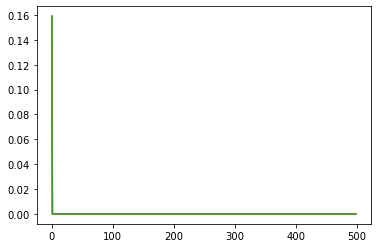

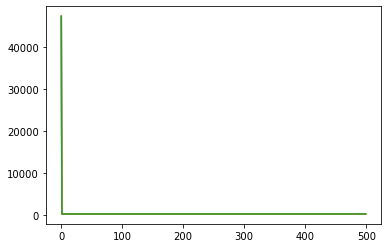

In [30]:
# Figure (dj_dk, cost  functional)
z = np.arange(0, Zmax-1, 1)
n_djdk = np.zeros([Zmax-1, r])
J_Tl = np.zeros([Zmax-1, r])
del id
for id in range(0, Zmax-1):
    norm_djdk = np.linalg.norm(djdk_d[0:2*n+r,0:2*n+r,id])
    n_djdk[id,:] = norm_djdk
    J_T = J_cd[len(t)-1,:,id]
    J_Tl[id, :] = J_T
plt.figure()
plt.plot(z, n_djdk)
plt.figure()
plt.plot(z, J_Tl)

In [34]:
# Maximum value of response
for i in range(0,n):
    print("Peak Dis of floor:", i+1, "Uncontrolled:", max(xo[:,i], key=abs), "Optimal-P:", max(xp2[:,i], key=abs), "PG-P:", max(xd[:,i,Zmax-2], key=abs))
    print("Peak Vel of floor:", i+1, "Uncontrolled:", max(xo[:,n+i], key=abs), "Optimal-P:", max(xp2[:,n+i], key=abs), "PG-P:", max(xd[:,n+i,Zmax-2], key=abs))
    print("Peak Acc of floor:", i+1, "Uncontrolled:", max(yo[:,i], key=abs), "Optimal-P:", max(yp2[:,i], key=abs), "PG-P:", max(yp_zmax.T[:,i], key=abs))


Peak Dis of floor: 1 Uncontrolled: -0.13649317850101284 Optimal-P: -0.06029957993283391 PG-P: 0.01717794788786827
Peak Vel of floor: 1 Uncontrolled: 0.8027861019342699 Optimal-P: -0.35485986700229977 PG-P: -0.05954019132600857
Peak Acc of floor: 1 Uncontrolled: 4.601090269695618 Optimal-P: 2.131581022756477 PG-P: [-1.35967699]
Peak Dis of floor: 2 Uncontrolled: 0.2684505392962869 Optimal-P: -0.12134345631923639 PG-P: 0.032993170987032285
Peak Vel of floor: 2 Uncontrolled: 1.5789354841345473 Optimal-P: -0.7136666152933773 PG-P: -0.11394005253145177
Peak Acc of floor: 2 Uncontrolled: 9.059135389357834 Optimal-P: 4.369145073959203 PG-P: [-1.66643339]
Peak Dis of floor: 3 Uncontrolled: 0.3913584972426819 Optimal-P: -0.17822948672241387 PG-P: 0.047136373372753934
Peak Vel of floor: 3 Uncontrolled: -2.30187915422473 Optimal-P: 1.0481150325512276 PG-P: -0.16192392363667577
Peak Acc of floor: 3 Uncontrolled: 13.265269781074494 Optimal-P: -6.495312344063427 PG-P: [-1.93635598]
Peak Dis of floor

In [119]:
BKt = BK[0:2*n+r,0:2*n+r,Zmax-1]
xt = np.zeros([len(t), 2*n+r])  # State
yt = np.zeros([len(t), len(Cd1)])  # output
print(BKt)
for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    h = amplitude1[tkk] 
    xn = np.array([xt[tkk,:]]).T
    xn1 = (FI @ xn) + (BKt @ xn) + (BIrd * h)
#     print(xn1)
    xt[tkk+1,:] = xn1.T
    yn1 = (Cd1-BKt) @ xn1
    yt[tkk+1,:] = yn1.T

[[ 5.29505677e-07  1.38049543e-06  2.30160224e-06  3.03255699e-06
   3.64783431e-06  4.24184955e-06  4.57265266e-06  4.74094418e-06
  -5.09028618e-07 -9.21653120e-07 -1.23644844e-06 -1.46602771e-06
  -1.62684968e-06 -1.71874836e-06 -1.77618837e-06 -1.76007643e-06
  -3.93487570e-05 -1.38403839e-04 -1.83611742e-04]
 [ 1.74115084e-06  3.44726507e-06  5.06882425e-06  6.50451933e-06
   7.71446004e-06  8.66688720e-06  9.31773939e-06  9.64786874e-06
   1.19275769e-07  2.23897743e-07  3.18064858e-07  4.31159989e-07
   5.30760092e-07  6.16954436e-07  6.81882274e-07  8.02563239e-07
  -7.54285669e-05 -2.70903797e-04 -3.60481077e-04]
 [ 2.28909359e-06  4.78145806e-06  7.70244875e-06  9.78127784e-06
   1.15606035e-05  1.28711718e-05  1.38206054e-05  1.43017189e-05
   4.69680410e-07  9.88358102e-07  1.56105742e-06  2.08093094e-06
   2.49594337e-06  2.80746256e-06  3.02609554e-06  3.26418578e-06
  -1.10687512e-04 -3.94165802e-04 -5.25002785e-04]
 [ 3.59478417e-06  6.79061589e-06  9.17839996e-06  1.18

In [120]:
np.save('BKt_PI8.npy', BKt)
np.save('Cd1_PI8.npy', Cd1)